In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pyodbc
import mysql.connector
import json
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

import requests
import datetime
from tqdm import tqdm

In [2]:
pyodbc.drivers()

['MySQL']

### Redshift Connection

In [3]:
# Redshift 연결 정보
host='dev-data-etl-rs.ct0xxcn9xq5g.ap-northeast-2.redshift.amazonaws.com'
dbname='data_analysis_db'
user='stella'
password='iWntan282E5jJQc'
port='5439'

In [4]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

In [5]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""
                SELECT
                    device_datetime_kor, device_serial, lat, lon, battery, temperature, humidity
                    , acc_orig, acc, accx, accy, accz, tiltx, tilty, tiltz
                    , measure_date_kst, aws_station_id, aws_station_name, aws_lat, aws_lon, distance_km, ws1, ws10, ta, hm
                FROM 
                    "data_analysis_db"."da_schema"."t_frigga_weather_map"
                WHERE 1=1
                    AND temperature IS NOT NULL
                    AND acc_orig IS NOT NULL
                    AND distance_km <= 10
                    ORDER BY distance_km DESC
               """)

# 결과 가져오기
rows = cursor.fetchall()

cursor.close()
conn.close()

In [6]:
# 컬럼명 리스트 정의
columns = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery', 'temperature', 'humidity', 'acc_orig',
           'acc', 'accx', 'accy', 'accz', 'tiltx', 'tilty', 'tiltz', 
           'measure_date_kst', 'aws_station_id', 'aws_station_name', 'aws_lat', 'aws_lon',
           'distance_km', 'ws1', 'ws10', 'ta', 'hm']

# rows를 DataFrame으로 변환
df= pd.DataFrame(rows, columns=columns)

# 데이터프레임 확인
print("데이터프레임 크기:", df.shape)
print("\n처음 5행 데이터:")
print(df.head())

데이터프레임 크기: (149245, 25)

처음 5행 데이터:
  device_datetime_kor device_serial        lat         lon battery  \
0 2024-11-19 16:54:08      VC6M60A9  36.845154  127.048707   100.0   
1 2024-12-17 23:31:47      VC6M60AD  36.815106  127.061828   100.0   
2 2024-12-17 23:41:47      VC6M60AD  36.815106  127.061828   100.0   
3 2024-12-17 23:21:47      VC6M60AD  36.815106  127.061828   100.0   
4 2024-12-17 23:51:47      VC6M60AD  36.815106  127.061828   100.0   

  temperature humidity acc_orig   acc accx  ...    measure_date_kst  \
0        12.9     41.0      1.2  1.20  0.0  ... 2024-11-19 16:00:00   
1         1.0     50.0      1.0  1.01  0.1  ... 2024-12-17 23:00:00   
2         0.8     51.0      1.0  1.01  0.1  ... 2024-12-17 23:00:00   
3         1.2     49.0      1.0  1.01  0.1  ... 2024-12-17 23:00:00   
4         0.5     51.0      1.0  1.01  0.1  ... 2024-12-17 23:00:00   

  aws_station_id aws_station_name      aws_lat       aws_lon distance_km  \
0            617               직산  36.89

In [7]:
### 결측치 처리
# device_serial 별로 각 컬럼의 평균값으로 결측치 처리
for column in df.columns:
    if df[column].isna().any():  # 결측치가 있는 경우에만 처리
        df[column] = df.groupby('device_serial')[column].transform(lambda x: x.fillna(x.mean()))

# 결과 출력
print("결측치가 평균값으로 처리된 데이터프레임:")
print(df)

결측치가 평균값으로 처리된 데이터프레임:
       device_datetime_kor device_serial        lat         lon battery  \
0      2024-11-19 16:54:08      VC6M60A9  36.845154  127.048707   100.0   
1      2024-12-17 23:31:47      VC6M60AD  36.815106  127.061828   100.0   
2      2024-12-17 23:41:47      VC6M60AD  36.815106  127.061828   100.0   
3      2024-12-17 23:21:47      VC6M60AD  36.815106  127.061828   100.0   
4      2024-12-17 23:51:47      VC6M60AD  36.815106  127.061828   100.0   
...                    ...           ...        ...         ...     ...   
149240 2024-12-13 12:51:44      VC6M60E6  36.299017  127.593702   100.0   
149241 2024-12-13 13:01:44      VC6M60E6  36.299017  127.593702   100.0   
149242 2024-12-02 16:57:18      VC6M6002  36.298510  127.597675   100.0   
149243 2024-12-09 11:53:19      VC6ML003  36.638253  127.384396   100.0   
149244 2024-11-29 11:50:50      VC6M6049  36.300355  127.595394    90.0   

       temperature humidity acc_orig   acc  accx  ...    measure_date_kst  \

#### Data EDA

- Distance(Km) Filtering

In [8]:
# 1. 기본 통계량 확인
device_stats = df.groupby('device_serial')['distance_km'].describe()
print("== device_serial별 distance_km 기본 통계량 ==")
print(device_stats)

== device_serial별 distance_km 기본 통계량 ==
                count      mean       std       min       25%       50%  \
device_serial                                                             
VC6M6002       1021.0  2.206837  1.014927  0.189542  1.656371  1.740009   
VC6M6003        830.0  2.249690  1.736950  0.478019  1.192387  1.969838   
VC6M6007       3923.0  9.377227  0.733122  2.106484  9.555649  9.555649   
VC6M6008         76.0  3.709860  0.882876  2.927269  3.533114  3.533114   
VC6M600A        106.0  2.554063  1.052229  2.249160  2.249160  2.249160   
...               ...       ...       ...       ...       ...       ...   
VC6M61C3         30.0  4.814036  1.234677  1.200780  4.922835  4.922835   
VC6M61C4        150.0  6.083895  0.377337  3.233156  6.159726  6.159726   
VC6M61ED          2.0  5.379308  0.000000  5.379308  5.379308  5.379308   
VC6ML002       1267.0  8.843401  1.169965  0.360102  9.070987  9.070987   
VC6ML003       1536.0  8.752257  1.570281  0.187931  9.07338

### distance_km 분포 비교

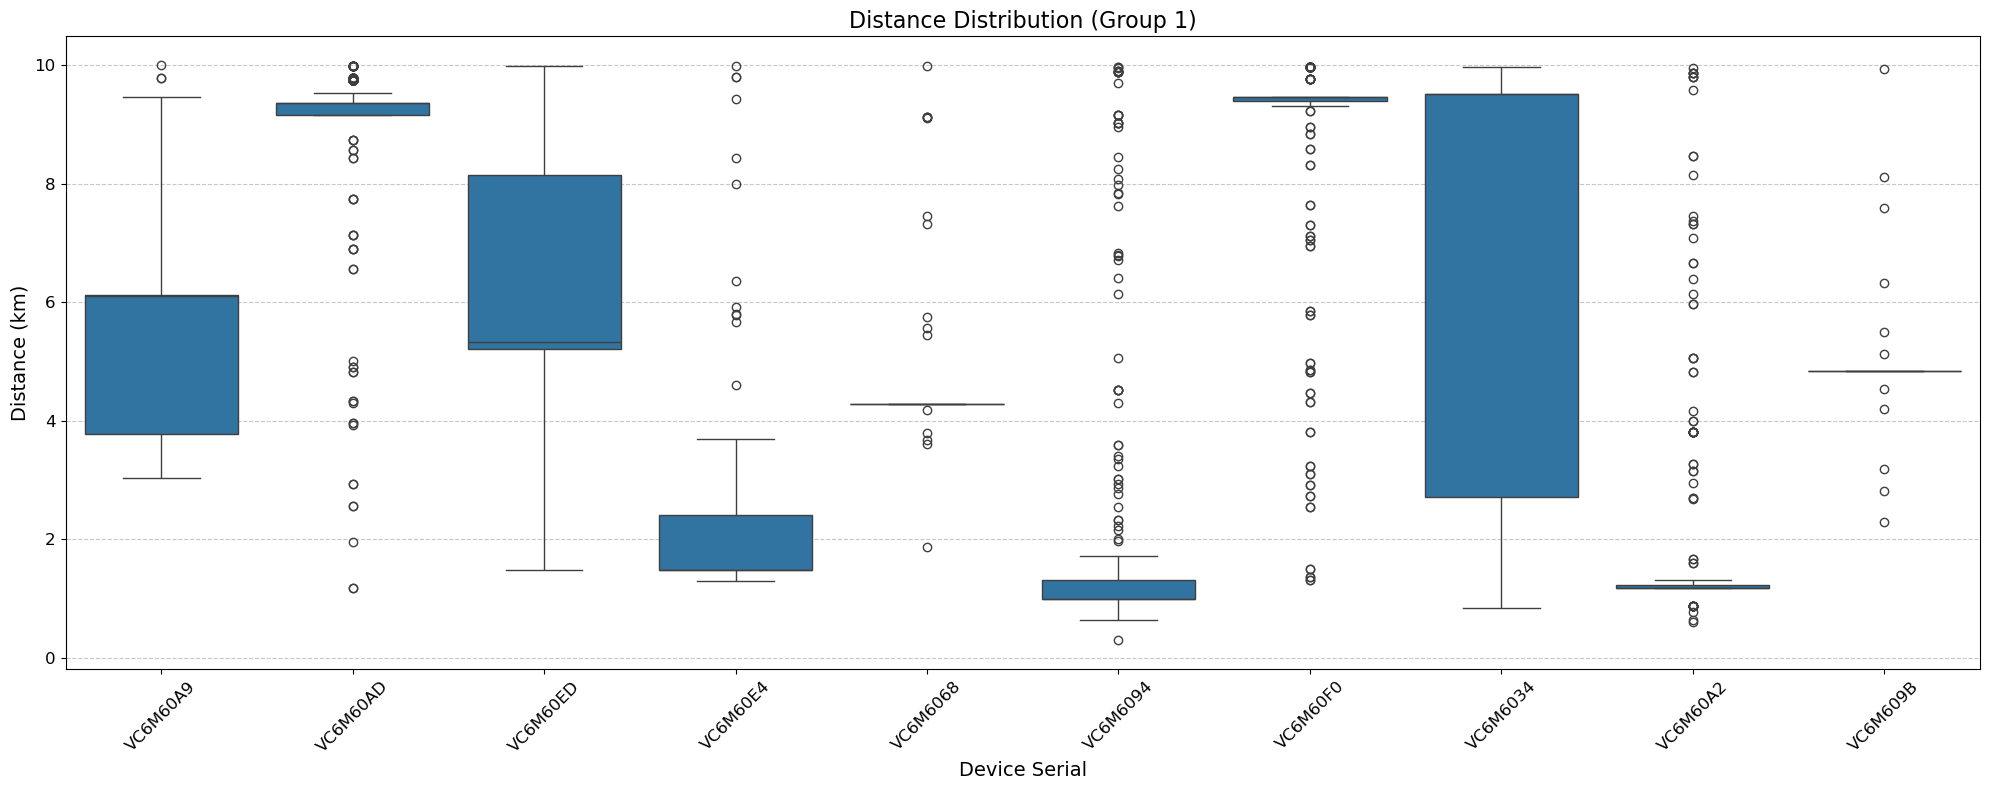


=== Group 1 통계량 ===
                count  mean   std   min   25%   50%   75%    max
device_serial                                                   
VC6M6034       1227.0  6.45  3.44  0.84  2.72  9.51  9.51   9.96
VC6M6068         41.0  5.04  1.83  1.86  4.28  4.28  4.28   9.98
VC6M6094        257.0  2.19  2.69  0.30  0.99  0.99  1.31   9.97
VC6M609B         70.0  4.93  0.93  2.28  4.84  4.84  4.84   9.93
VC6M60A2        288.0  1.96  2.04  0.60  1.17  1.17  1.23   9.95
VC6M60A9        230.0  5.43  1.26  3.04  3.77  6.10  6.11  10.00
VC6M60AD       5275.0  9.31  0.41  1.17  9.16  9.36  9.36   9.99
VC6M60E4         67.0  2.70  2.43  1.29  1.48  1.48  2.40   9.98
VC6M60ED         30.0  5.76  2.50  1.47  5.20  5.33  8.15   9.98
VC6M60F0       3749.0  9.37  0.57  1.31  9.39  9.46  9.46   9.97

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.

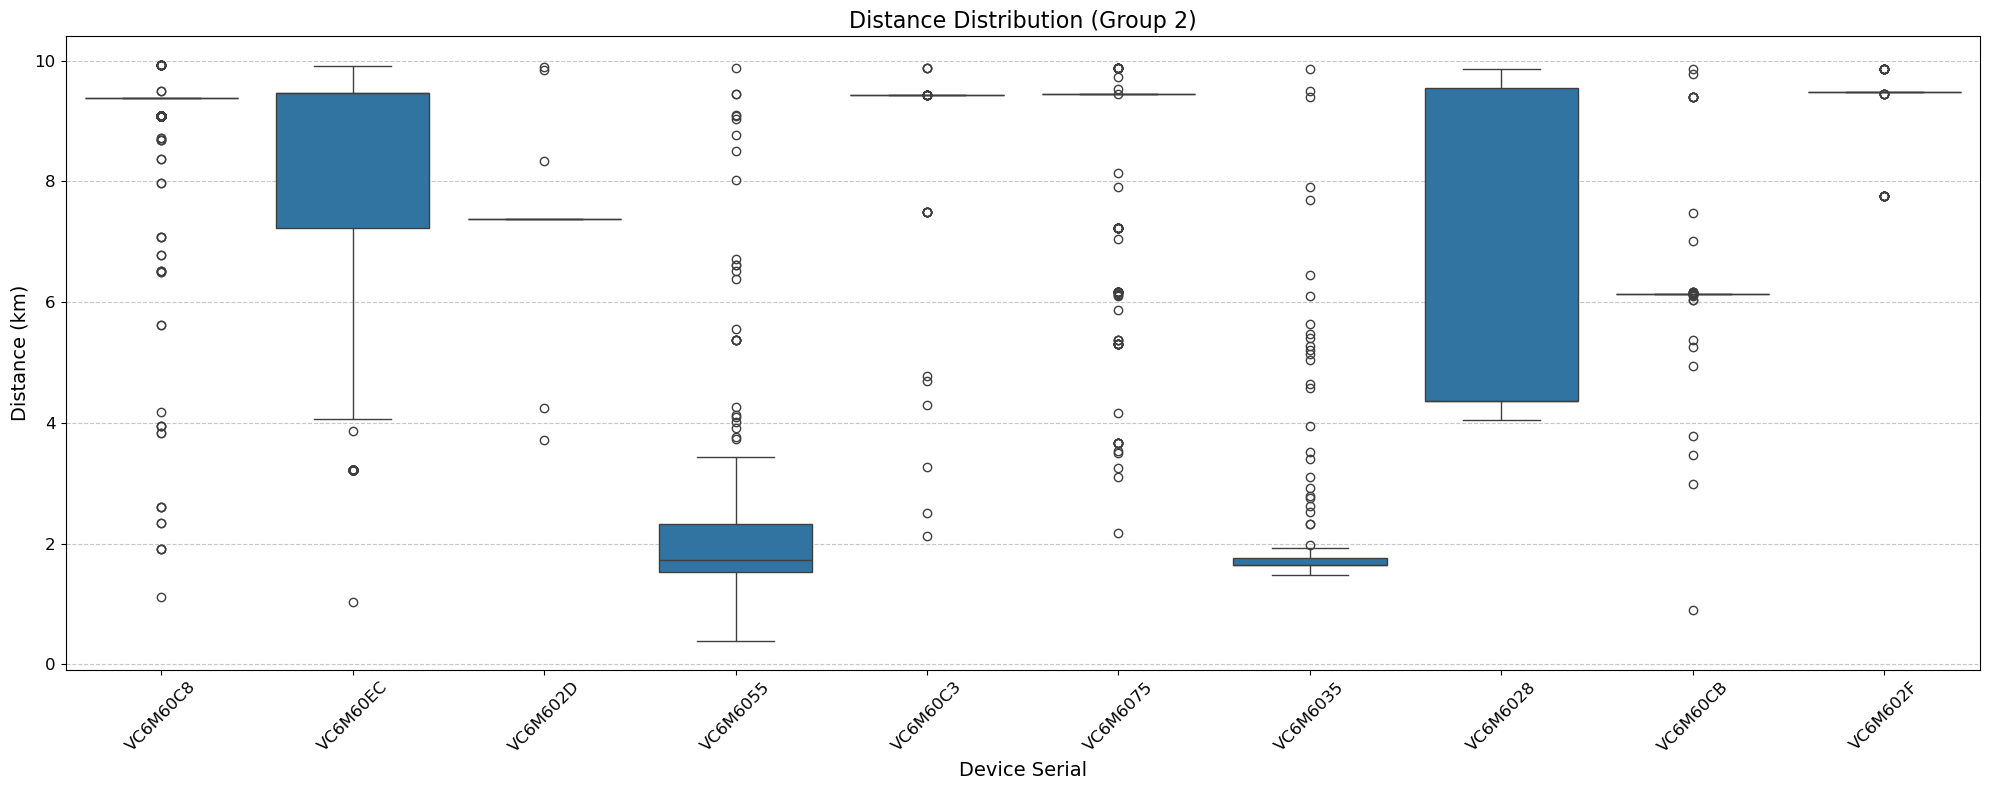


=== Group 2 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6028        690.0  5.70  2.27  4.05  4.36  4.36  9.55  9.86
VC6M602D        104.0  7.37  0.60  3.71  7.38  7.38  7.38  9.90
VC6M602F        192.0  9.39  0.43  7.75  9.47  9.47  9.47  9.85
VC6M6035        160.0  2.23  1.56  1.48  1.65  1.65  1.76  9.86
VC6M6055        961.0  2.05  0.91  0.39  1.53  1.73  2.33  9.88
VC6M6075       2927.0  9.36  0.60  2.17  9.45  9.45  9.45  9.87
VC6M60C3       2511.0  9.41  0.30  2.12  9.43  9.43  9.43  9.88
VC6M60C8       4599.0  9.31  0.42  1.11  9.38  9.38  9.38  9.92
VC6M60CB        171.0  6.20  0.92  0.91  6.13  6.13  6.13  9.86
VC6M60EC       1482.0  8.22  2.20  1.03  7.23  9.46  9.46  9.91

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

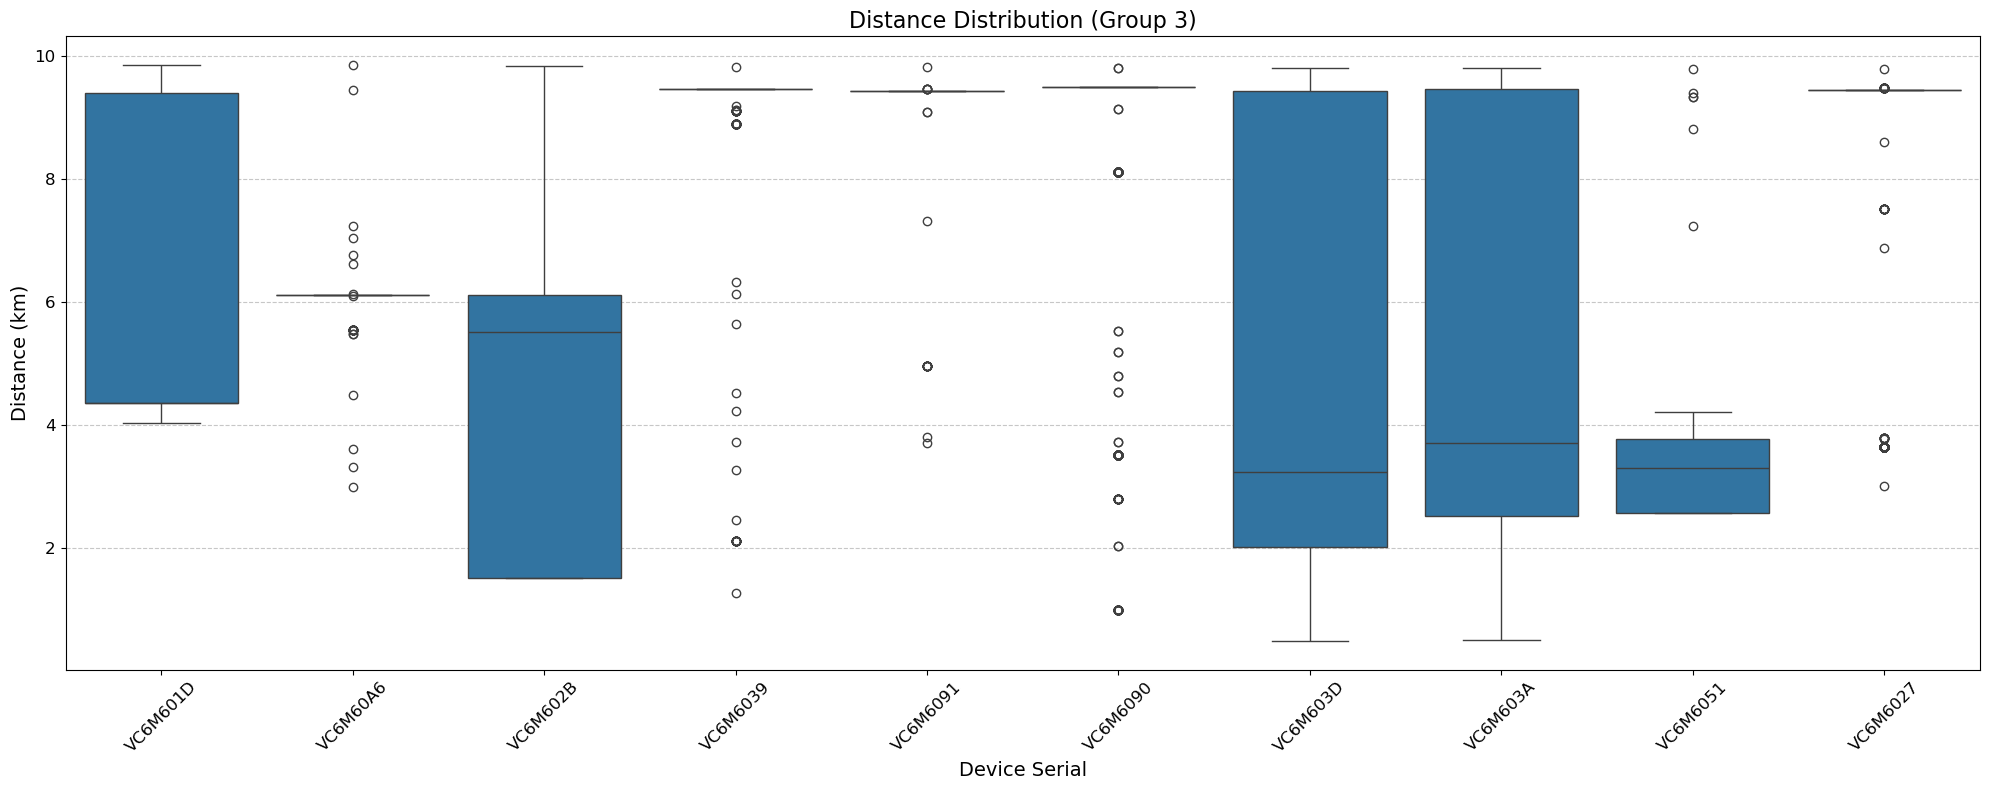


=== Group 3 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M601D        690.0  5.71  2.22  4.04  4.36  4.36  9.40  9.85
VC6M6027       3735.0  9.16  1.24  3.00  9.44  9.44  9.44  9.79
VC6M602B        409.0  3.90  2.29  1.51  1.51  5.51  6.11  9.83
VC6M6039       1885.0  9.37  0.79  1.27  9.47  9.47  9.47  9.83
VC6M603A       2832.0  5.43  3.41  0.51  2.53  3.71  9.46  9.80
VC6M603D       1197.0  4.68  3.35  0.49  2.02  3.24  9.44  9.81
VC6M6051        201.0  3.42  1.10  2.57  2.57  3.30  3.78  9.80
VC6M6090       3831.0  9.16  1.42  0.99  9.50  9.50  9.50  9.81
VC6M6091        598.0  9.32  0.71  3.70  9.44  9.44  9.44  9.81
VC6M60A6        528.0  6.08  0.35  2.99  6.12  6.12  6.12  9.85

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

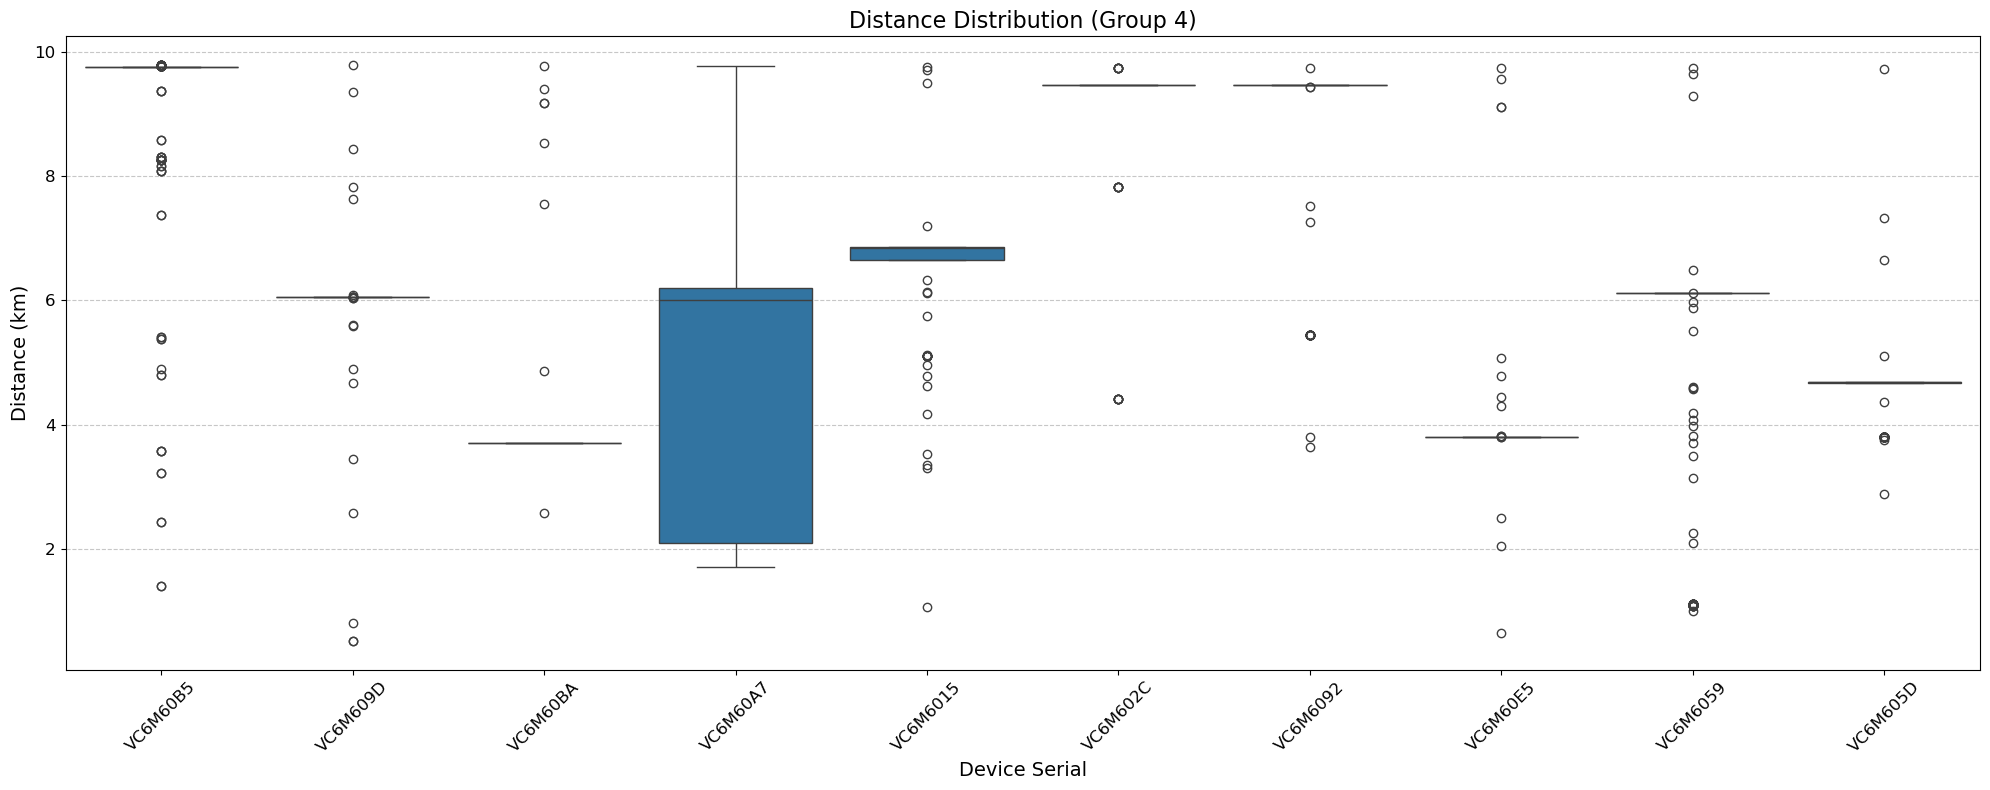


=== Group 4 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6015        88.0  6.43  1.22  1.08  6.66  6.85  6.86  9.75
VC6M602C       126.0  9.16  1.13  4.41  9.47  9.47  9.47  9.74
VC6M6059       415.0  5.37  1.80  1.01  6.12  6.12  6.12  9.73
VC6M605D       227.0  4.52  0.57  2.89  4.68  4.68  4.68  9.72
VC6M6092       199.0  8.90  1.42  3.65  9.46  9.46  9.46  9.74
VC6M609D       109.0  5.93  1.16  0.53  6.05  6.05  6.05  9.78
VC6M60A7       204.0  4.32  2.09  1.72  2.10  6.00  6.20  9.77
VC6M60B5       826.0  9.61  0.87  1.41  9.76  9.76  9.76  9.78
VC6M60BA       110.0  4.00  1.21  2.58  3.72  3.72  3.72  9.77
VC6M60E5        46.0  4.23  1.73  0.65  3.80  3.80  3.80  9.74

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC6M600A      

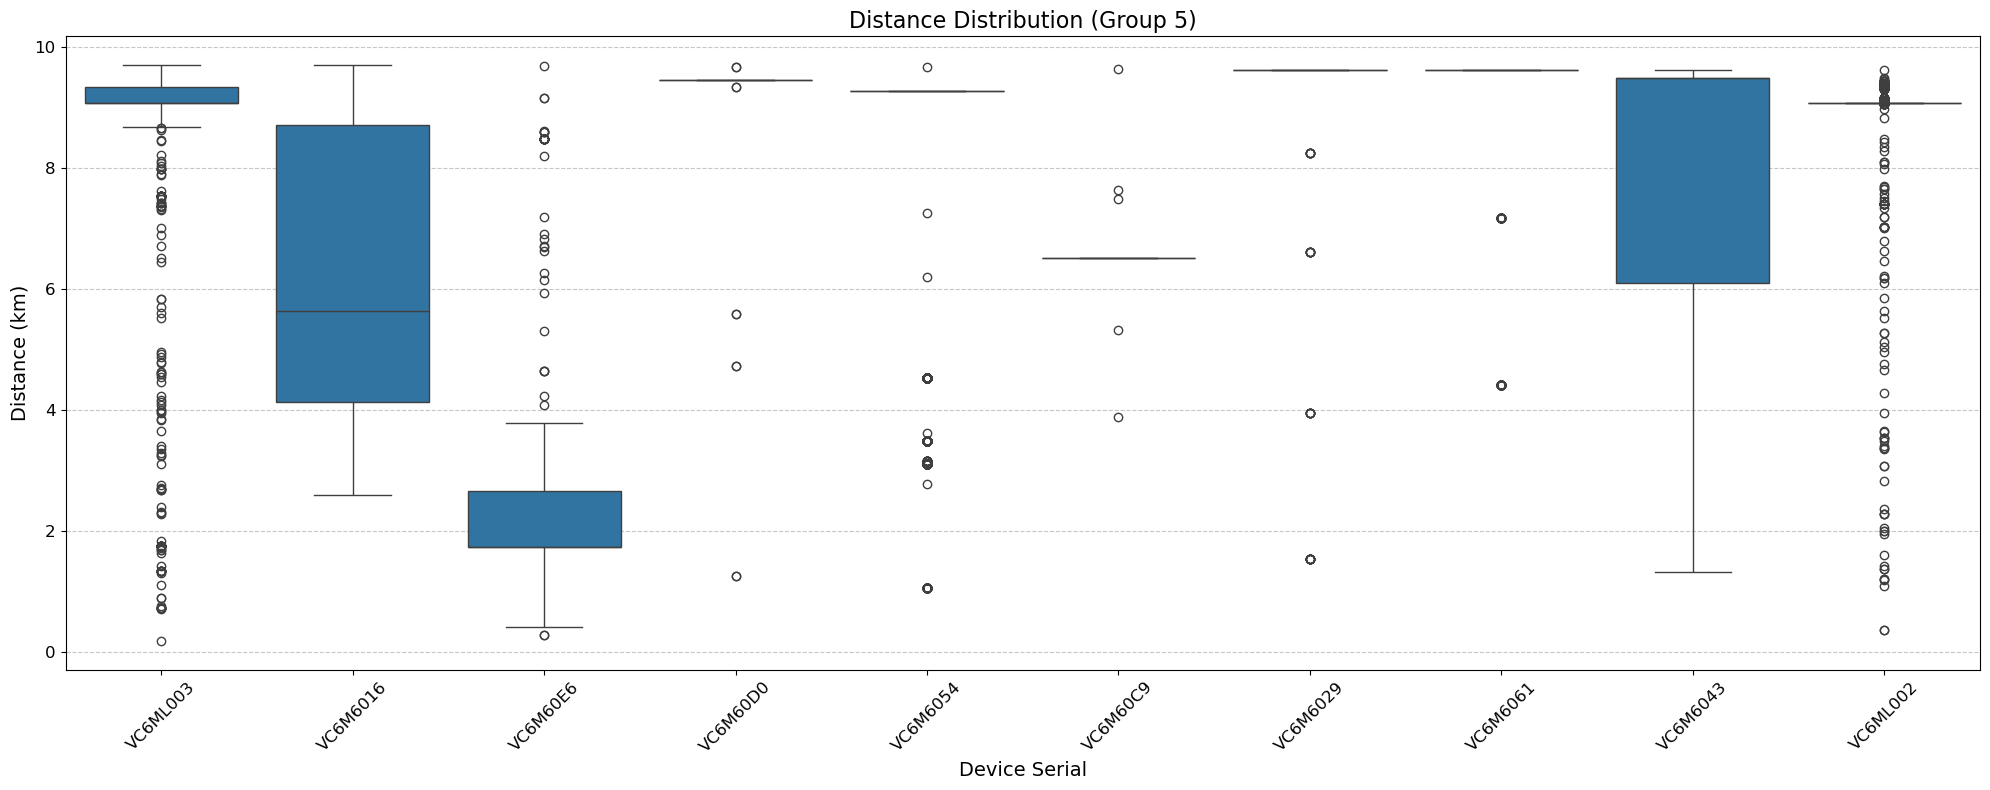


=== Group 5 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6016         14.0  6.06  2.54  2.59  4.13  5.64  8.70  9.70
VC6M6029        192.0  8.81  2.19  1.54  9.63  9.63  9.63  9.63
VC6M6043       1662.0  7.83  2.50  1.33  6.11  9.48  9.48  9.62
VC6M6054       2767.0  8.04  2.36  1.06  9.26  9.26  9.26  9.66
VC6M6061       2820.0  9.47  0.83  4.42  9.62  9.62  9.62  9.62
VC6M60C9         96.0  6.53  0.46  3.89  6.51  6.51  6.51  9.64
VC6M60D0       1059.0  9.42  0.44  1.26  9.45  9.45  9.45  9.67
VC6M60E6        583.0  2.42  1.52  0.28  1.74  1.74  2.66  9.68
VC6ML002       1267.0  8.84  1.17  0.36  9.07  9.07  9.07  9.62
VC6ML003       1536.0  8.75  1.57  0.19  9.07  9.07  9.35  9.70

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

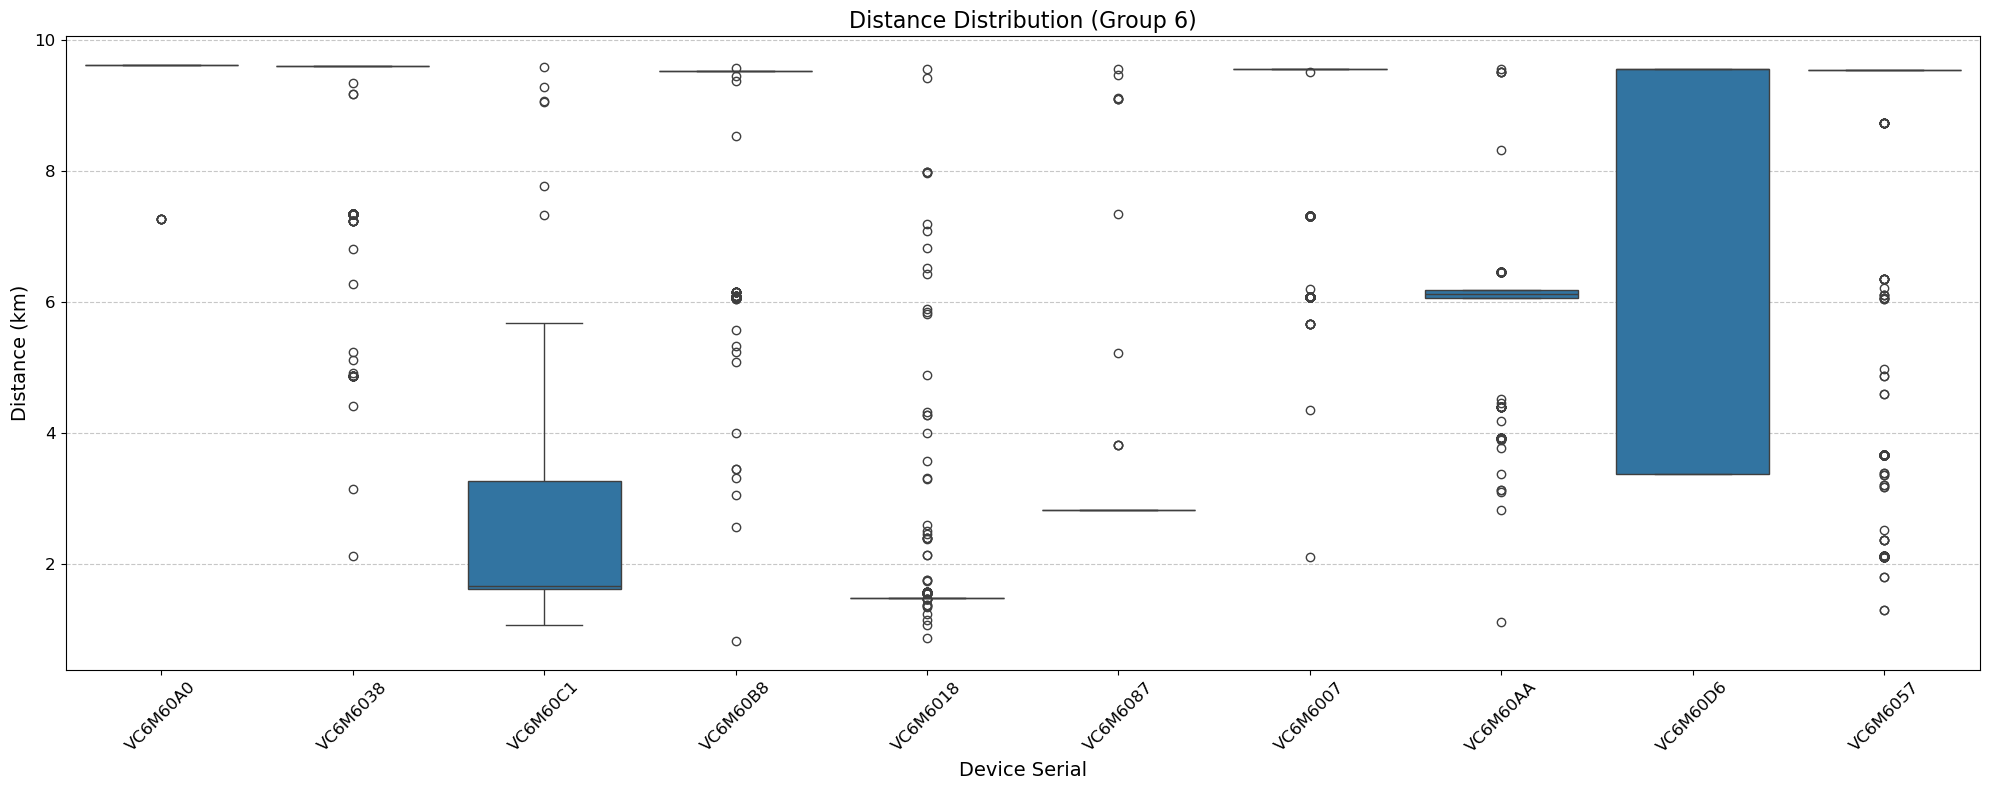


=== Group 6 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6007       3923.0  9.38  0.73  2.11  9.56  9.56  9.56  9.56
VC6M6018        792.0  1.63  0.83  0.88  1.48  1.48  1.48  9.56
VC6M6038       2879.0  9.44  0.70  2.13  9.60  9.60  9.60  9.60
VC6M6057       3056.0  9.12  1.59  1.31  9.54  9.54  9.54  9.54
VC6M6087        140.0  3.17  1.37  2.83  2.83  2.83  2.83  9.56
VC6M60A0        606.0  9.59  0.23  7.27  9.61  9.61  9.61  9.61
VC6M60AA        233.0  5.80  1.13  1.12  6.06  6.12  6.18  9.55
VC6M60B8       2595.0  9.37  0.75  0.84  9.52  9.52  9.52  9.57
VC6M60C1        690.0  2.21  1.10  1.07  1.63  1.66  3.27  9.59
VC6M60D6       2051.0  7.58  2.88  3.38  3.38  9.55  9.55  9.55

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

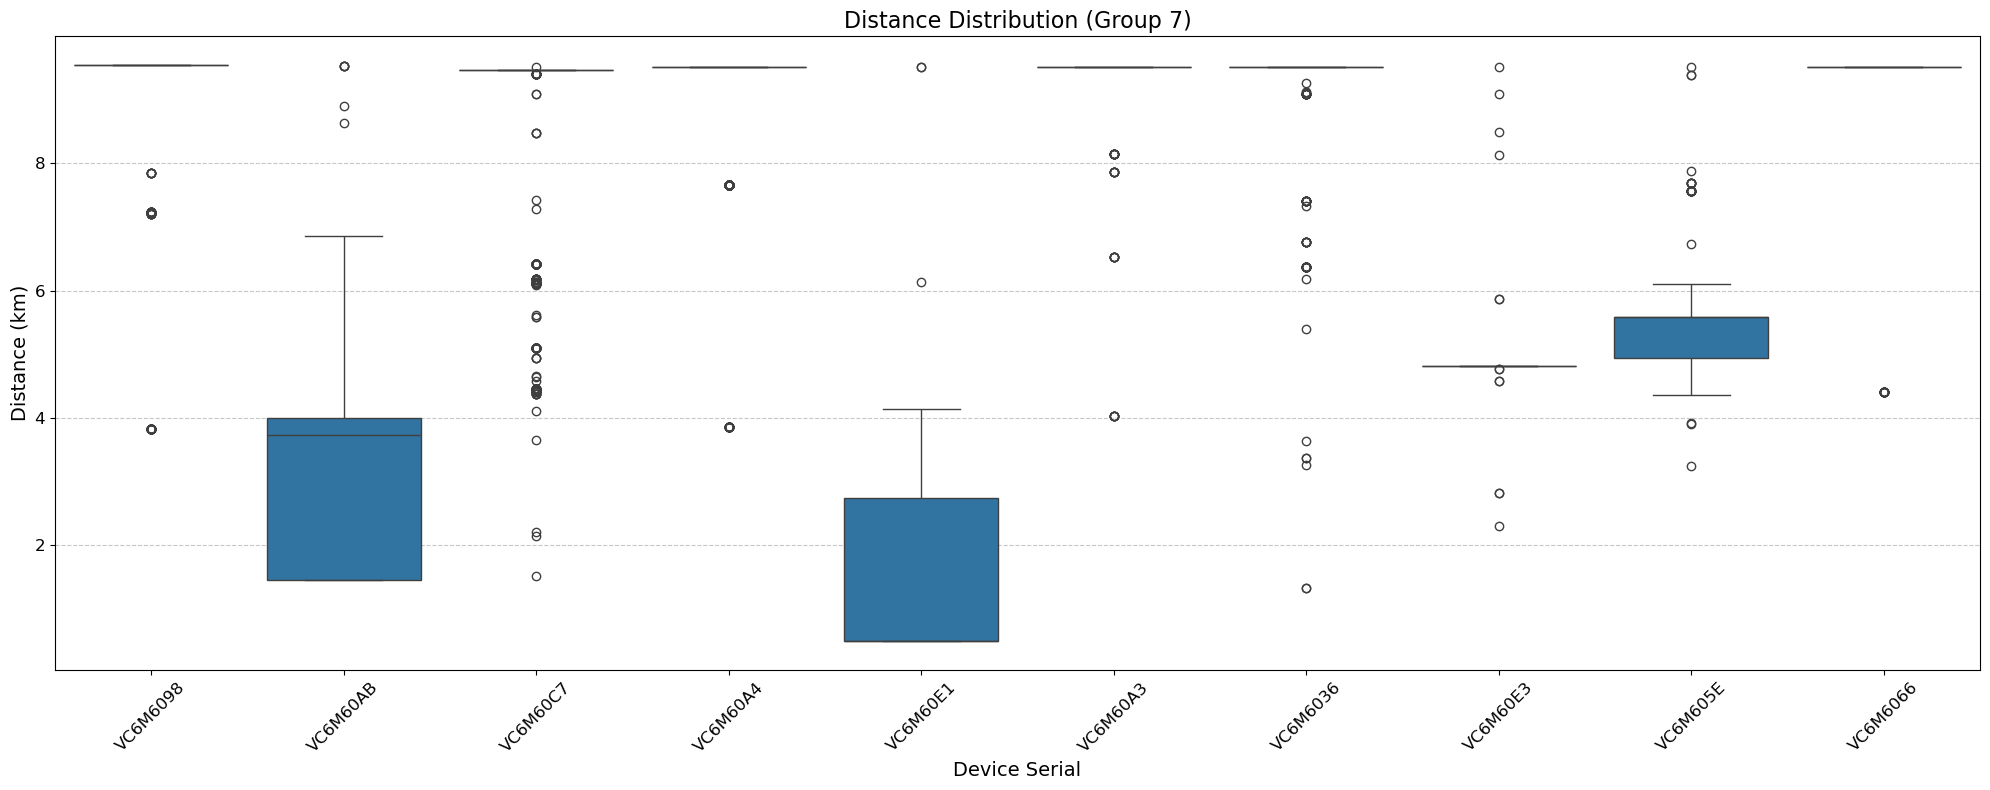


=== Group 7 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6036       1114.0  9.35  0.76  1.33  9.51  9.51  9.51  9.51
VC6M605E        254.0  5.66  0.94  3.24  4.94  5.59  5.59  9.50
VC6M6066        239.0  8.99  1.54  4.41  9.50  9.50  9.50  9.50
VC6M6098       1033.0  9.22  1.20  3.83  9.54  9.54  9.54  9.54
VC6M60A3        144.0  8.97  1.27  4.03  9.51  9.51  9.51  9.51
VC6M60A4        978.0  9.08  1.19  3.85  9.51  9.51  9.51  9.51
VC6M60AB        354.0  3.14  1.43  1.45  1.45  3.73  4.00  9.53
VC6M60C7       3228.0  8.99  1.36  1.52  9.46  9.46  9.46  9.52
VC6M60E1         26.0  1.89  2.71  0.49  0.49  0.49  2.74  9.51
VC6M60E3        249.0  4.86  0.57  2.30  4.82  4.82  4.82  9.50

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

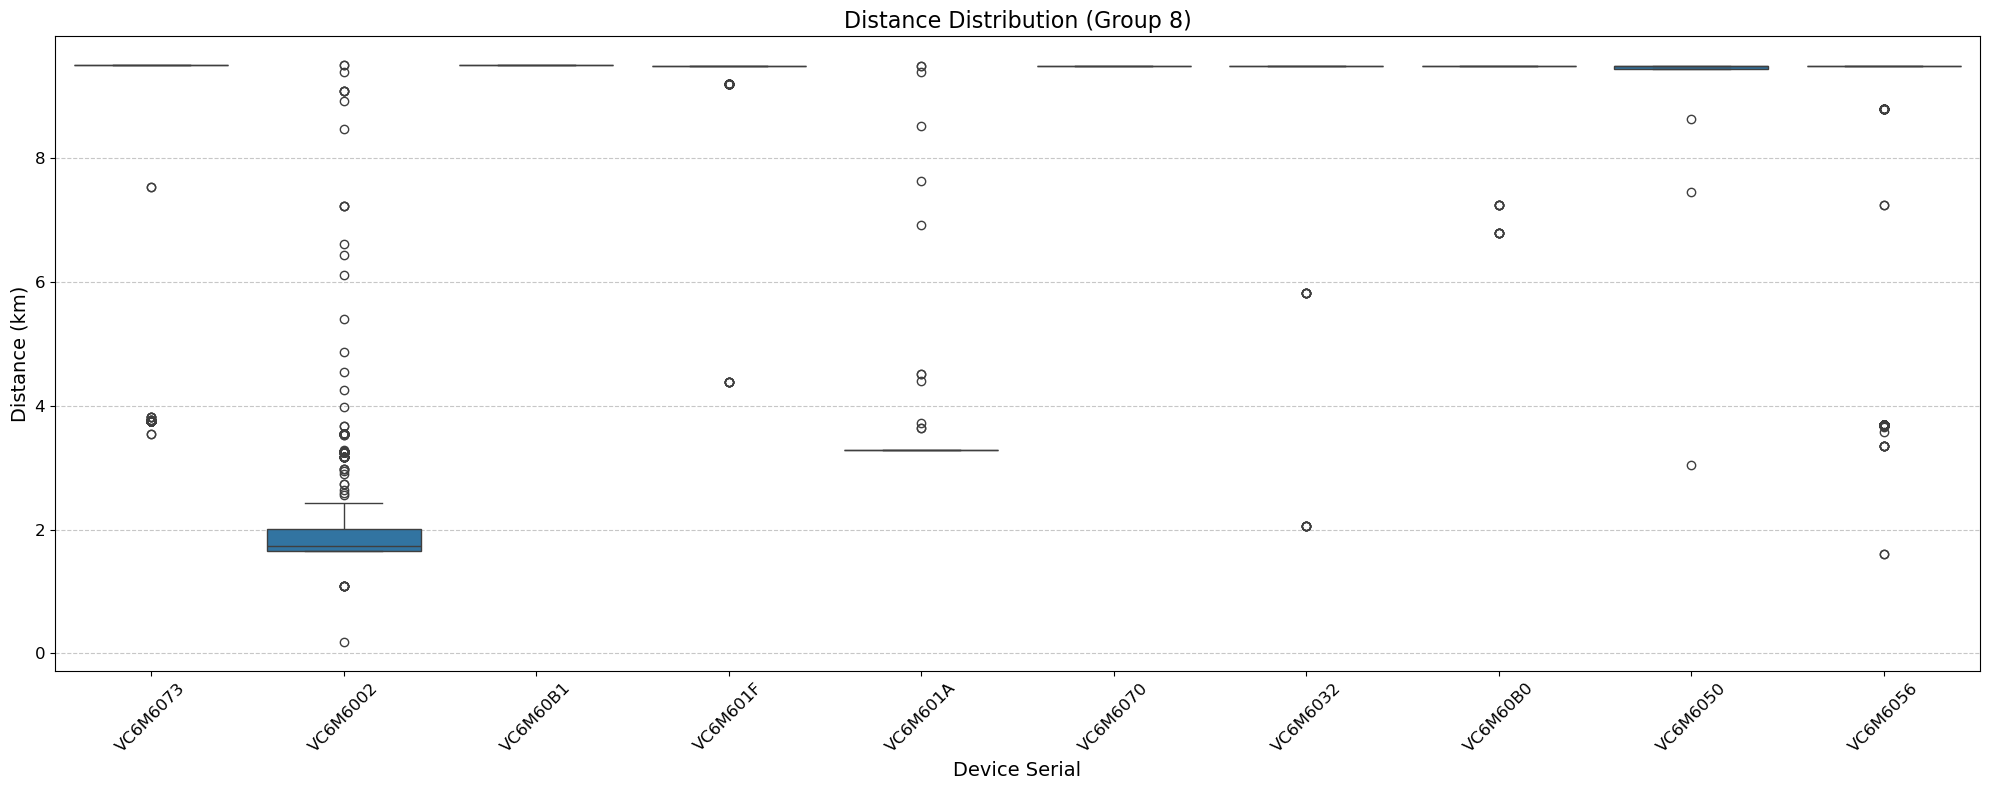


=== Group 8 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6002       1021.0  2.21  1.01  0.19  1.66  1.74  2.01  9.50
VC6M601A         58.0  3.92  1.65  3.29  3.29  3.29  3.29  9.49
VC6M601F        400.0  9.40  0.62  4.39  9.50  9.50  9.50  9.50
VC6M6032        120.0  8.93  1.77  2.07  9.49  9.49  9.49  9.49
VC6M6050       1096.0  9.46  0.21  3.04  9.45  9.49  9.49  9.49
VC6M6056       4039.0  8.18  2.42  1.60  9.49  9.49  9.49  9.49
VC6M6070        575.0  9.49  0.00  9.49  9.49  9.49  9.49  9.49
VC6M6073       2161.0  8.88  1.78  3.54  9.50  9.50  9.50  9.50
VC6M60B0        606.0  9.44  0.33  6.80  9.49  9.49  9.49  9.49
VC6M60B1        294.0  9.50  0.00  9.50  9.50  9.50  9.50  9.50

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

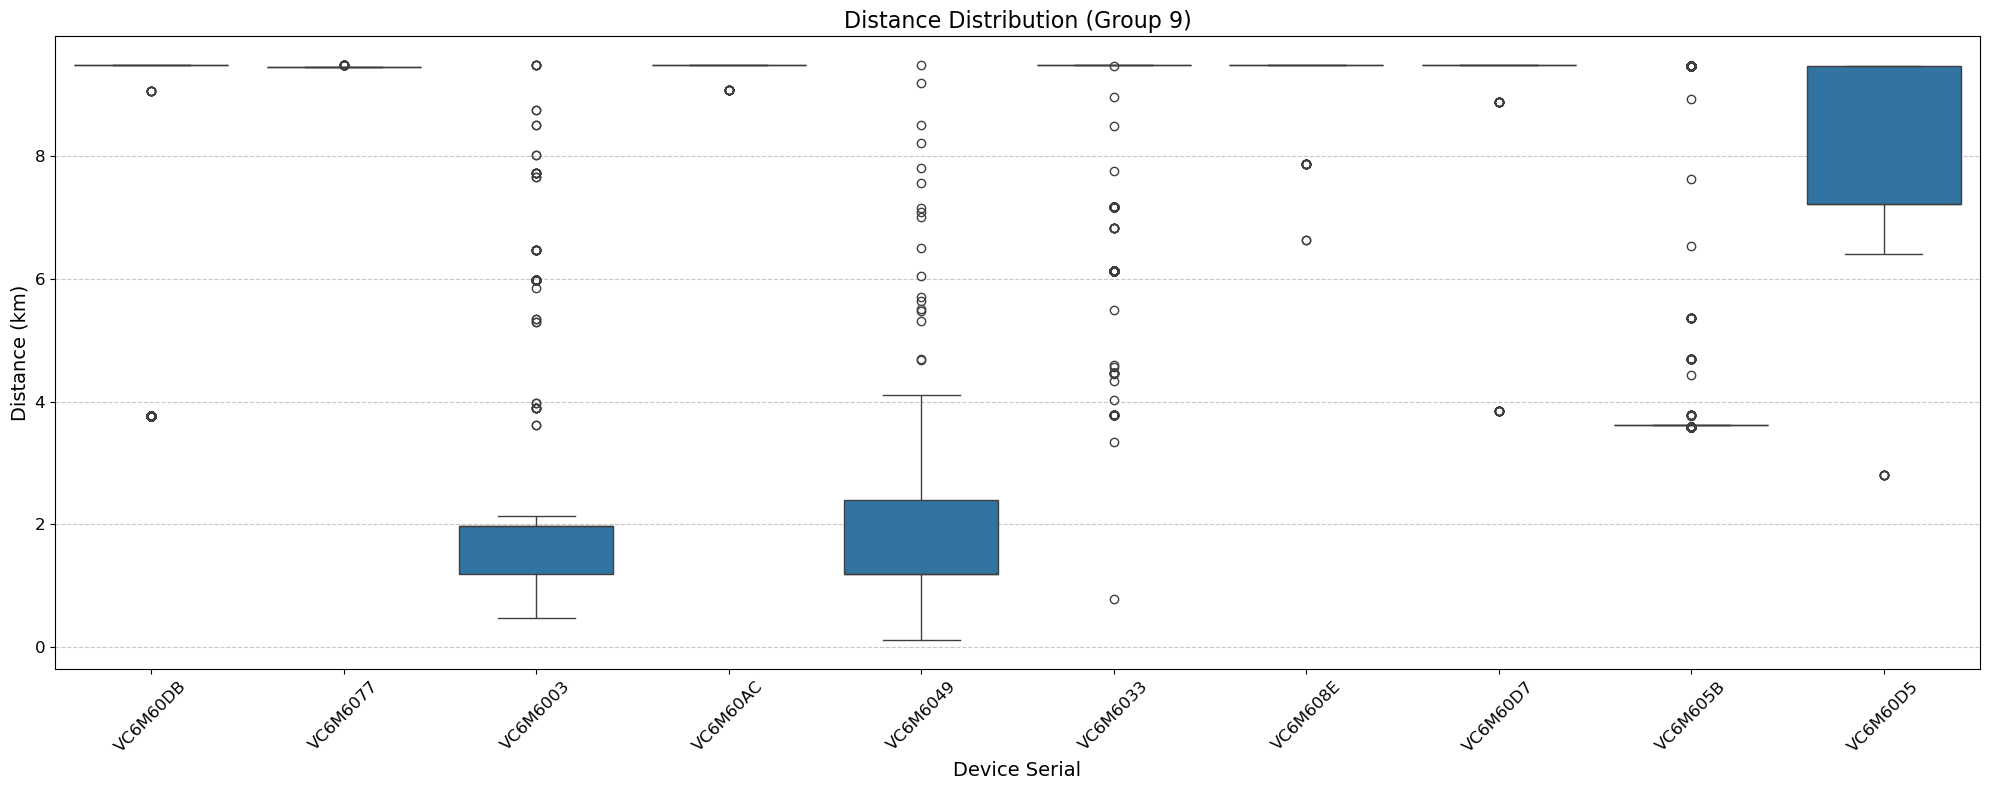


=== Group 9 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6003        830.0  2.25  1.74  0.48  1.19  1.97  1.97  9.48
VC6M6033       1285.0  8.64  1.56  0.78  9.48  9.48  9.48  9.48
VC6M6049        707.0  1.83  1.03  0.11  1.19  1.19  2.40  9.48
VC6M605B       3487.0  4.47  2.05  3.58  3.62  3.62  3.62  9.48
VC6M6077       2004.0  9.46  0.00  9.46  9.46  9.46  9.46  9.48
VC6M608E       1434.0  9.46  0.18  6.63  9.48  9.48  9.48  9.48
VC6M60AC       1881.0  9.48  0.03  9.07  9.48  9.48  9.48  9.48
VC6M60D5       1650.0  8.10  1.15  2.80  7.23  7.23  9.48  9.48
VC6M60D7       1707.0  9.44  0.47  3.84  9.48  9.48  9.48  9.48
VC6M60DB       1020.0  8.71  1.95  3.77  9.49  9.49  9.49  9.49

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC

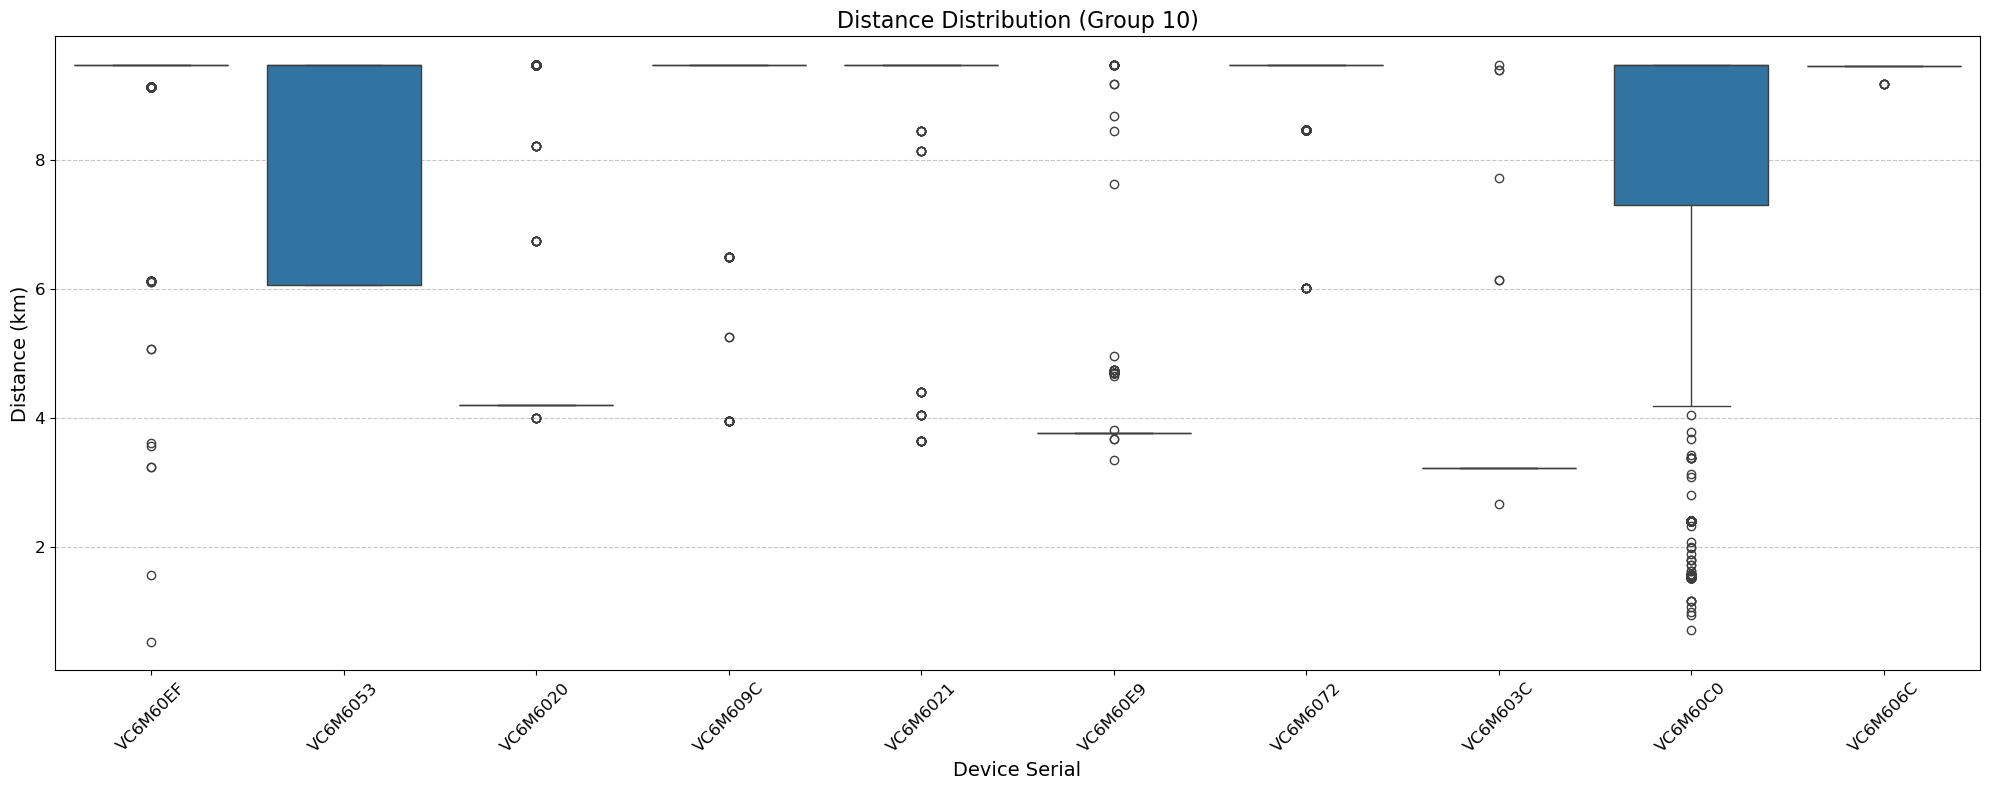


=== Group 10 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6020        691.0  5.08  1.95  4.00  4.19  4.19  4.19  9.47
VC6M6021        200.0  8.68  1.86  3.65  9.47  9.47  9.47  9.47
VC6M603C       1253.0  3.25  0.35  2.65  3.22  3.22  3.22  9.47
VC6M6053        405.0  8.18  1.66  6.06  6.06  9.47  9.47  9.47
VC6M606C        197.0  9.46  0.05  9.19  9.47  9.47  9.47  9.47
VC6M6072       2409.0  9.41  0.32  6.01  9.47  9.47  9.47  9.47
VC6M609C        431.0  9.13  1.19  3.95  9.47  9.47  9.47  9.47
VC6M60C0       3744.0  7.76  2.98  0.71  7.31  9.47  9.47  9.47
VC6M60E9        412.0  4.18  1.28  3.34  3.76  3.76  3.76  9.47
VC6M60EF       4031.0  9.43  0.40  0.52  9.47  9.47  9.47  9.47

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
V

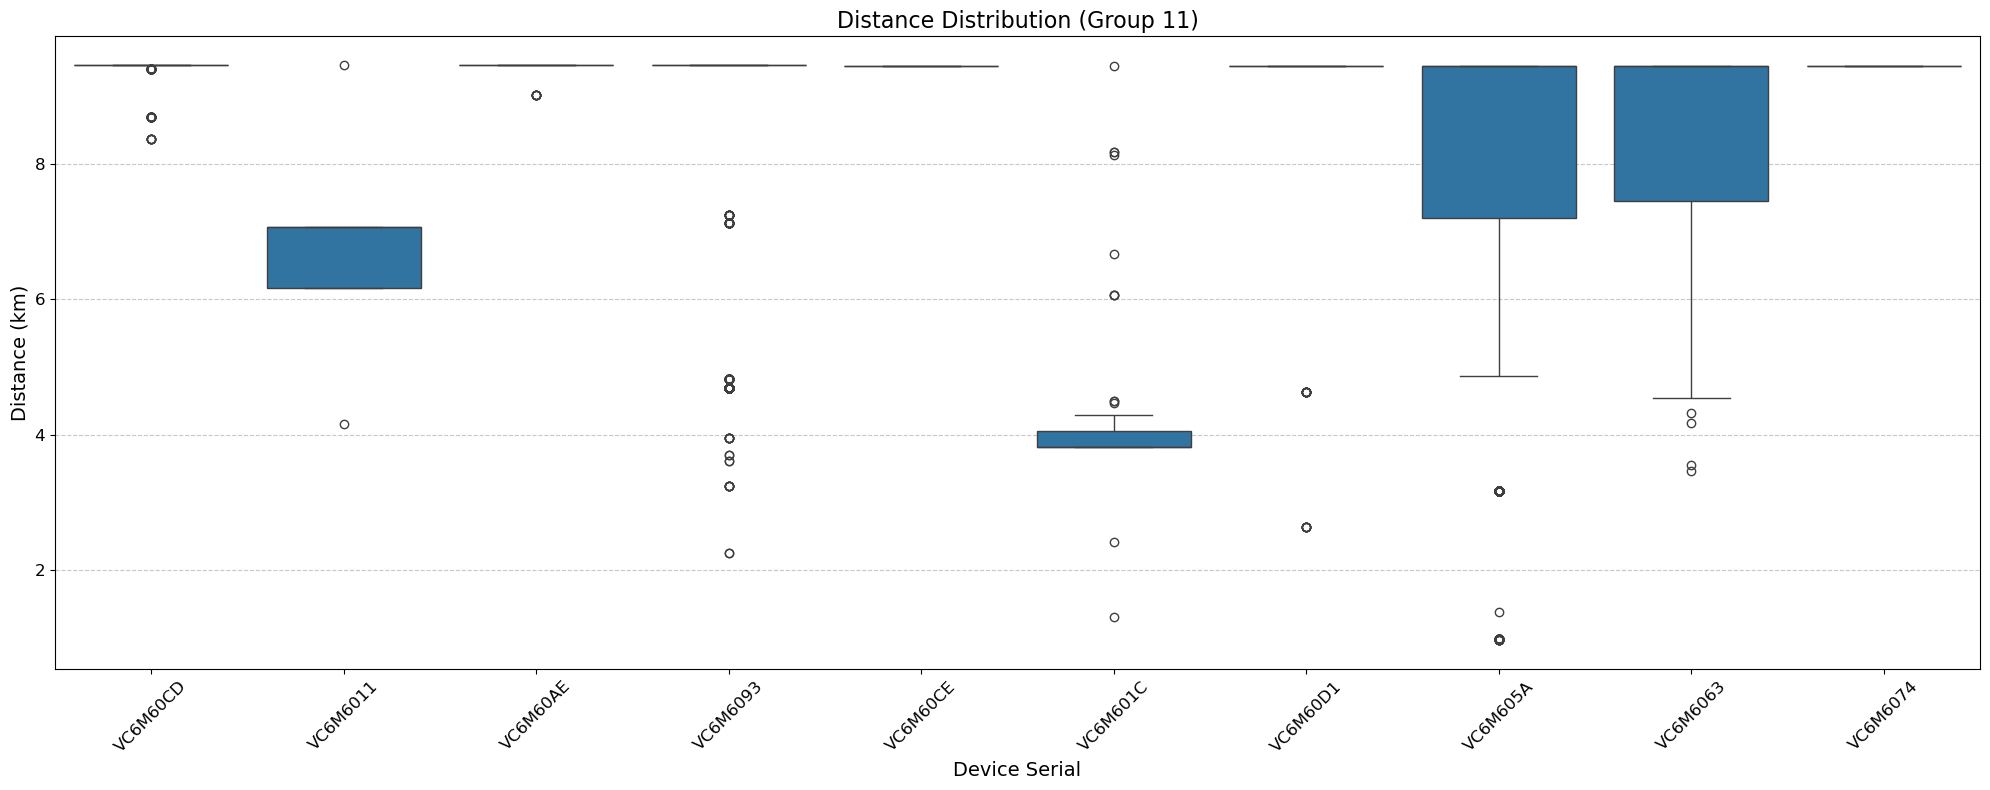


=== Group 11 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6011          5.0  6.79  1.91  4.16  6.17  7.07  7.07  9.46
VC6M601C         47.0  4.39  1.52  1.30  3.82  3.82  4.06  9.46
VC6M605A       1612.0  7.69  2.79  0.96  7.20  9.45  9.45  9.45
VC6M6063       5099.0  8.73  1.15  3.46  7.46  9.45  9.45  9.45
VC6M6074       1157.0  9.45  0.00  9.45  9.45  9.45  9.45  9.45
VC6M6093       1232.0  8.49  1.90  2.25  9.46  9.46  9.46  9.46
VC6M60AE        666.0  9.46  0.04  9.03  9.46  9.46  9.46  9.46
VC6M60CD       3087.0  9.45  0.10  8.37  9.46  9.46  9.46  9.46
VC6M60CE       2311.0  9.46  0.00  9.46  9.46  9.46  9.46  9.46
VC6M60D1       2182.0  9.40  0.52  2.63  9.45  9.45  9.45  9.45

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
V

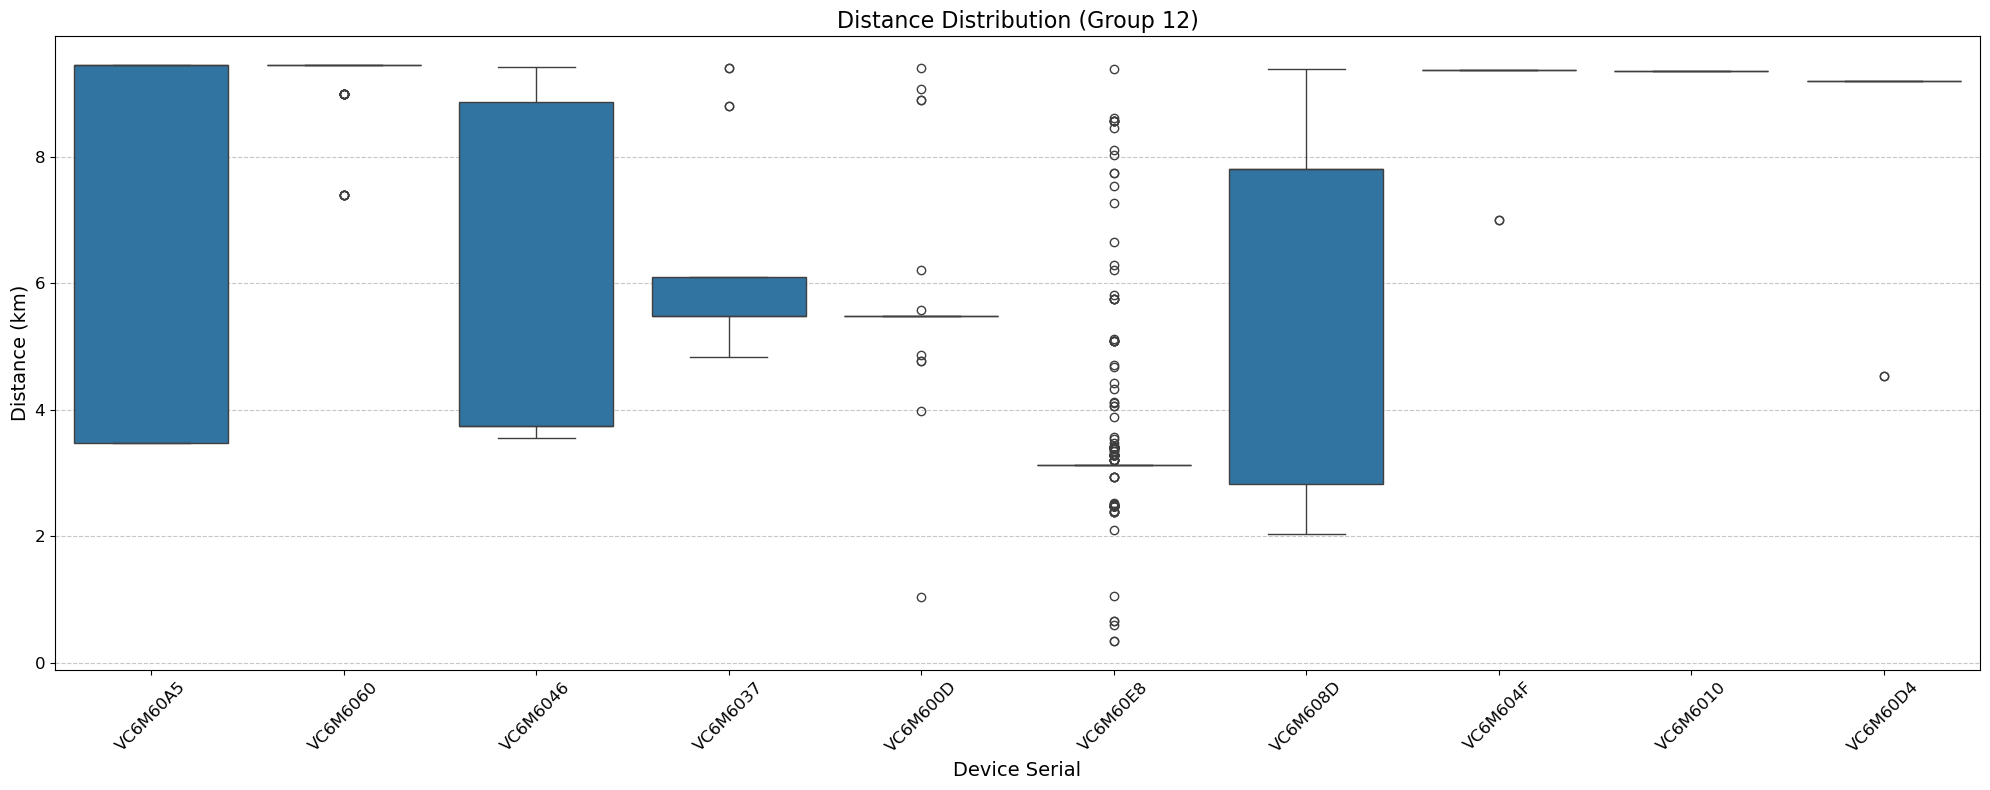


=== Group 12 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M600D         36.0  5.68  1.45  1.04  5.48  5.48  5.48  9.41
VC6M6010        145.0  9.36  0.00  9.36  9.36  9.36  9.36  9.36
VC6M6037         34.0  6.05  1.21  4.83  5.48  5.48  6.11  9.41
VC6M6046          9.0  5.85  2.64  3.55  3.74  3.74  8.87  9.42
VC6M604F        446.0  9.36  0.16  6.99  9.37  9.37  9.37  9.37
VC6M6060        672.0  9.42  0.20  7.39  9.44  9.44  9.44  9.44
VC6M608D        201.0  5.87  2.62  2.04  2.83  7.80  7.80  9.38
VC6M60A5       1974.0  7.43  2.83  3.47  3.47  9.45  9.45  9.45
VC6M60D4       1130.0  9.18  0.20  4.53  9.19  9.19  9.19  9.19
VC6M60E8        453.0  3.32  1.08  0.35  3.13  3.13  3.13  9.39

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
V

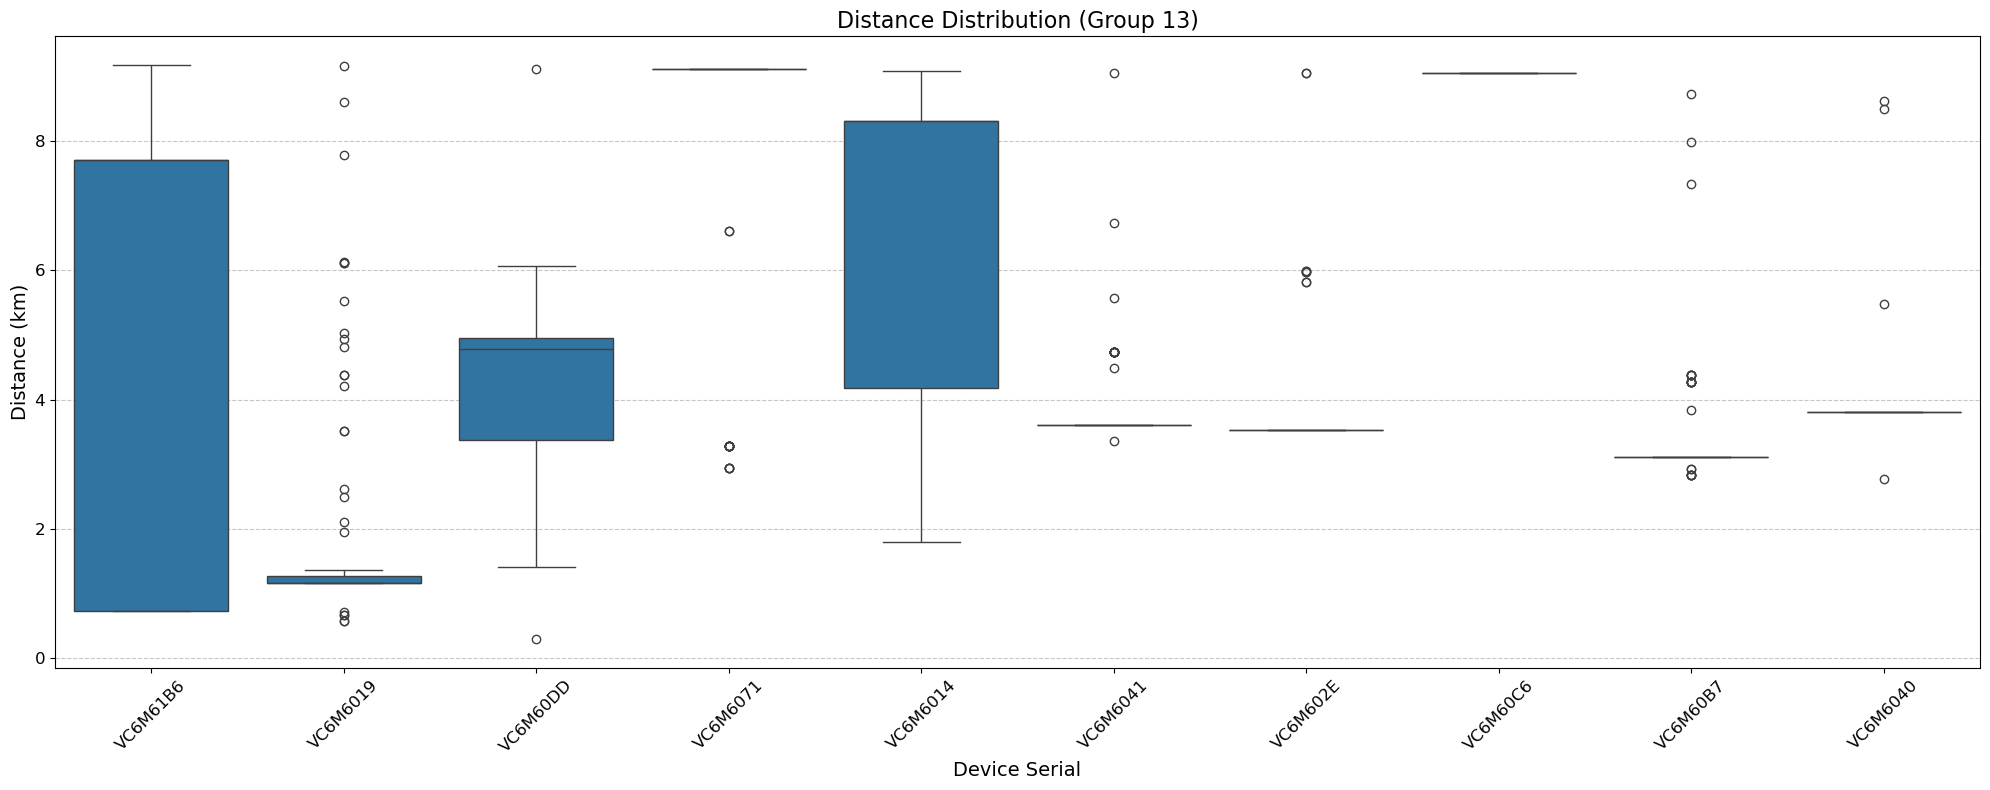


=== Group 13 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6014        157.0  7.05  2.03  1.80  4.19  8.32  8.32  9.08
VC6M6019        256.0  1.45  1.13  0.58  1.16  1.16  1.26  9.17
VC6M602E         97.0  3.80  0.96  3.54  3.54  3.54  3.54  9.05
VC6M6040        178.0  3.87  0.52  2.77  3.82  3.82  3.82  8.62
VC6M6041         89.0  3.89  0.77  3.36  3.61  3.61  3.61  9.06
VC6M6071       1006.0  9.02  0.70  2.95  9.11  9.11  9.11  9.11
VC6M60B7         66.0  3.54  1.11  2.83  3.11  3.11  3.11  8.73
VC6M60C6         24.0  9.05  0.00  9.05  9.05  9.05  9.05  9.05
VC6M60DD         13.0  4.32  2.21  0.29  3.38  4.78  4.95  9.12
VC6M61B6         35.0  5.30  3.61  0.72  0.72  7.70  7.70  9.18

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
V

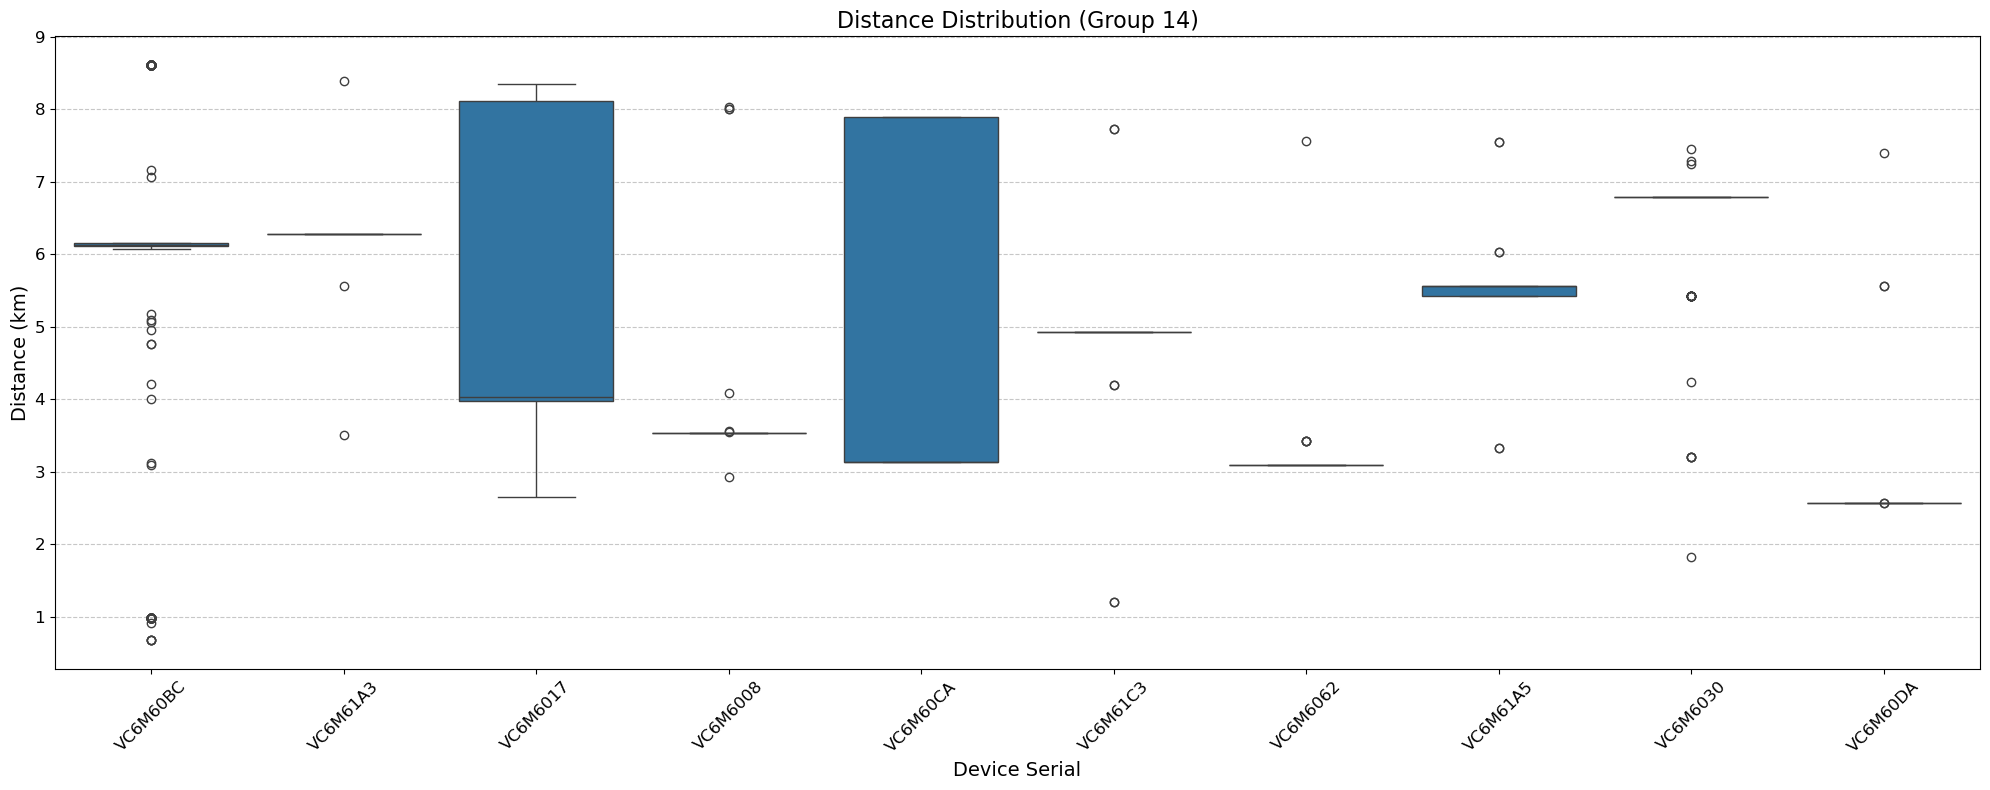


=== Group 14 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6008        76.0  3.71  0.88  2.93  3.53  3.53  3.53  8.03
VC6M6017        11.0  5.59  2.41  2.65  3.98  4.03  8.11  8.35
VC6M6030       117.0  6.46  0.91  1.82  6.80  6.80  6.80  7.46
VC6M6062       263.0  3.12  0.28  3.09  3.09  3.09  3.09  7.57
VC6M60BC       615.0  5.75  2.23  0.67  6.11  6.13  6.16  8.61
VC6M60CA       406.0  4.38  2.09  3.13  3.13  3.13  7.89  7.89
VC6M60DA        59.0  2.75  0.82  2.57  2.57  2.57  2.57  7.40
VC6M61A3        12.0  6.16  1.07  3.51  6.27  6.27  6.27  8.39
VC6M61A5        22.0  5.53  0.94  3.33  5.43  5.56  5.56  7.55
VC6M61C3        30.0  4.81  1.23  1.20  4.92  4.92  4.92  7.73

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC6M600A     

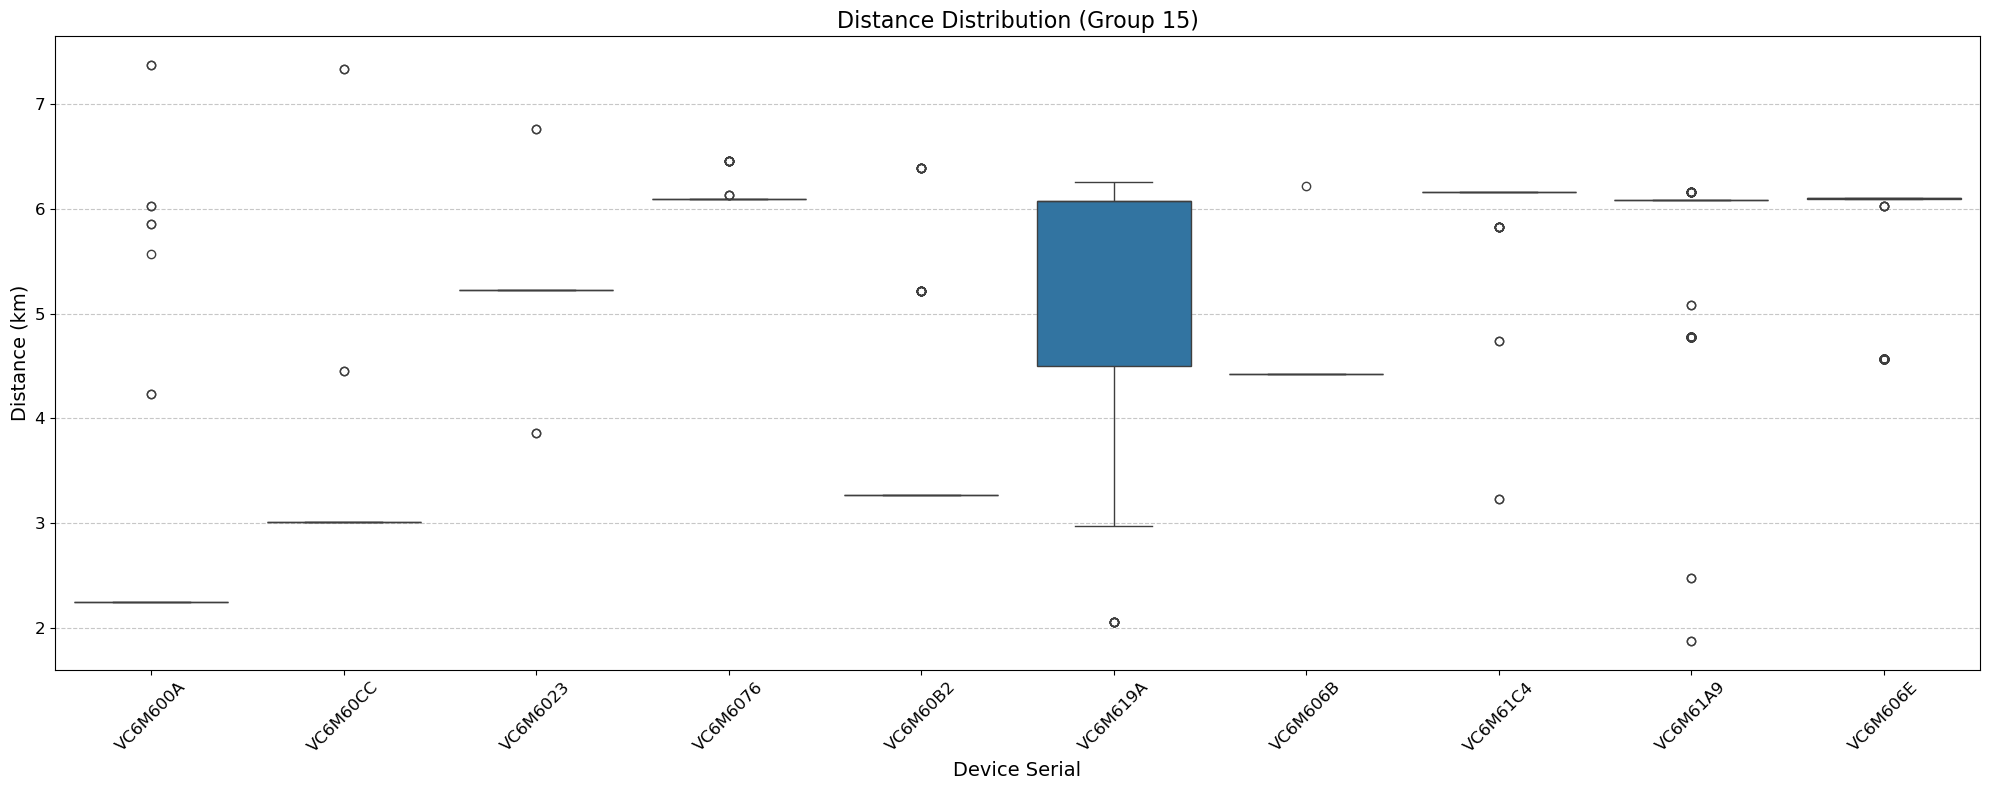


=== Group 15 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M600A        106.0  2.55  1.05  2.25  2.25  2.25  2.25  7.38
VC6M6023        114.0  5.23  0.27  3.86  5.23  5.23  5.23  6.76
VC6M606B          5.0  4.79  0.80  4.43  4.43  4.43  4.43  6.22
VC6M606E        342.0  5.84  0.58  4.57  6.10  6.11  6.11  6.11
VC6M6076        141.0  6.12  0.09  6.09  6.09  6.09  6.09  6.46
VC6M60B2       1357.0  3.30  0.29  3.27  3.27  3.27  3.27  6.39
VC6M60CC         32.0  3.37  1.10  3.01  3.01  3.01  3.01  7.34
VC6M619A        234.0  5.59  0.96  2.05  4.50  6.08  6.08  6.26
VC6M61A9        219.0  5.73  0.74  1.87  6.09  6.09  6.09  6.16
VC6M61C4        150.0  6.08  0.38  3.23  6.16  6.16  6.16  6.16

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
V

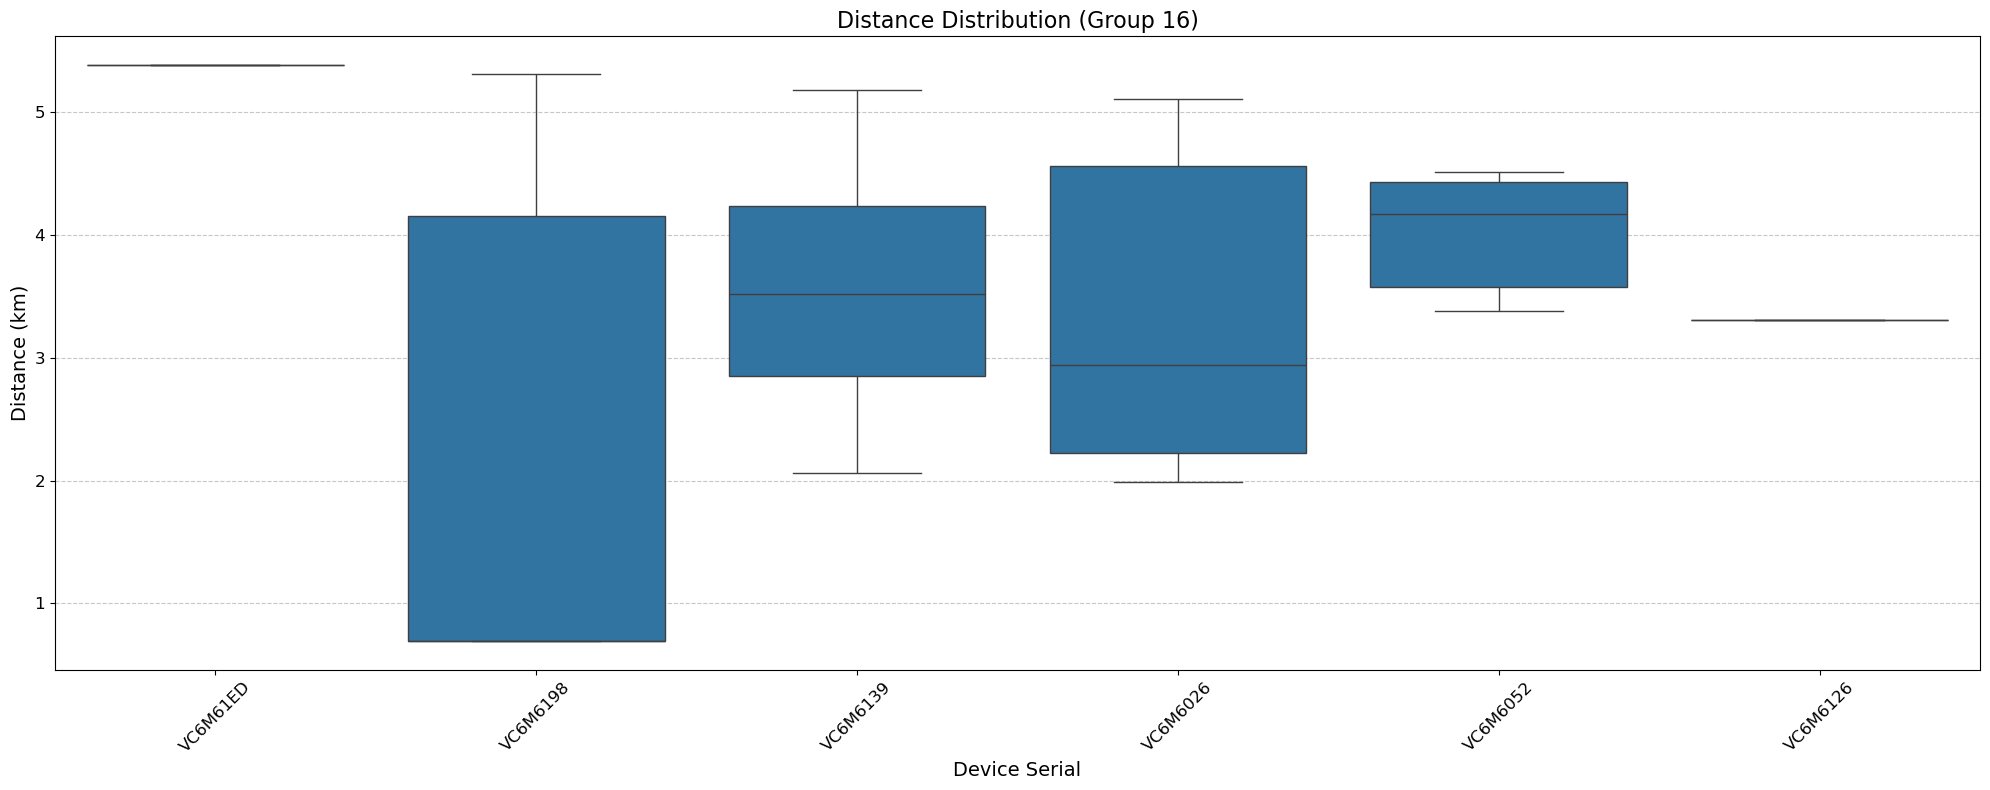


=== Group 16 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6026         6.0  3.34  1.43  1.99  2.23  2.94  4.56  5.10
VC6M6052         6.0  4.02  0.52  3.38  3.58  4.17  4.43  4.51
VC6M6126       378.0  3.30  0.00  3.30  3.30  3.30  3.30  3.30
VC6M6139         8.0  3.57  1.22  2.06  2.85  3.52  4.23  5.18
VC6M6198       100.0  2.16  1.71  0.70  0.70  0.70  4.15  5.31
VC6M61ED         2.0  5.38  0.00  5.38  5.38  5.38  5.38  5.38

추가 통계 정보:
                 분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC6M600A       1.11  0.00    106
...             ...   ...    ...
VC6M61C3       1.52  0.00     30
VC6M61C4       0.14  0.00    150
VC6M61ED       0.00  0.00      2
VC6ML002       1.37  0.00   1267
VC6ML003       2.47  0.27   1536

[156 rows x 3 columns]




In [9]:
# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    group_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    sns.boxplot(x='device_serial', y='distance_km', data=group_data)
    
    # 그래프 제목과 레이블 설정
    plt.title(f'Distance Distribution (Group {group_idx + 1})', fontsize=16)
    plt.xlabel('Device Serial', fontsize=14)
    plt.ylabel('Distance (km)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # 그리드 추가
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = group_data.groupby('device_serial')['distance_km'].describe().round(2)
    print(stats)

    # 1. 방법 1: 딕셔너리 형태로 변경
    additional_stats = df.groupby('device_serial').agg({
        'distance_km': ['var', 'count']
    }).round(2)

    # 2. 방법 2: 개별 통계량을 따로 계산
    additional_stats = pd.DataFrame({
        '분산': df.groupby('device_serial')['distance_km'].var(),
        'IQR': df.groupby('device_serial')['distance_km'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25)),
        '데이터 수': df.groupby('device_serial')['distance_km'].count()
    }).round(2)

    print("\n추가 통계 정보:")
    print(additional_stats)
    
    # # 추가 통계 정보 계산
    # additional_stats = group_data.groupby('device_serial')['distance_km'].agg({
    #     '분산': 'var',
    #     'IQR': lambda x: x.quantile(0.75) - x.quantile(0.25),
    #     '데이터 수': 'count'
    # }).round(2)
    
    # print("\n추가 통계 정보:")
    # print(additional_stats)
    print("\n" + "="*70 + "\n")

In [10]:
additional_stats

분산   IQR  데이터 수
device_serial                   
VC6M6002       1.03  0.36   1021
VC6M6003       3.02  0.78    830
VC6M6007       0.54  0.00   3923
VC6M6008       0.78  0.00     76
VC6M600A       1.11  0.00    106
...             ...   ...    ...
VC6M61C3       1.52  0.00     30
VC6M61C4       0.14  0.00    150
VC6M61ED       0.00  0.00      2
VC6ML002       1.37  0.00   1267
VC6ML003       2.47  0.27   1536

[156 rows x 3 columns]

### 하한값&상한값 지정을 위한 Temperature 분포 비교

In [11]:
print(df.isna().sum())

device_datetime_kor    0
device_serial          0
lat                    0
lon                    0
battery                0
temperature            0
humidity               0
acc_orig               0
acc                    0
accx                   0
accy                   0
accz                   0
tiltx                  0
tilty                  0
tiltz                  0
measure_date_kst       0
aws_station_id         0
aws_station_name       0
aws_lat                0
aws_lon                0
distance_km            0
ws1                    0
ws10                   0
ta                     0
hm                     0
dtype: int64


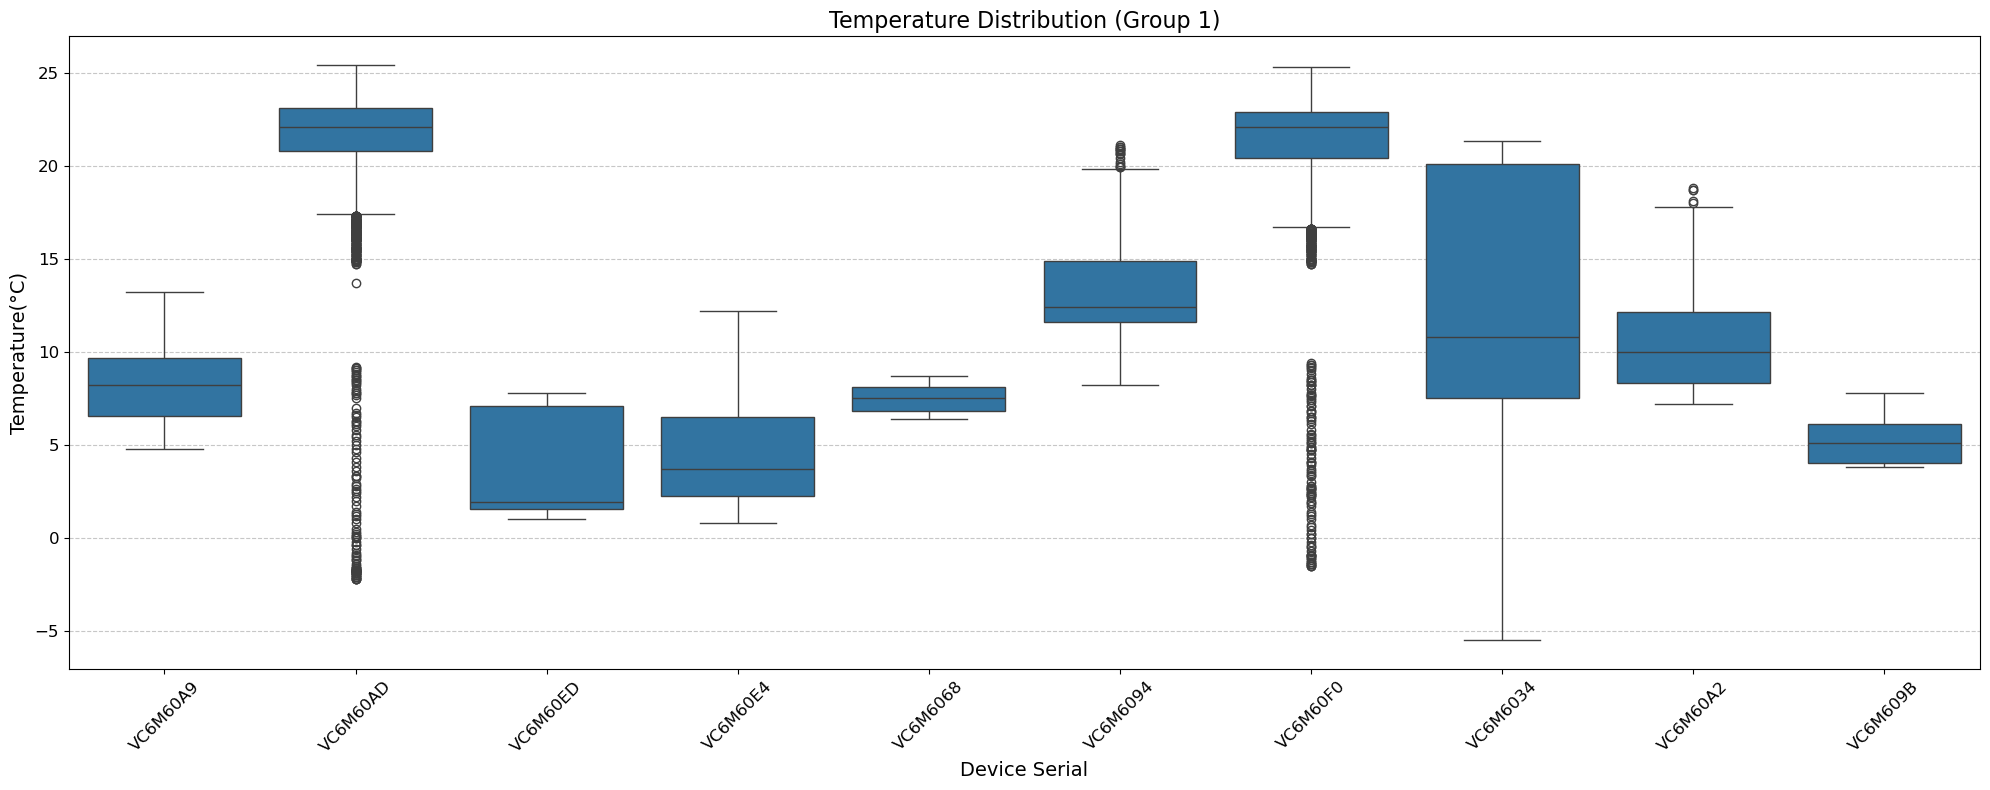


=== Group 1 통계량 ===
                count   mean   std  min    25%    50%    75%   max
device_serial                                                     
VC6M6034       1227.0  12.81  7.16 -5.5   7.50  10.80  20.10  21.3
VC6M6068         41.0   7.44  0.69  6.4   6.80   7.50   8.10   8.7
VC6M6094        257.0  13.32  2.99  8.2  11.60  12.40  14.90  21.1
VC6M609B         70.0   5.31  1.27  3.8   4.03   5.10   6.10   7.8
VC6M60A2        288.0  10.77  2.99  7.2   8.30  10.00  12.12  18.8
VC6M60A9        230.0   8.23  2.16  4.8   6.52   8.20   9.67  13.2
VC6M60AD       5275.0  21.41  3.34 -2.2  20.80  22.10  23.10  25.4
VC6M60E4         67.0   4.83  3.50  0.8   2.25   3.70   6.50  12.2
VC6M60ED         30.0   3.38  2.73  1.0   1.55   1.95   7.10   7.8
VC6M60F0       3749.0  21.11  3.58 -1.5  20.40  22.10  22.90  25.3

추가 통계 정보:
                 std  count  min   max   mean      Q1      Q3     IQR  \
device_serial                                                           
VC6M6034       51.

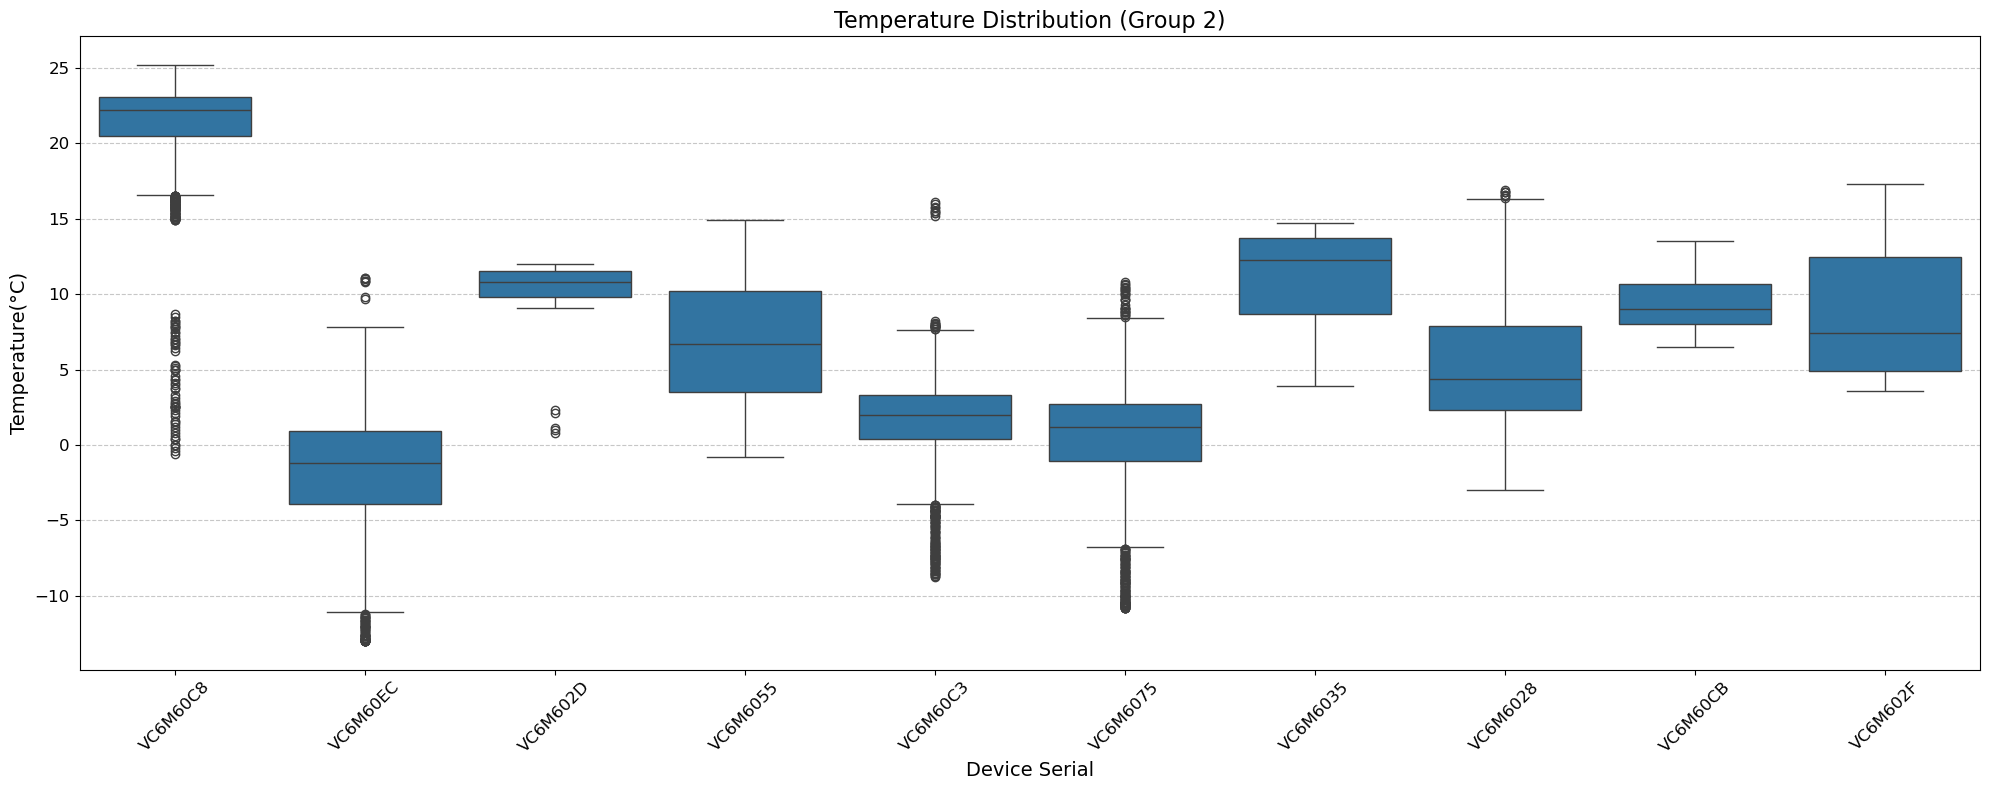


=== Group 2 통계량 ===
                count   mean   std   min   25%    50%    75%   max
device_serial                                                     
VC6M6028        690.0   5.12  4.14  -3.0   2.3   4.40   7.90  16.9
VC6M602D        104.0  10.30  2.19   0.8   9.8  10.80  11.52  12.0
VC6M602F        192.0   8.73  4.16   3.6   4.9   7.45  12.45  17.3
VC6M6035        160.0  11.04  3.17   3.9   8.7  12.30  13.70  14.7
VC6M6055        961.0   7.11  3.91  -0.8   3.5   6.70  10.20  14.9
VC6M6075       2927.0   0.53  3.67 -10.8  -1.1   1.20   2.70  10.8
VC6M60C3       2511.0   1.74  2.92  -8.8   0.4   2.00   3.30  16.1
VC6M60C8       4599.0  21.52  2.79  -0.6  20.5  22.20  23.10  25.2
VC6M60CB        171.0   9.46  2.04   6.5   8.0   9.00  10.70  13.5
VC6M60EC       1482.0  -1.49  4.38 -13.0  -3.9  -1.20   0.90  11.1

추가 통계 정보:
                 std  count   min   max   mean    Q1      Q3    IQR  \
device_serial                                                         
VC6M6028       17.17  

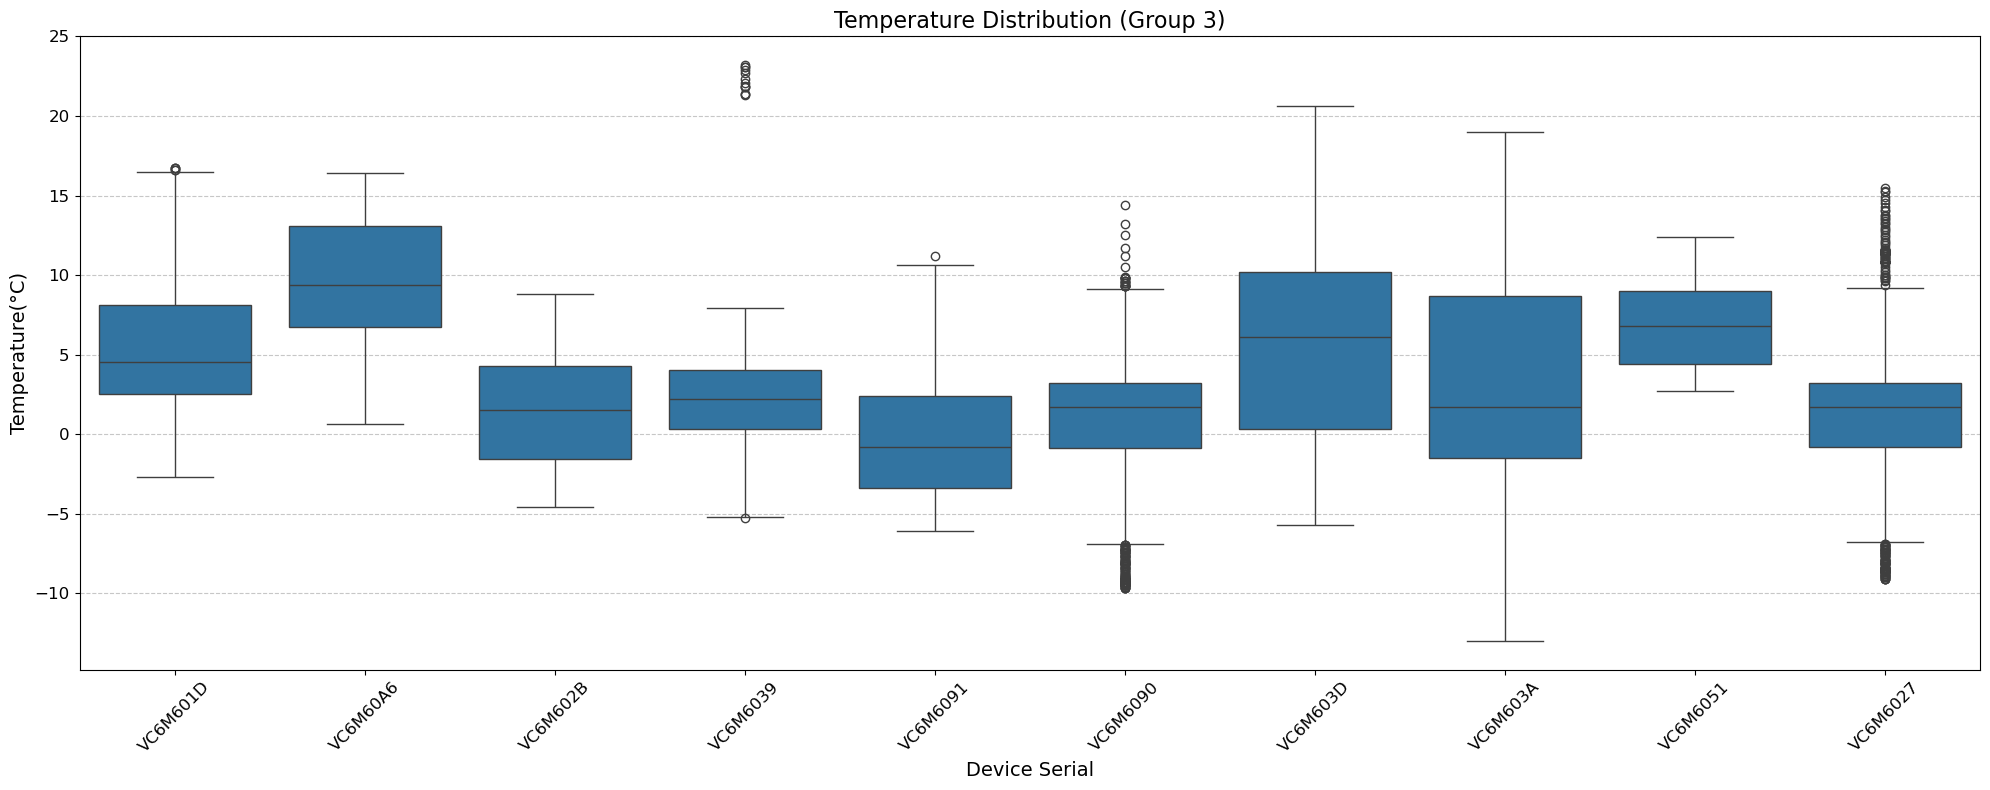


=== Group 3 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M601D        690.0  5.28  4.14  -2.7  2.50  4.55   8.1  16.7
VC6M6027       3735.0  1.14  3.69  -9.1 -0.80  1.70   3.2  15.5
VC6M602B        409.0  1.57  3.53  -4.6 -1.60  1.50   4.3   8.8
VC6M6039       1885.0  2.17  3.25  -5.3  0.30  2.20   4.0  23.2
VC6M603A       2832.0  3.16  6.91 -13.0 -1.50  1.70   8.7  19.0
VC6M603D       1197.0  5.65  6.20  -5.7  0.30  6.10  10.2  20.6
VC6M6051        201.0  6.88  2.89   2.7  4.40  6.80   9.0  12.4
VC6M6090       3831.0  1.03  3.63  -9.7 -0.85  1.70   3.2  14.4
VC6M6091        598.0 -0.49  3.52  -6.1 -3.40 -0.80   2.4  11.2
VC6M60A6        528.0  9.39  4.00   0.6  6.70  9.40  13.1  16.4

추가 통계 정보:
                 std  count   min   max  mean    Q1    Q3    IQR  \
device_serial                                                      
VC6M601D       17.15    690  -2.7  16.7  5.28  2.50   8.1   5.60

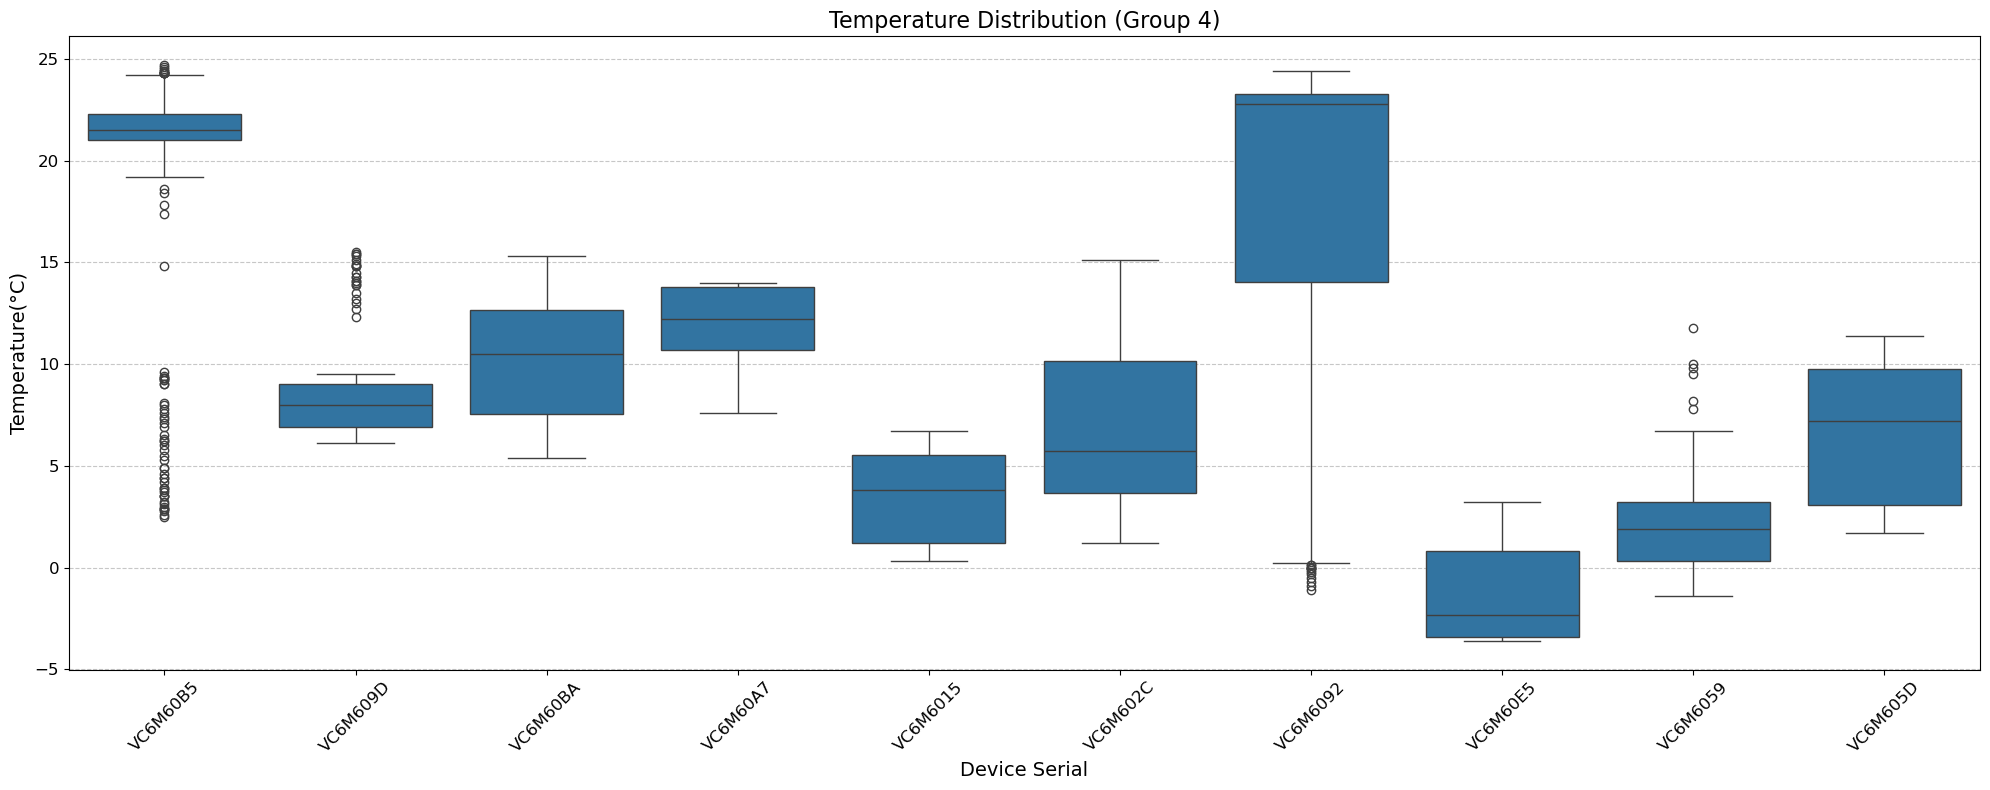


=== Group 4 통계량 ===
               count   mean   std  min    25%    50%    75%   max
device_serial                                                    
VC6M6015        88.0   3.37  2.06  0.3   1.20   3.80   5.52   6.7
VC6M602C       126.0   6.80  3.85  1.2   3.65   5.75  10.15  15.1
VC6M6059       415.0   1.95  2.04 -1.4   0.30   1.90   3.20  11.8
VC6M605D       227.0   6.48  3.20  1.7   3.05   7.20   9.75  11.4
VC6M6092       199.0  18.33  8.10 -1.1  14.05  22.80  23.30  24.4
VC6M609D       109.0   8.88  2.87  6.1   6.90   8.00   9.00  15.5
VC6M60A7       204.0  11.95  1.82  7.6  10.70  12.20  13.80  14.0
VC6M60B5       826.0  20.82  3.91  2.5  21.00  21.50  22.30  24.7
VC6M60BA       110.0  10.29  3.03  5.4   7.55  10.50  12.68  15.3
VC6M60E5        46.0  -1.31  2.36 -3.6  -3.40  -2.35   0.82   3.2

추가 통계 정보:
                 std  count  min   max   mean     Q1      Q3    IQR  \
device_serial                                                         
VC6M6015        4.24     88  0.3  

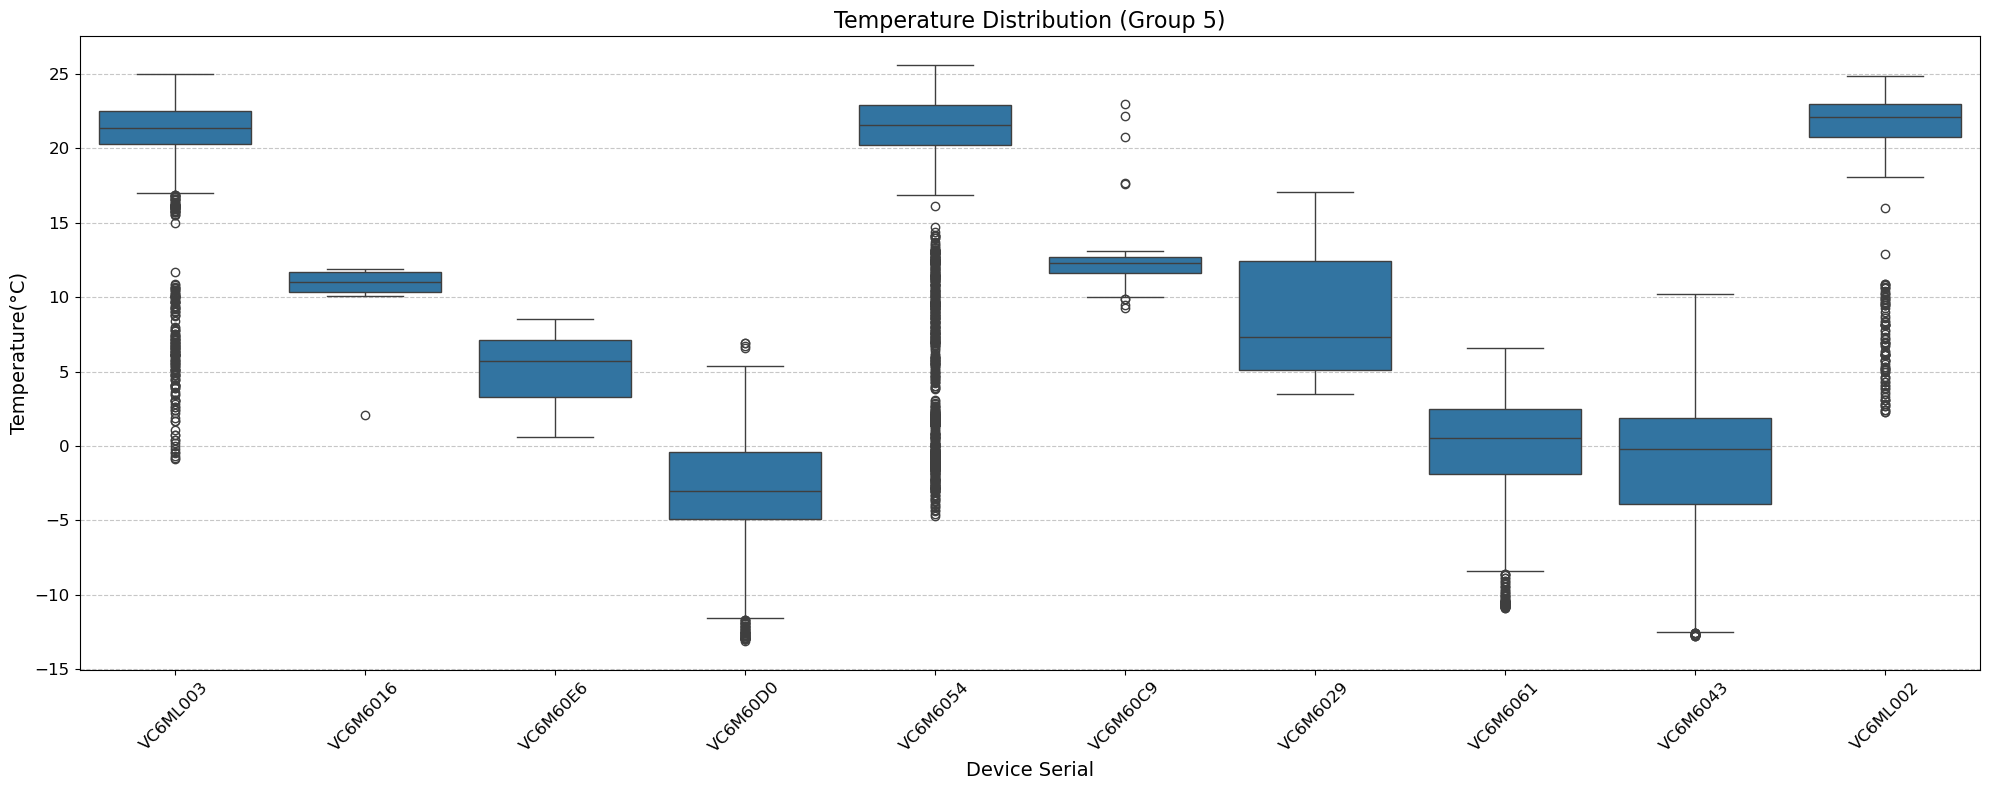


=== Group 5 통계량 ===
                count   mean   std   min    25%    50%    75%   max
device_serial                                                      
VC6M6016         14.0  10.45  2.49   2.1  10.35  11.05  11.68  11.9
VC6M6029        192.0   8.73  4.13   3.5   5.10   7.35  12.42  17.1
VC6M6043       1662.0  -0.79  4.68 -12.8  -3.90  -0.20   1.88  10.2
VC6M6054       2767.0  18.14  8.10  -4.7  20.20  21.60  22.90  25.6
VC6M6061       2820.0   0.09  3.36 -10.9  -1.90   0.50   2.50   6.6
VC6M60C9         96.0  12.43  2.10   9.3  11.60  12.30  12.70  23.0
VC6M60D0       1059.0  -3.12  3.65 -13.1  -4.90  -3.00  -0.40   6.9
VC6M60E6        583.0   5.21  2.10   0.6   3.30   5.70   7.10   8.5
VC6ML002       1267.0  21.04  4.19   2.3  20.80  22.10  23.00  24.9
VC6ML003       1536.0  19.98  4.93  -0.9  20.30  21.40  22.50  25.0

추가 통계 정보:
                 std  count   min   max   mean     Q1      Q3    IQR  \
device_serial                                                          
VC6M6016

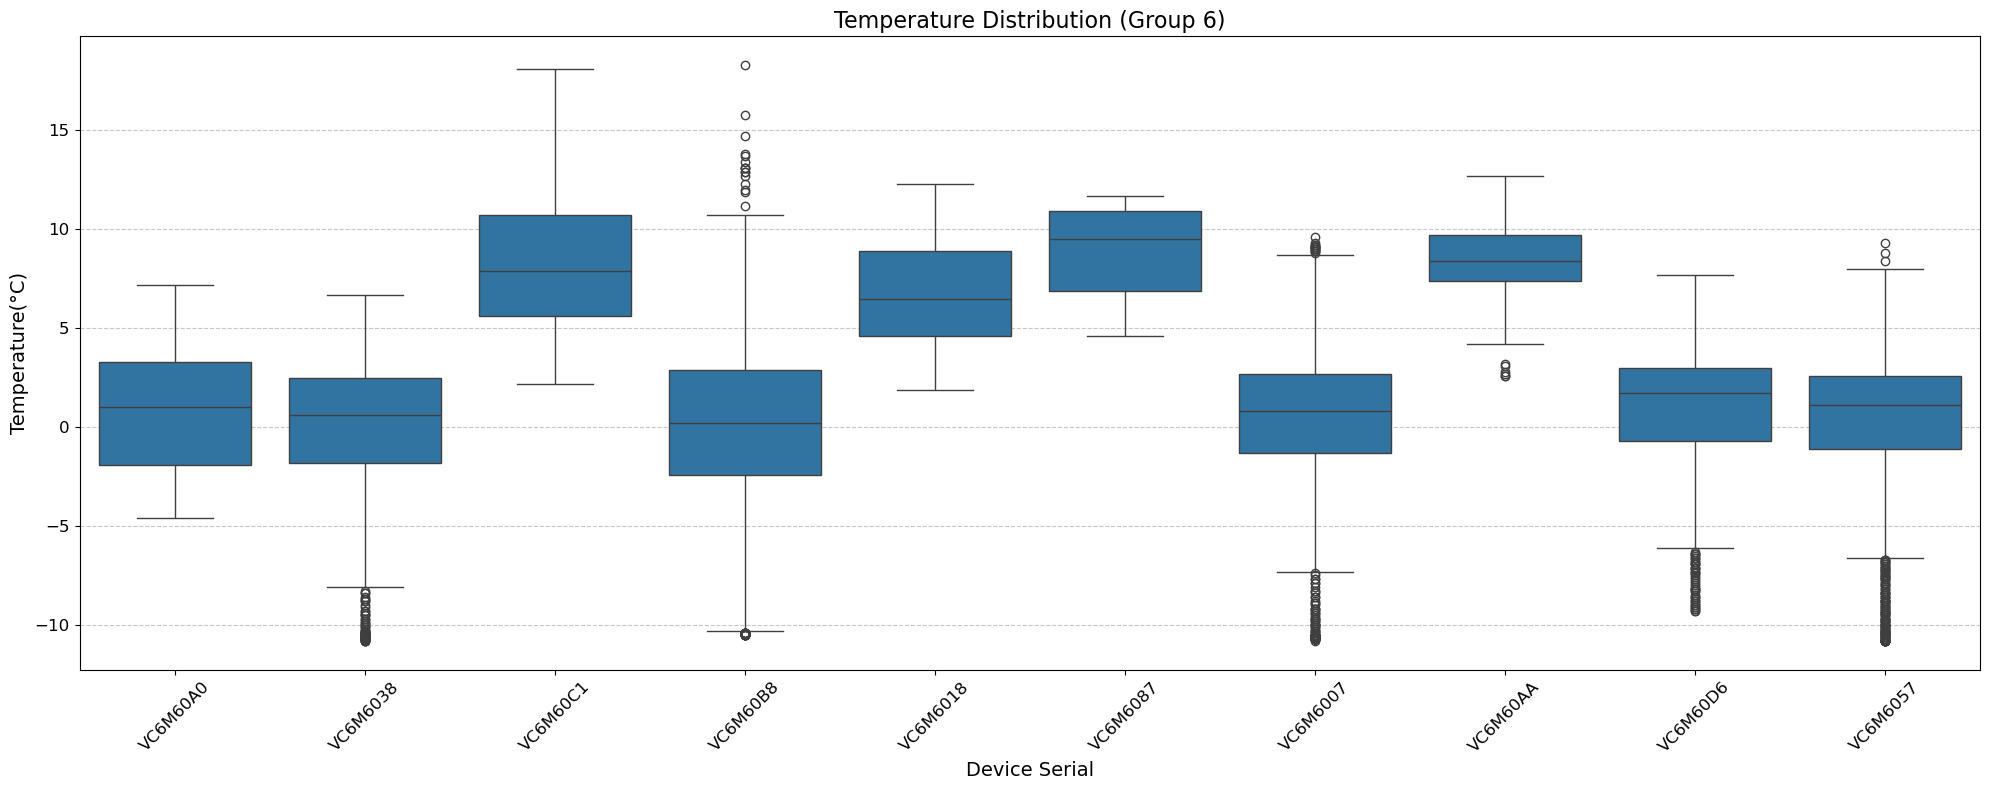


=== Group 6 통계량 ===
                count  mean   std   min  25%  50%   75%   max
device_serial                                                
VC6M6007       3923.0  0.56  3.28 -10.8 -1.3  0.8   2.7   9.6
VC6M6018        792.0  6.66  2.69   1.9  4.6  6.5   8.9  12.3
VC6M6038       2879.0  0.11  3.33 -10.8 -1.8  0.6   2.5   6.7
VC6M6057       3056.0  0.45  3.49 -10.8 -1.1  1.1   2.6   9.3
VC6M6087        140.0  8.96  2.07   4.6  6.9  9.5  10.9  11.7
VC6M60A0        606.0  0.71  3.04  -4.6 -1.9  1.0   3.3   7.2
VC6M60AA        233.0  8.61  1.95   2.6  7.4  8.4   9.7  12.7
VC6M60B8       2595.0  0.27  3.93 -10.5 -2.4  0.2   2.9  18.3
VC6M60C1        690.0  8.33  3.83   2.2  5.6  7.9  10.7  18.1
VC6M60D6       2051.0  1.09  2.94  -9.3 -0.7  1.7   3.0   7.7

추가 통계 정보:
                 std  count   min   max  mean   Q1    Q3  IQR  Whisker Start  \
device_serial                                                                  
VC6M6007       10.74   3923 -10.8   9.6  0.56 -1.3   2.7  4.0   

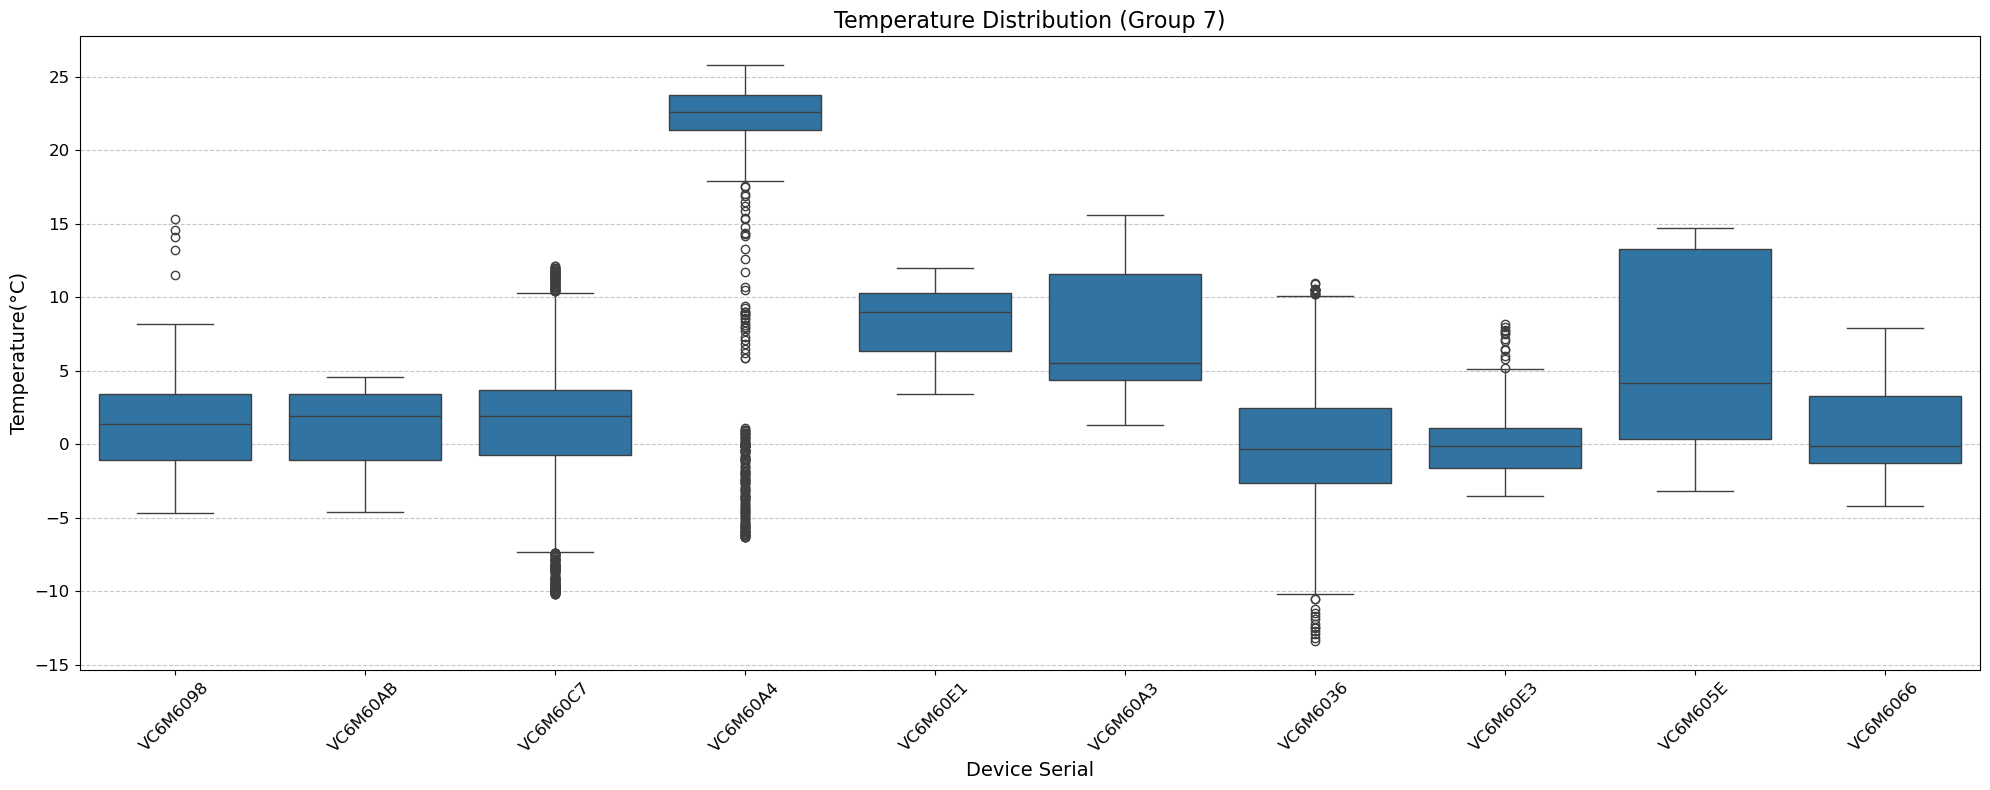


=== Group 7 통계량 ===
                count   mean   std   min    25%    50%    75%   max
device_serial                                                      
VC6M6036       1114.0  -0.20  3.66 -13.4  -2.60  -0.30   2.50  11.0
VC6M605E        254.0   6.53  6.50  -3.2   0.35   4.20  13.28  14.7
VC6M6066        239.0   0.87  3.31  -4.2  -1.30  -0.10   3.30   7.9
VC6M6098       1033.0   1.30  3.13  -4.7  -1.10   1.40   3.40  15.3
VC6M60A3        144.0   7.44  4.17   1.3   4.38   5.50  11.60  15.6
VC6M60A4        978.0  18.49  9.62  -6.3  21.40  22.60  23.80  25.8
VC6M60AB        354.0   1.06  2.69  -4.6  -1.10   1.95   3.40   4.6
VC6M60C7       3228.0   1.45  4.09 -10.2  -0.70   1.90   3.70  12.1
VC6M60E1         26.0   8.39  2.51   3.4   6.35   9.00  10.28  12.0
VC6M60E3        249.0   0.08  2.33  -3.5  -1.60  -0.10   1.10   8.2

추가 통계 정보:
                 std  count   min   max   mean      Q1      Q3     IQR  \
device_serial                                                            
VC6M

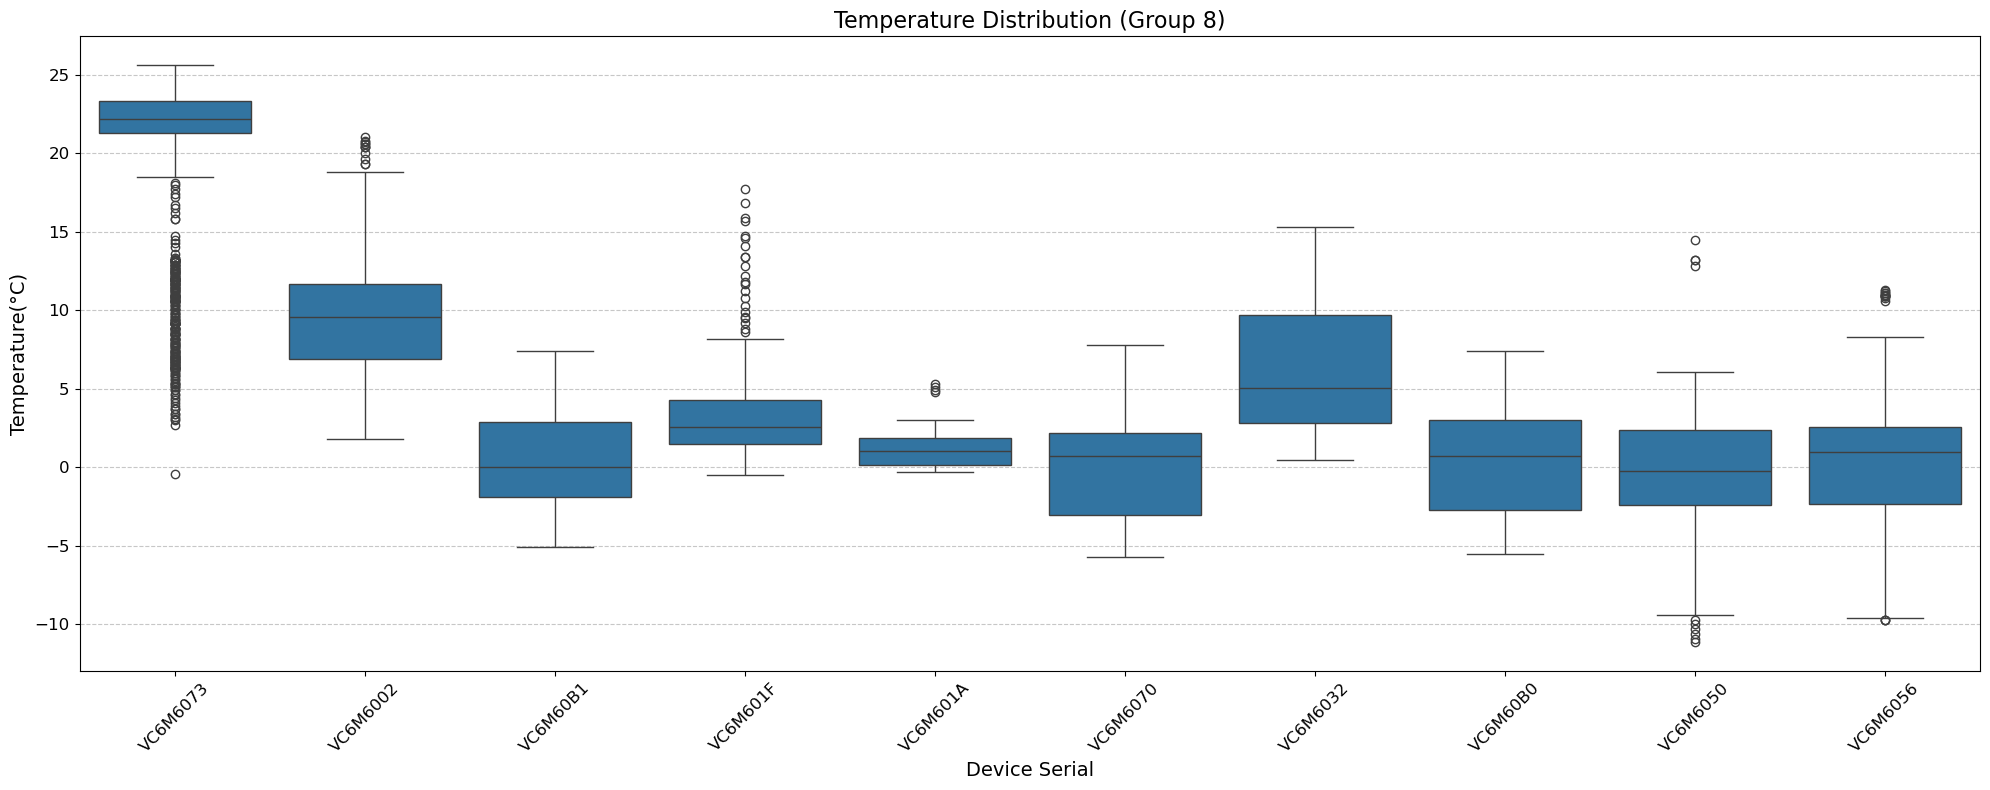


=== Group 8 통계량 ===
                count   mean   std   min    25%    50%    75%   max
device_serial                                                      
VC6M6002       1021.0   9.36  3.40   1.8   6.90   9.60  11.70  21.0
VC6M601A         58.0   1.25  1.36  -0.3   0.15   1.05   1.88   5.3
VC6M601F        400.0   3.27  2.84  -0.5   1.50   2.60   4.30  17.7
VC6M6032        120.0   6.30  4.15   0.5   2.80   5.05   9.72  15.3
VC6M6050       1096.0  -0.19  3.09 -11.1  -2.40  -0.20   2.40  14.5
VC6M6056       4039.0   0.31  3.51  -9.7  -2.30   1.00   2.60  11.3
VC6M6070        575.0   0.08  3.39  -5.7  -3.00   0.70   2.20   7.8
VC6M6073       2161.0  20.88  4.60  -0.4  21.30  22.20  23.30  25.6
VC6M60B0        606.0   0.26  3.31  -5.5  -2.70   0.75   3.00   7.4
VC6M60B1        294.0   0.39  3.28  -5.1  -1.90   0.00   2.90   7.4

추가 통계 정보:
                 std  count   min   max   mean     Q1      Q3    IQR  \
device_serial                                                          
VC6M6002

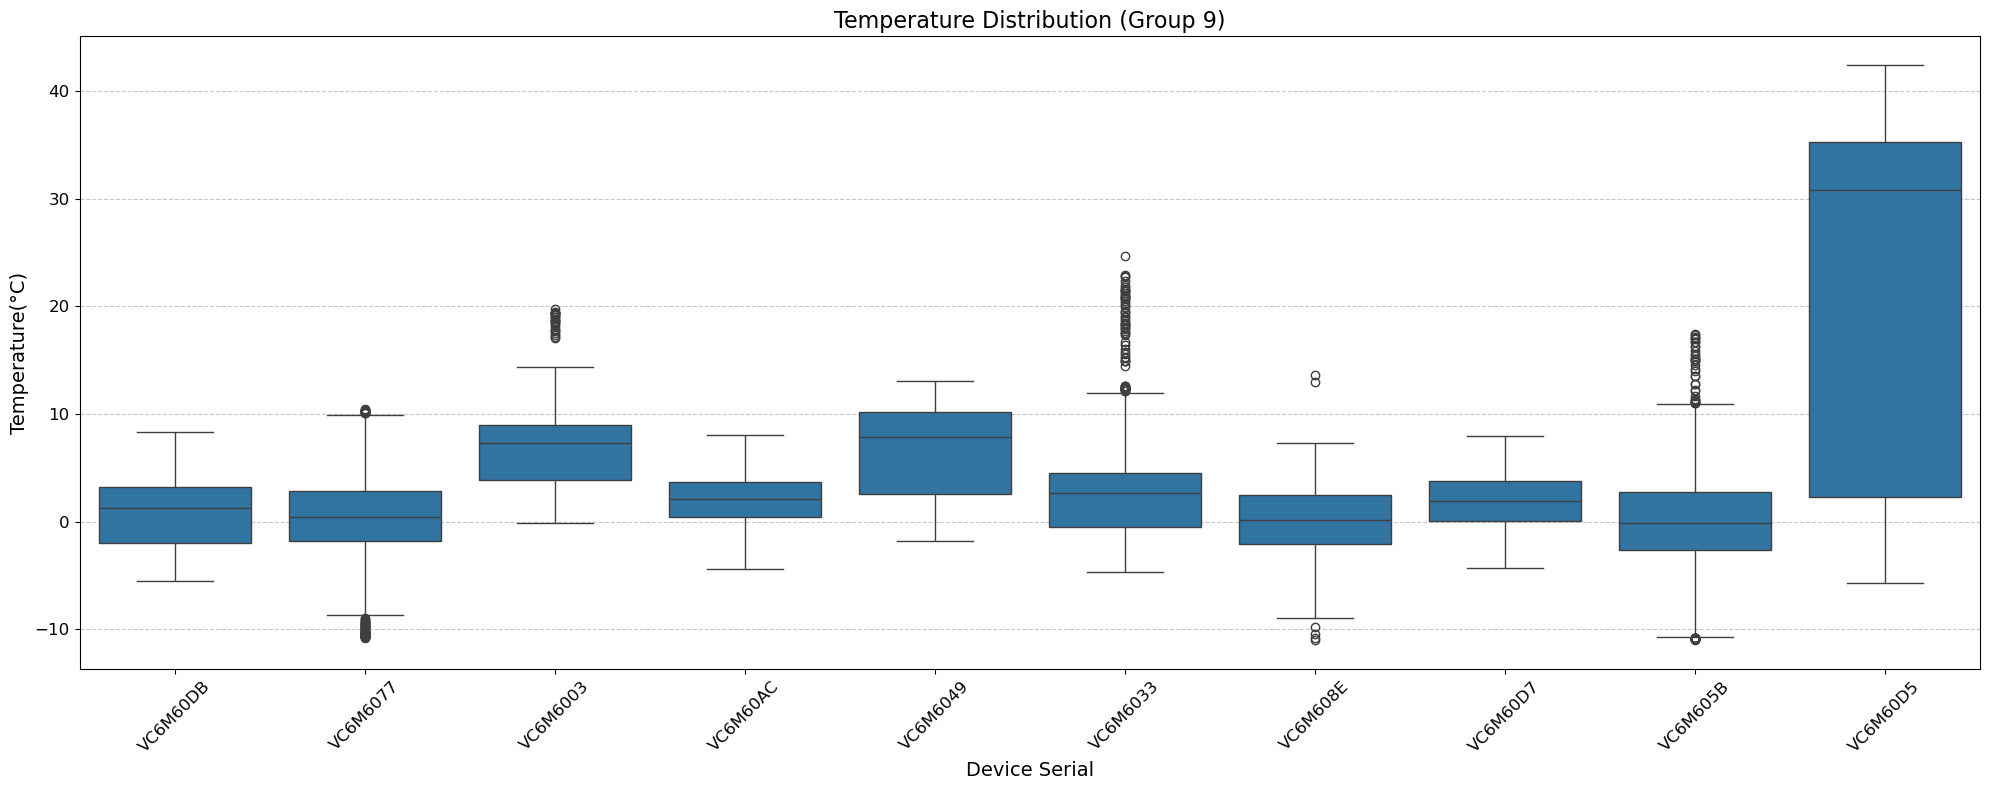


=== Group 9 통계량 ===
                count   mean    std   min  25%    50%   75%   max
device_serial                                                    
VC6M6003        830.0   6.83   3.74  -0.1  3.9   7.30   9.0  19.8
VC6M6033       1285.0   2.93   5.02  -4.7 -0.5   2.70   4.5  24.7
VC6M6049        707.0   6.71   4.00  -1.8  2.6   7.90  10.2  13.1
VC6M605B       3487.0   0.14   4.00 -11.0 -2.6  -0.10   2.8  17.4
VC6M6077       2004.0   0.56   3.98 -10.8 -1.8   0.40   2.9  10.5
VC6M608E       1434.0   0.10   3.05 -11.0 -2.1   0.20   2.5  13.6
VC6M60AC       1881.0   2.11   2.34  -4.4  0.4   2.10   3.7   8.1
VC6M60D5       1650.0  19.84  17.47  -5.7  2.3  30.80  35.3  42.4
VC6M60D7       1707.0   2.06   2.56  -4.3  0.1   1.90   3.8   8.0
VC6M60DB       1020.0   0.73   3.34  -5.5 -2.0   1.25   3.2   8.3

추가 통계 정보:
                  std  count   min   max   mean   Q1    Q3   IQR  \
device_serial                                                      
VC6M6003        14.00    830  -0.1  19.8

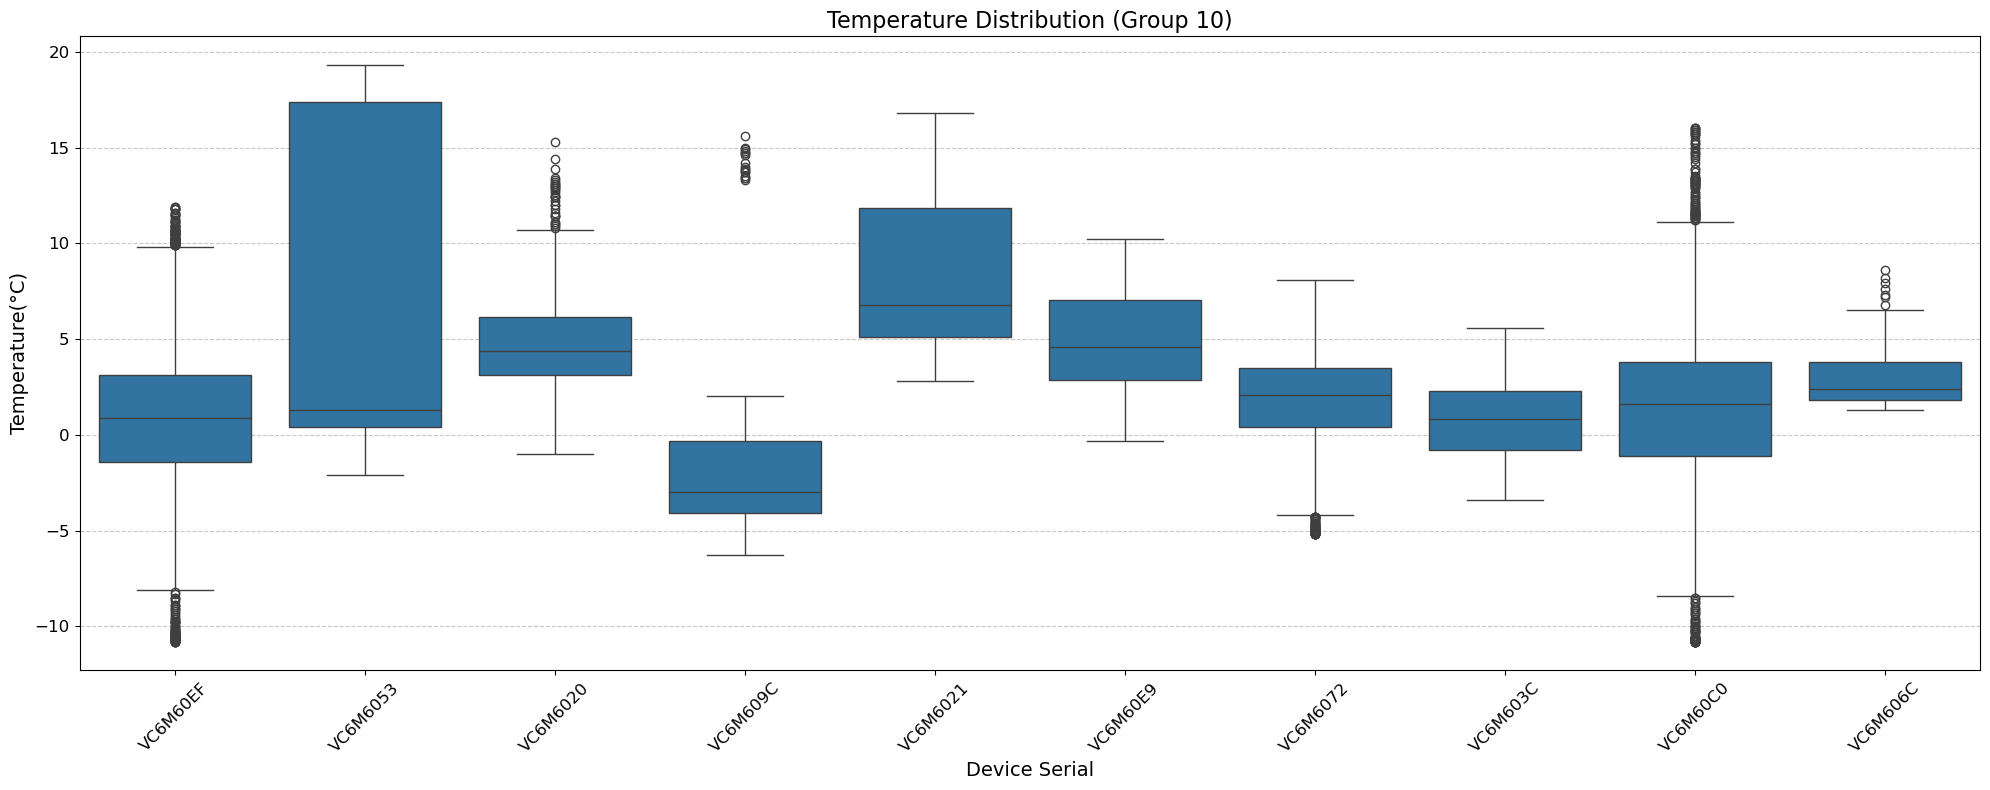


=== Group 10 통계량 ===
                count  mean   std   min   25%  50%    75%   max
device_serial                                                  
VC6M6020        691.0  4.80  2.82  -1.0  3.10  4.4   6.15  15.3
VC6M6021        200.0  8.44  4.14   2.8  5.10  6.8  11.85  16.8
VC6M603C       1253.0  0.92  2.06  -3.4 -0.80  0.8   2.30   5.6
VC6M6053        405.0  6.88  8.49  -2.1  0.40  1.3  17.40  19.3
VC6M606C        197.0  2.90  1.48   1.3  1.80  2.4   3.80   8.6
VC6M6072       2409.0  1.94  2.55  -5.2  0.40  2.1   3.50   8.1
VC6M609C        431.0 -1.91  3.91  -6.3 -4.10 -3.0  -0.30  15.6
VC6M60C0       3744.0  1.55  4.33 -10.8 -1.10  1.6   3.80  16.0
VC6M60E9        412.0  4.82  2.52  -0.3  2.88  4.6   7.02  10.2
VC6M60EF       4031.0  0.93  3.83 -10.8 -1.40  0.9   3.10  11.9

추가 통계 정보:
                 std  count   min   max  mean     Q1      Q3    IQR  \
device_serial                                                         
VC6M6020        7.94    691  -1.0  15.3  4.80  3.100   6.

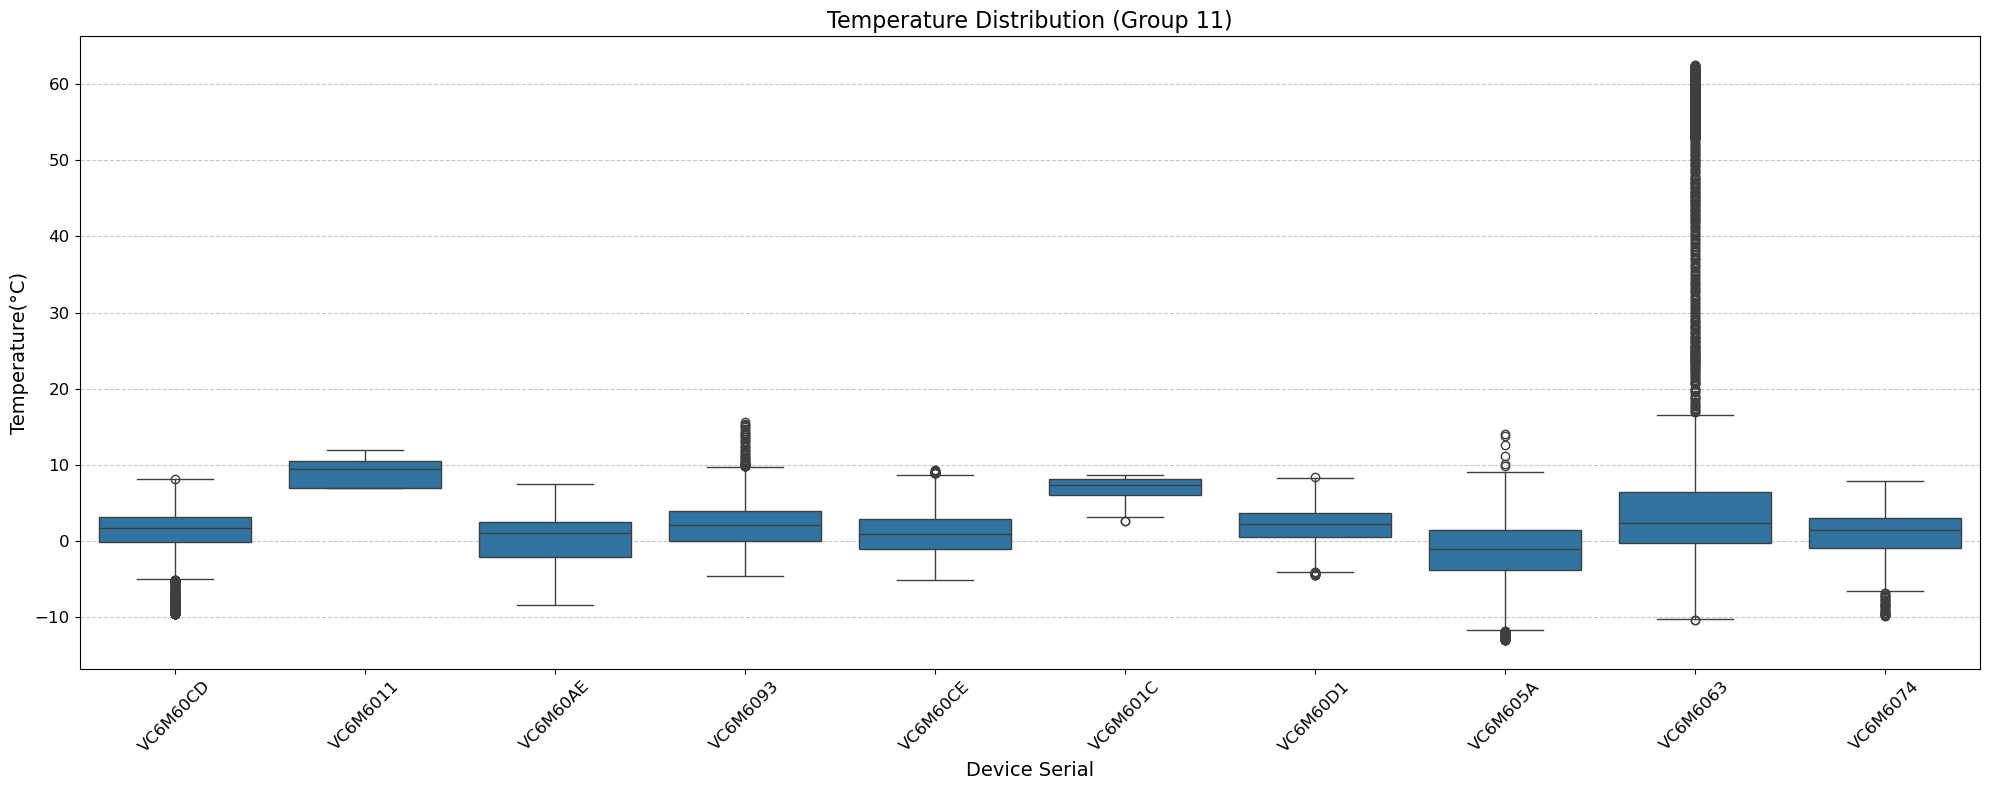


=== Group 11 통계량 ===
                count   mean    std   min   25%   50%    75%   max
device_serial                                                     
VC6M6011          5.0   9.16   2.16   7.0  7.00  9.40  10.50  11.9
VC6M601C         47.0   6.93   1.54   2.7  6.05  7.40   8.15   8.7
VC6M605A       1612.0  -1.26   4.26 -13.0 -3.80 -1.00   1.50  14.0
VC6M6063       5099.0  11.93  21.69 -10.4 -0.20  2.40   6.50  62.5
VC6M6074       1157.0   0.79   3.41  -9.9 -0.90  1.40   3.00   7.9
VC6M6093       1232.0   2.35   3.56  -4.6  0.00  2.10   3.90  15.6
VC6M60AE        666.0   0.45   3.25  -8.4 -2.10  1.05   2.50   7.5
VC6M60CD       3087.0   1.30   3.20  -9.6 -0.10  1.70   3.20   8.2
VC6M60CE       2311.0   1.02   2.88  -5.1 -1.00  0.90   2.90   9.3
VC6M60D1       2182.0   2.19   2.36  -4.4  0.60  2.20   3.70   8.4

추가 통계 정보:
                  std  count   min   max   mean    Q1     Q3  IQR  \
device_serial                                                       
VC6M6011         4.67    

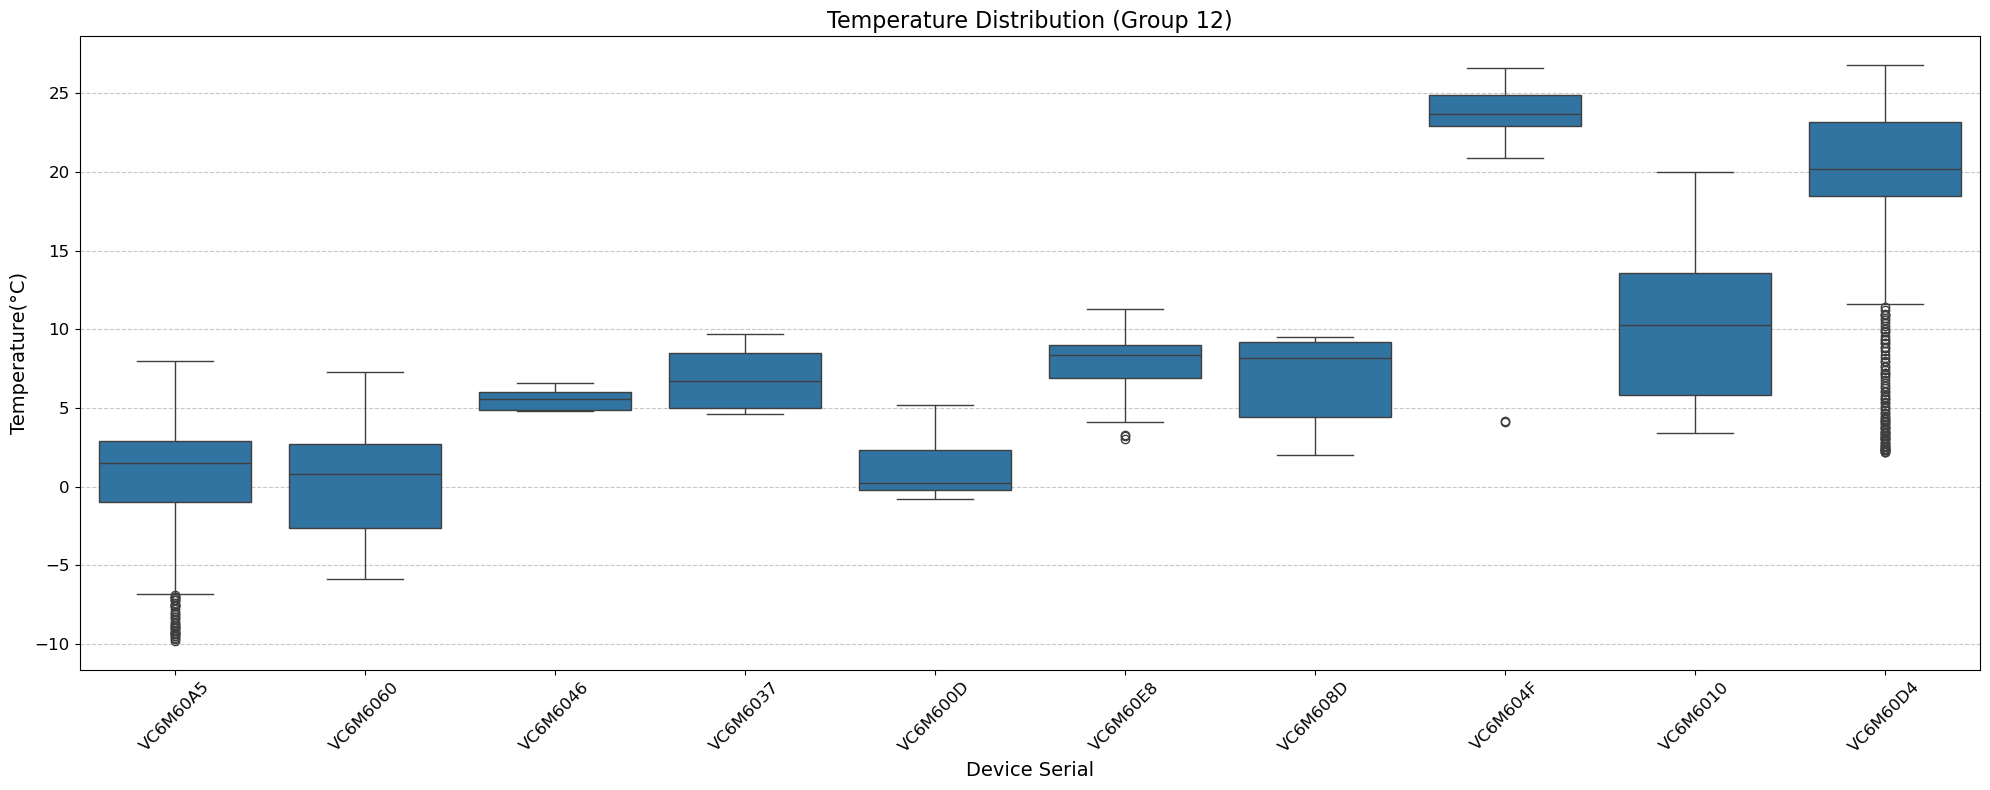


=== Group 12 통계량 ===
                count   mean   std  min   25%    50%    75%   max
device_serial                                                    
VC6M600D         36.0   0.97  1.64 -0.8  -0.2   0.25   2.35   5.2
VC6M6010        145.0   9.97  4.38  3.4   5.8  10.30  13.60  20.0
VC6M6037         34.0   6.71  1.70  4.6   5.0   6.70   8.50   9.7
VC6M6046          9.0   5.56  0.66  4.8   4.9   5.60   6.00   6.6
VC6M604F        446.0  23.75  1.93  4.1  22.9  23.70  24.90  26.6
VC6M6060        672.0   0.17  3.31 -5.9  -2.6   0.80   2.70   7.3
VC6M608D        201.0   6.90  2.67  2.0   4.4   8.20   9.20   9.5
VC6M60A5       1974.0   0.88  3.14 -9.8  -1.0   1.50   2.90   8.0
VC6M60D4       1130.0  19.73  5.21  2.2  18.5  20.20  23.20  26.8
VC6M60E8        453.0   7.93  1.61  3.0   6.9   8.40   9.00  11.3

추가 통계 정보:
                 std  count  min   max   mean    Q1     Q3   IQR  \
device_serial                                                      
VC6M600D        2.68     36 -0.8   5.2 

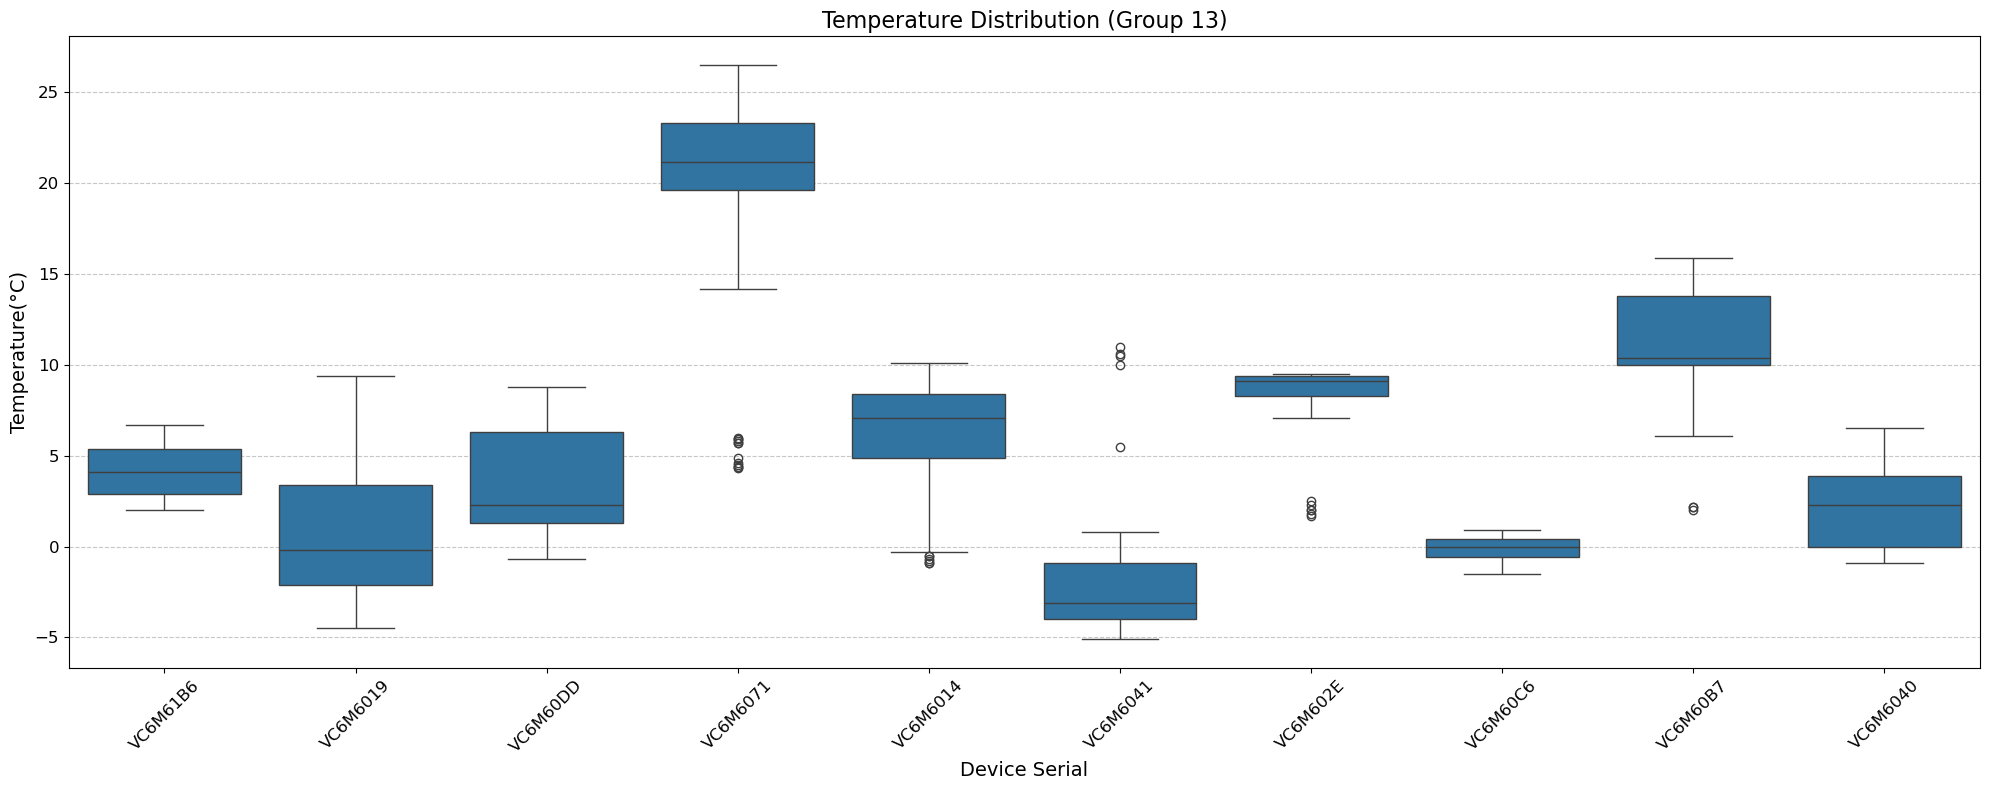


=== Group 13 통계량 ===
                count   mean   std  min    25%    50%    75%   max
device_serial                                                     
VC6M6014        157.0   6.36  2.78 -0.9   4.90   7.10   8.40  10.1
VC6M6019        256.0   0.77  3.81 -4.5  -2.12  -0.20   3.38   9.4
VC6M602E         97.0   8.43  1.76  1.7   8.30   9.10   9.40   9.5
VC6M6040        178.0   2.18  2.14 -0.9   0.00   2.30   3.90   6.5
VC6M6041         89.0  -1.99  3.32 -5.1  -4.00  -3.10  -0.90  11.0
VC6M6071       1006.0  21.37  2.87  4.3  19.62  21.15  23.30  26.5
VC6M60B7         66.0  10.92  3.25  2.0  10.00  10.35  13.80  15.9
VC6M60C6         24.0  -0.13  0.68 -1.5  -0.55   0.00   0.43   0.9
VC6M60DD         13.0   3.62  3.27 -0.7   1.30   2.30   6.30   8.8
VC6M61B6         35.0   4.14  1.47  2.0   2.90   4.10   5.35   6.7

추가 통계 정보:
                 std  count  min   max   mean      Q1      Q3    IQR  \
device_serial                                                          
VC6M6014        7.7

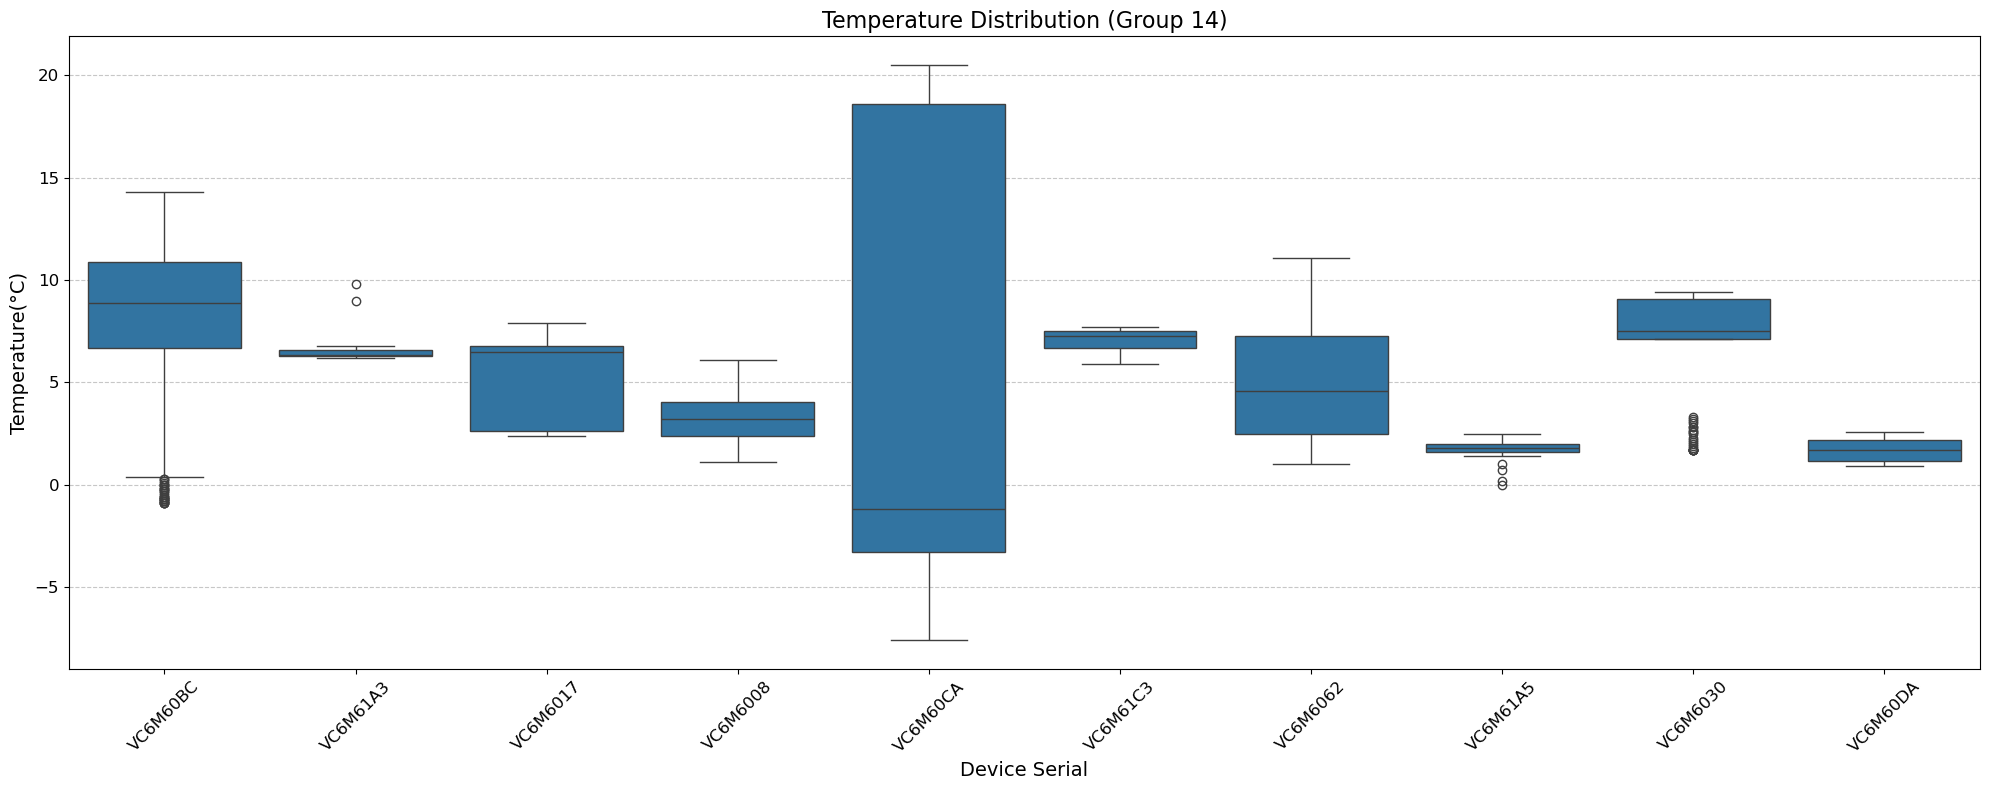


=== Group 14 통계량 ===
               count  mean    std  min   25%   50%    75%   max
device_serial                                                  
VC6M6008        76.0  3.18   1.20  1.1  2.40  3.20   4.03   6.1
VC6M6017        11.0  5.35   2.29  2.4  2.65  6.50   6.80   7.9
VC6M6030       117.0  7.06   2.51  1.7  7.10  7.50   9.10   9.4
VC6M6062       263.0  5.12   2.96  1.0  2.50  4.60   7.25  11.1
VC6M60BC       615.0  8.52   3.56 -0.9  6.70  8.90  10.90  14.3
VC6M60CA       406.0  3.29  10.07 -7.6 -3.30 -1.20  18.60  20.5
VC6M60DA        59.0  1.71   0.55  0.9  1.15  1.70   2.20   2.6
VC6M61A3        12.0  6.88   1.20  6.2  6.30  6.35   6.58   9.8
VC6M61A5        22.0  1.65   0.65  0.0  1.60  1.80   2.00   2.5
VC6M61C3        30.0  7.04   0.55  5.9  6.70  7.25   7.50   7.7

추가 통계 정보:
                  std  count  min   max  mean    Q1      Q3     IQR  \
device_serial                                                         
VC6M6008         1.45     76  1.1   6.1  3.18  2.40   4.0

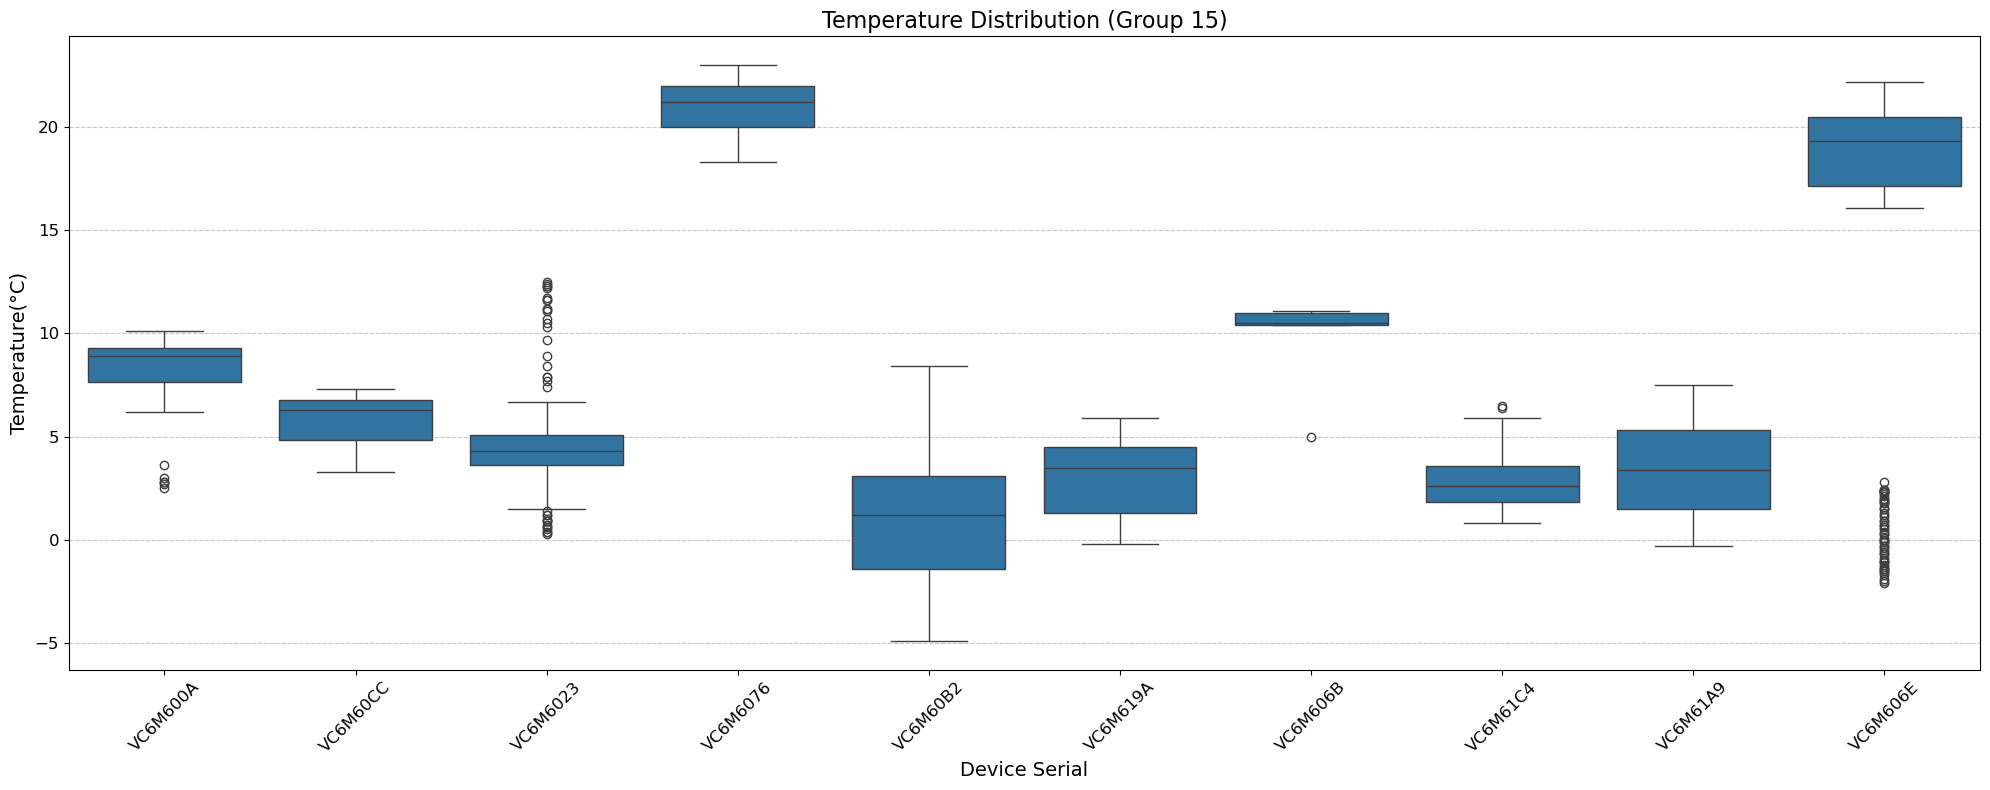


=== Group 15 통계량 ===
                count   mean   std   min    25%   50%    75%   max
device_serial                                                     
VC6M600A        106.0   8.27  1.68   2.5   7.62   8.9   9.30  10.1
VC6M6023        114.0   4.85  3.09   0.3   3.62   4.3   5.07  12.5
VC6M606B          5.0   9.60  2.59   5.0  10.40  10.5  11.00  11.1
VC6M606E        342.0  16.12  7.36  -2.1  17.12  19.3  20.50  22.2
VC6M6076        141.0  21.03  1.15  18.3  20.00  21.2  22.00  23.0
VC6M60B2       1357.0   1.11  2.90  -4.9  -1.40   1.2   3.10   8.4
VC6M60CC         32.0   5.83  1.25   3.3   4.82   6.3   6.75   7.3
VC6M619A        234.0   2.95  1.80  -0.2   1.30   3.5   4.50   5.9
VC6M61A9        219.0   3.44  2.35  -0.3   1.50   3.4   5.30   7.5
VC6M61C4        150.0   2.78  1.26   0.8   1.82   2.6   3.58   6.5

추가 통계 정보:
                 std  count   min   max   mean      Q1      Q3    IQR  \
device_serial                                                           
VC6M600A        2

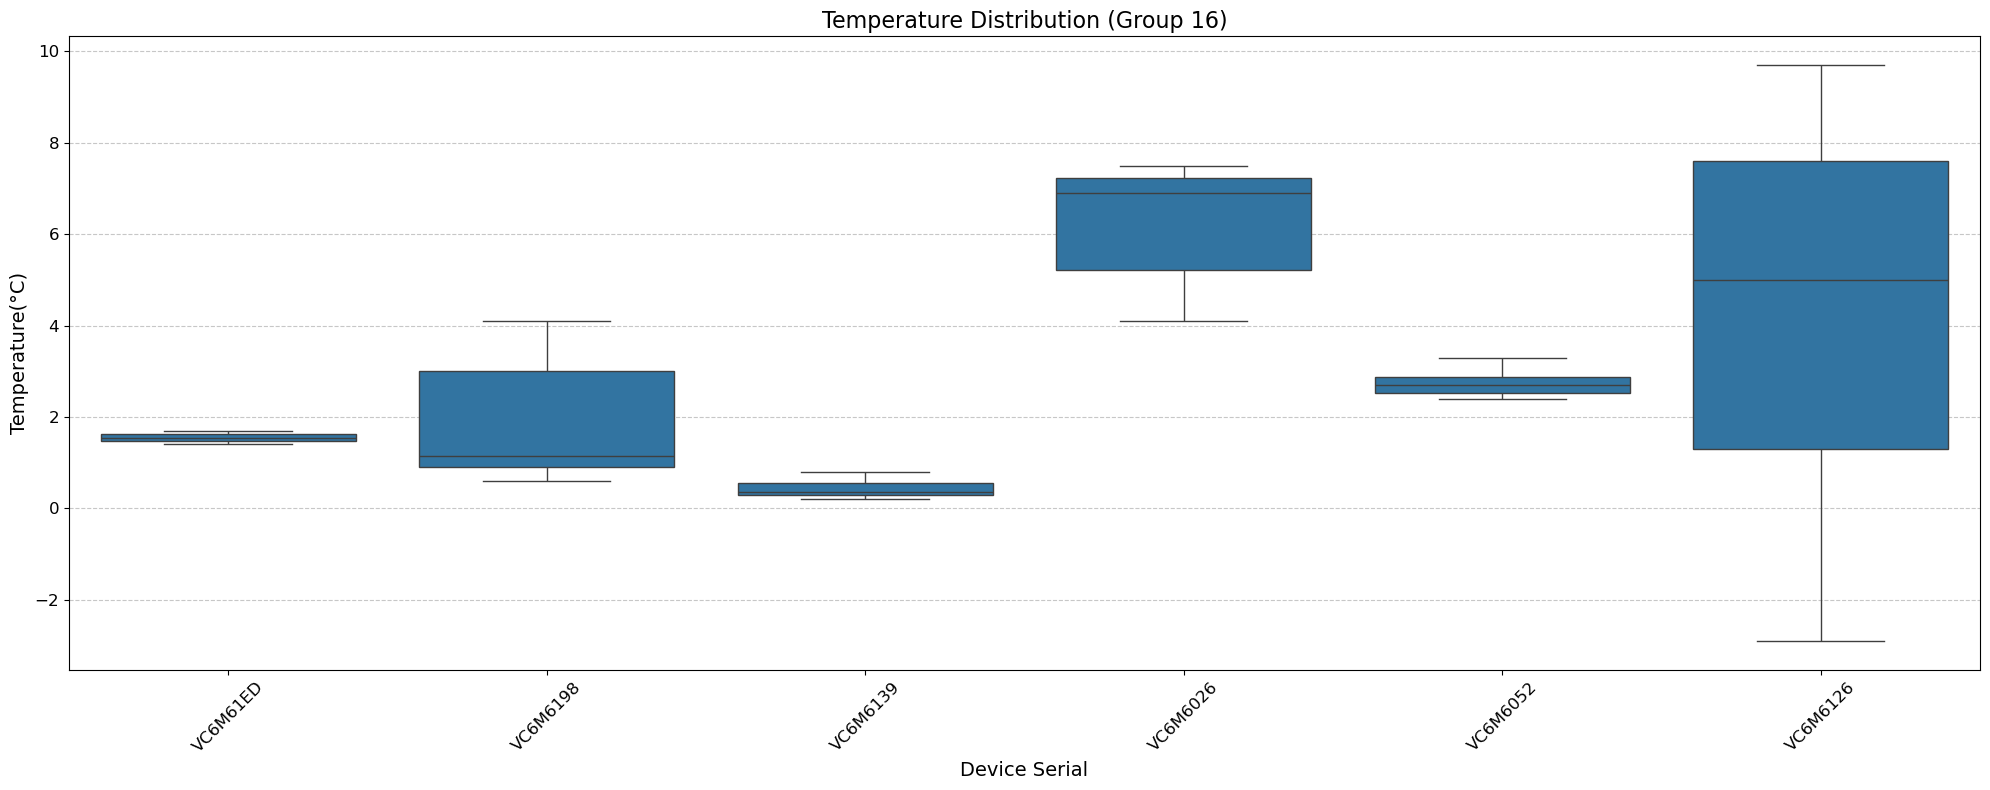


=== Group 16 통계량 ===
               count  mean   std  min   25%   50%   75%  max
device_serial                                               
VC6M6026         6.0  6.23  1.45  4.1  5.22  6.90  7.22  7.5
VC6M6052         6.0  2.75  0.33  2.4  2.52  2.70  2.88  3.3
VC6M6126       378.0  4.36  3.64 -2.9  1.30  5.00  7.60  9.7
VC6M6139         8.0  0.44  0.21  0.2  0.30  0.35  0.55  0.8
VC6M6198       100.0  1.85  1.12  0.6  0.90  1.15  3.00  4.1
VC6M61ED         2.0  1.55  0.21  1.4  1.48  1.55  1.62  1.7

추가 통계 정보:
                 std  count  min  max  mean     Q1     Q3   IQR  \
device_serial                                                     
VC6M6026        2.11      6  4.1  7.5  6.23  5.225  7.225  2.00   
VC6M6052        0.11      6  2.4  3.3  2.75  2.525  2.875  0.35   
VC6M6126       13.22    378 -2.9  9.7  4.36  1.300  7.600  6.30   
VC6M6139        0.05      8  0.2  0.8  0.44  0.300  0.550  0.25   
VC6M6198        1.25    100  0.6  4.1  1.85  0.900  3.000  2.10   
VC6M61ED  

In [12]:
# temperature 열의 데이터 타입을 float으로 변환
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

temperature_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    temp_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    sns.boxplot(x='device_serial', y='temperature', data=temp_data)
    
    # 그래프 제목과 레이블 설정
    plt.title(f'Temperature Distribution (Group {group_idx + 1})', fontsize=16)
    plt.xlabel('Device Serial', fontsize=14)
    plt.ylabel('Temperature(°C)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # 그리드 추가
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = temp_data.groupby('device_serial')['temperature'].describe().round(2)
    print(stats)

    # 1. 방법 1: 딕셔너리 형태로 변경
    temp_stats = temp_data.groupby('device_serial').agg({
        'temperature': ['var', 'count']
    }).round(2)

    # Q1, Q3 및 IQR 계산
    Q1 = temp_data.groupby('device_serial')['temperature'].quantile(0.25)
    Q3 = temp_data.groupby('device_serial')['temperature'].quantile(0.75)
    IQR = Q3 - Q1
    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR

    # TO-BE
    # temp_stats 데이터프레임 생성
    temp_stats = temp_data.groupby('device_serial').agg({
    'temperature': ['var', 'count', 'min', 'max', 'mean']  # 분산, 데이터 수, 최소값, 최대값, 평균값
    }).round(2)

    # Q1, Q3, IQR, Whisker Start, Whisker End 추가
    temp_stats['Q1'] = Q1
    temp_stats['Q3'] = Q3
    temp_stats['IQR'] = IQR
    temp_stats['Whisker Start'] = whisker_start
    temp_stats['Whisker End'] = whisker_end

    # 열 이름 변경
    temp_stats.columns = ['std', 'count', 'min', 'max', 'mean', 'Q1', 'Q3', 'IQR', 'Whisker Start', 'Whisker End']

    # AS-IS
    # 개별 통계량 계산  
    # 수염의 시작값과 끝값 계산
    # whisker_start = Q1 - 1.5 * IQR
    # whisker_end = Q3 + 1.5 * IQR
    

    # temp_stats = pd.DataFrame({
    #     '분산': temp_data.groupby('device_serial')['temperature'].var(),
    #     'IQR': temp_data.groupby('device_serial')['temperature'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25)),
    #     '데이터 수': temp_data.groupby('device_serial')['temperature'].count(),
    #     'Q1': temp_data.groupby('device_serial')['temperature'].quantile(0.25),  # 1사분위수
    #     'Q3': temp_data.groupby('device_serial')['temperature'].quantile(0.75),   # 4사분위수
    #     'IQR': IQR,
    #     'Whisker Start': whisker_start,
    #     'Whisker End': whisker_end
    # }).round(2)

    # Q1과 Q3의 시작값과 끝값 저장
    # temp_stats['Q1 시작값'] = temp_stats['Q1']
    # temp_stats['Q3 끝값'] = temp_stats['Q3']

    # 리스트에 추가
    temperature_stats.append(temp_stats)

    print("\n추가 통계 정보:")
    print(temp_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
temp_final_stats = pd.concat(temperature_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(temp_final_stats)

In [13]:
temp_final_stats

std  count  min   max   mean      Q1      Q3     IQR  \
device_serial                                                           
VC6M6034       51.31   1227 -5.5  21.3  12.81   7.500  20.100  12.600   
VC6M6068        0.48     41  6.4   8.7   7.44   6.800   8.100   1.300   
VC6M6094        8.97    257  8.2  21.1  13.32  11.600  14.900   3.300   
VC6M609B        1.61     70  3.8   7.8   5.31   4.025   6.100   2.075   
VC6M60A2        8.94    288  7.2  18.8  10.77   8.300  12.125   3.825   
...              ...    ...  ...   ...    ...     ...     ...     ...   
VC6M6052        0.11      6  2.4   3.3   2.75   2.525   2.875   0.350   
VC6M6126       13.22    378 -2.9   9.7   4.36   1.300   7.600   6.300   
VC6M6139        0.05      8  0.2   0.8   0.44   0.300   0.550   0.250   
VC6M6198        1.25    100  0.6   4.1   1.85   0.900   3.000   2.100   
VC6M61ED        0.04      2  1.4   1.7   1.55   1.475   1.625   0.150   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034            -11.4000      39.0000  
VC6M6068              4.8500      10.0500  
VC6M6094              6.6500      19.8500  
VC6M609B              0.9125       9.2125  
VC6M60A2              2.5625      17.8625  
...                      ...          ...  
VC6M6052              2.0000       3.4000  
VC6M6126             -8.1500      17.0500  
VC6M6139             -0.0750       0.9250  
VC6M6198             -2.2500       6.1500  
VC6M61ED              1.2500       1.8500  

[156 rows x 10 columns]

### 하한값&상한값 지정을 위한 Humidity 분포 비교

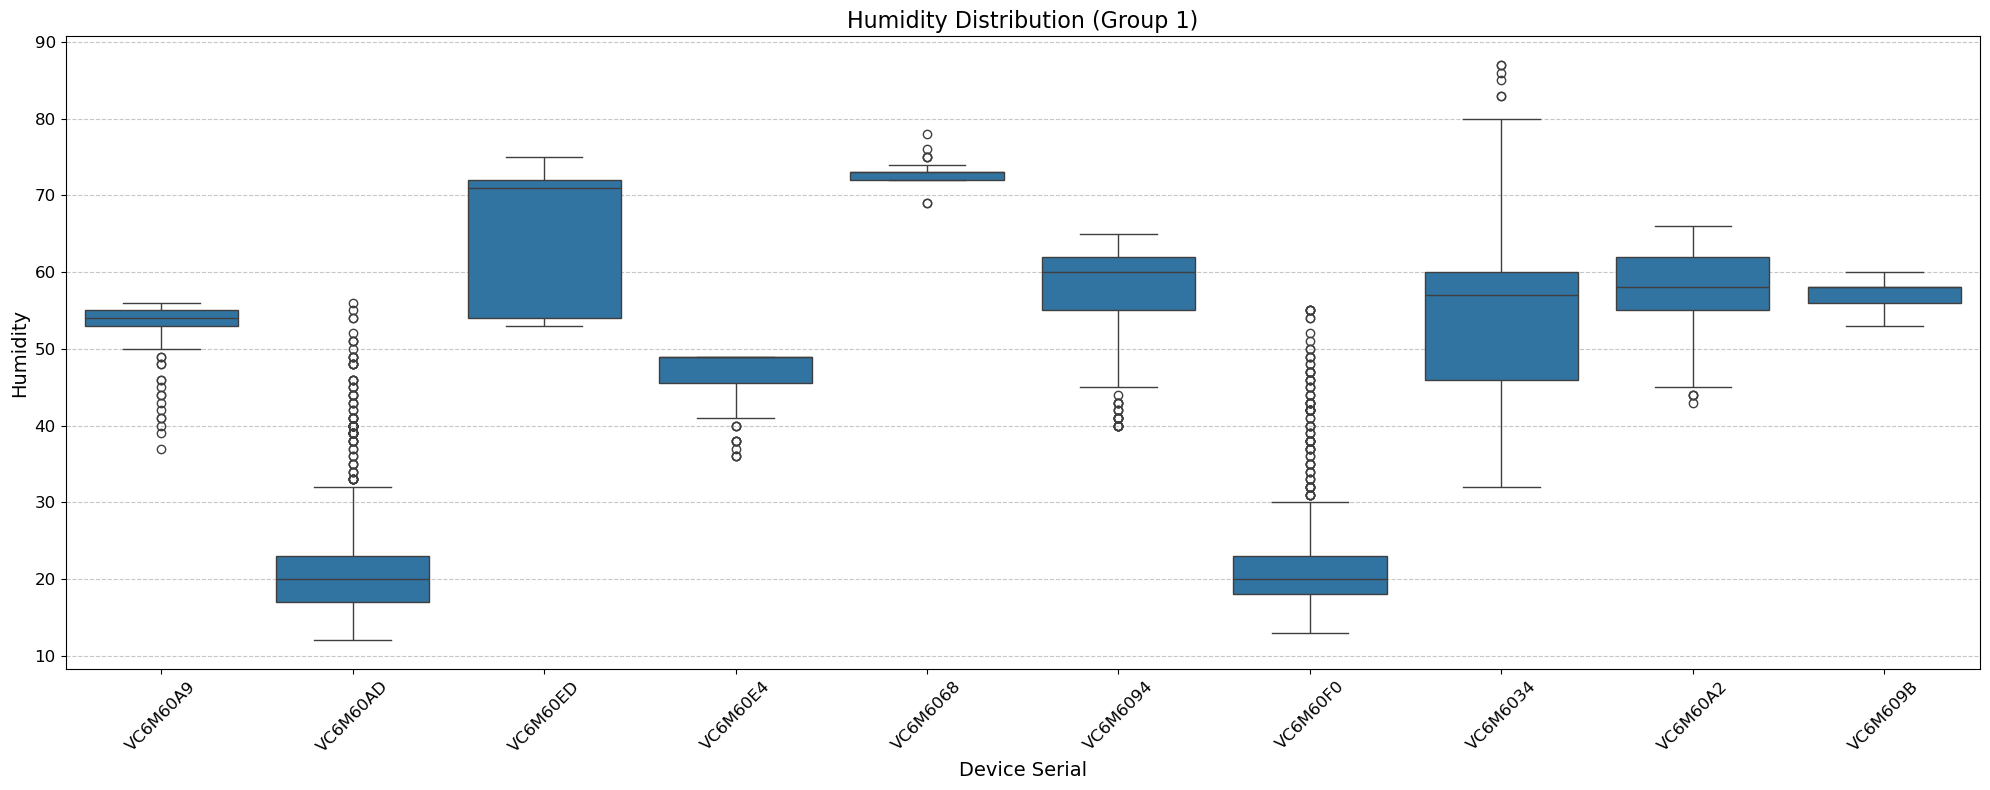


=== Group 1 통계량 ===
                count   mean   std   min   25%   50%   75%   max
device_serial                                                   
VC6M6034       1227.0  53.30  8.78  32.0  46.0  57.0  60.0  87.0
VC6M6068         41.0  73.02  1.52  69.0  72.0  73.0  73.0  78.0
VC6M6094        257.0  57.32  6.28  40.0  55.0  60.0  62.0  65.0
VC6M609B         70.0  56.96  1.85  53.0  56.0  58.0  58.0  60.0
VC6M60A2        288.0  57.92  5.34  43.0  55.0  58.0  62.0  66.0
VC6M60A9        230.0  53.45  3.12  37.0  53.0  54.0  55.0  56.0
VC6M60AD       5275.0  20.63  4.94  12.0  17.0  20.0  23.0  56.0
VC6M60E4         67.0  46.33  4.19  36.0  45.5  49.0  49.0  49.0
VC6M60ED         30.0  66.27  8.76  53.0  54.0  71.0  72.0  75.0
VC6M60F0       3749.0  20.94  4.92  13.0  18.0  20.0  23.0  55.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0 

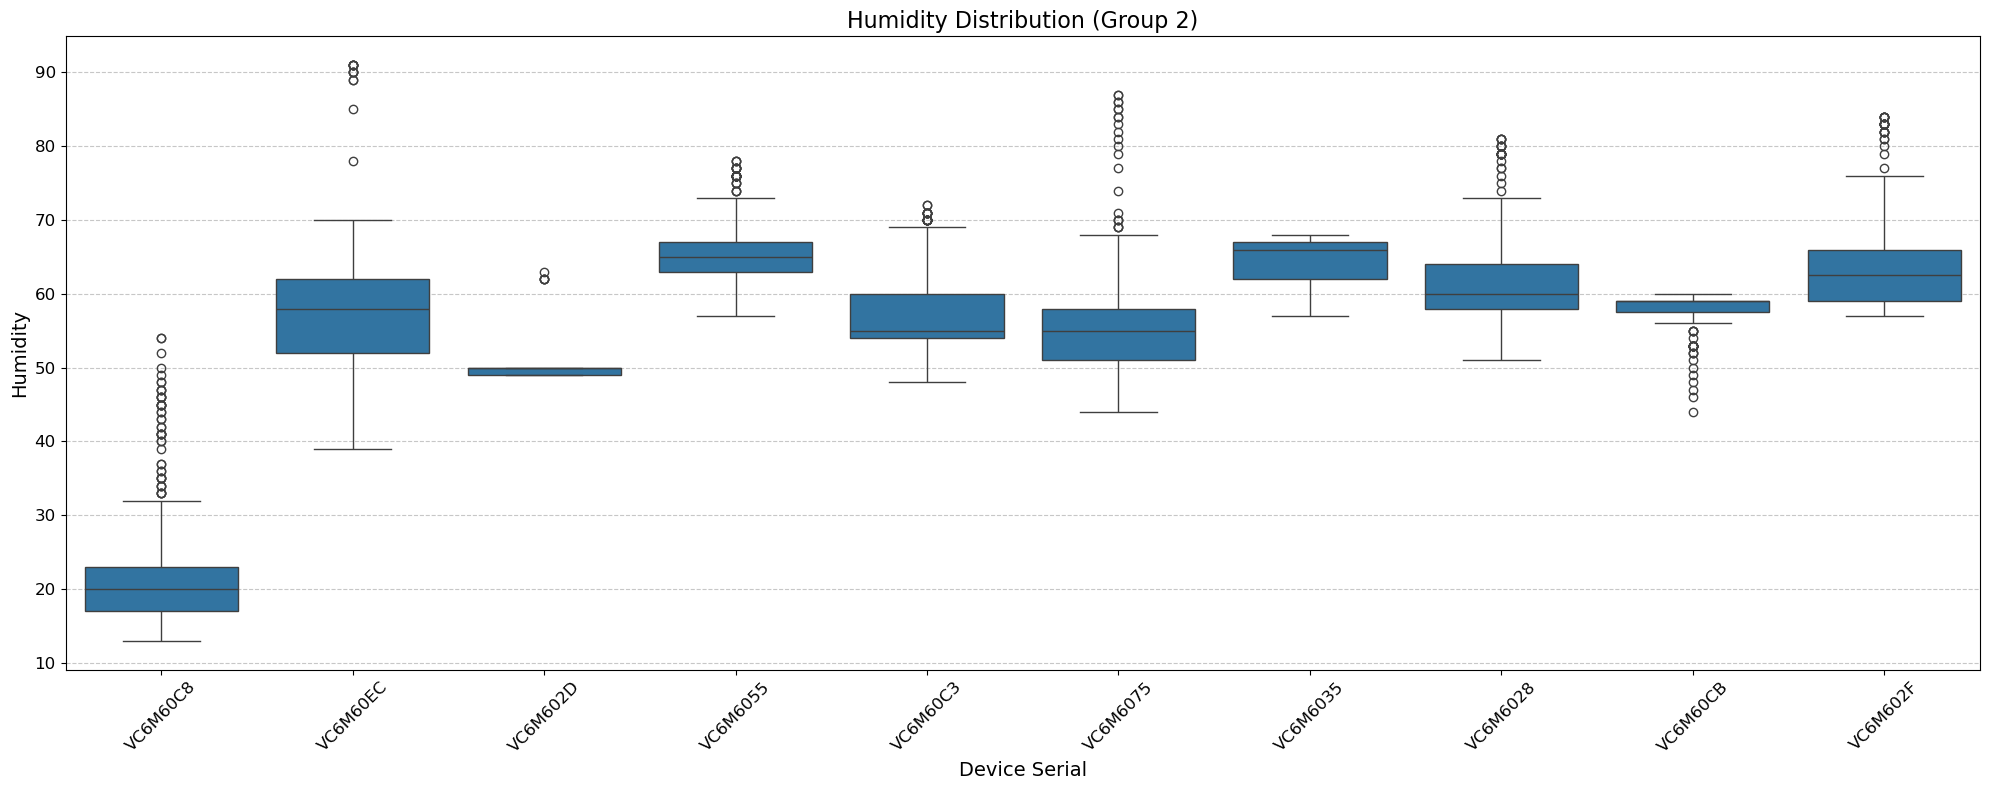


=== Group 2 통계량 ===
                count   mean   std   min   25%   50%   75%   max
device_serial                                                   
VC6M6028        690.0  60.91  5.14  51.0  58.0  60.0  64.0  81.0
VC6M602D        104.0  50.13  2.77  49.0  49.0  50.0  50.0  63.0
VC6M602F        192.0  64.59  7.78  57.0  59.0  62.5  66.0  84.0
VC6M6035        160.0  64.65  3.02  57.0  62.0  66.0  67.0  68.0
VC6M6055        961.0  65.33  3.53  57.0  63.0  65.0  67.0  78.0
VC6M6075       2927.0  55.20  5.17  44.0  51.0  55.0  58.0  87.0
VC6M60C3       2511.0  57.01  4.61  48.0  54.0  55.0  60.0  72.0
VC6M60C8       4599.0  20.31  4.34  13.0  17.0  20.0  23.0  54.0
VC6M60CB        171.0  57.79  2.87  44.0  57.5  59.0  59.0  60.0
VC6M60EC       1482.0  56.68  7.08  39.0  52.0  58.0  62.0  91.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0 

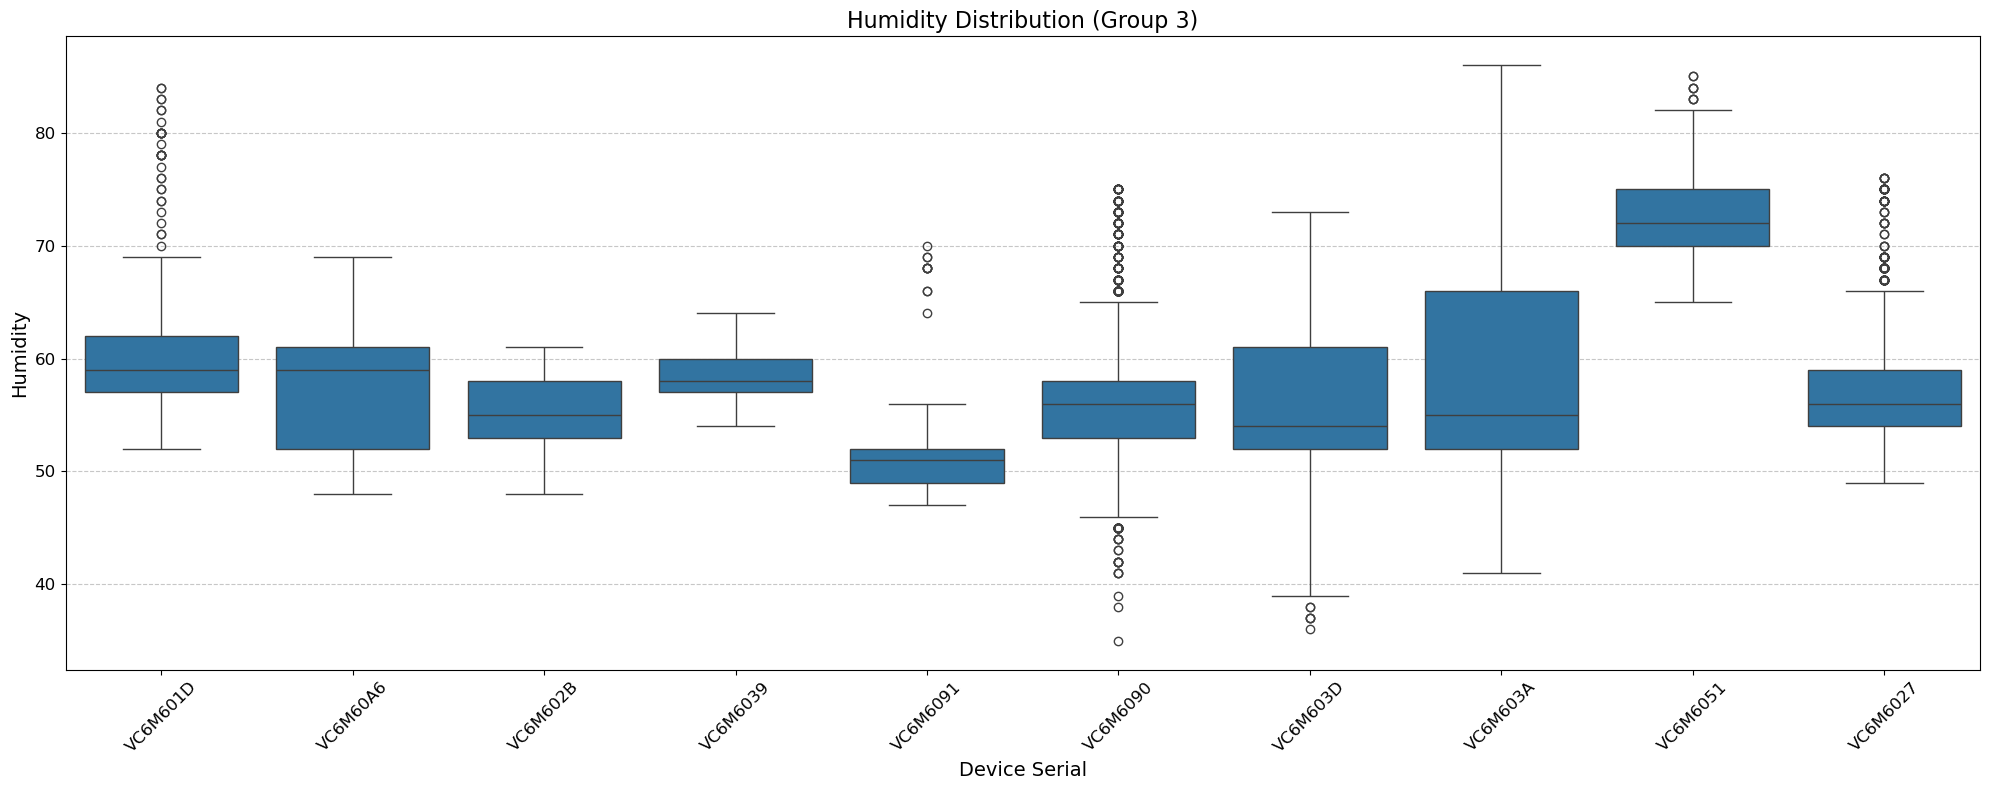


=== Group 3 통계량 ===
                count   mean   std   min   25%   50%   75%   max
device_serial                                                   
VC6M601D        690.0  60.00  5.20  52.0  57.0  59.0  62.0  84.0
VC6M6027       3735.0  56.68  4.29  49.0  54.0  56.0  59.0  76.0
VC6M602B        409.0  55.27  3.07  48.0  53.0  55.0  58.0  61.0
VC6M6039       1885.0  58.58  2.20  54.0  57.0  58.0  60.0  64.0
VC6M603A       2832.0  58.24  8.12  41.0  52.0  55.0  66.0  86.0
VC6M603D       1197.0  55.76  7.25  36.0  52.0  54.0  61.0  73.0
VC6M6051        201.0  72.86  4.61  65.0  70.0  72.0  75.0  85.0
VC6M6090       3831.0  56.01  5.37  35.0  53.0  56.0  58.0  75.0
VC6M6091        598.0  51.22  3.01  47.0  49.0  51.0  52.0  70.0
VC6M60A6        528.0  57.49  5.29  48.0  52.0  59.0  61.0  69.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0 

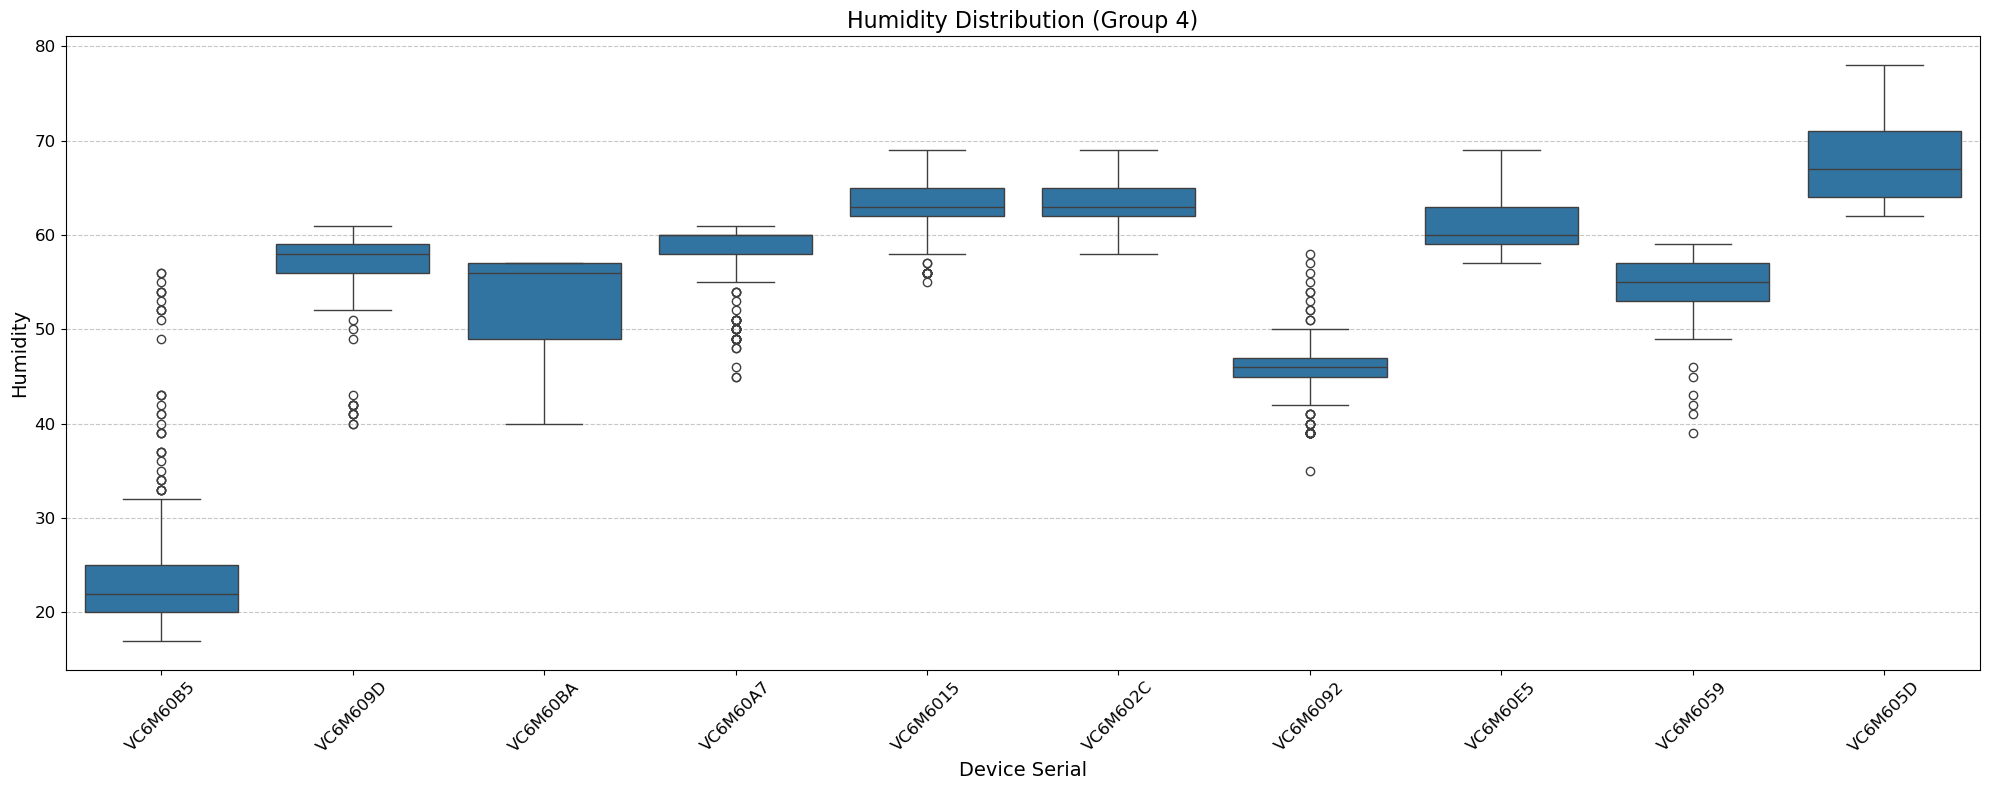


=== Group 4 통계량 ===
               count   mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6015        88.0  62.97  3.49  55.0  62.0  63.0  65.0  69.0
VC6M602C       126.0  63.57  2.01  58.0  62.0  63.0  65.0  69.0
VC6M6059       415.0  55.01  3.00  39.0  53.0  55.0  57.0  59.0
VC6M605D       227.0  68.06  4.24  62.0  64.0  67.0  71.0  78.0
VC6M6092       199.0  45.43  3.43  35.0  45.0  46.0  47.0  58.0
VC6M609D       109.0  56.13  5.63  40.0  56.0  58.0  59.0  61.0
VC6M60A7       204.0  57.72  3.95  45.0  58.0  60.0  60.0  61.0
VC6M60B5       826.0  23.02  5.47  17.0  20.0  22.0  25.0  56.0
VC6M60BA       110.0  53.12  4.45  40.0  49.0  56.0  57.0  57.0
VC6M60E5        46.0  60.70  2.72  57.0  59.0  60.0  63.0  69.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0    57.0  60.

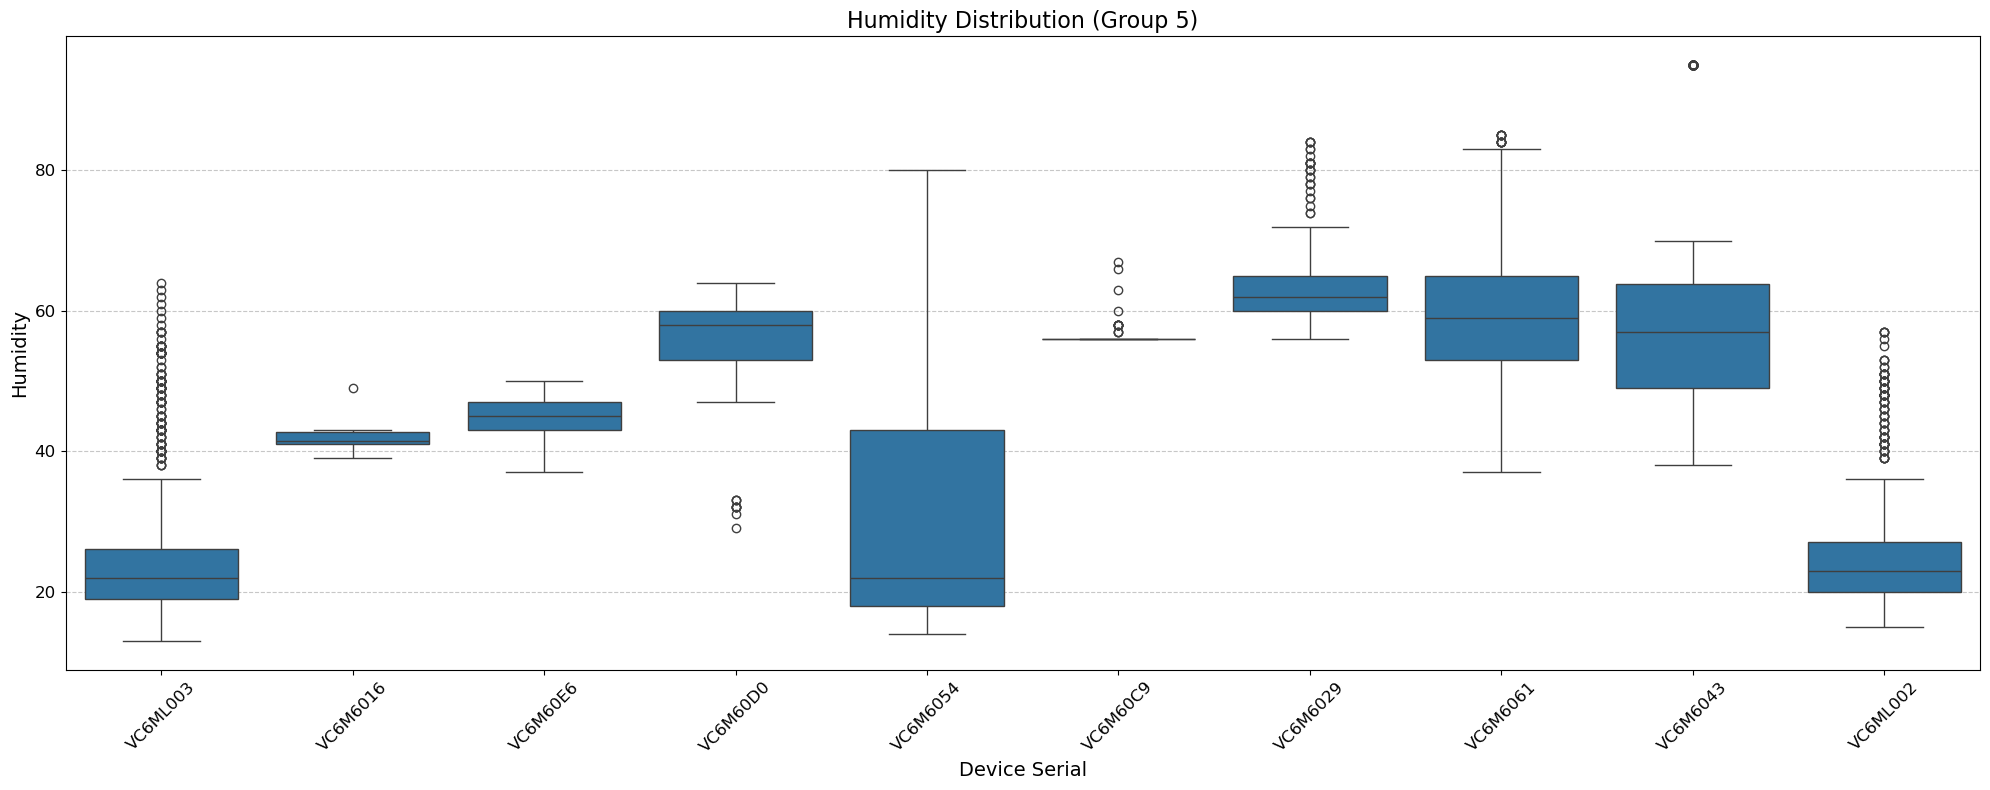


=== Group 5 통계량 ===
                count   mean    std   min   25%   50%    75%   max
device_serial                                                     
VC6M6016         14.0  42.07   2.27  39.0  41.0  41.5  42.75  49.0
VC6M6029        192.0  64.03   7.24  56.0  60.0  62.0  65.00  84.0
VC6M6043       1662.0  57.54  11.22  38.0  49.0  57.0  63.75  95.0
VC6M6054       2767.0  30.79  16.16  14.0  18.0  22.0  43.00  80.0
VC6M6061       2820.0  59.53   8.79  37.0  53.0  59.0  65.00  85.0
VC6M60C9         96.0  56.53   1.76  56.0  56.0  56.0  56.00  67.0
VC6M60D0       1059.0  56.95   4.76  29.0  53.0  58.0  60.00  64.0
VC6M60E6        583.0  44.72   2.76  37.0  43.0  45.0  47.00  50.0
VC6ML002       1267.0  24.69   7.28  15.0  20.0  23.0  27.00  57.0
VC6ML003       1536.0  24.22   8.83  13.0  19.0  22.0  26.00  64.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  

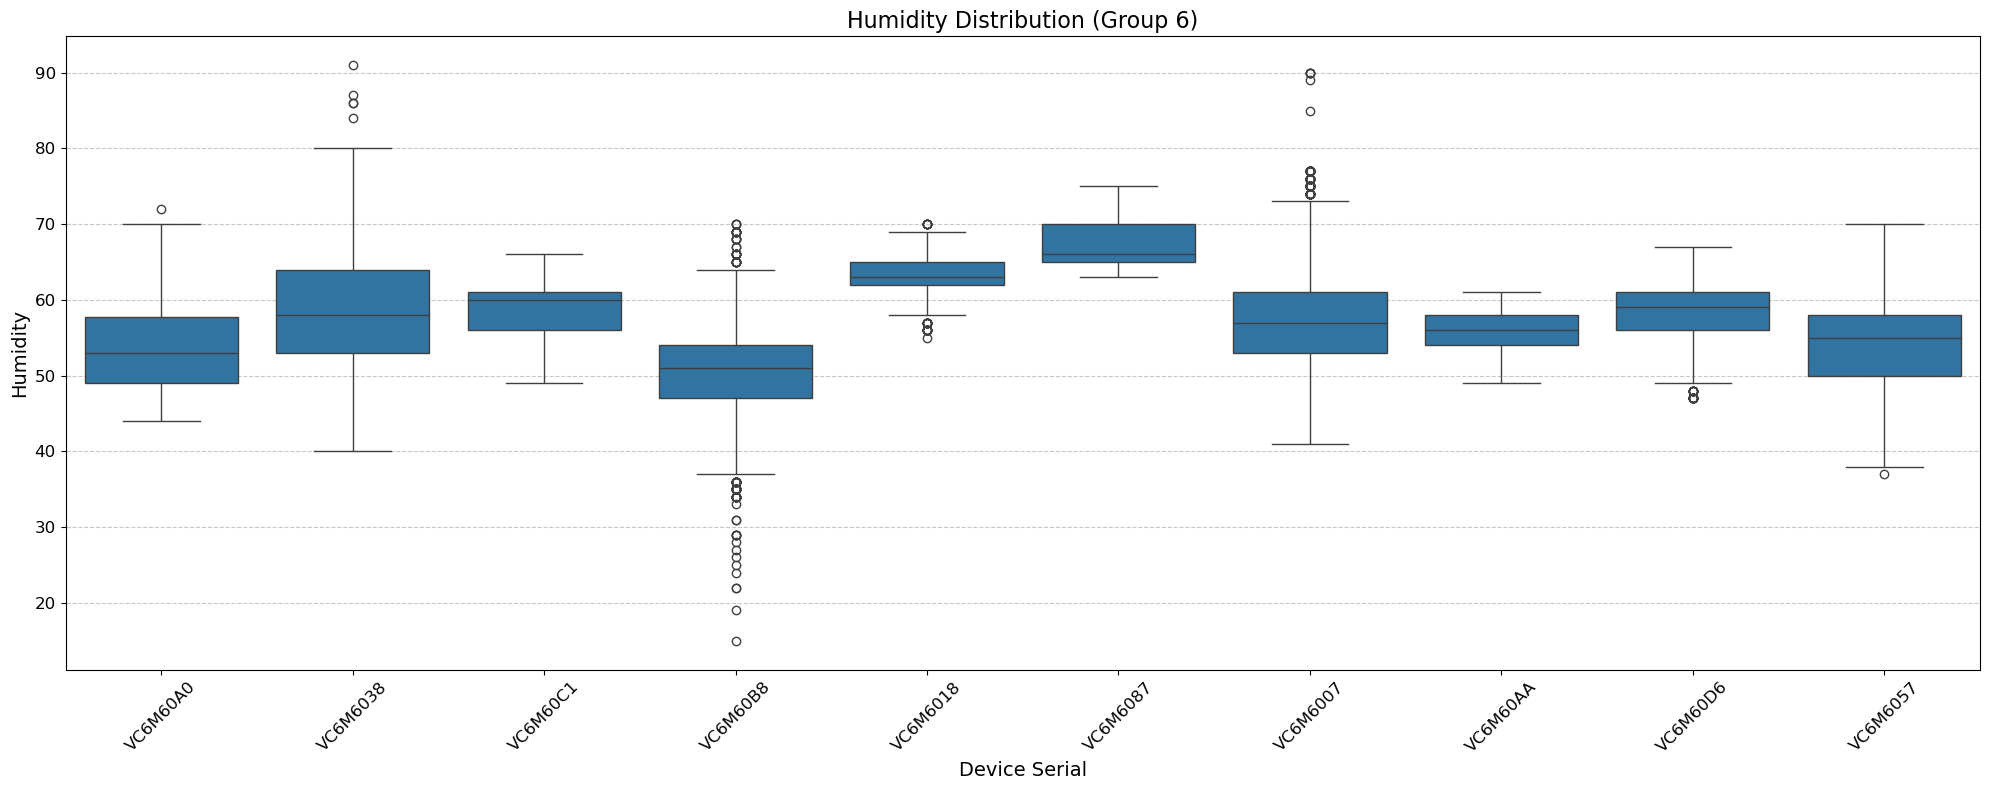


=== Group 6 통계량 ===
                count   mean   std   min   25%   50%    75%   max
device_serial                                                    
VC6M6007       3923.0  57.38  6.91  41.0  53.0  57.0  61.00  90.0
VC6M6018        792.0  63.25  2.42  55.0  62.0  63.0  65.00  70.0
VC6M6038       2879.0  58.87  7.72  40.0  53.0  58.0  64.00  91.0
VC6M6057       3056.0  54.35  5.21  37.0  50.0  55.0  58.00  70.0
VC6M6087        140.0  67.43  3.09  63.0  65.0  66.0  70.00  75.0
VC6M60A0        606.0  53.57  6.06  44.0  49.0  53.0  57.75  72.0
VC6M60AA        233.0  55.86  2.62  49.0  54.0  56.0  58.00  61.0
VC6M60B8       2595.0  50.08  6.44  15.0  47.0  51.0  54.00  70.0
VC6M60C1        690.0  59.01  3.65  49.0  56.0  60.0  61.00  66.0
VC6M60D6       2051.0  58.88  3.81  47.0  56.0  59.0  61.00  67.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78 

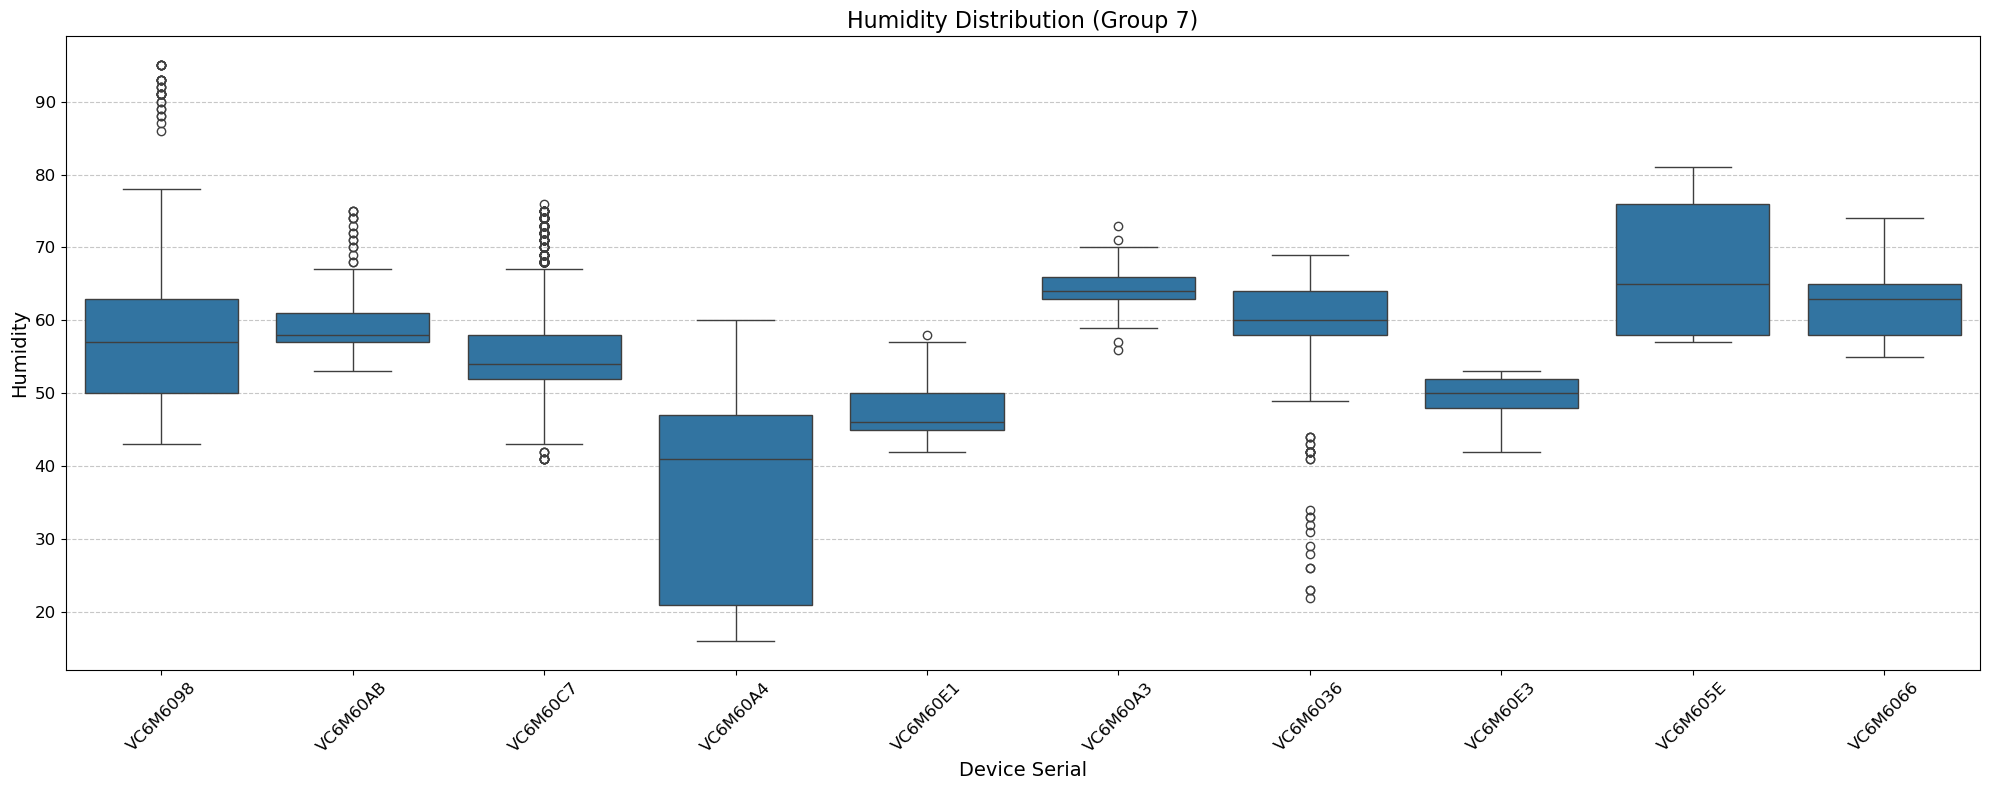


=== Group 7 통계량 ===
                count   mean    std   min   25%   50%   75%   max
device_serial                                                    
VC6M6036       1114.0  59.74   5.33  22.0  58.0  60.0  64.0  69.0
VC6M605E        254.0  66.54   9.08  57.0  58.0  65.0  76.0  81.0
VC6M6066        239.0  62.45   4.48  55.0  58.0  63.0  65.0  74.0
VC6M6098       1033.0  57.61   9.84  43.0  50.0  57.0  63.0  95.0
VC6M60A3        144.0  64.41   2.76  56.0  63.0  64.0  66.0  73.0
VC6M60A4        978.0  35.90  12.85  16.0  21.0  41.0  47.0  60.0
VC6M60AB        354.0  59.35   4.26  53.0  57.0  58.0  61.0  75.0
VC6M60C7       3228.0  55.39   5.99  41.0  52.0  54.0  58.0  76.0
VC6M60E1         26.0  47.81   4.24  42.0  45.0  46.0  50.0  58.0
VC6M60E3        249.0  49.66   2.46  42.0  48.0  50.0  52.0  53.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78 

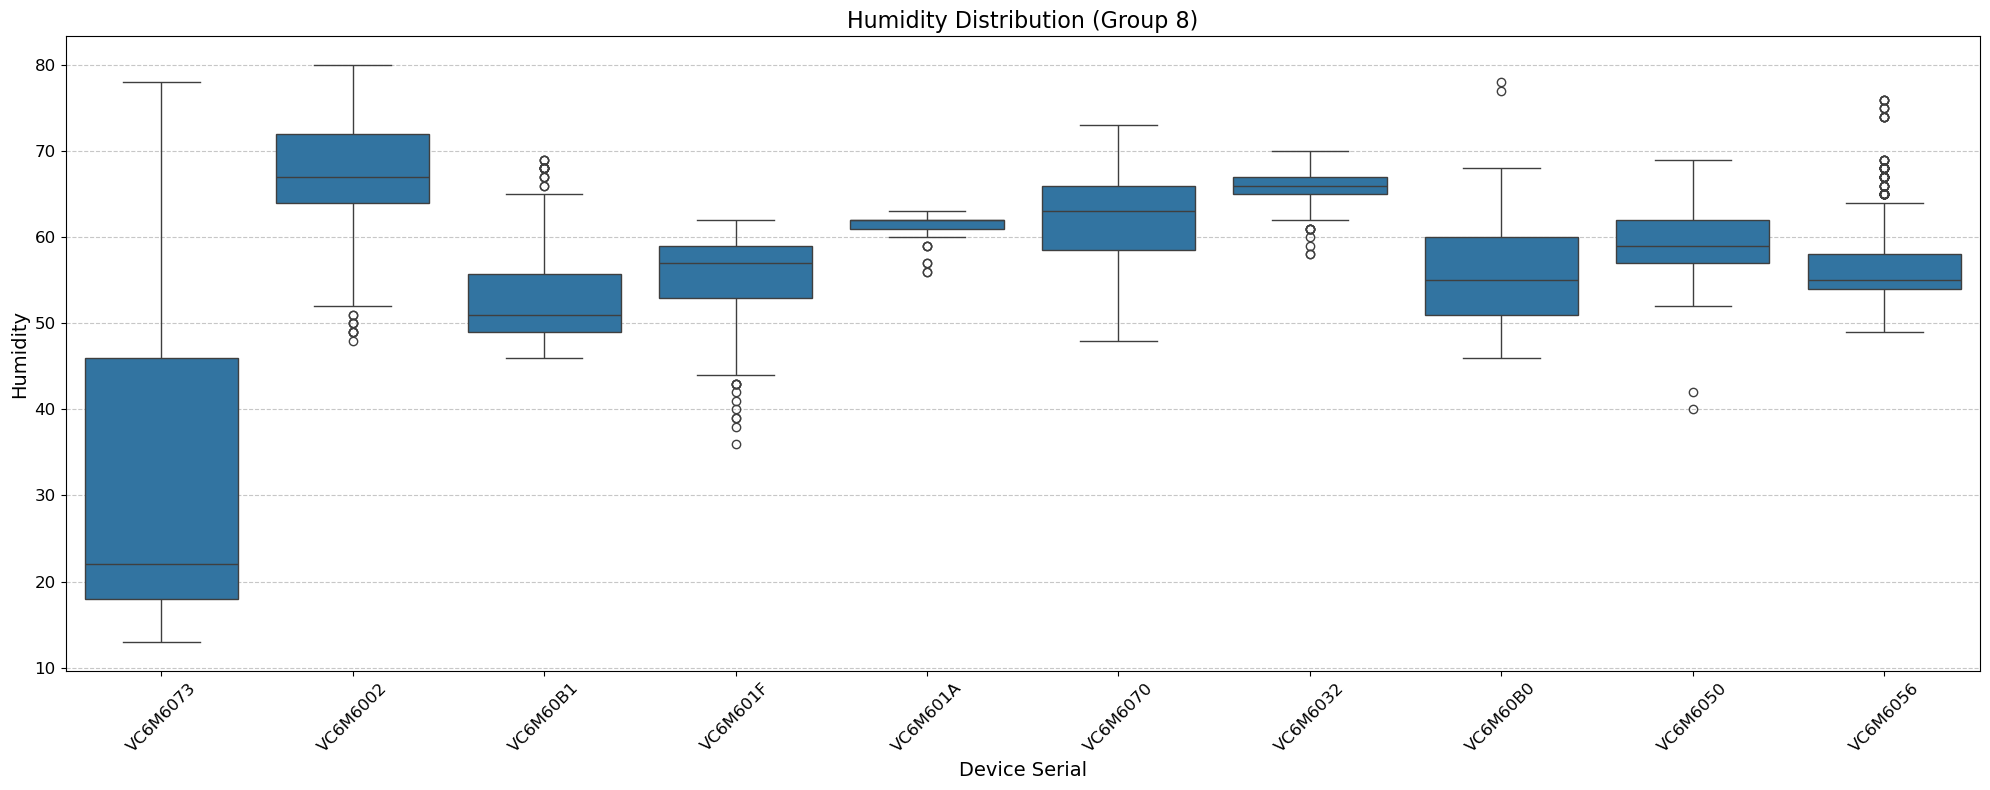


=== Group 8 통계량 ===
                count   mean    std   min   25%   50%    75%   max
device_serial                                                     
VC6M6002       1021.0  67.81   5.29  48.0  64.0  67.0  72.00  80.0
VC6M601A         58.0  61.24   1.70  56.0  61.0  62.0  62.00  63.0
VC6M601F        400.0  55.40   4.77  36.0  53.0  57.0  59.00  62.0
VC6M6032        120.0  65.40   2.26  58.0  65.0  66.0  67.00  70.0
VC6M6050       1096.0  59.21   3.73  40.0  57.0  59.0  62.00  69.0
VC6M6056       4039.0  55.96   3.24  49.0  54.0  55.0  58.00  76.0
VC6M6070        575.0  62.21   6.11  48.0  58.5  63.0  66.00  73.0
VC6M6073       2161.0  30.57  17.65  13.0  18.0  22.0  46.00  78.0
VC6M60B0        606.0  55.46   5.50  46.0  51.0  55.0  60.00  78.0
VC6M60B1        294.0  53.06   5.48  46.0  49.0  51.0  55.75  69.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  

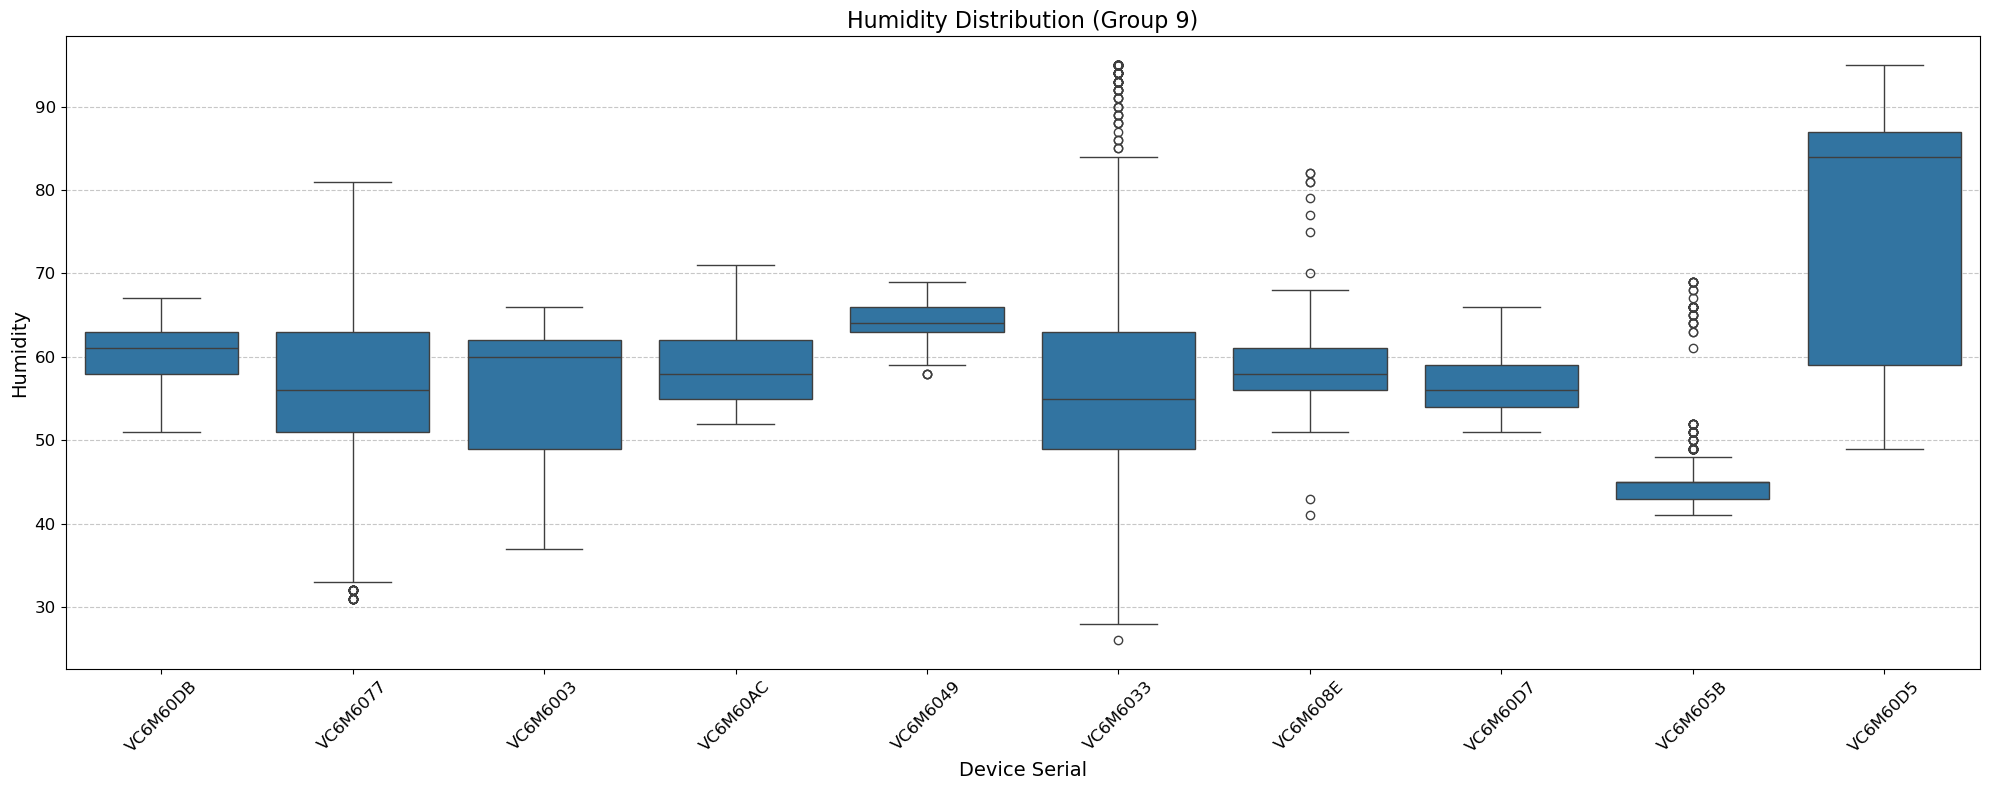


=== Group 9 통계량 ===
                count   mean    std   min   25%   50%   75%   max
device_serial                                                    
VC6M6003        830.0  56.53   7.61  37.0  49.0  60.0  62.0  66.0
VC6M6033       1285.0  57.71  12.72  26.0  49.0  55.0  63.0  95.0
VC6M6049        707.0  64.50   2.08  58.0  63.0  64.0  66.0  69.0
VC6M605B       3487.0  44.75   2.54  41.0  43.0  45.0  45.0  69.0
VC6M6077       2004.0  56.06   9.80  31.0  51.0  56.0  63.0  81.0
VC6M608E       1434.0  58.34   3.76  41.0  56.0  58.0  61.0  82.0
VC6M60AC       1881.0  58.76   3.86  52.0  55.0  58.0  62.0  71.0
VC6M60D5       1650.0  75.04  15.81  49.0  59.0  84.0  87.0  95.0
VC6M60D7       1707.0  56.77   3.27  51.0  54.0  56.0  59.0  66.0
VC6M60DB       1020.0  60.38   3.49  51.0  58.0  61.0  63.0  67.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78 

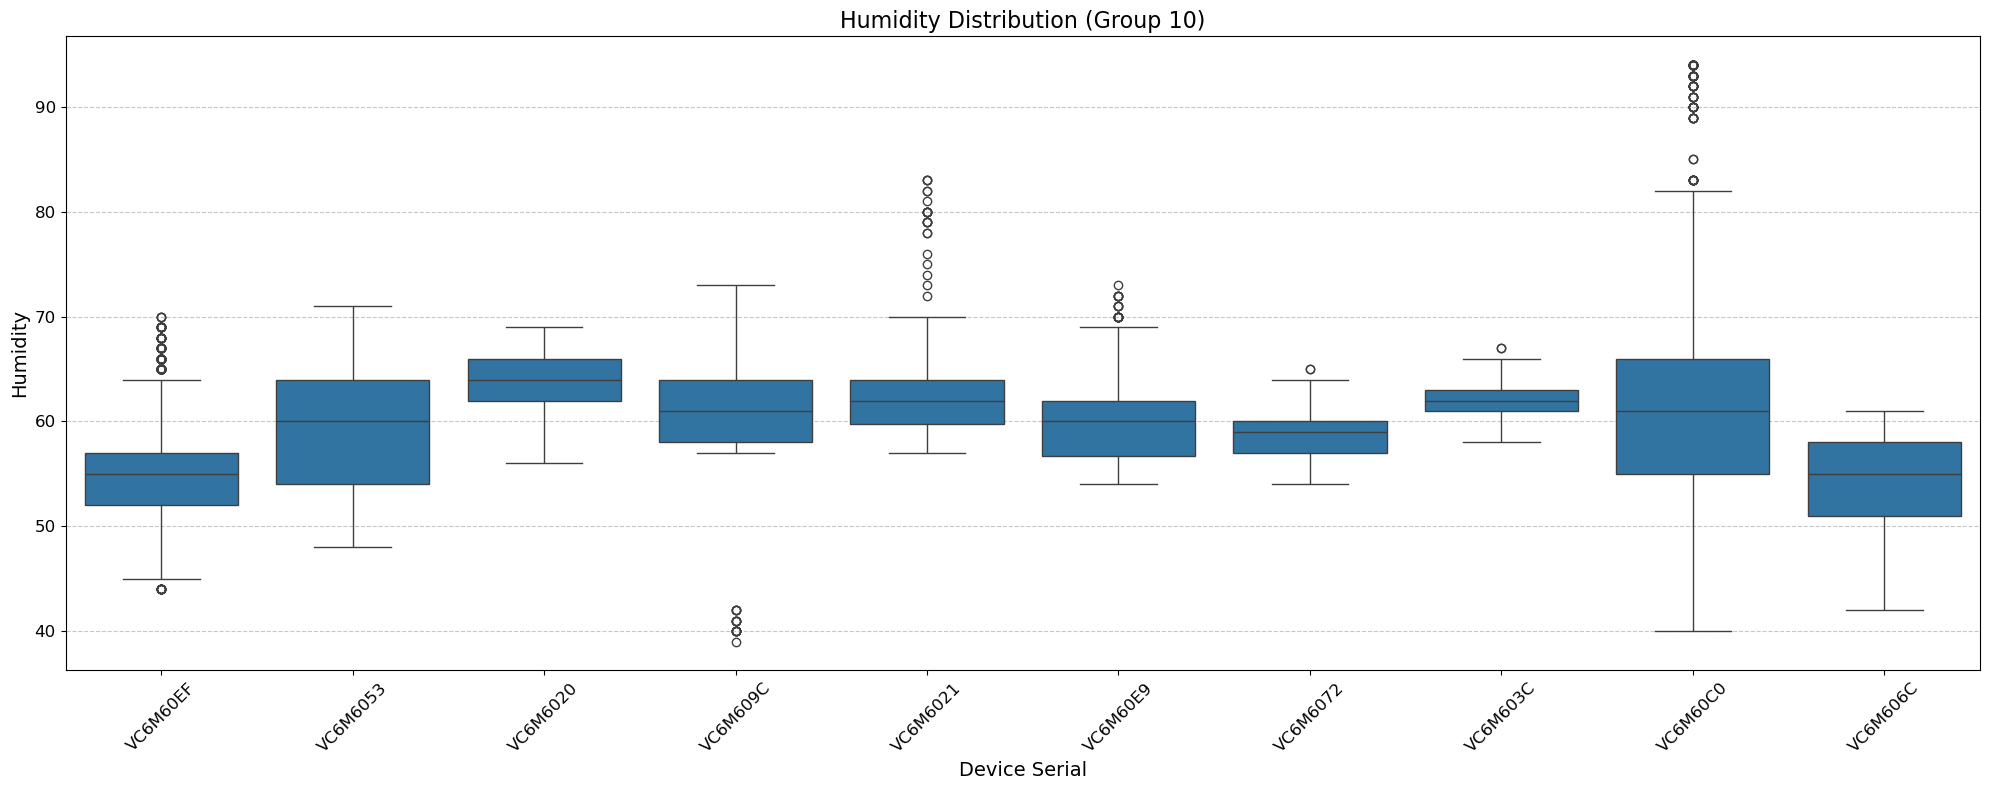


=== Group 10 통계량 ===
                count   mean   std   min    25%   50%   75%   max
device_serial                                                    
VC6M6020        691.0  63.82  2.56  56.0  62.00  64.0  66.0  69.0
VC6M6021        200.0  63.41  6.20  57.0  59.75  62.0  64.0  83.0
VC6M603C       1253.0  61.82  1.54  58.0  61.00  62.0  63.0  67.0
VC6M6053        405.0  59.11  5.37  48.0  54.00  60.0  64.0  71.0
VC6M606C        197.0  54.23  5.03  42.0  51.00  55.0  58.0  61.0
VC6M6072       2409.0  58.57  2.29  54.0  57.00  59.0  60.0  65.0
VC6M609C        431.0  61.38  6.04  39.0  58.00  61.0  64.0  73.0
VC6M60C0       3744.0  61.34  8.99  40.0  55.00  61.0  66.0  94.0
VC6M60E9        412.0  60.14  4.52  54.0  56.75  60.0  62.0  73.0
VC6M60EF       4031.0  55.17  4.63  44.0  52.00  55.0  57.0  70.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78

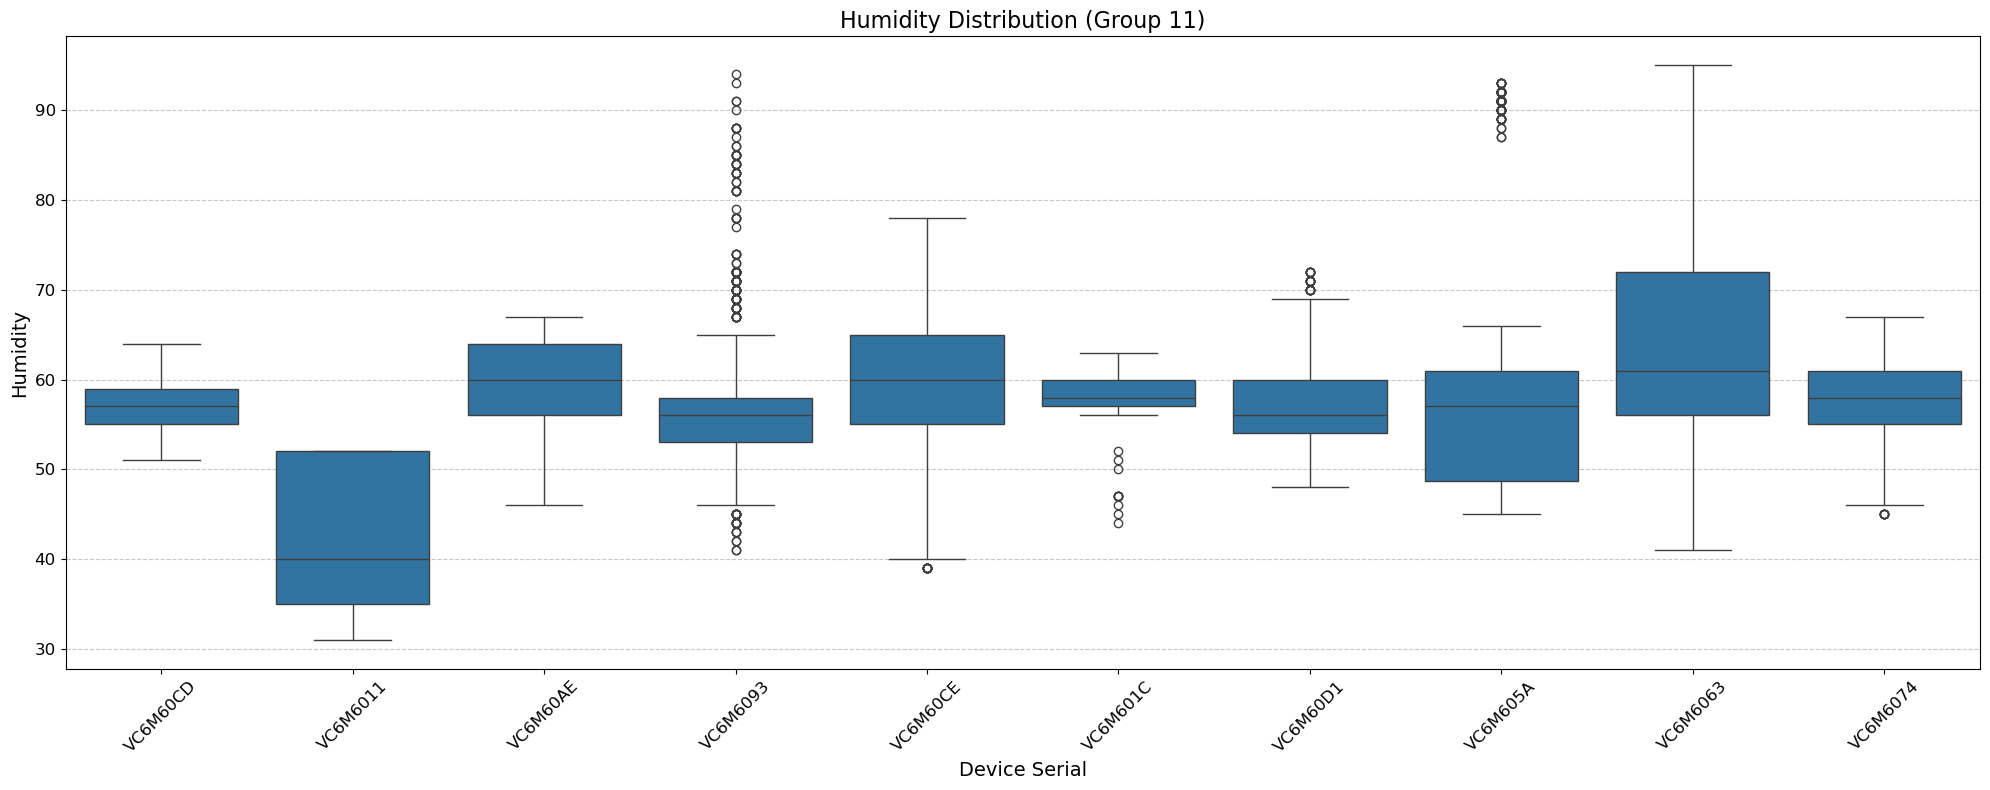


=== Group 11 통계량 ===
                count   mean    std   min    25%   50%   75%   max
device_serial                                                     
VC6M6011          5.0  42.00   9.67  31.0  35.00  40.0  52.0  52.0
VC6M601C         47.0  56.53   5.34  44.0  57.00  58.0  60.0  63.0
VC6M605A       1612.0  57.77  11.76  45.0  48.75  57.0  61.0  93.0
VC6M6063       5099.0  66.65  15.49  41.0  56.00  61.0  72.0  95.0
VC6M6074       1157.0  58.03   4.15  45.0  55.00  58.0  61.0  67.0
VC6M6093       1232.0  57.16   7.37  41.0  53.00  56.0  58.0  94.0
VC6M60AE        666.0  59.36   5.08  46.0  56.00  60.0  64.0  67.0
VC6M60CD       3087.0  57.21   2.77  51.0  55.00  57.0  59.0  64.0
VC6M60CE       2311.0  59.36   7.94  39.0  55.00  60.0  65.0  78.0
VC6M60D1       2182.0  56.91   4.15  48.0  54.00  56.0  60.0  72.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0 

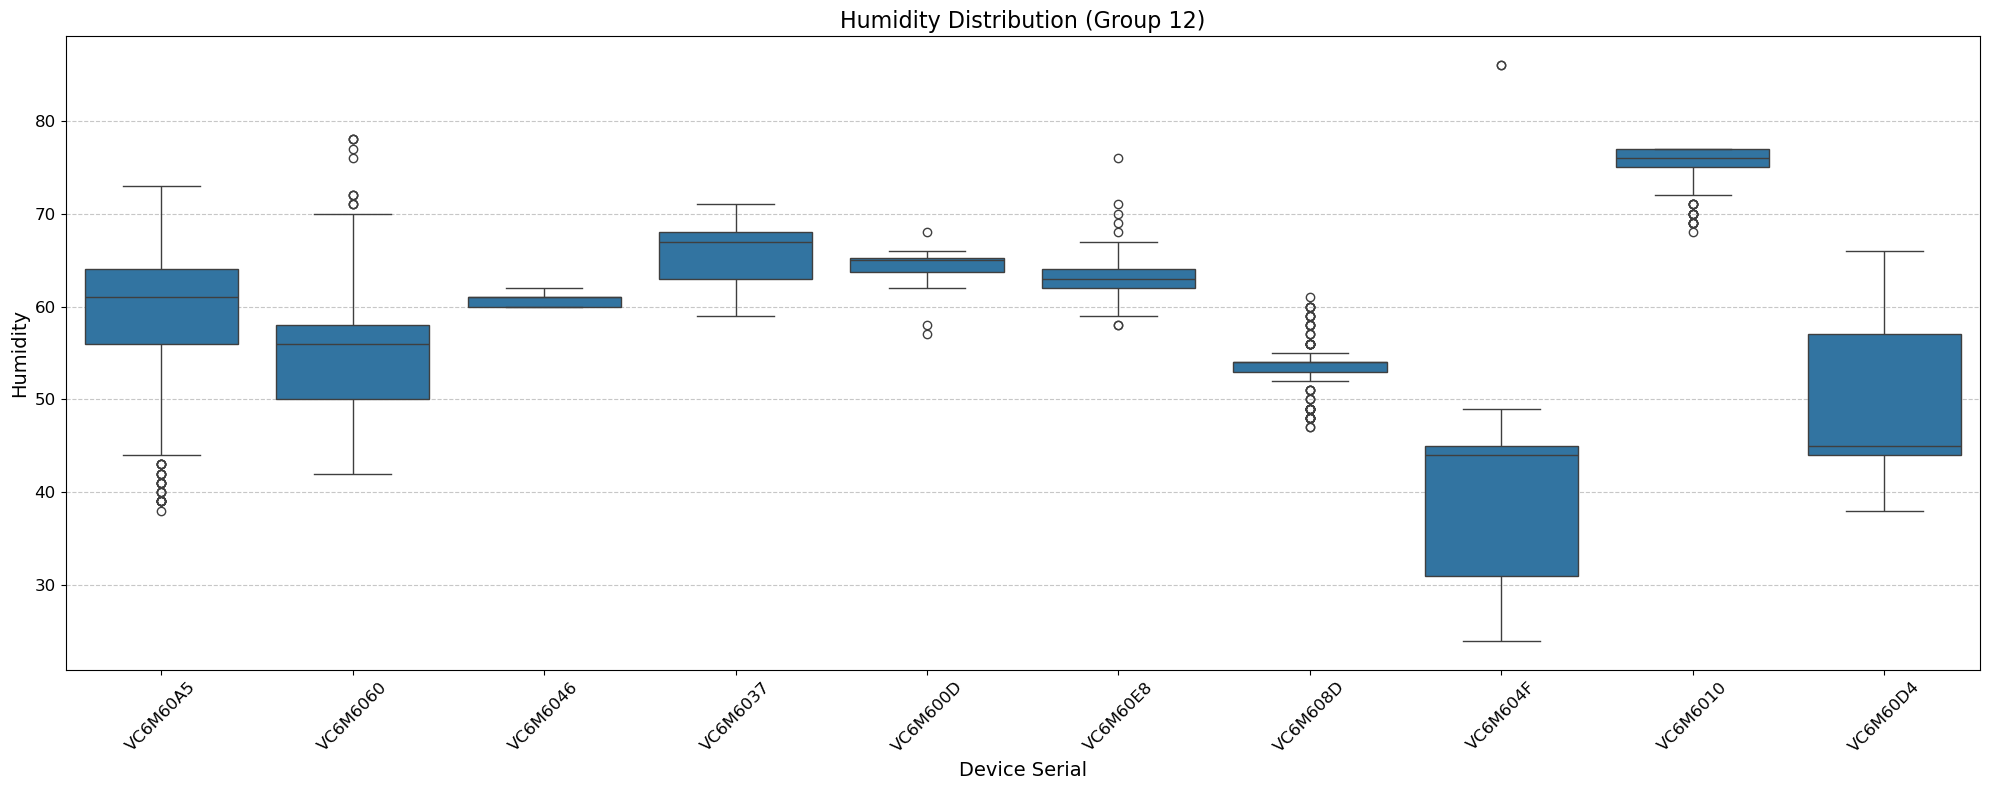


=== Group 12 통계량 ===
                count   mean   std   min    25%   50%    75%   max
device_serial                                                     
VC6M600D         36.0  64.33  2.11  57.0  63.75  65.0  65.25  68.0
VC6M6010        145.0  75.12  2.35  68.0  75.00  76.0  77.00  77.0
VC6M6037         34.0  66.03  3.20  59.0  63.00  67.0  68.00  71.0
VC6M6046          9.0  60.78  0.67  60.0  60.00  61.0  61.00  62.0
VC6M604F        446.0  39.45  8.53  24.0  31.00  44.0  45.00  86.0
VC6M6060        672.0  55.38  6.15  42.0  50.00  56.0  58.00  78.0
VC6M608D        201.0  53.57  2.62  47.0  53.00  54.0  54.00  61.0
VC6M60A5       1974.0  59.95  6.25  38.0  56.00  61.0  64.00  73.0
VC6M60D4       1130.0  49.61  8.32  38.0  44.00  45.0  57.00  66.0
VC6M60E8        453.0  63.15  1.67  58.0  62.00  63.0  64.00  76.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0 

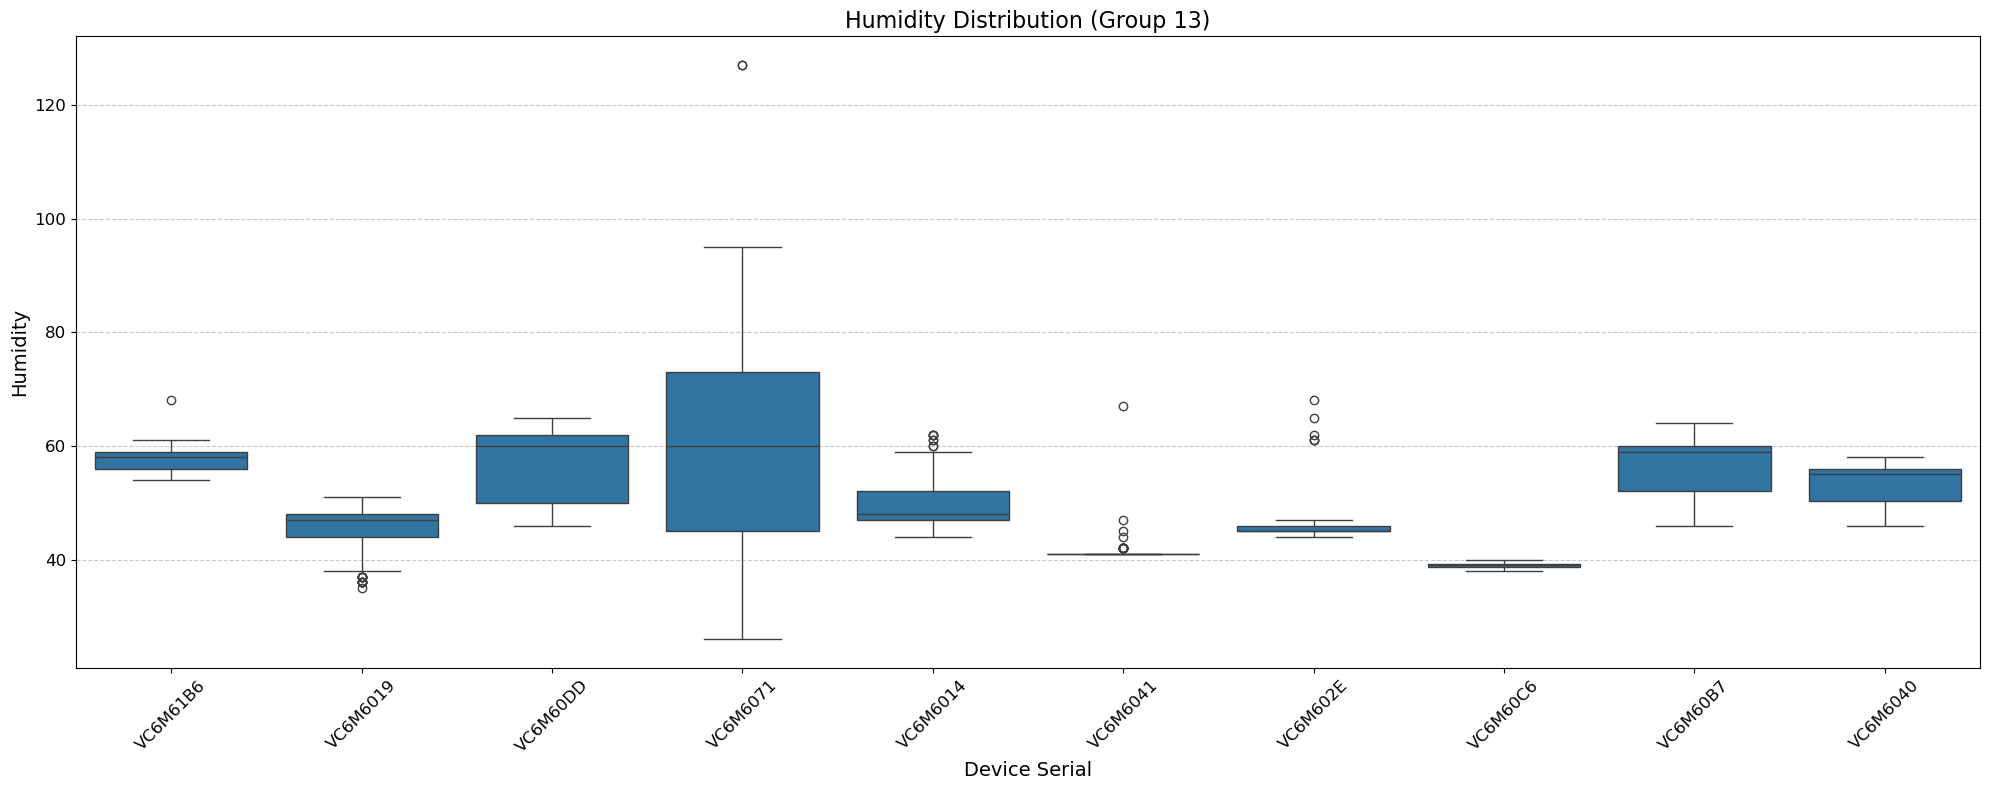


=== Group 13 통계량 ===
                count   mean    std   min    25%   50%    75%    max
device_serial                                                       
VC6M6014        157.0  49.81   4.31  44.0  47.00  48.0  52.00   62.0
VC6M6019        256.0  45.71   3.92  35.0  44.00  47.0  48.00   51.0
VC6M602E         97.0  46.59   4.35  44.0  45.00  45.0  46.00   68.0
VC6M6040        178.0  53.65   4.11  46.0  50.25  55.0  56.00   58.0
VC6M6041         89.0  41.62   2.86  41.0  41.00  41.0  41.00   67.0
VC6M6071       1006.0  56.85  16.70  26.0  45.00  60.0  73.00  127.0
VC6M60B7         66.0  56.82   4.86  46.0  52.00  59.0  60.00   64.0
VC6M60C6         24.0  39.00   0.72  38.0  38.75  39.0  39.25   40.0
VC6M60DD         13.0  56.69   7.02  46.0  50.00  60.0  62.00   65.0
VC6M61B6         35.0  57.91   2.42  54.0  56.00  58.0  59.00   68.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                       

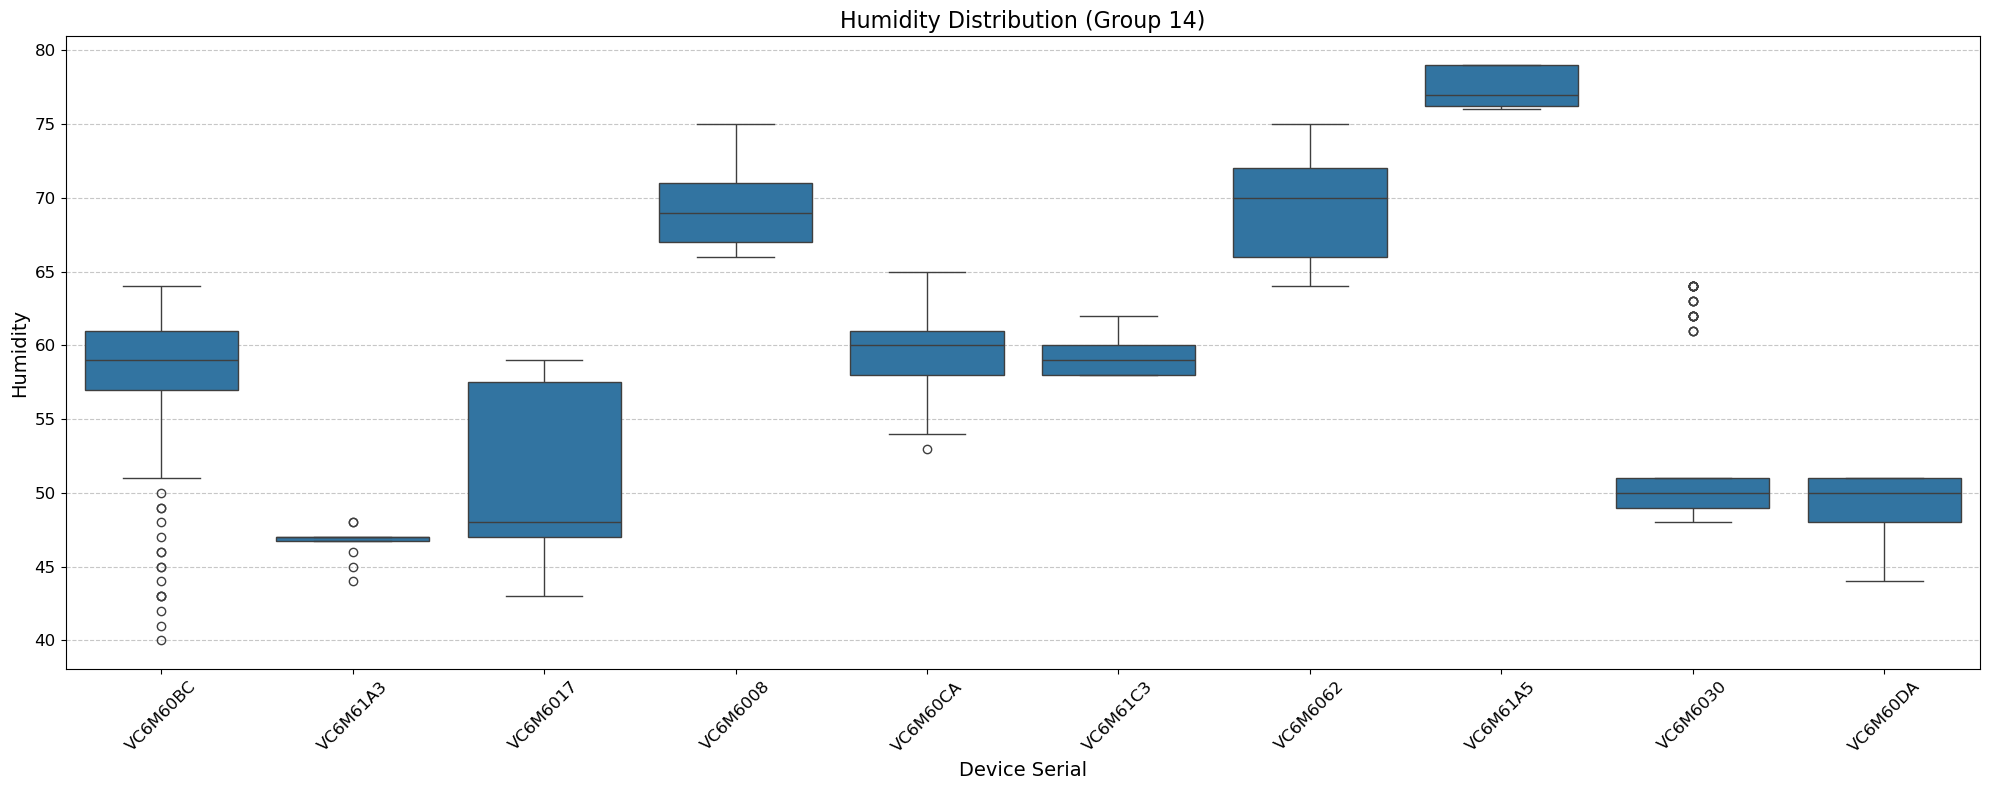


=== Group 14 통계량 ===
               count   mean   std   min    25%   50%   75%   max
device_serial                                                   
VC6M6008        76.0  69.08  2.29  66.0  67.00  69.0  71.0  75.0
VC6M6017        11.0  50.64  6.07  43.0  47.00  48.0  57.5  59.0
VC6M6030       117.0  52.28  5.31  48.0  49.00  50.0  51.0  64.0
VC6M6062       263.0  69.16  3.15  64.0  66.00  70.0  72.0  75.0
VC6M60BC       615.0  58.62  3.02  40.0  57.00  59.0  61.0  64.0
VC6M60CA       406.0  59.16  2.34  53.0  58.00  60.0  61.0  65.0
VC6M60DA        59.0  49.29  1.73  44.0  48.00  50.0  51.0  51.0
VC6M61A3        12.0  46.67  1.15  44.0  46.75  47.0  47.0  48.0
VC6M61A5        22.0  77.45  1.26  76.0  76.25  77.0  79.0  79.0
VC6M61C3        30.0  59.07  1.01  58.0  58.00  59.0  60.0  62.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0

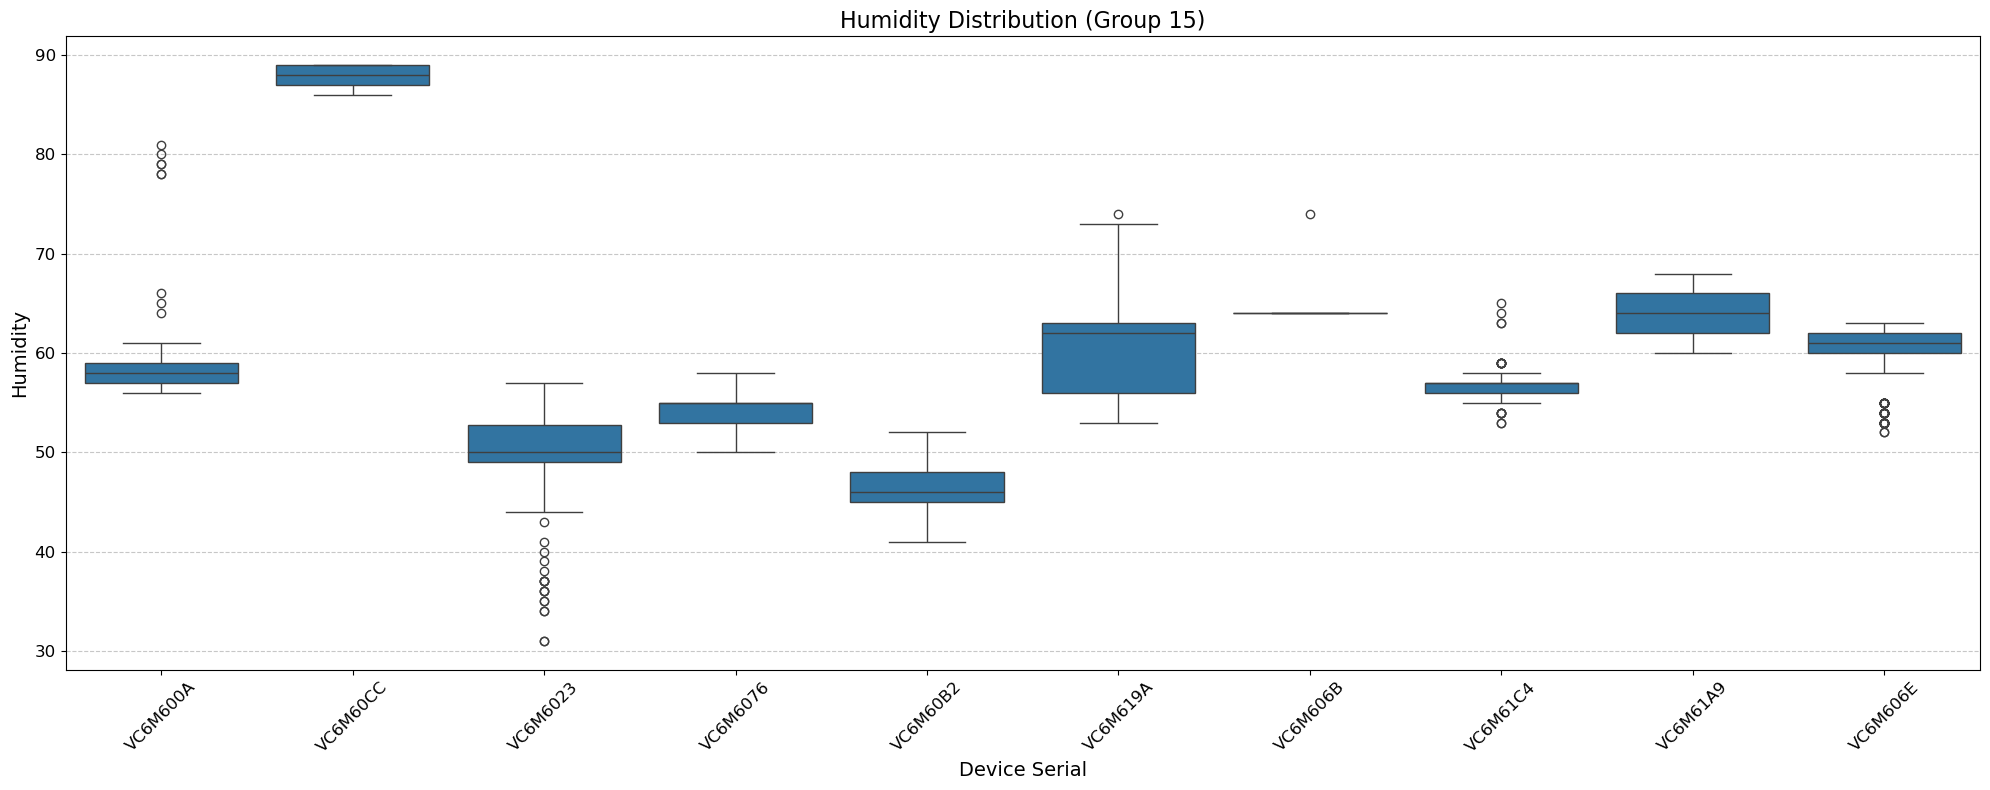


=== Group 15 통계량 ===
                count   mean   std   min   25%   50%    75%   max
device_serial                                                    
VC6M600A        106.0  59.46  5.16  56.0  57.0  58.0  59.00  81.0
VC6M6023        114.0  48.92  6.03  31.0  49.0  50.0  52.75  57.0
VC6M606B          5.0  66.00  4.47  64.0  64.0  64.0  64.00  74.0
VC6M606E        342.0  59.90  2.93  52.0  60.0  61.0  62.00  63.0
VC6M6076        141.0  54.01  1.34  50.0  53.0  55.0  55.00  58.0
VC6M60B2       1357.0  46.31  2.19  41.0  45.0  46.0  48.00  52.0
VC6M60CC         32.0  87.78  0.91  86.0  87.0  88.0  89.00  89.0
VC6M619A        234.0  61.02  5.15  53.0  56.0  62.0  63.00  74.0
VC6M61A9        219.0  64.34  2.23  60.0  62.0  64.0  66.00  68.0
VC6M61C4        150.0  56.77  1.69  53.0  56.0  57.0  57.00  65.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78

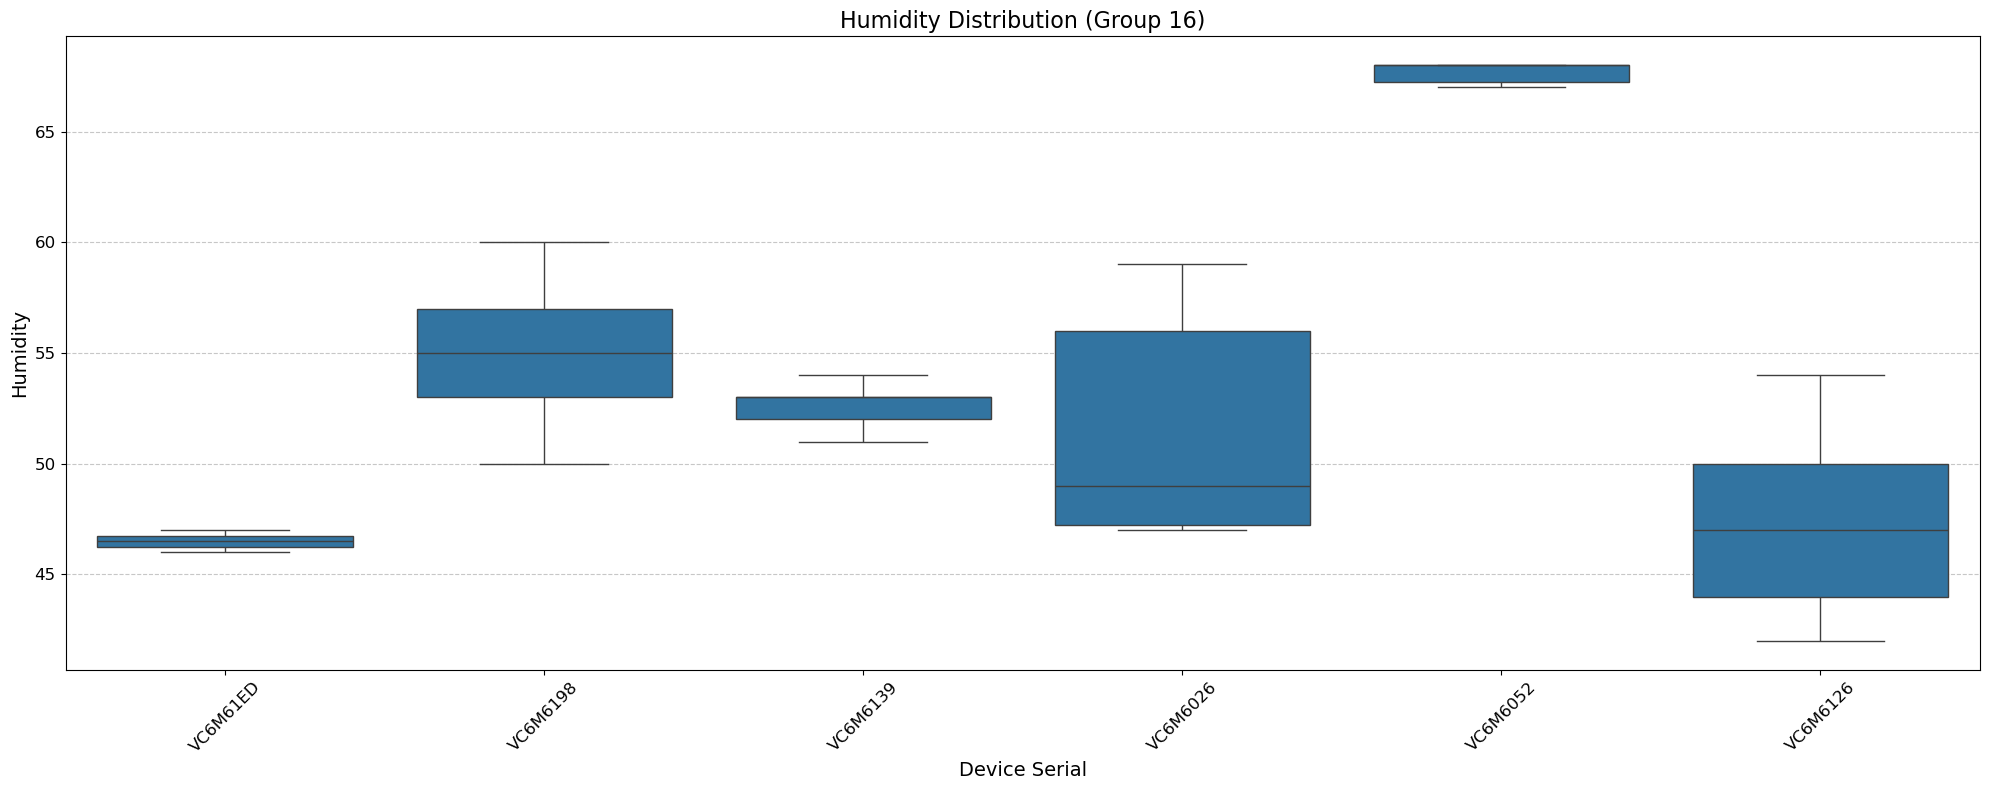


=== Group 16 통계량 ===
               count   mean   std   min    25%   50%    75%   max
device_serial                                                    
VC6M6026         6.0  51.50  5.54  47.0  47.25  49.0  56.00  59.0
VC6M6052         6.0  67.67  0.52  67.0  67.25  68.0  68.00  68.0
VC6M6126       378.0  47.62  3.28  42.0  44.00  47.0  50.00  54.0
VC6M6139         8.0  52.62  0.92  51.0  52.00  53.0  53.00  54.0
VC6M6198       100.0  54.97  2.48  50.0  53.00  55.0  57.00  60.0
VC6M61ED         2.0  46.50  0.71  46.0  46.25  46.5  46.75  47.0

추가 통계 정보:
[                count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1227.0  53.30  8.78  32.0  46.0    57.0  60.0  87.0   
VC6M6068         41.0  73.02  1.52  69.0  72.0    73.0  73.0  78.0   
VC6M6094        257.0  57.32  6.28  40.0  55.0    60.0  62.0  65.0   
VC6M609B         70.0  56.96  1.85  53.0  56.0    58.0  58.0  60.0   
VC6M60A2        28

In [14]:
# humidity 열의 데이터 타입을 float으로 변환
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

humidity_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    humi_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    sns.boxplot(x='device_serial', y='humidity', data=humi_data)
    
    # 그래프 제목과 레이블 설정
    plt.title(f'Humidity Distribution (Group {group_idx + 1})', fontsize=16)
    plt.xlabel('Device Serial', fontsize=14)
    plt.ylabel('Humidity', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # 그리드 추가
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = humi_data.groupby('device_serial')['humidity'].describe().round(2)
    print(stats)


    # Q1, Q3 및 IQR 계산
    Q1 = humi_data.groupby('device_serial')['humidity'].quantile(0.25)
    Q3 = humi_data.groupby('device_serial')['humidity'].quantile(0.75)
    IQR = Q3 - Q1

    # 개별 통계량 계산  
    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR


    # 결과 데이터프레임 생성
    result_stats = pd.DataFrame({
        'count': stats['count'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        'Q1': Q1,
        'median': stats['50%'],
        'Q3': Q3,
        'max': stats['max'],
        'Whisker Start': whisker_start,
        'Whisker End': whisker_end
    }).round(2)


    # 리스트에 추가
    humidity_stats.append(result_stats)

    print("\n추가 통계 정보:")
    print(humidity_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
humi_final_stats = pd.concat(humidity_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(humi_final_stats)

### 충격량 일탈 지정을 위한 G-Force 분포 비교

- 여기서 G값은 acc로 간주함
- acc는 가속도값으로 accx, accy, accz를 계산하여 산출함

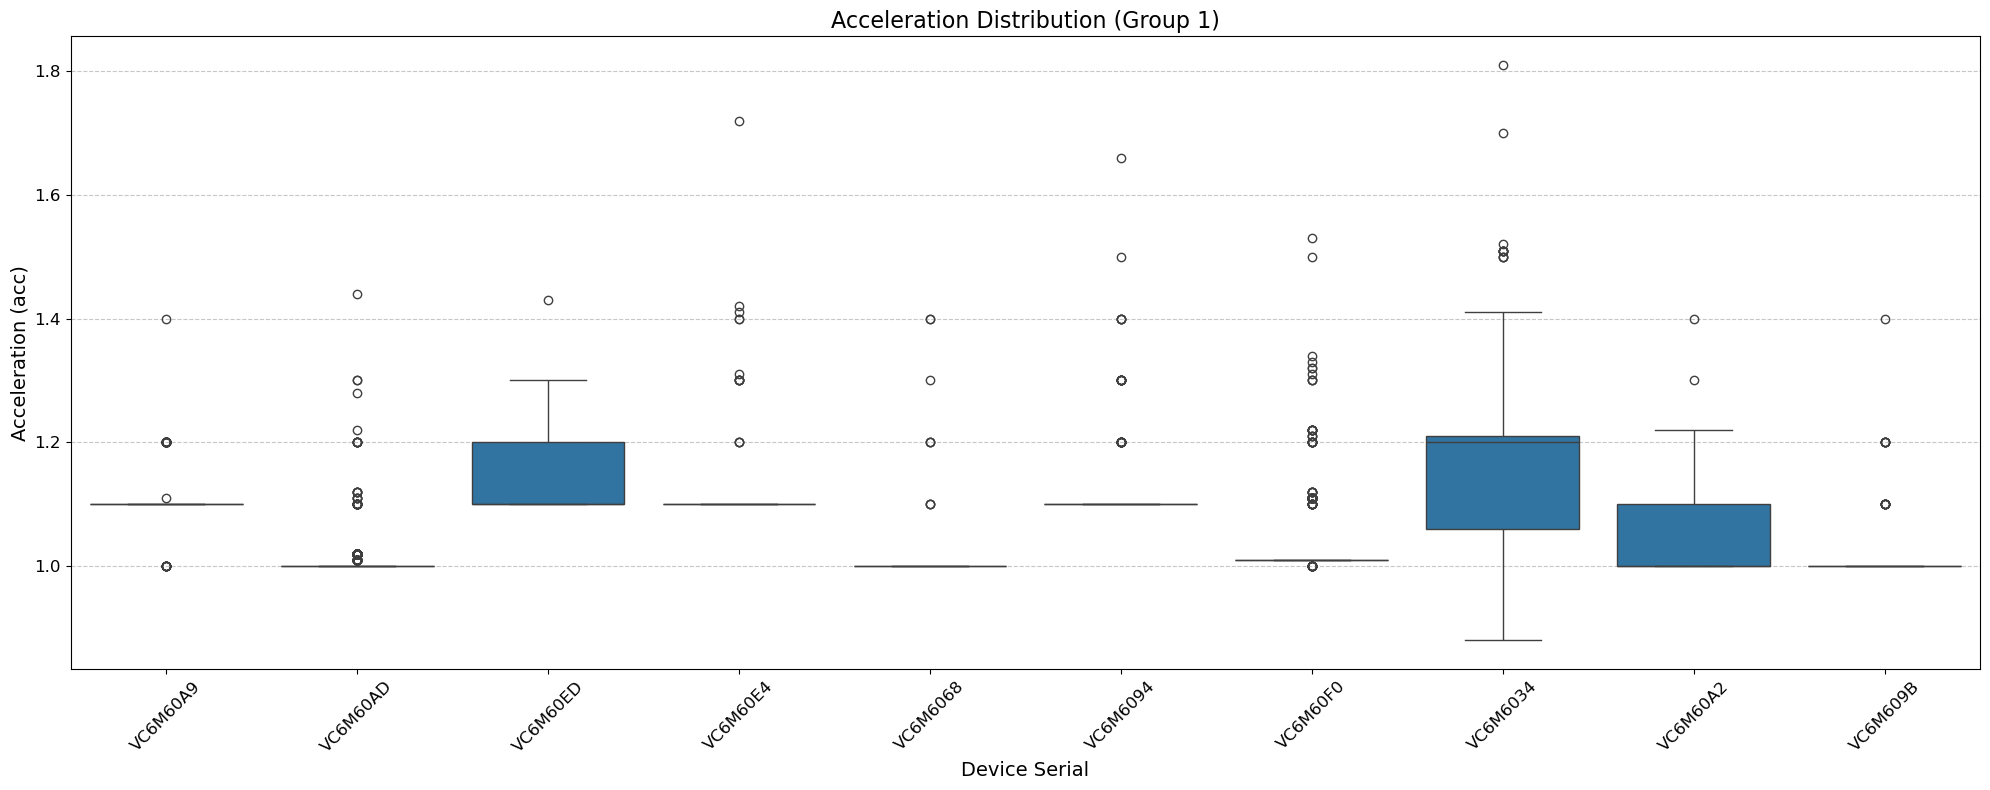


=== Group 1 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6034       1227.0  1.16  0.10  0.88  1.06  1.20  1.21  1.81
VC6M6068         41.0  1.05  0.11  1.00  1.00  1.00  1.00  1.40
VC6M6094        257.0  1.12  0.07  1.10  1.10  1.10  1.10  1.66
VC6M609B         70.0  1.04  0.08  1.00  1.00  1.00  1.00  1.40
VC6M60A2        288.0  1.04  0.06  1.00  1.00  1.00  1.10  1.40
VC6M60A9        230.0  1.11  0.05  1.00  1.10  1.10  1.10  1.40
VC6M60AD       5275.0  1.00  0.02  1.00  1.00  1.00  1.00  1.44
VC6M60E4         67.0  1.15  0.11  1.10  1.10  1.10  1.10  1.72
VC6M60ED         30.0  1.15  0.09  1.10  1.10  1.10  1.20  1.43
VC6M60F0       3749.0  1.02  0.03  1.00  1.01  1.01  1.01  1.53

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6034       1227.0  1.16  0.10  0.88  1.06    1.20  1.21  1

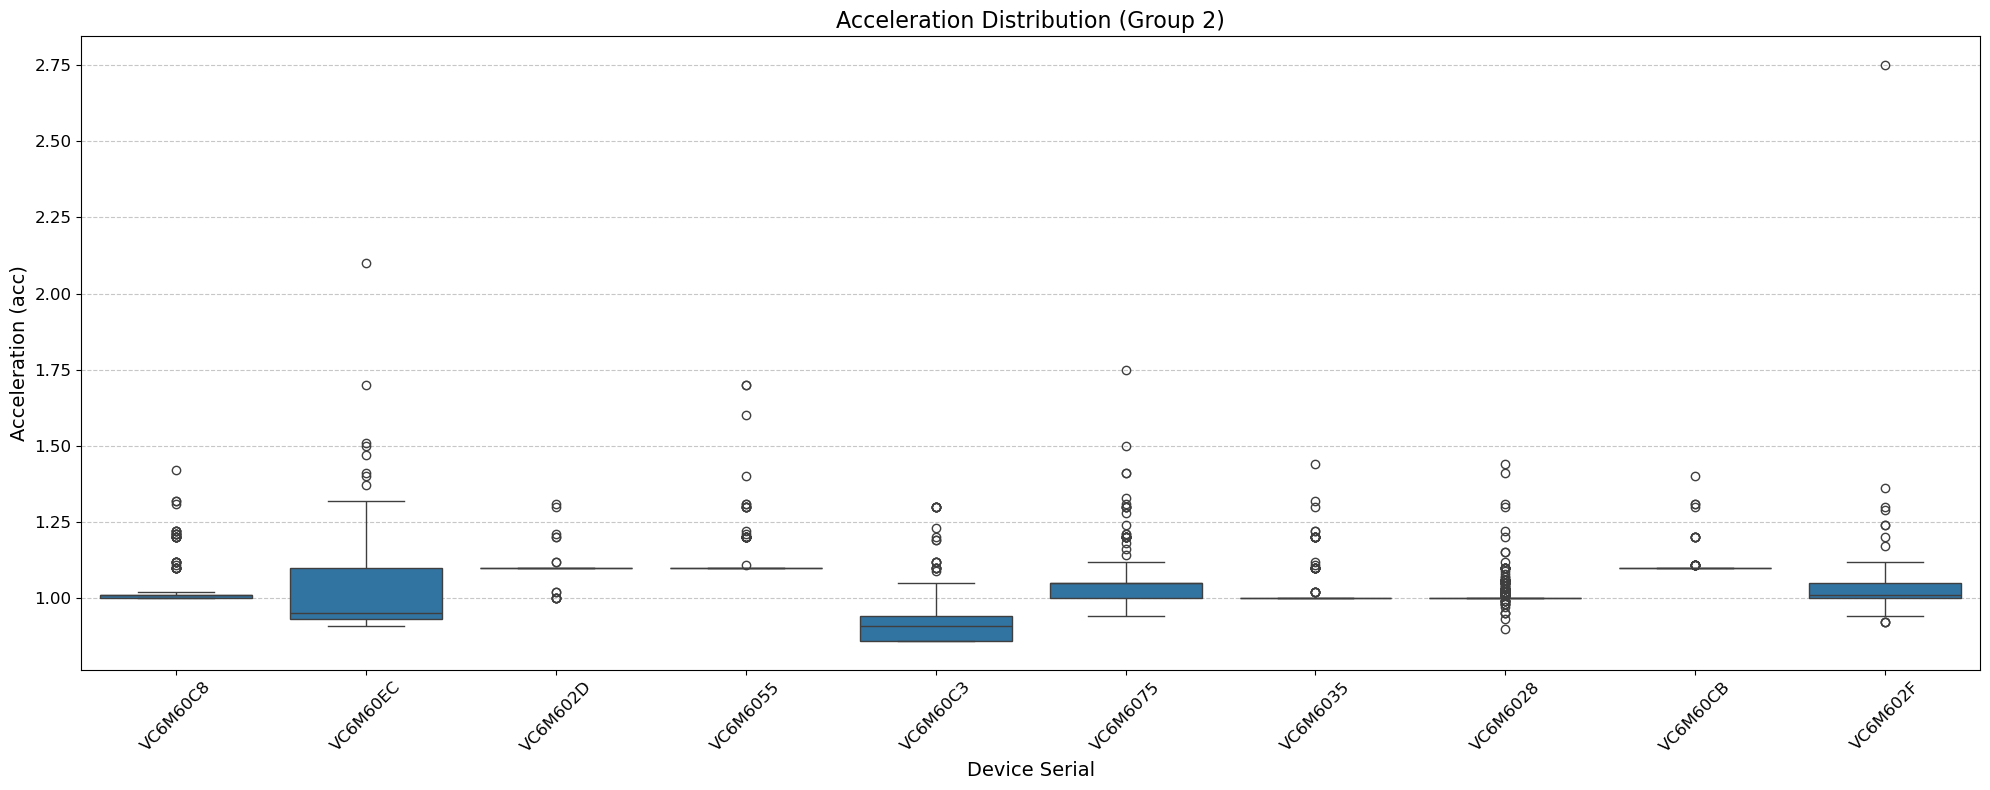


=== Group 2 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6028        690.0  1.01  0.04  0.90  1.00  1.00  1.00  1.44
VC6M602D        104.0  1.10  0.04  1.00  1.10  1.10  1.10  1.31
VC6M602F        192.0  1.03  0.14  0.92  1.00  1.01  1.05  2.75
VC6M6035        160.0  1.03  0.07  1.00  1.00  1.00  1.00  1.44
VC6M6055        961.0  1.11  0.04  1.10  1.10  1.10  1.10  1.70
VC6M6075       2927.0  1.03  0.05  0.94  1.00  1.05  1.05  1.75
VC6M60C3       2511.0  0.92  0.05  0.86  0.86  0.91  0.94  1.30
VC6M60C8       4599.0  1.01  0.02  1.00  1.00  1.01  1.01  1.42
VC6M60CB        171.0  1.11  0.04  1.10  1.10  1.10  1.10  1.40
VC6M60EC       1482.0  1.02  0.11  0.91  0.93  0.95  1.10  2.10

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6028        690.0  1.01  0.04  0.90  1.00    1.00  1.00  1

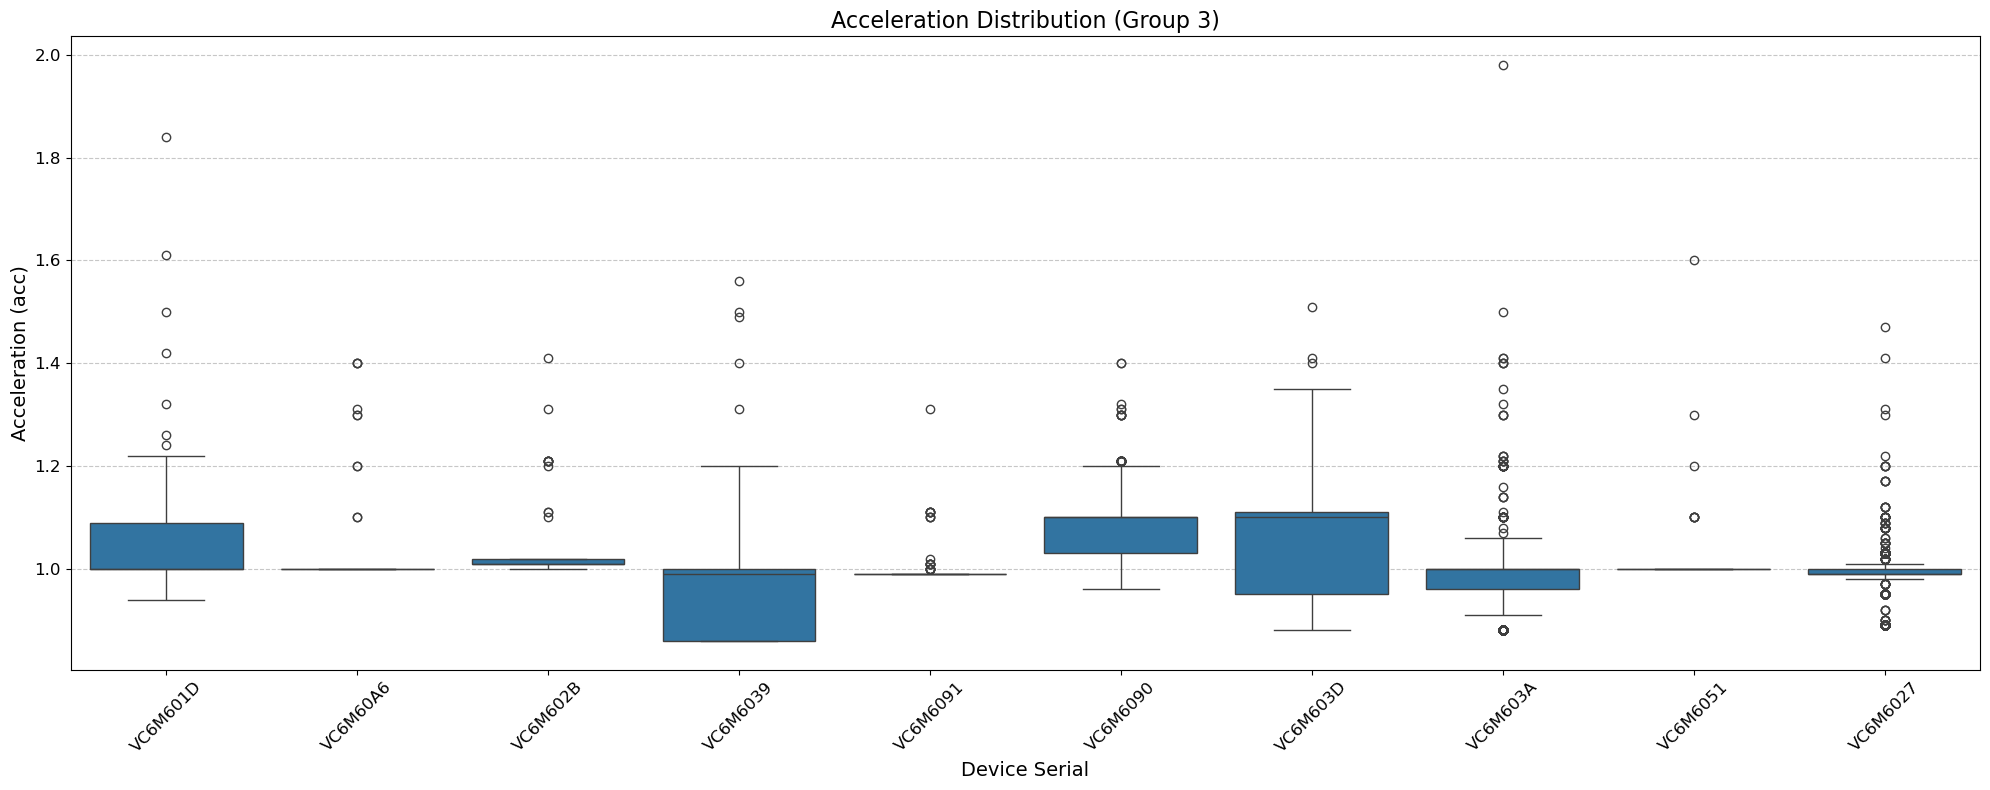


=== Group 3 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M601D        690.0  1.03  0.07  0.94  1.00  1.00  1.09  1.84
VC6M6027       3735.0  0.99  0.03  0.89  0.99  0.99  1.00  1.47
VC6M602B        409.0  1.02  0.04  1.00  1.01  1.01  1.02  1.41
VC6M6039       1885.0  0.96  0.08  0.86  0.86  0.99  1.00  1.56
VC6M603A       2832.0  0.98  0.06  0.88  0.96  1.00  1.00  1.98
VC6M603D       1197.0  1.07  0.11  0.88  0.95  1.10  1.11  1.51
VC6M6051        201.0  1.01  0.05  1.00  1.00  1.00  1.00  1.60
VC6M6090       3831.0  1.08  0.06  0.96  1.03  1.10  1.10  1.40
VC6M6091        598.0  0.99  0.02  0.99  0.99  0.99  0.99  1.31
VC6M60A6        528.0  1.01  0.04  1.00  1.00  1.00  1.00  1.40

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M601D        690.0  1.03  0.07  0.94  1.00    1.00  1.09  1

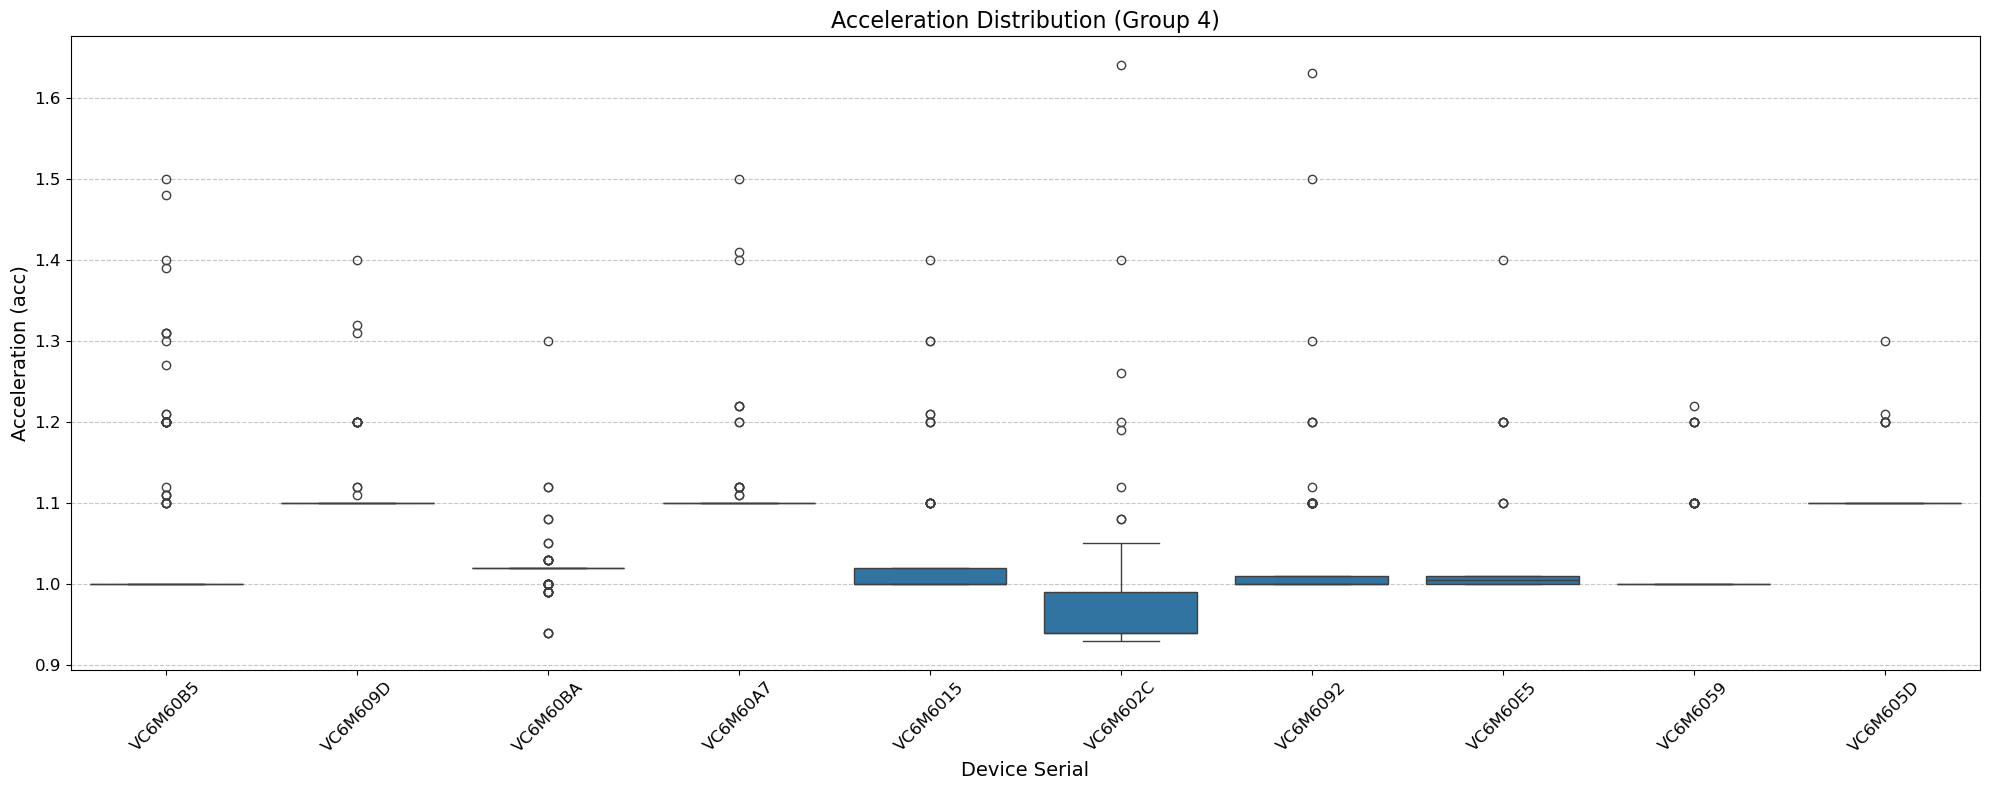


=== Group 4 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6015        88.0  1.03  0.08  1.00  1.00  1.00  1.02  1.40
VC6M602C       126.0  0.97  0.09  0.93  0.94  0.94  0.99  1.64
VC6M6059       415.0  1.01  0.03  1.00  1.00  1.00  1.00  1.22
VC6M605D       227.0  1.10  0.02  1.10  1.10  1.10  1.10  1.30
VC6M6092       199.0  1.03  0.07  1.00  1.00  1.00  1.01  1.63
VC6M609D       109.0  1.11  0.05  1.10  1.10  1.10  1.10  1.40
VC6M60A7       204.0  1.11  0.04  1.10  1.10  1.10  1.10  1.50
VC6M60B5       826.0  1.01  0.05  1.00  1.00  1.00  1.00  1.50
VC6M60BA       110.0  1.02  0.04  0.94  1.02  1.02  1.02  1.30
VC6M60E5        46.0  1.04  0.08  1.00  1.00  1.00  1.01  1.40

추가 통계 정보:
               count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                      
VC6M6015        88.0  1.03  0.08  1.00  1.00    1.00  1.02  1.40   
VC6M602C

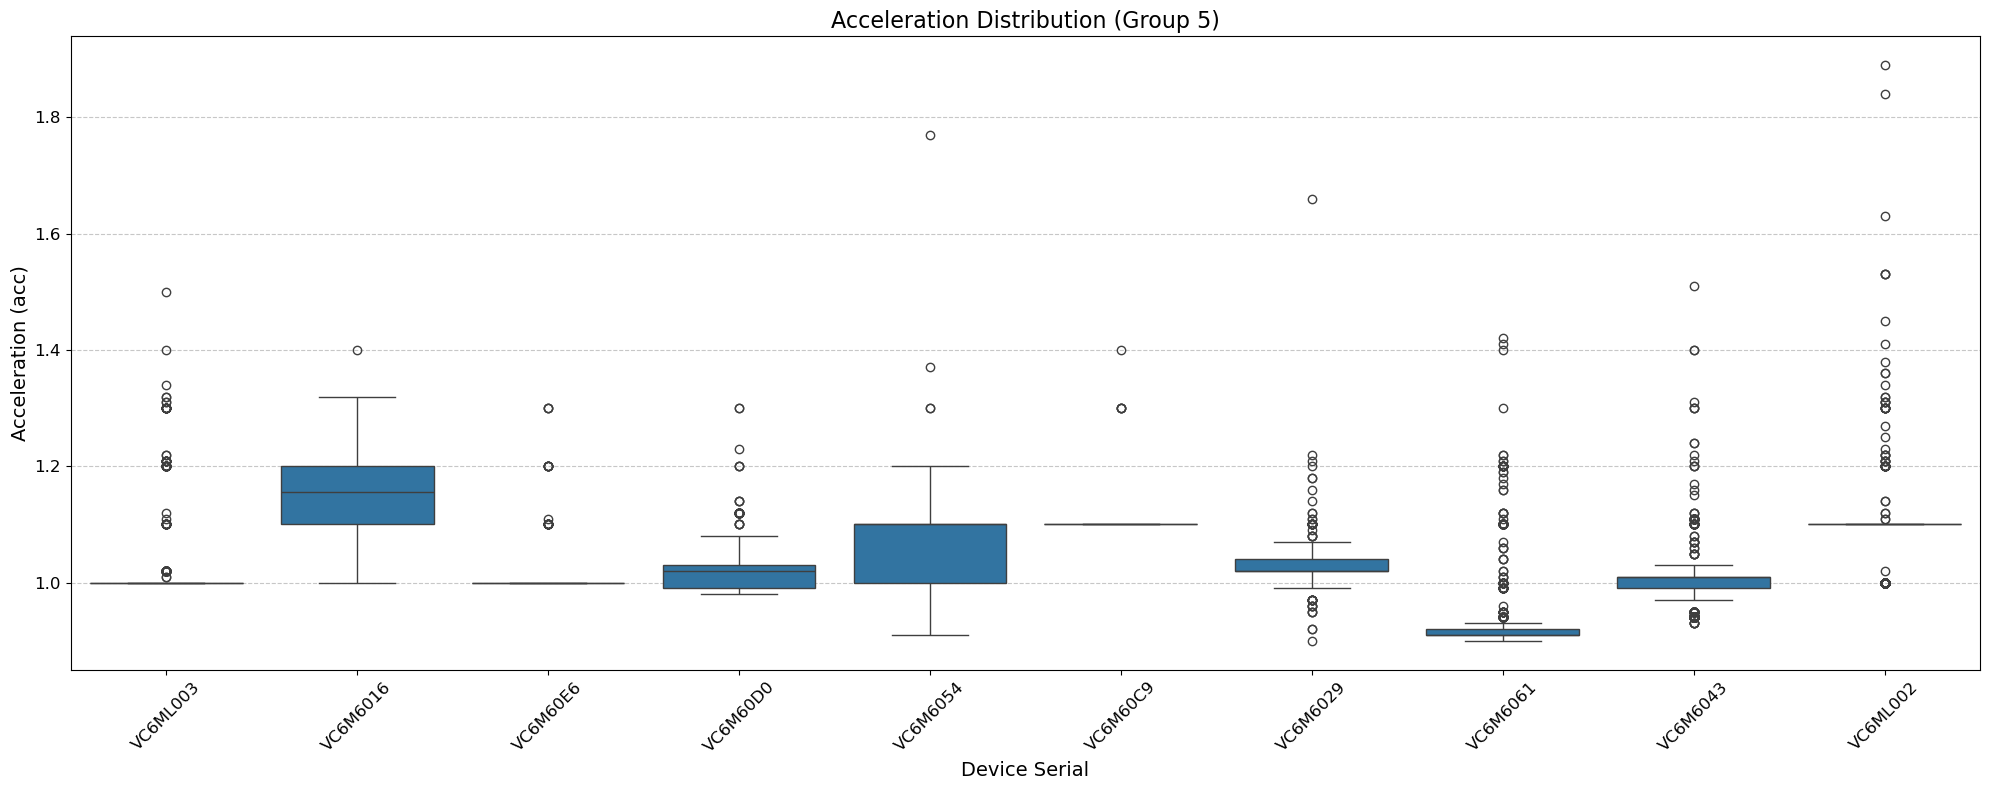


=== Group 5 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6016         14.0  1.15  0.12  1.00  1.10  1.16  1.20  1.40
VC6M6029        192.0  1.03  0.07  0.90  1.02  1.02  1.04  1.66
VC6M6043       1662.0  1.00  0.05  0.93  0.99  1.01  1.01  1.51
VC6M6054       2767.0  1.05  0.07  0.91  1.00  1.10  1.10  1.77
VC6M6061       2820.0  0.92  0.04  0.90  0.91  0.91  0.92  1.42
VC6M60C9         96.0  1.11  0.05  1.10  1.10  1.10  1.10  1.40
VC6M60D0       1059.0  1.02  0.04  0.98  0.99  1.02  1.03  1.30
VC6M60E6        583.0  1.01  0.04  1.00  1.00  1.00  1.00  1.30
VC6ML002       1267.0  1.09  0.06  1.00  1.10  1.10  1.10  1.89
VC6ML003       1536.0  1.01  0.05  1.00  1.00  1.00  1.00  1.50

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6016         14.0  1.15  0.12  1.00  1.10    1.16  1.20  1

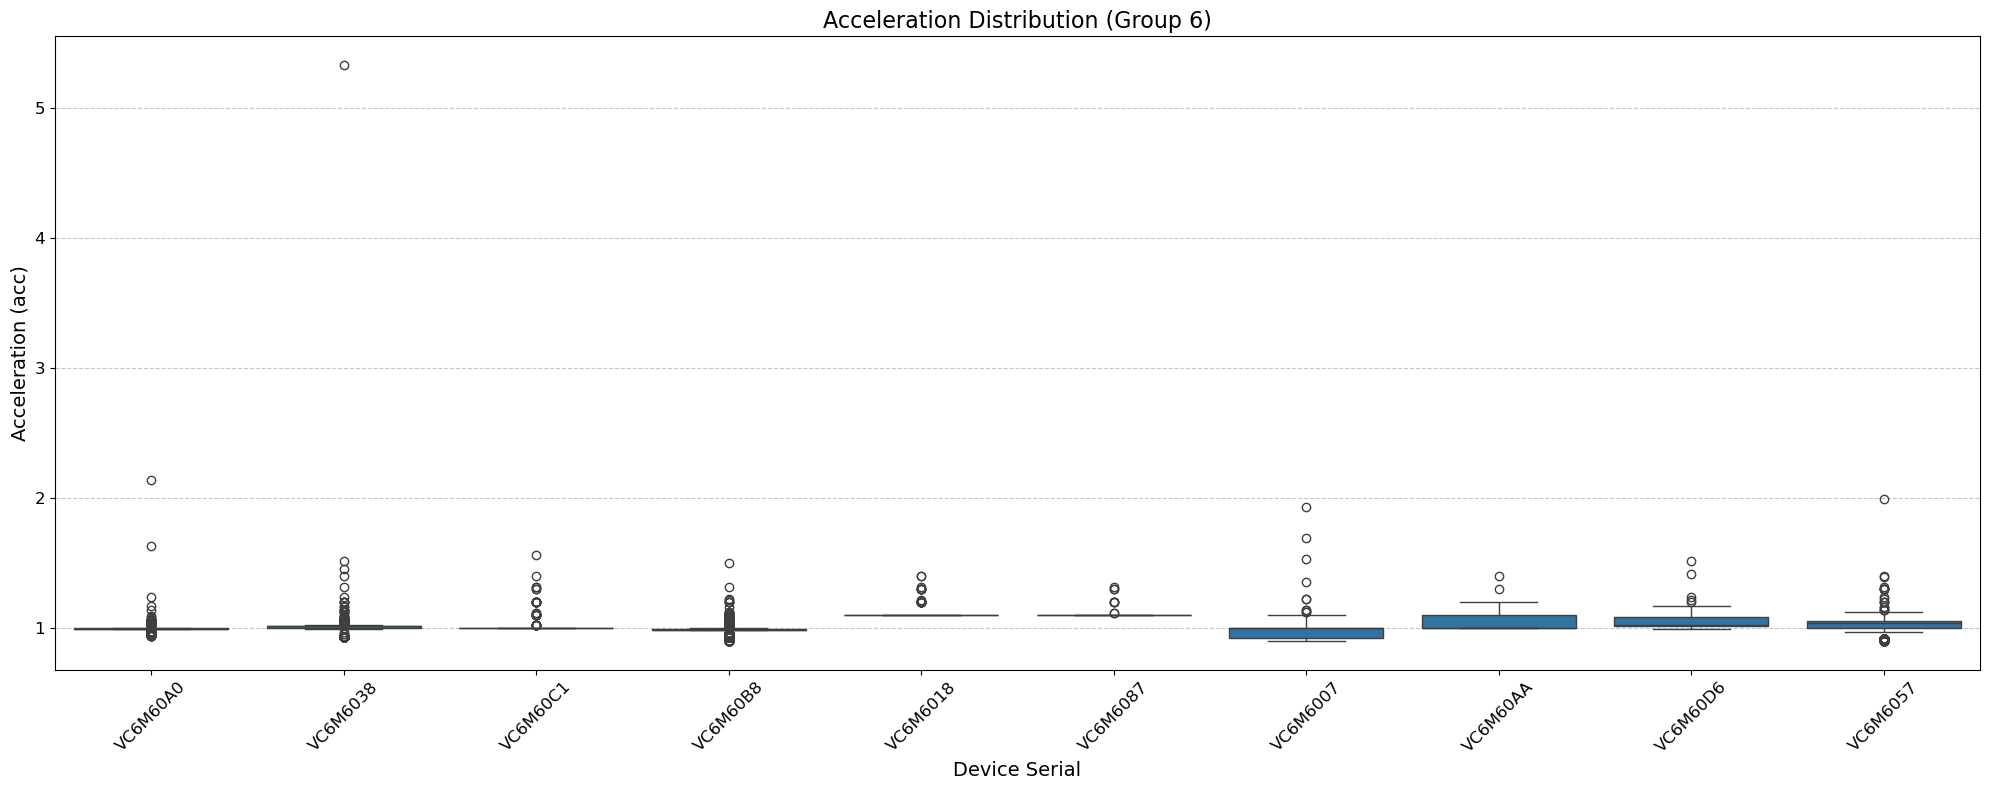


=== Group 6 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6007       3923.0  0.99  0.05  0.90  0.92  1.00  1.00  1.93
VC6M6018        792.0  1.11  0.03  1.10  1.10  1.10  1.10  1.40
VC6M6038       2879.0  1.01  0.09  0.93  1.00  1.01  1.01  5.33
VC6M6057       3056.0  1.03  0.05  0.90  1.00  1.04  1.05  1.99
VC6M6087        140.0  1.11  0.03  1.10  1.10  1.10  1.10  1.31
VC6M60A0        606.0  1.00  0.06  0.94  0.99  0.99  1.00  2.14
VC6M60AA        233.0  1.03  0.06  1.00  1.00  1.00  1.10  1.40
VC6M60B8       2595.0  0.99  0.03  0.90  0.98  0.98  0.99  1.50
VC6M60C1        690.0  1.01  0.05  1.00  1.00  1.00  1.00  1.56
VC6M60D6       2051.0  1.04  0.04  0.99  1.01  1.02  1.08  1.51

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6007       3923.0  0.99  0.05  0.90  0.92    1.00  1.00  1

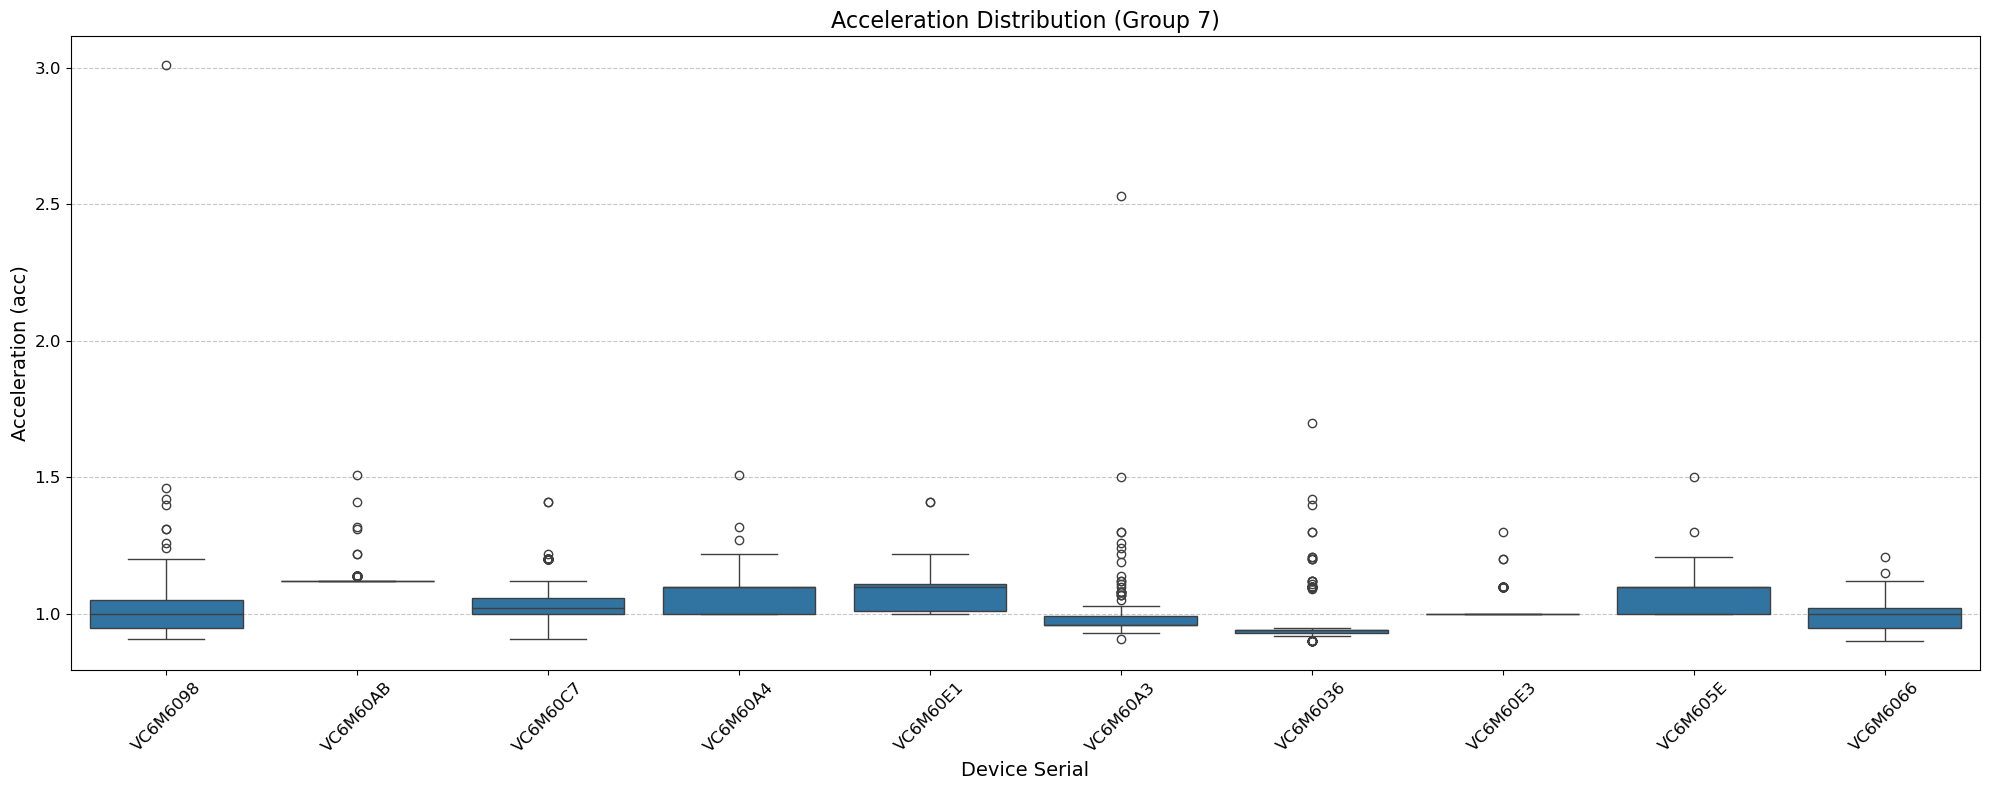


=== Group 7 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6036       1114.0  0.95  0.05  0.90  0.93  0.94  0.94  1.70
VC6M605E        254.0  1.08  0.07  1.00  1.00  1.10  1.10  1.50
VC6M6066        239.0  0.99  0.06  0.90  0.95  1.00  1.02  1.21
VC6M6098       1033.0  1.01  0.09  0.91  0.95  1.00  1.05  3.01
VC6M60A3        144.0  1.00  0.15  0.91  0.96  0.96  0.99  2.53
VC6M60A4        978.0  1.08  0.07  1.00  1.00  1.10  1.10  1.51
VC6M60AB        354.0  1.13  0.03  1.12  1.12  1.12  1.12  1.51
VC6M60C7       3228.0  1.03  0.05  0.91  1.00  1.02  1.06  1.41
VC6M60E1         26.0  1.11  0.11  1.00  1.01  1.10  1.11  1.41
VC6M60E3        249.0  1.02  0.04  1.00  1.00  1.00  1.00  1.30

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6036       1114.0  0.95  0.05  0.90  0.93    0.94  0.94  1

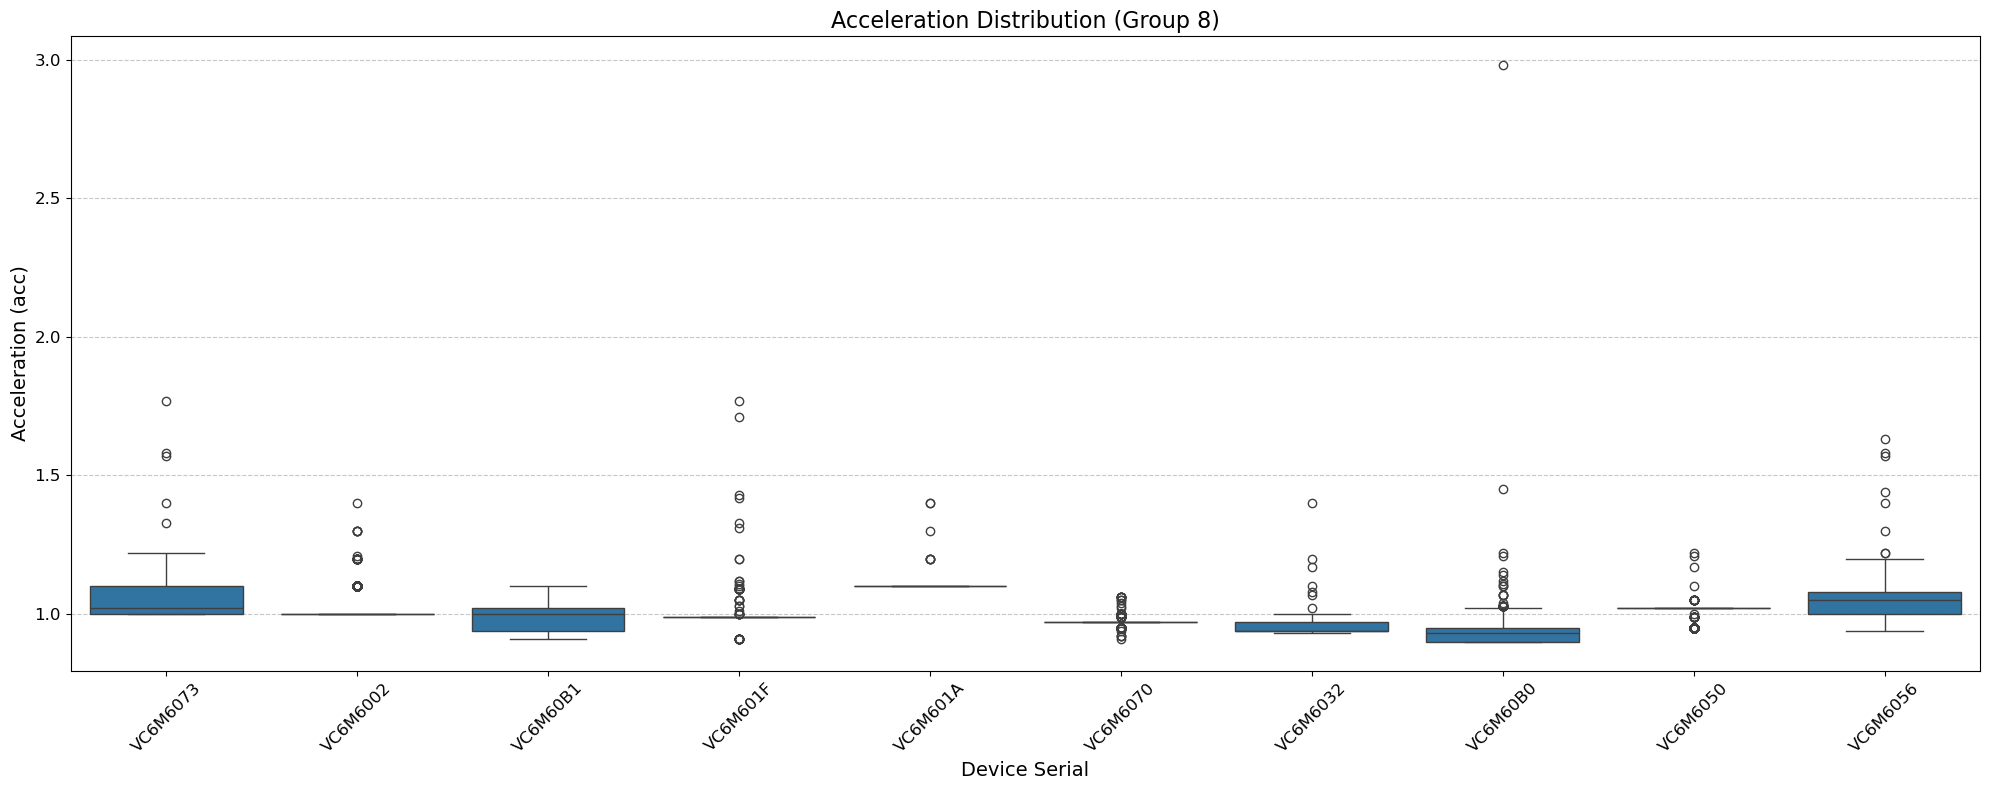


=== Group 8 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6002       1021.0  1.02  0.05  1.00  1.00  1.00  1.00  1.40
VC6M601A         58.0  1.12  0.06  1.10  1.10  1.10  1.10  1.40
VC6M601F        400.0  1.01  0.08  0.91  0.99  0.99  0.99  1.77
VC6M6032        120.0  0.96  0.06  0.93  0.94  0.94  0.97  1.40
VC6M6050       1096.0  1.01  0.03  0.95  1.02  1.02  1.02  1.22
VC6M6056       4039.0  1.05  0.05  0.94  1.00  1.05  1.08  1.63
VC6M6070        575.0  0.97  0.02  0.91  0.97  0.97  0.97  1.06
VC6M6073       2161.0  1.05  0.06  1.00  1.00  1.02  1.10  1.77
VC6M60B0        606.0  0.94  0.10  0.90  0.90  0.93  0.95  2.98
VC6M60B1        294.0  0.98  0.04  0.91  0.94  1.00  1.02  1.10

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6002       1021.0  1.02  0.05  1.00  1.00    1.00  1.00  1

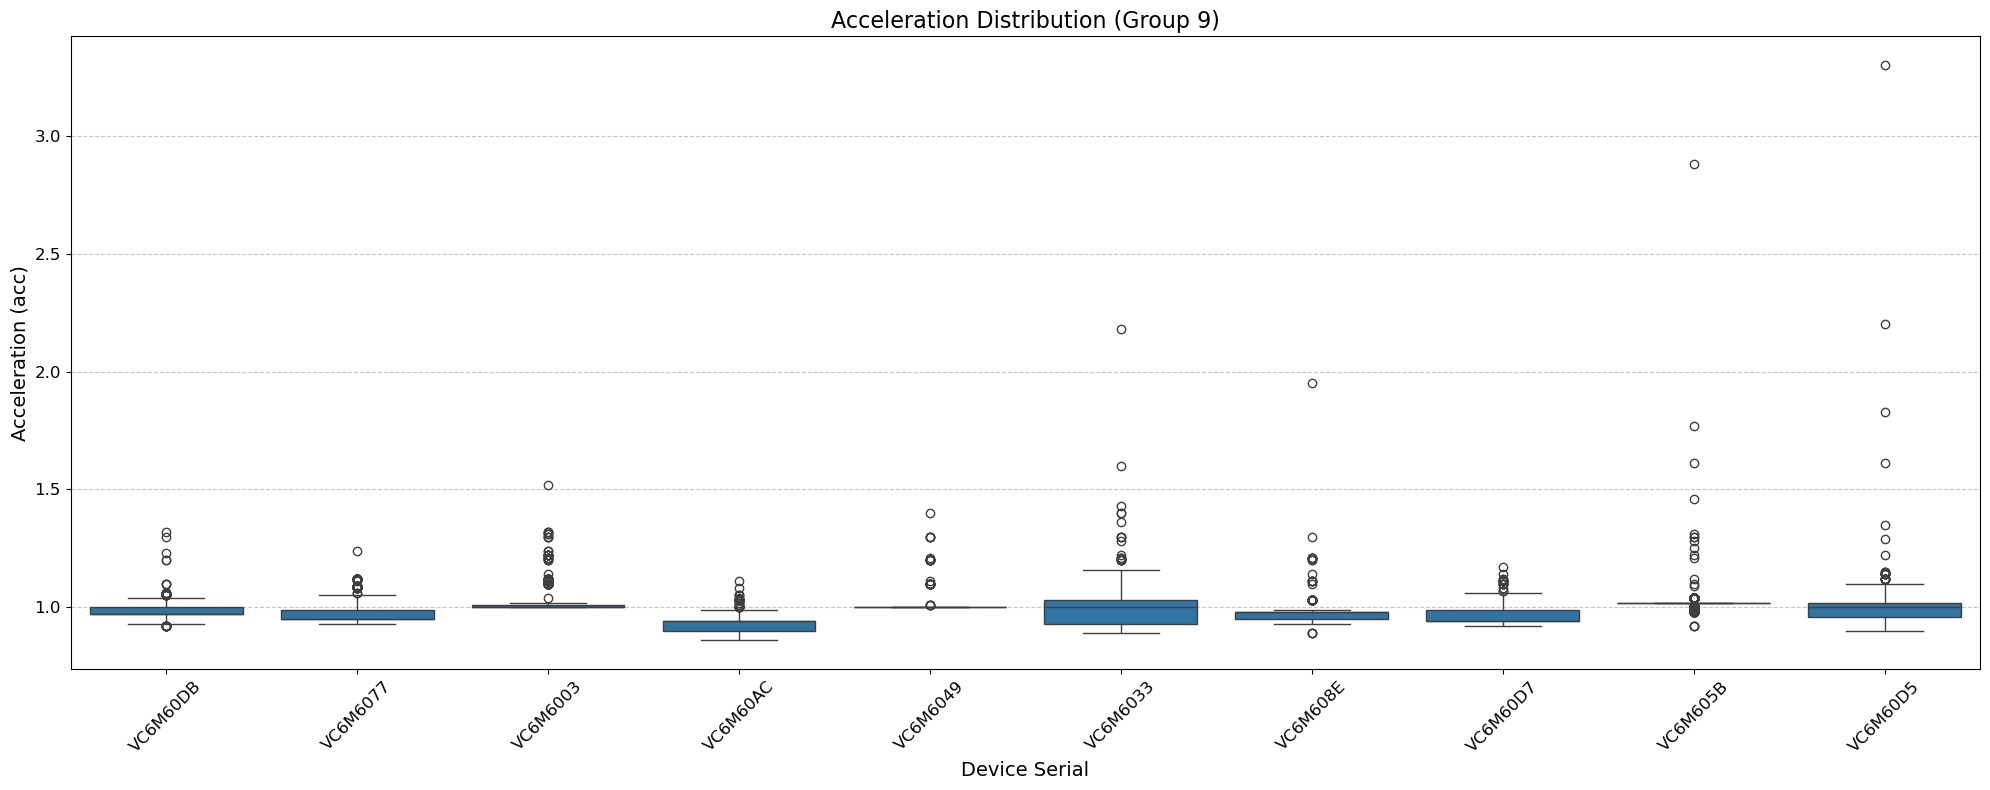


=== Group 9 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6003        830.0  1.02  0.06  1.00  1.00  1.00  1.01  1.52
VC6M6033       1285.0  0.99  0.07  0.89  0.93  1.00  1.03  2.18
VC6M6049        707.0  1.01  0.04  1.00  1.00  1.00  1.00  1.40
VC6M605B       3487.0  1.02  0.04  0.92  1.02  1.02  1.02  2.88
VC6M6077       2004.0  0.98  0.04  0.93  0.95  0.95  0.99  1.24
VC6M608E       1434.0  0.97  0.04  0.89  0.95  0.98  0.98  1.95
VC6M60AC       1881.0  0.93  0.03  0.86  0.90  0.94  0.94  1.11
VC6M60D5       1650.0  1.00  0.09  0.90  0.96  1.00  1.02  3.30
VC6M60D7       1707.0  0.97  0.04  0.92  0.94  0.94  0.99  1.17
VC6M60DB       1020.0  0.98  0.03  0.92  0.97  0.97  1.00  1.32

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6003        830.0  1.02  0.06  1.00  1.00    1.00  1.01  1

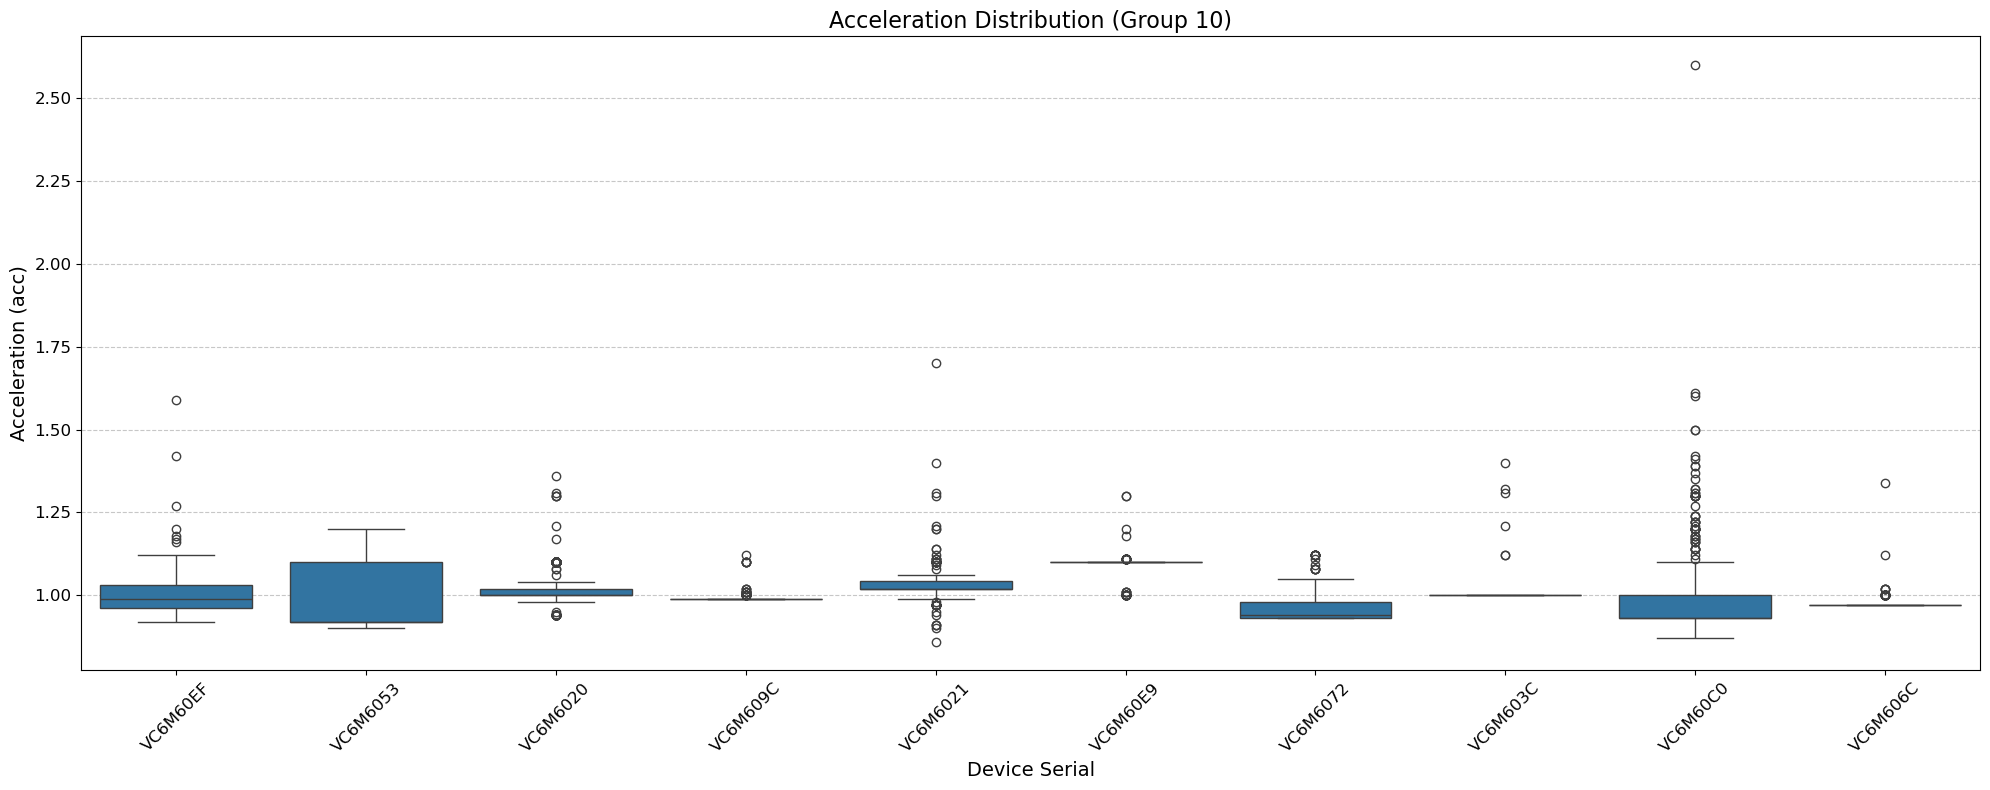


=== Group 10 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6020        691.0  1.02  0.05  0.94  1.00  1.00  1.02  1.36
VC6M6021        200.0  1.04  0.08  0.86  1.02  1.02  1.04  1.70
VC6M603C       1253.0  1.00  0.02  1.00  1.00  1.00  1.00  1.40
VC6M6053        405.0  0.99  0.09  0.90  0.92  0.92  1.10  1.20
VC6M606C        197.0  0.98  0.03  0.97  0.97  0.97  0.97  1.34
VC6M6072       2409.0  0.95  0.03  0.93  0.93  0.94  0.98  1.12
VC6M609C        431.0  0.99  0.01  0.99  0.99  0.99  0.99  1.12
VC6M60C0       3744.0  0.96  0.07  0.87  0.93  0.93  1.00  2.60
VC6M60E9        412.0  1.09  0.03  1.00  1.10  1.10  1.10  1.30
VC6M60EF       4031.0  0.99  0.04  0.92  0.96  0.99  1.03  1.59

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6020        691.0  1.02  0.05  0.94  1.00    1.00  1.02  

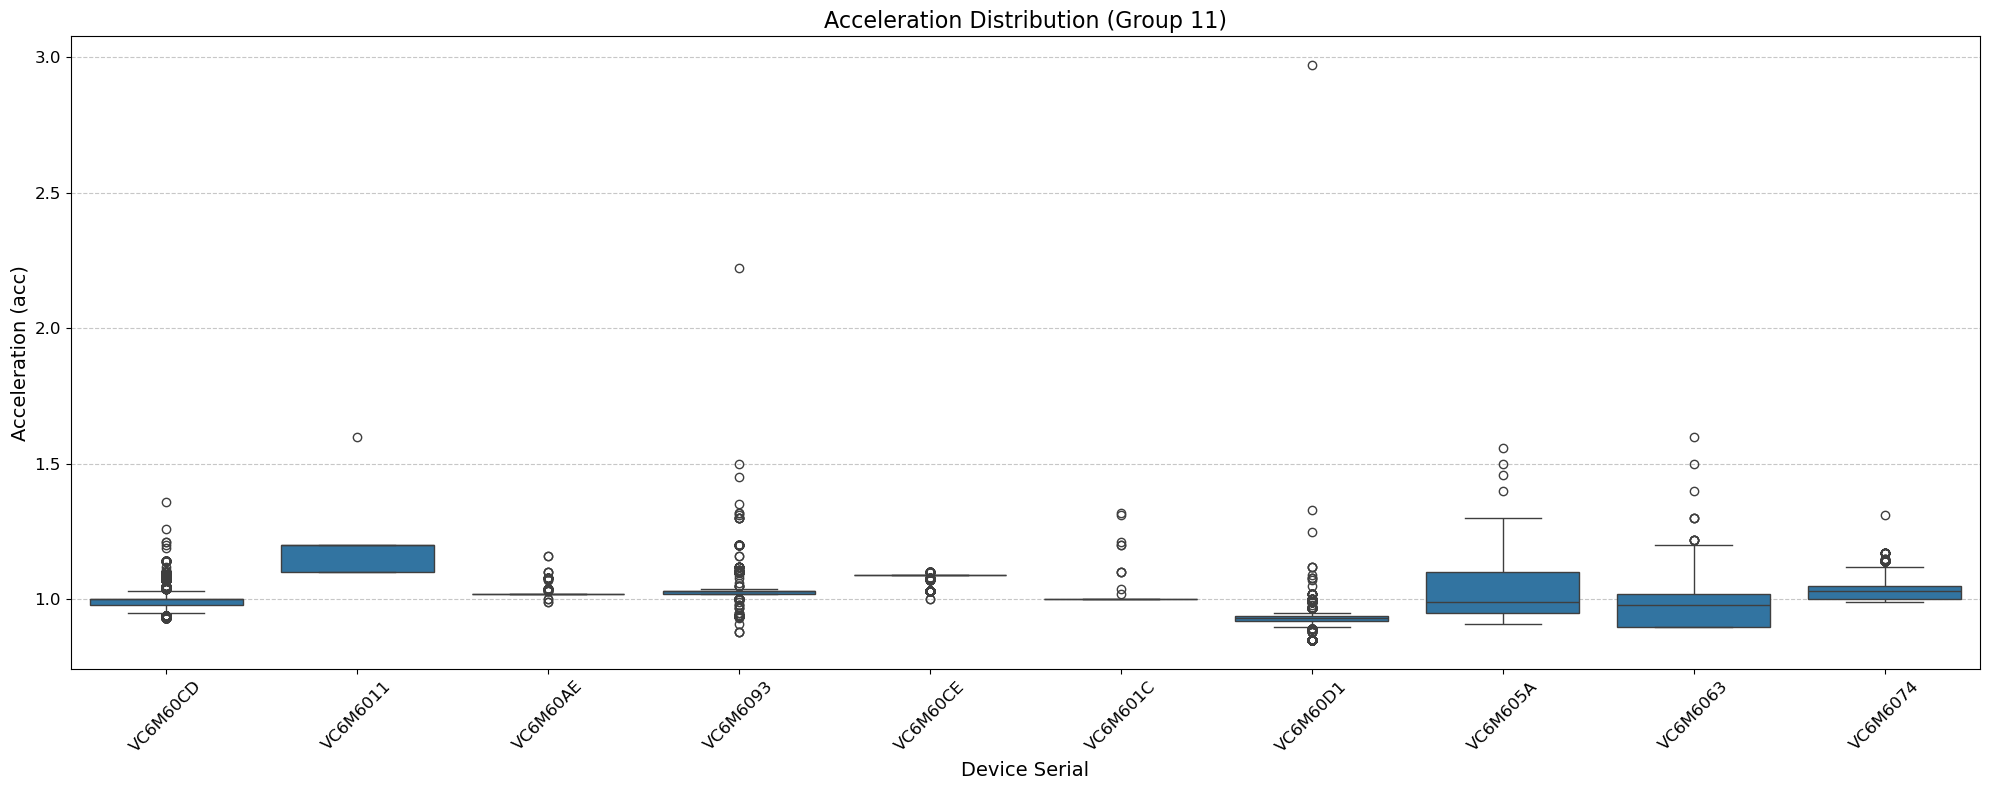


=== Group 11 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6011          5.0  1.24  0.21  1.10  1.10  1.20  1.20  1.60
VC6M601C         47.0  1.03  0.08  1.00  1.00  1.00  1.00  1.32
VC6M605A       1612.0  1.02  0.08  0.91  0.95  0.99  1.10  1.56
VC6M6063       5099.0  0.97  0.07  0.90  0.90  0.98  1.02  1.60
VC6M6074       1157.0  1.04  0.04  0.99  1.00  1.03  1.05  1.31
VC6M6093       1232.0  1.04  0.07  0.88  1.02  1.03  1.03  2.22
VC6M60AE        666.0  1.02  0.02  0.99  1.02  1.02  1.02  1.16
VC6M60CD       3087.0  1.00  0.05  0.93  0.98  1.00  1.00  1.36
VC6M60CE       2311.0  1.08  0.02  1.00  1.09  1.09  1.09  1.10
VC6M60D1       2182.0  0.92  0.06  0.85  0.92  0.93  0.94  2.97

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6011          5.0  1.24  0.21  1.10  1.10    1.20  1.20  

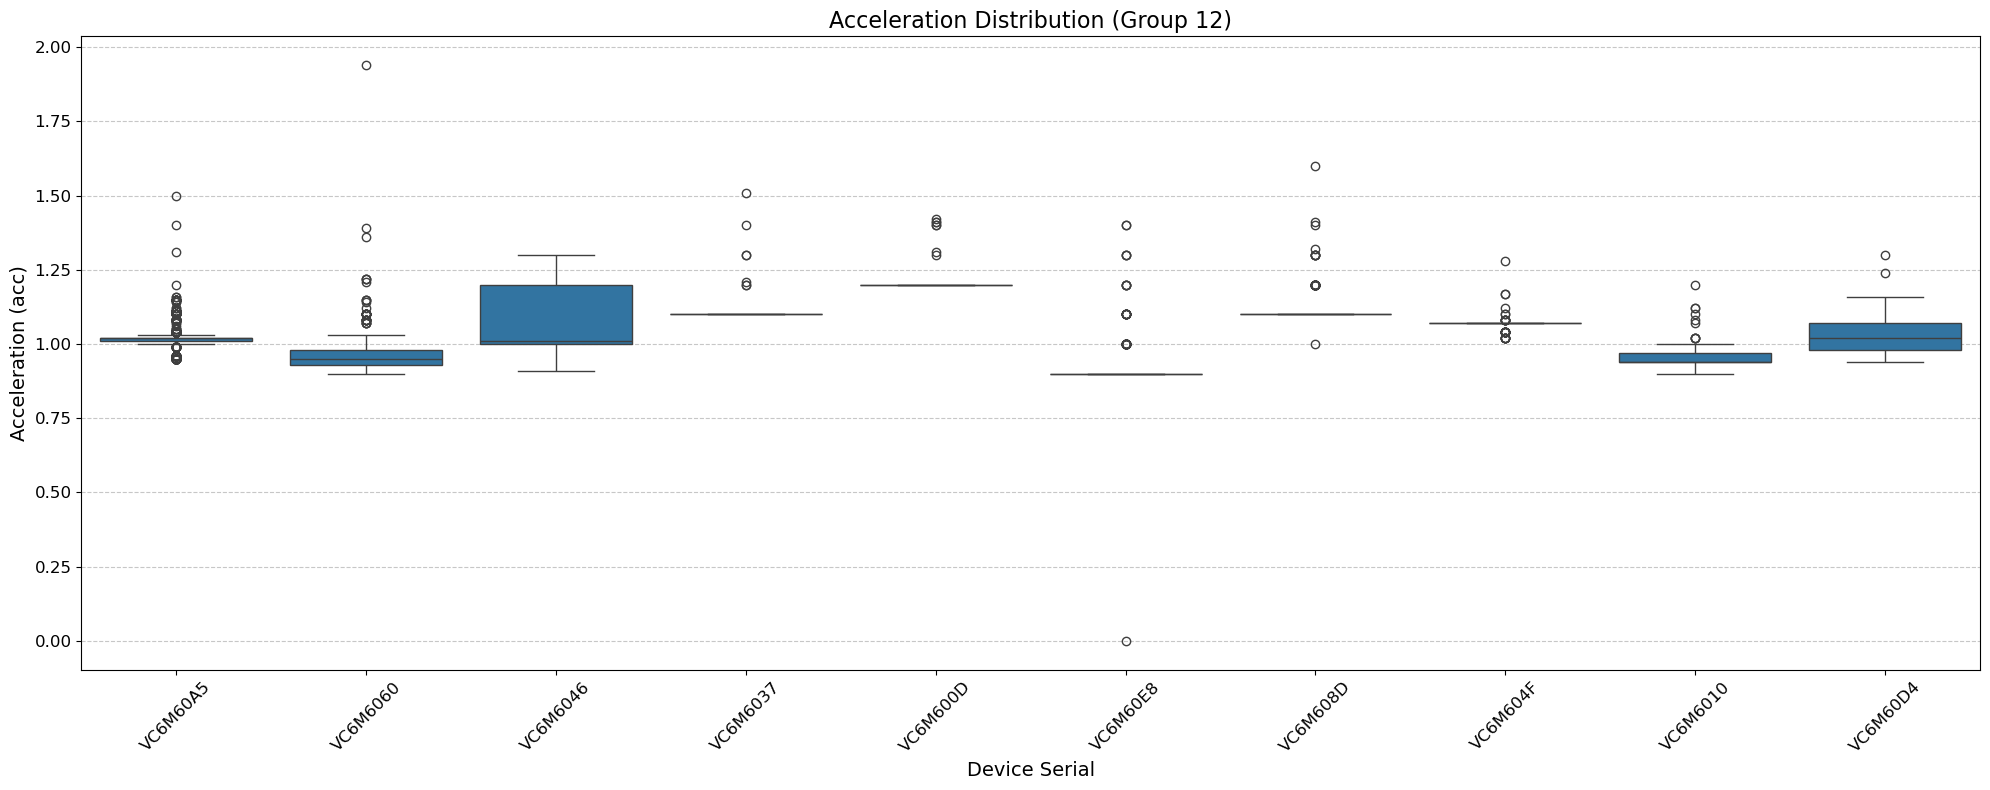


=== Group 12 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M600D         36.0  1.23  0.07  1.20  1.20  1.20  1.20  1.42
VC6M6010        145.0  0.96  0.04  0.90  0.94  0.94  0.97  1.20
VC6M6037         34.0  1.14  0.10  1.10  1.10  1.10  1.10  1.51
VC6M6046          9.0  1.07  0.14  0.91  1.00  1.01  1.20  1.30
VC6M604F        446.0  1.07  0.01  1.02  1.07  1.07  1.07  1.28
VC6M6060        672.0  0.95  0.07  0.90  0.93  0.95  0.98  1.94
VC6M608D        201.0  1.13  0.07  1.00  1.10  1.10  1.10  1.60
VC6M60A5       1974.0  1.02  0.03  0.95  1.01  1.02  1.02  1.50
VC6M60D4       1130.0  1.02  0.04  0.94  0.98  1.02  1.07  1.30
VC6M60E8        453.0  0.92  0.08  0.00  0.90  0.90  0.90  1.40

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M600D         36.0  1.23  0.07  1.20  1.20    1.20  1.20  

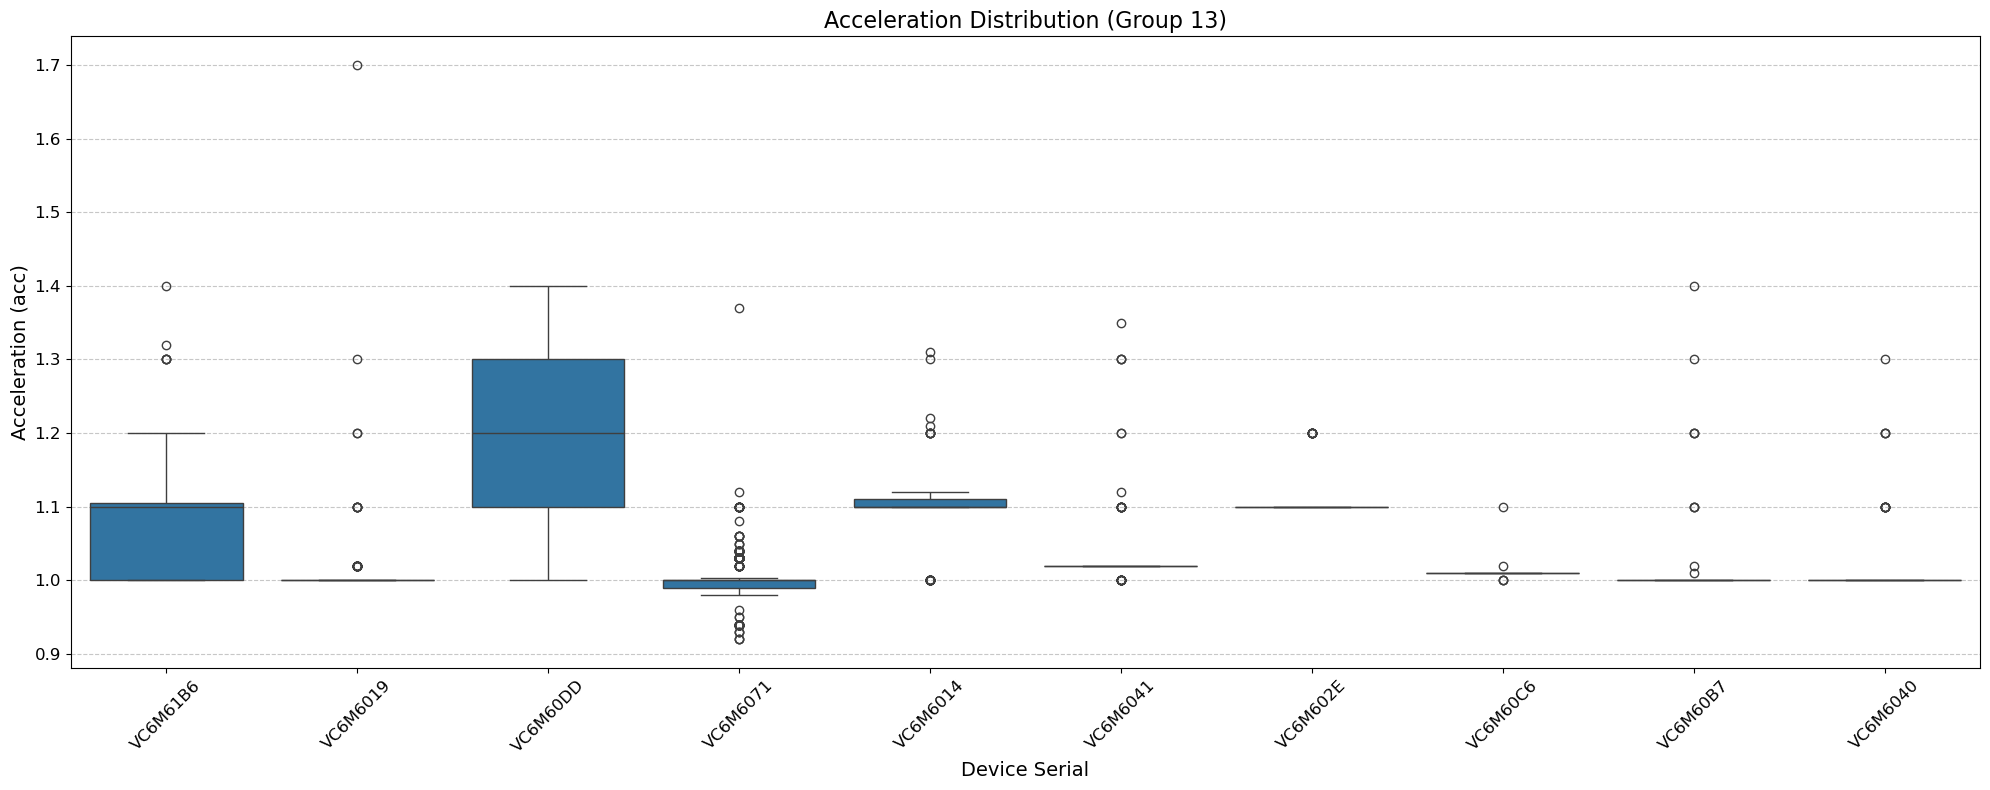


=== Group 13 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M6014        157.0  1.09  0.05  1.00  1.10  1.10  1.11  1.31
VC6M6019        256.0  1.01  0.05  1.00  1.00  1.00  1.00  1.70
VC6M602E         97.0  1.11  0.03  1.10  1.10  1.10  1.10  1.20
VC6M6040        178.0  1.01  0.04  1.00  1.00  1.00  1.00  1.30
VC6M6041         89.0  1.04  0.07  1.00  1.02  1.02  1.02  1.35
VC6M6071       1006.0  1.00  0.03  0.92  0.99  1.00  1.00  1.37
VC6M60B7         66.0  1.02  0.07  1.00  1.00  1.00  1.00  1.40
VC6M60C6         24.0  1.01  0.02  1.00  1.01  1.01  1.01  1.10
VC6M60DD         13.0  1.19  0.12  1.00  1.10  1.20  1.30  1.40
VC6M61B6         35.0  1.10  0.12  1.00  1.00  1.10  1.10  1.40

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6014        157.0  1.09  0.05  1.00  1.10    1.10  1.11  

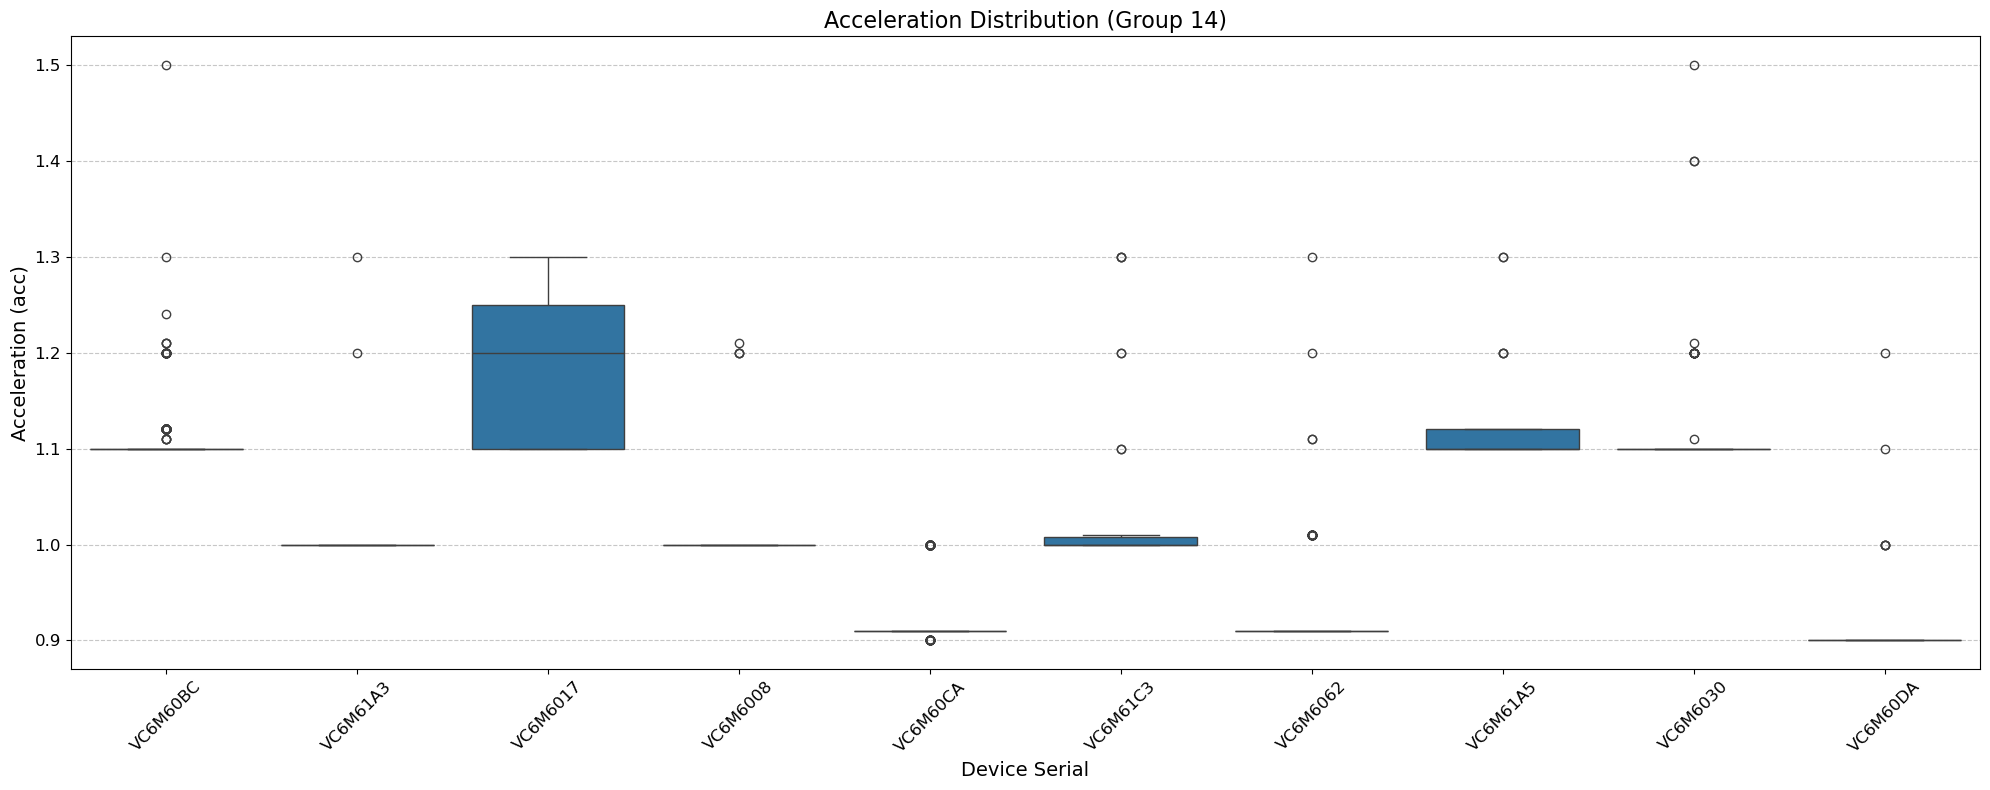


=== Group 14 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6008        76.0  1.01  0.05  1.00  1.00  1.00  1.00  1.21
VC6M6017        11.0  1.18  0.09  1.10  1.10  1.20  1.25  1.30
VC6M6030       117.0  1.12  0.06  1.10  1.10  1.10  1.10  1.50
VC6M6062       263.0  0.93  0.05  0.91  0.91  0.91  0.91  1.30
VC6M60BC       615.0  1.11  0.03  1.10  1.10  1.10  1.10  1.50
VC6M60CA       406.0  0.92  0.03  0.90  0.91  0.91  0.91  1.00
VC6M60DA        59.0  0.92  0.05  0.90  0.90  0.90  0.90  1.20
VC6M61A3        12.0  1.04  0.10  1.00  1.00  1.00  1.00  1.30
VC6M61A5        22.0  1.13  0.06  1.10  1.10  1.10  1.12  1.30
VC6M61C3        30.0  1.05  0.10  1.00  1.00  1.00  1.01  1.30

추가 통계 정보:
               count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                      
VC6M6008        76.0  1.01  0.05  1.00  1.00    1.00  1.00  1.21   
VC6M601

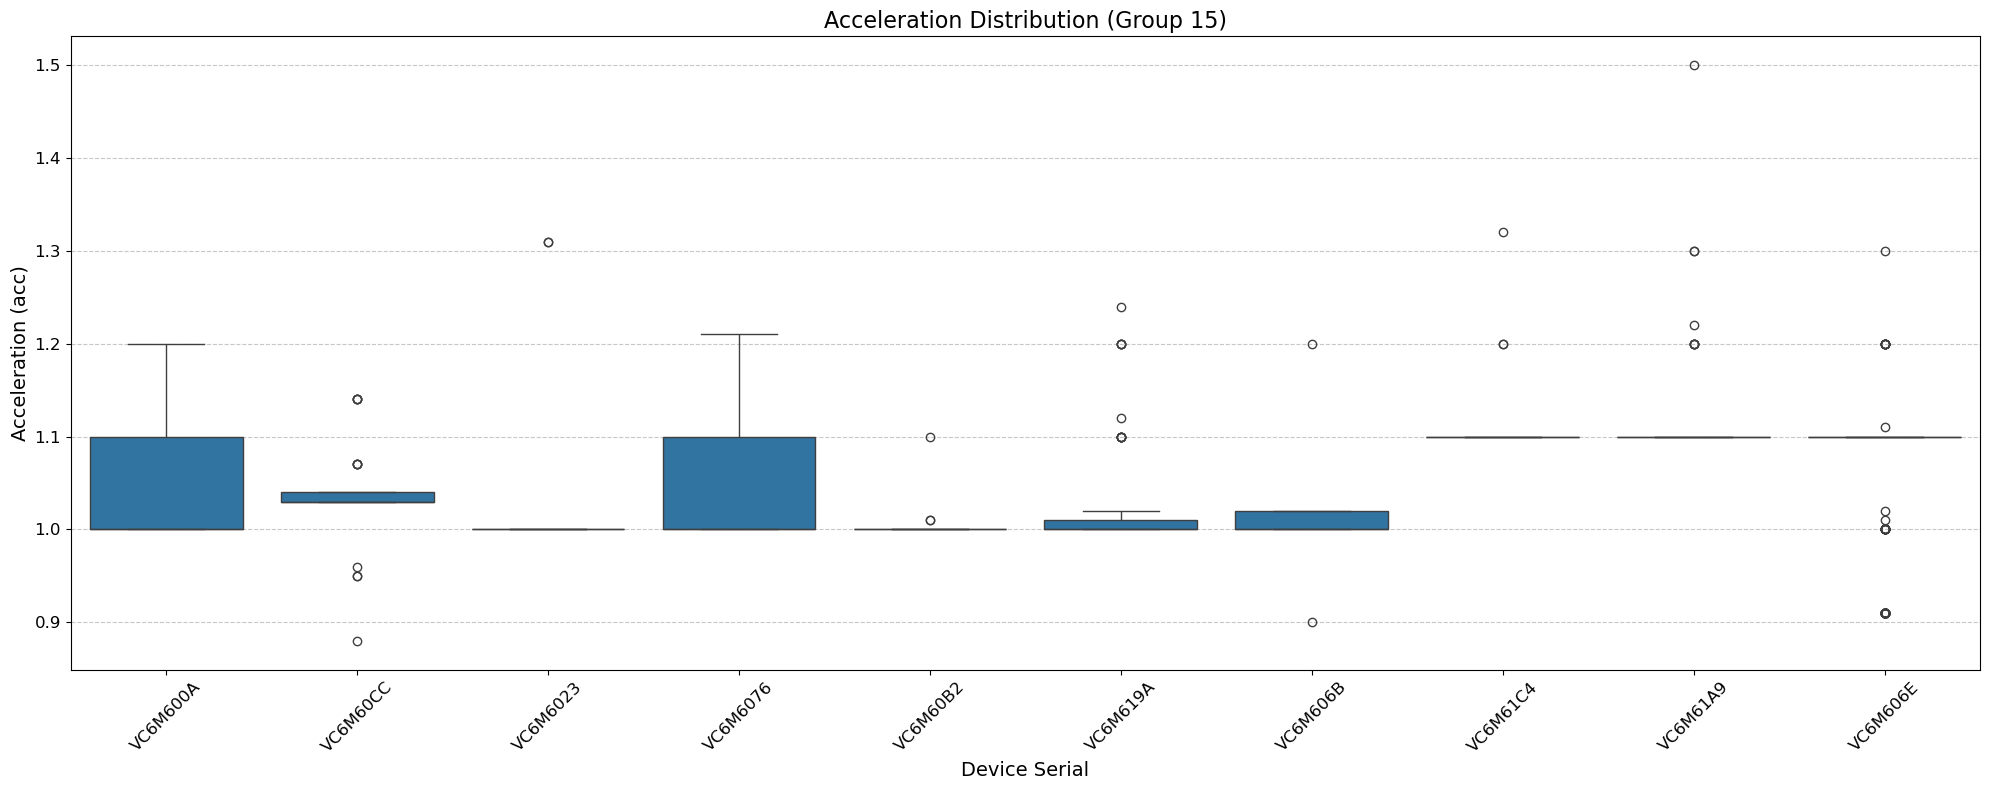


=== Group 15 통계량 ===
                count  mean   std   min   25%   50%   75%   max
device_serial                                                  
VC6M600A        106.0  1.05  0.06  1.00  1.00  1.00  1.10  1.20
VC6M6023        114.0  1.01  0.04  1.00  1.00  1.00  1.00  1.31
VC6M606B          5.0  1.02  0.11  0.90  1.00  1.00  1.02  1.20
VC6M606E        342.0  1.06  0.08  0.91  1.10  1.10  1.10  1.30
VC6M6076        141.0  1.03  0.05  1.00  1.00  1.00  1.10  1.21
VC6M60B2       1357.0  1.00  0.00  1.00  1.00  1.00  1.00  1.10
VC6M60CC         32.0  1.04  0.05  0.88  1.03  1.03  1.04  1.14
VC6M619A        234.0  1.01  0.03  1.00  1.00  1.00  1.01  1.24
VC6M61A9        219.0  1.11  0.04  1.10  1.10  1.10  1.10  1.50
VC6M61C4        150.0  1.10  0.02  1.10  1.10  1.10  1.10  1.32

추가 통계 정보:
                count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M600A        106.0  1.05  0.06  1.00  1.00    1.00  1.10  

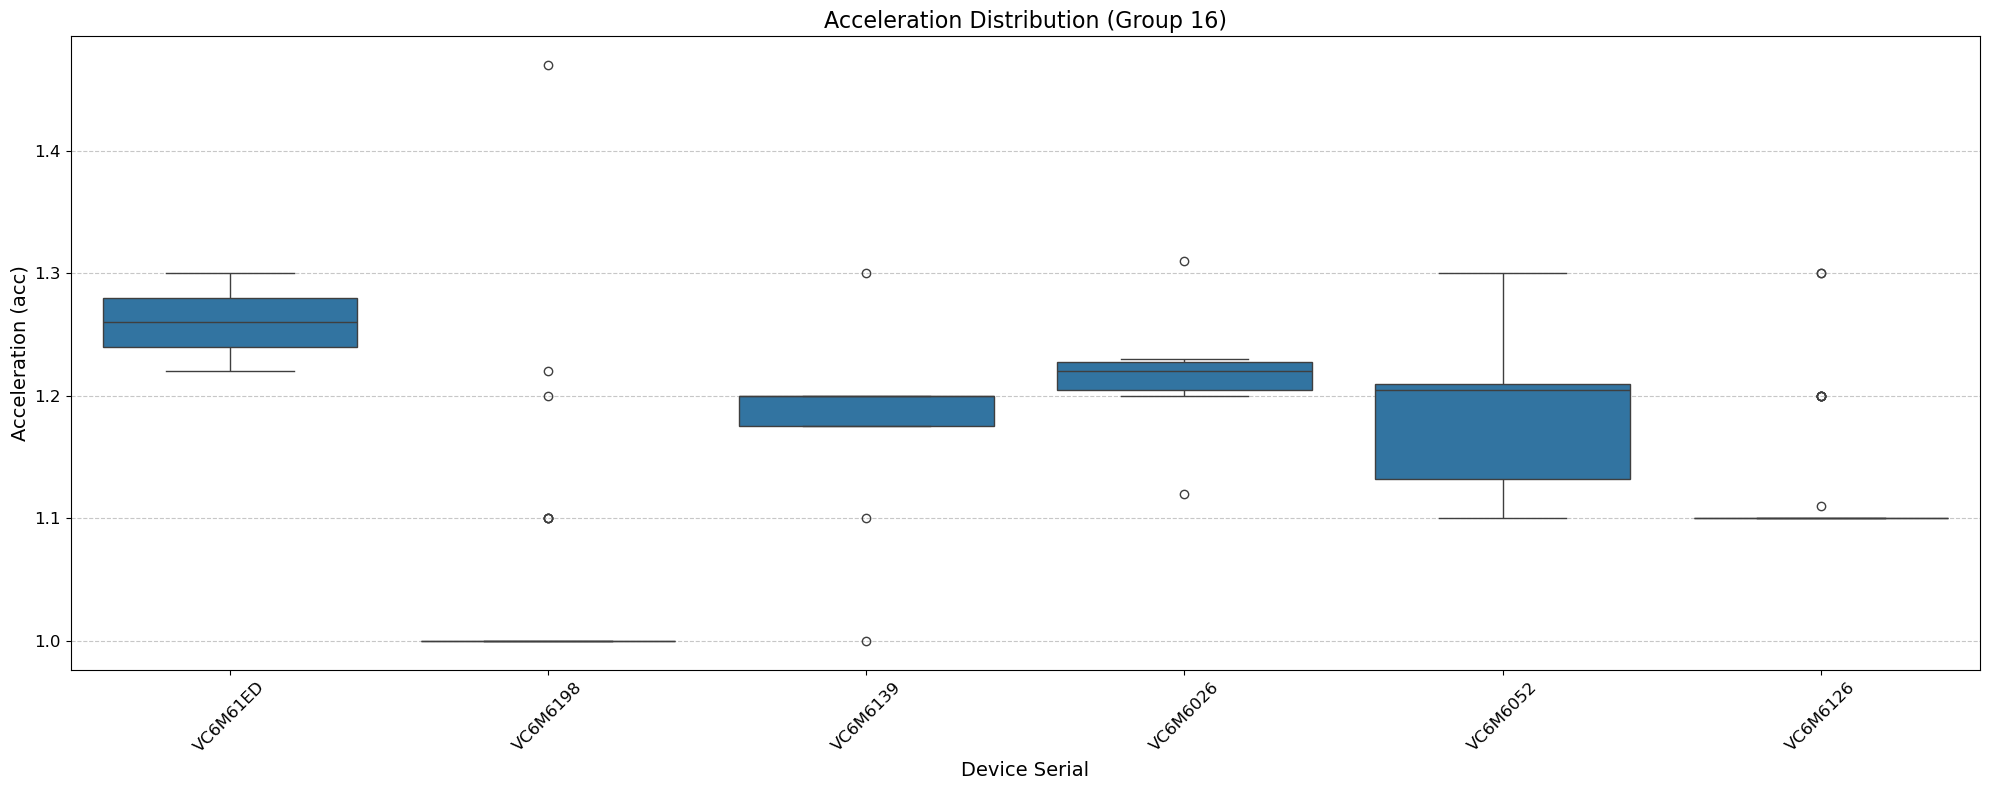


=== Group 16 통계량 ===
               count  mean   std   min   25%   50%   75%   max
device_serial                                                 
VC6M6026         6.0  1.22  0.06  1.12  1.20  1.22  1.23  1.31
VC6M6052         6.0  1.19  0.07  1.10  1.13  1.20  1.21  1.30
VC6M6126       378.0  1.10  0.02  1.10  1.10  1.10  1.10  1.30
VC6M6139         8.0  1.18  0.09  1.00  1.18  1.20  1.20  1.30
VC6M6198       100.0  1.01  0.06  1.00  1.00  1.00  1.00  1.47
VC6M61ED         2.0  1.26  0.06  1.22  1.24  1.26  1.28  1.30

추가 통계 정보:
               count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                      
VC6M6026         6.0  1.22  0.06  1.12  1.20    1.22  1.23  1.31   
VC6M6052         6.0  1.19  0.07  1.10  1.13    1.20  1.21  1.30   
VC6M6126       378.0  1.10  0.02  1.10  1.10    1.10  1.10  1.30   
VC6M6139         8.0  1.18  0.09  1.00  1.18    1.20  1.20  1.30   
VC6M6198       100.0  1.01  0.06  1.00  1.00    1.00  1

In [15]:
# acc 열의 데이터 타입을 float으로 변환
df['acc'] = pd.to_numeric(df['acc'], errors='coerce')

# device_serial 목록 가져오기
devices = df['device_serial'].unique()

# 10개씩 그룹화하기
device_groups = [devices[i:i+10] for i in range(0, len(devices), 10)]

acceleration_stats = []

# 각 그룹별로 박스플롯 생성
for group_idx, device_group in enumerate(device_groups):
    # 그래프 크기 설정
    plt.figure(figsize=(20, 8))
    
    # 현재 그룹의 데이터만 선택
    acc_data = df[df['device_serial'].isin(device_group)]
    
    # 박스플롯 생성
    sns.boxplot(x='device_serial', y='acc', data=acc_data)
    
    # 그래프 제목과 레이블 설정
    plt.title(f'Acceleration Distribution (Group {group_idx + 1})', fontsize=16)
    plt.xlabel('Device Serial', fontsize=14)
    plt.ylabel('Acceleration (acc)', fontsize=14)
    
    # x축 레이블 회전 및 크기 조정
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # 그리드 추가
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 레이아웃 조정
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()
    
    # 각 그룹의 기본 통계량 출력
    print(f"\n=== Group {group_idx + 1} 통계량 ===")
    stats = acc_data.groupby('device_serial')['acc'].describe().round(2)
    print(stats)

    # Q1, Q3 및 IQR 계산
    Q1 = acc_data.groupby('device_serial')['acc'].quantile(0.25)
    Q3 = acc_data.groupby('device_serial')['acc'].quantile(0.75)
    IQR = Q3 - Q1

    # 수염의 시작값과 끝값 계산
    whisker_start = Q1 - 1.5 * IQR
    whisker_end = Q3 + 1.5 * IQR

    # 결과 데이터프레임 생성
    result_stats = pd.DataFrame({
        'count': stats['count'],
        'mean': stats['mean'],
        'std': stats['std'],
        'min': stats['min'],
        'Q1': Q1,
        'median': stats['50%'],
        'Q3': Q3,
        'max': stats['max'],
        'Whisker Start': whisker_start,
        'Whisker End': whisker_end
    }).round(2)

    # 리스트에 추가
    acceleration_stats.append(result_stats)

    print("\n추가 통계 정보:")
    print(result_stats)    
    print("\n" + "="*70 + "\n")
    
# 모든 그룹의 통계량을 하나의 데이터프레임으로 합치기
acc_final_stats = pd.concat(acceleration_stats)
# 결과 출력
print("모든 그룹의 통계량:")
print(acc_final_stats)

### 파손 여부 확인을 위한 시각화
#### 데이터가 일정 acc를 넘어가면 파손으로 간주함

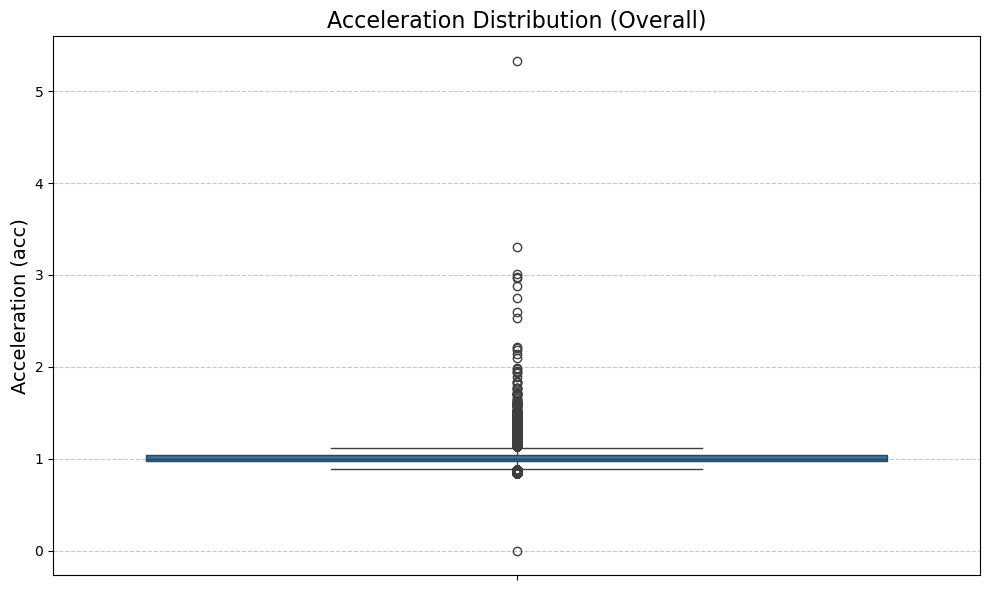

In [16]:
# acc 열의 데이터 타입을 float으로 변환
df['acc'] = pd.to_numeric(df['acc'], errors='coerce')

# 박스플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(y='acc', data=df)

# 그래프 제목과 레이블 설정
plt.title('Acceleration Distribution (Overall)', fontsize=16)
plt.ylabel('Acceleration (acc)', fontsize=14)

# 그리드 추가
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [17]:
df[df['acc'] >= 5]

device_datetime_kor device_serial        lat         lon battery  \
113415 2025-01-23 08:37:35      VC6M6038  36.626770  127.221254    30.0   

        temperature  humidity acc_orig   acc  accx  ...    measure_date_kst  \
113415          0.7      80.0      5.3  5.33  -2.8  ... 2025-01-23 08:00:00   

       aws_station_id aws_station_name      aws_lat       aws_lon distance_km  \
113415            629             세종전의  36.69076000  127.20047000    7.340217   

         ws1  ws10     ta     hm  
113415  0.00  0.00  -6.70  93.30  

[1 rows x 25 columns]

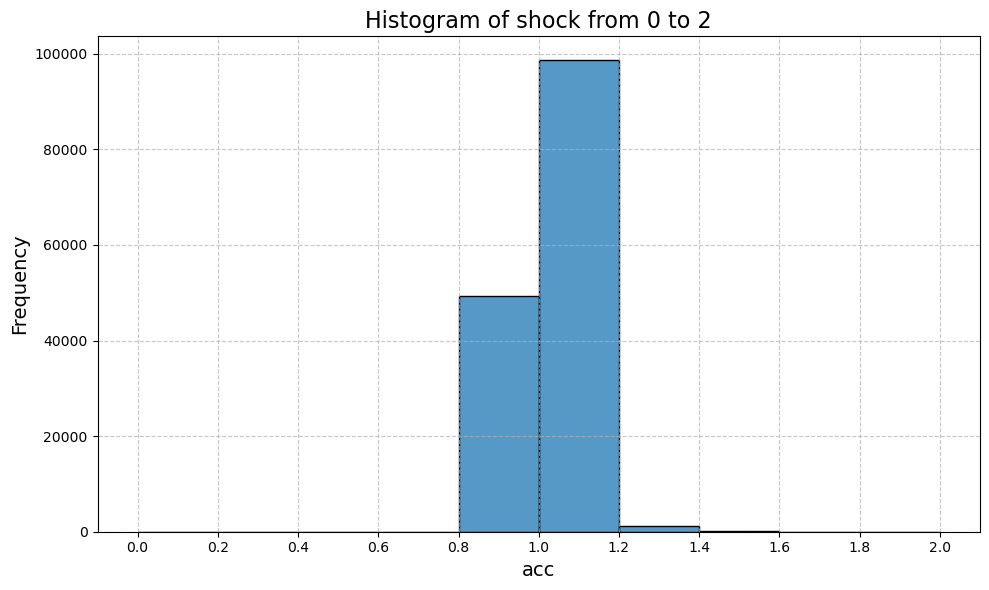

In [22]:
# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(df['acc'], bins=np.arange(0, 2.2, 0.2), kde=False)  # 0.2 단위로 구간 설정

# 그래프 제목과 레이블 설정
plt.title('Histogram of shock from 0 to 2', fontsize=16)
plt.xlabel('acc', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# x축 눈금을 0.2 단위로 설정
plt.xticks(np.arange(0, 2.1, 0.2))

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [22]:
acc_final_stats.head(2)

count  mean   std   min    Q1  median    Q3   max  \
device_serial                                                       
VC6M6034       1226.0  1.16  0.10  0.88  1.06     1.2  1.21  1.81   
VC6M6068         38.0  1.05  0.11  1.00  1.00     1.0  1.00  1.40   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034                0.84         1.43  
VC6M6068                1.00         1.00

In [23]:
temp_final_stats.head(2)

std  count  min   max   mean   Q1      Q3     IQR  \
device_serial                                                        
VC6M6034       51.36   1226 -5.5  21.3  12.81  7.5  20.100  12.600   
VC6M6068        0.42     38  6.4   8.3   7.36  6.8   7.975   1.175   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034            -11.4000      39.0000  
VC6M6068              5.0375       9.7375

In [24]:
humi_final_stats.head(2)

count   mean   std   min    Q1  median    Q3   max  \
device_serial                                                        
VC6M6034       1226.0  53.29  8.78  32.0  46.0    57.0  60.0  87.0   
VC6M6068         38.0  72.79  1.23  69.0  72.0    73.0  73.0  75.0   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034                25.0         81.0  
VC6M6068                70.5         74.5

In [25]:
merged_temp_humi=[]
# 첫 번째 병합: temp_final_stats와 humi_final_stats 병합
merged_temp_humi = pd.merge(temp_final_stats, humi_final_stats, on='device_serial', suffixes=('_temp', '_humi'))

# 두 번째 병합: 첫 번째 병합 결과와 acc_final_stats 병합
merged_stats = pd.merge(merged_temp_humi, acc_final_stats, on='device_serial', suffixes=('', '_acc'))

merged_stats.head(3)

std_temp  count_temp  min_temp  max_temp  mean_temp  Q1_temp  \
device_serial                                                                 
VC6M6034          51.36        1226      -5.5      21.3      12.81     7.50   
VC6M6068           0.42          38       6.4       8.3       7.36     6.80   
VC6M6094           3.97         135       8.0      17.4      11.55    10.15   

               Q3_temp     IQR  Whisker Start_temp  Whisker End_temp  ...  \
device_serial                                                         ...   
VC6M6034        20.100  12.600            -11.4000           39.0000  ...   
VC6M6068         7.975   1.175              5.0375            9.7375  ...   
VC6M6094        12.500   2.350              6.6250           16.0250  ...   

                count  mean   std   min    Q1  median_acc    Q3   max  \
device_serial                                                           
VC6M6034       1226.0  1.16  0.10  0.88  1.06         1.2  1.21  1.81   
VC6M6068         38.0  1.05  0.11  1.00  1.00         1.0  1.00  1.40   
VC6M6094        135.0  1.14  0.08  1.10  1.10         1.1  1.10  1.50   

               Whisker Start  Whisker End  
device_serial                              
VC6M6034                0.84         1.43  
VC6M6068                1.00         1.00  
VC6M6094                1.10         1.10  

[3 rows x 30 columns]

In [26]:
merged_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, VC6M6034 to VC6M61ED
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_temp            157 non-null    float64
 1   count_temp          157 non-null    int64  
 2   min_temp            157 non-null    float64
 3   max_temp            157 non-null    float64
 4   mean_temp           157 non-null    float64
 5   Q1_temp             157 non-null    float64
 6   Q3_temp             157 non-null    float64
 7   IQR                 157 non-null    float64
 8   Whisker Start_temp  157 non-null    float64
 9   Whisker End_temp    157 non-null    float64
 10  count_humi          157 non-null    float64
 11  mean_humi           157 non-null    float64
 12  std_humi            157 non-null    float64
 13  min_humi            157 non-null    float64
 14  Q1_humi             157 non-null    float64
 15  median              157 non-null    float64
 16  Q

In [27]:
# 새로운 컬럼 생성: 상한온도, 하한온도, 상한습도, 하한습도
merged_stats['temp_end'] = merged_stats['Whisker End_temp']
merged_stats['temp_start'] = merged_stats['Whisker Start_temp']
merged_stats['humi_end'] = merged_stats['Whisker End_humi']
merged_stats['humi_start'] = merged_stats['Whisker Start_humi']
merged_stats['acc_end'] = merged_stats['Whisker End']
merged_stats['acc_start'] = merged_stats['Whisker Start']
merged_stats['std_acc'] = merged_stats['std']
merged_stats['mean_acc'] = merged_stats['mean']
merged_stats['min_acc'] = merged_stats['min']
merged_stats['max_acc'] = merged_stats['max']
merged_stats['Q1_acc'] = merged_stats['Q1']
merged_stats['Q3_acc'] = merged_stats['Q3']

In [28]:
merged_stats.head(2)

std_temp  count_temp  min_temp  max_temp  mean_temp  Q1_temp  \
device_serial                                                                 
VC6M6034          51.36        1226      -5.5      21.3      12.81      7.5   
VC6M6068           0.42          38       6.4       8.3       7.36      6.8   

               Q3_temp     IQR  Whisker Start_temp  Whisker End_temp  ...  \
device_serial                                                         ...   
VC6M6034        20.100  12.600            -11.4000           39.0000  ...   
VC6M6068         7.975   1.175              5.0375            9.7375  ...   

               humi_end  humi_start  acc_end  acc_start  std_acc  mean_acc  \
device_serial                                                                
VC6M6034           81.0        25.0     1.43       0.84     0.10      1.16   
VC6M6068           74.5        70.5     1.00       1.00     0.11      1.05   

               min_acc  max_acc  Q1_acc  Q3_acc  
device_serial                                    
VC6M6034          0.88     1.81    1.06    1.21  
VC6M6068          1.00     1.40    1.00    1.00  

[2 rows x 42 columns]

In [30]:
merged_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, VC6M6034 to VC6M61ED
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_temp            157 non-null    float64
 1   count_temp          157 non-null    int64  
 2   min_temp            157 non-null    float64
 3   max_temp            157 non-null    float64
 4   mean_temp           157 non-null    float64
 5   Q1_temp             157 non-null    float64
 6   Q3_temp             157 non-null    float64
 7   IQR                 157 non-null    float64
 8   Whisker Start_temp  157 non-null    float64
 9   Whisker End_temp    157 non-null    float64
 10  count_humi          157 non-null    float64
 11  mean_humi           157 non-null    float64
 12  std_humi            157 non-null    float64
 13  min_humi            157 non-null    float64
 14  Q1_humi             157 non-null    float64
 15  median              157 non-null    float64
 16  Q

In [31]:
col_lst=['min_temp', 'max_temp', 'mean_temp', 'std_temp'
         , 'min_humi', 'max_humi', 'mean_humi', 'std_humi'
         , 'min_acc', 'max_acc', 'mean_acc', 'std_acc'
         , 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end'
         , 'Q1_humi', 'Q3_humi', 'humi_start', 'humi_end'
         , 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end'
         ]
low_upp=merged_stats[col_lst]

In [32]:
low_upp

min_temp  max_temp  mean_temp  std_temp  min_humi  max_humi  \
device_serial                                                                
VC6M6034           -5.5      21.3      12.81     51.36      32.0      87.0   
VC6M6068            6.4       8.3       7.36      0.42      69.0      75.0   
VC6M6094            8.0      17.4      11.55      3.97      49.0      65.0   
VC6M609B            3.8       7.8       5.37      1.69      53.0      60.0   
VC6M60A2            7.8      16.0      11.60      6.13      51.0      66.0   
...                 ...       ...        ...       ...       ...       ...   
VC6M6126           -2.9       9.7       4.36     13.22      42.0      54.0   
VC6M6139            0.2       0.8       0.44      0.05      51.0      54.0   
VC6M6198            0.6       4.1       1.85      1.25      50.0      60.0   
VC6M61C4            1.4       6.5       4.48      3.98      53.0      65.0   
VC6M61ED            0.2       1.6       0.86      0.21      47.0      50.0   

               mean_humi  std_humi  min_acc  max_acc  ...  temp_start  \
device_serial                                         ...               
VC6M6034           53.29      8.78     0.88     1.81  ...    -11.4000   
VC6M6068           72.79      1.23     1.00     1.40  ...      5.0375   
VC6M6094           60.04      2.64     1.10     1.50  ...      6.6250   
VC6M609B           56.93      1.90     1.00     1.40  ...      1.0000   
VC6M60A2           57.08      3.23     1.00     1.40  ...      3.6750   
...                  ...       ...      ...      ...  ...         ...   
VC6M6126           47.62      3.28     1.10     1.30  ...     -8.1500   
VC6M6139           52.62      0.92     1.00     1.30  ...     -0.0750   
VC6M6198           54.97      2.48     1.00     1.47  ...     -2.2500   
VC6M61C4           57.67      4.56     1.10     1.32  ...     -2.8625   
VC6M61ED           48.50      0.85     1.11     1.22  ...     -0.5250   

               temp_end  Q1_humi  Q3_humi  humi_start  humi_end  Q1_acc  \
device_serial                                                             
VC6M6034        39.0000     46.0     60.0       25.00     81.00    1.06   
VC6M6068         9.7375     72.0     73.0       70.50     74.50    1.00   
VC6M6094        16.0250     59.0     62.0       54.50     66.50    1.10   
VC6M609B         9.2000     56.0     58.0       53.00     61.00    1.00   
VC6M60A2        20.6750     54.5     59.0       47.75     65.75    1.00   
...                 ...      ...      ...         ...       ...     ...   
VC6M6126        17.0500     44.0     50.0       35.00     59.00    1.10   
VC6M6139         0.9250     52.0     53.0       50.50     54.50    1.18   
VC6M6198         6.1500     53.0     57.0       47.00     63.00    1.00   
VC6M61C4        11.0375     55.0     63.0       43.00     75.00    1.10   
VC6M61ED         2.2750     48.0     49.0       46.50     50.50    1.11   

               Q3_acc  acc_start  acc_end  
device_serial                              
VC6M6034         1.21       0.84     1.43  
VC6M6068         1.00       1.00     1.00  
VC6M6094         1.10       1.10     1.10  
VC6M609B         1.00       1.00     1.00  
VC6M60A2         1.10       0.85     1.25  
...               ...        ...      ...  
VC6M6126         1.10       1.10     1.10  
VC6M6139         1.20       1.14     1.24  
VC6M6198         1.00       1.00     1.00  
VC6M61C4         1.12       1.06     1.16  
VC6M61ED         1.11       1.11     1.11  

[157 rows x 24 columns]

In [33]:
df.head(2)

device_datetime_kor device_serial        lat         lon battery  \
0 2024-12-18 00:21:47      VC6M60AD  36.815106  127.061828   100.0   
1 2024-12-18 00:31:47      VC6M60AD  36.815106  127.061828   100.0   

   temperature  humidity acc_orig   acc accx  ... measure_date_kst  \
0          0.1      46.0      1.0  1.01  0.1  ...       2024-12-18   
1          0.1      45.0      1.0  1.00  0.0  ...       2024-12-18   

  aws_station_id aws_station_name      aws_lat       aws_lon distance_km  \
0            493               송악  36.73615000  127.00805000    9.991122   
1            493               송악  36.73615000  127.00805000    9.991122   

    ws1  ws10     ta     hm  
0  3.40  3.20  -0.40  62.80  
1  3.40  3.20  -0.40  62.80  

[2 rows x 25 columns]

In [34]:
# low_upp 데이터프레임을 df와 병합하여 temp_start와 temp_end를 df에 추가
df_merge=pd.merge(df, low_upp, on='device_serial', how='left')

In [35]:
df_merge

device_datetime_kor device_serial        lat         lon battery  \
0      2024-12-18 00:21:47      VC6M60AD  36.815106  127.061828   100.0   
1      2024-12-18 00:31:47      VC6M60AD  36.815106  127.061828   100.0   
2      2024-12-18 00:41:47      VC6M60AD  36.815106  127.061828   100.0   
3      2024-12-18 00:51:47      VC6M60AD  36.815106  127.061828   100.0   
4      2024-12-17 22:51:47      VC6M60AD  36.815106  127.061828   100.0   
...                    ...           ...        ...         ...     ...   
146523 2024-12-13 12:51:44      VC6M60E6  36.299017  127.593702   100.0   
146524 2024-12-13 13:01:44      VC6M60E6  36.299017  127.593702   100.0   
146525 2024-12-02 15:36:09      VC6M60C1  36.298510  127.597675   100.0   
146526 2024-12-09 11:53:19      VC6ML003  36.638253  127.384396   100.0   
146527 2024-11-29 11:50:50      VC6M6049  36.300355  127.595394    90.0   

        temperature  humidity acc_orig   acc  accx  ... temp_start temp_end  \
0               0.1      46.0      1.0  1.01   0.1  ...    18.2000  26.2000   
1               0.1      45.0      1.0  1.00   0.0  ...    18.2000  26.2000   
2               0.0      44.0      1.0  1.01   0.1  ...    18.2000  26.2000   
3               0.0      43.0      1.0  1.00   0.0  ...    18.2000  26.2000   
4               1.7      48.0      1.0  1.01   0.1  ...    18.2000  26.2000   
...             ...       ...      ...   ...   ...  ...        ...      ...   
146523          5.1      40.0      1.0  1.00   0.0  ...     5.3500   8.5500   
146524          5.1      40.0      1.1  1.10   0.0  ...     5.3500   8.5500   
146525         17.3      55.0      1.2  1.20  -0.1  ...    -3.6500  24.7500   
146526          6.1      43.0      1.2  1.21  -0.1  ...    17.0000  25.8000   
146527          3.4      65.0      1.2  1.20   0.0  ...    -0.7875   6.1125   

       Q1_humi Q3_humi humi_start humi_end  Q1_acc Q3_acc acc_start acc_end  
0         17.0    23.0        8.0     32.0     1.0    1.0       1.0     1.0  
1         17.0    23.0        8.0     32.0     1.0    1.0       1.0     1.0  
2         17.0    23.0        8.0     32.0     1.0    1.0       1.0     1.0  
3         17.0    23.0        8.0     32.0     1.0    1.0       1.0     1.0  
4         17.0    23.0        8.0     32.0     1.0    1.0       1.0     1.0  
...        ...     ...        ...      ...     ...    ...       ...     ...  
146523    43.0    48.0       35.5     55.5     1.0    1.0       1.0     1.0  
146524    43.0    48.0       35.5     55.5     1.0    1.0       1.0     1.0  
146525    56.0    60.0       50.0     66.0     1.0    1.0       1.0     1.0  
146526    19.0    26.0        8.5     36.5     1.0    1.0       1.0     1.0  
146527    65.0    67.0       62.0     70.0     1.0    1.0       1.0     1.0  

[146528 rows x 49 columns]

### 온도/습도/충격량 일탈여부 정의

#### device_serial별로 사분위수를 넘어가는 케이스에 대해서 일탈로 간주함(온도, 습도)
#### 파손여부는 충격량의 특정 임계치를 넘어간 경우에 대해 정의함 (ex: 충격량(acc)이 1.5를 초과하는 경우 파손이라 함)

In [36]:
# 온도 일탈 여부 확인: temp_start와 temp_end를 벗어나는 경우
df_merge['alert_temp'] = df_merge.apply(lambda row: '일탈' if row['temperature'] < row['temp_start'] or row['temperature'] > row['temp_end'] else '정상', axis=1)
# 습도 일탈 여부 확인: humi_start와 humi_end를 벗어나는 경우
df_merge['alert_humi'] = df_merge.apply(lambda row: '일탈' if row['humidity'] < row['humi_start'] or row['humidity'] > row['humi_end'] else '정상', axis=1)
# 충격 일탈 여부 확인: acc_start와 acc_end를 벗어나는 경우
df_merge['alert_acc'] = df_merge.apply(lambda row: '일탈' if row['acc'] < row['acc_start'] or row['acc'] > row['acc_end'] else '정상', axis=1)
# 충격 일탈 여부 확인: acc_start와 acc_end를 벗어나는 경우 및 실제 측정값이 1.5 초과 시 파손으로 확인
df_merge['item_shock'] = df_merge.apply(lambda row: '파손' if row['acc'] > 1.5 else '정상', axis=1)


# 온도 결과 출력
print("온도 일탈 여부:")
print(df_merge[['device_serial', 'temperature', 'alert_temp', 'temp_start', 'temp_end']])

# 습도 결과 출력
print("습도 일탈 여부:")
print(df_merge[['device_serial', 'humidity', 'alert_humi', 'humi_start', 'humi_end']])

# 충격량 결과 출력
print("충격량 일탈 여부:")
print(df_merge[['device_serial', 'acc', 'alert_acc', 'acc_start', 'humi_end']])

# 파손여부 결과 출력
print("파손 여부:")
print(df_merge[['device_serial', 'acc', 'item_shock']])

온도 일탈 여부:
       device_serial  temperature alert_temp  temp_start  temp_end
0           VC6M60AD          0.1         일탈     18.2000   26.2000
1           VC6M60AD          0.1         일탈     18.2000   26.2000
2           VC6M60AD          0.0         일탈     18.2000   26.2000
3           VC6M60AD          0.0         일탈     18.2000   26.2000
4           VC6M60AD          1.7         일탈     18.2000   26.2000
...              ...          ...        ...         ...       ...
146523      VC6M60E6          5.1         일탈      5.3500    8.5500
146524      VC6M60E6          5.1         일탈      5.3500    8.5500
146525      VC6M60C1         17.3         정상     -3.6500   24.7500
146526      VC6ML003          6.1         일탈     17.0000   25.8000
146527      VC6M6049          3.4         정상     -0.7875    6.1125

[146528 rows x 5 columns]
습도 일탈 여부:
       device_serial  humidity alert_humi  humi_start  humi_end
0           VC6M60AD      46.0         일탈         8.0      32.0
1           VC6M60AD 

In [37]:
len(df_merge.columns)

53

In [38]:
print(df_merge.info())
print(df_merge.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146528 entries, 0 to 146527
Data columns (total 53 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   device_datetime_kor  146528 non-null  datetime64[ns]
 1   device_serial        146528 non-null  object        
 2   lat                  146528 non-null  object        
 3   lon                  146528 non-null  object        
 4   battery              146528 non-null  object        
 5   temperature          146528 non-null  float64       
 6   humidity             146528 non-null  float64       
 7   acc_orig             146528 non-null  object        
 8   acc                  146528 non-null  float64       
 9   accx                 146528 non-null  object        
 10  accy                 146528 non-null  object        
 11  accz                 146528 non-null  object        
 12  tiltx                146528 non-null  object        
 13  tilty         

In [42]:
col_lst = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery'
           , 'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz'
           , 'tiltx', 'tilty', 'tiltz', 'measure_date_kst', 'aws_station_id'
           , 'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10', 'ta', 'hm'
           , 'min_temp', 'max_temp', 'mean_temp', 'std_temp'
           , 'min_humi', 'max_humi', 'mean_humi', 'std_humi'
           , 'min_acc', 'max_acc', 'mean_acc', 'std_acc'
           , 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end'
           , 'Q1_humi', 'Q3_humi', 'humi_start', 'humi_end'
           , 'Q1_acc', 'Q3_acc', 'acc_start', 'acc_end'
           , 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock']

df_fin = df_merge[col_lst]

In [44]:
df_fin.head(2)

device_datetime_kor device_serial        lat         lon battery  \
0 2024-12-18 00:21:47      VC6M60AD  36.815106  127.061828   100.0   
1 2024-12-18 00:31:47      VC6M60AD  36.815106  127.061828   100.0   

   temperature  humidity acc_orig   acc accx  ... humi_start humi_end Q1_acc  \
0          0.1      46.0      1.0  1.01  0.1  ...        8.0     32.0    1.0   
1          0.1      45.0      1.0  1.00  0.0  ...        8.0     32.0    1.0   

  Q3_acc acc_start acc_end  alert_temp alert_humi alert_acc item_shock  
0    1.0       1.0     1.0          일탈         일탈        일탈         정상  
1    1.0       1.0     1.0          일탈         일탈        정상         정상  

[2 rows x 53 columns]

### Data insert

# Table Create Query
<!-- CREATE TABLE "da_schema"."t_frigga_weather_map_alert" (
    device_datetime_kor TIMESTAMP WITHOUT TIME ZONE ENCODE raw,
    device_serial VARCHAR(255) ENCODE raw,
    lat NUMERIC(10, 6) ENCODE az64,
    lon NUMERIC(10, 6) ENCODE az64,
    battery NUMERIC(10, 1) ENCODE az64,
    temperature NUMERIC(10, 1) ENCODE az64,
    humidity NUMERIC(10, 1) ENCODE az64,
    acc_orig NUMERIC(10, 1) ENCODE az64,
    acc DOUBLE PRECISION ENCODE raw,
    accx NUMERIC(10, 1) ENCODE az64,
    accy NUMERIC(10, 1) ENCODE az64,
    accz NUMERIC(10, 1) ENCODE az64,
    tiltx NUMERIC(10, 1) ENCODE az64,
    tilty NUMERIC(10, 1) ENCODE az64,
    tiltz NUMERIC(10, 1) ENCODE az64,
    measure_date_kst TIMESTAMP WITHOUT TIME ZONE ENCODE az64,
    aws_station_id INTEGER ENCODE az64,
    aws_station_name VARCHAR(100) ENCODE lzo,
    aws_lat NUMERIC(11, 8) ENCODE az64,
    aws_lon NUMERIC(11, 8) ENCODE az64,
    distance_km DOUBLE PRECISION ENCODE raw,
    ws1 NUMERIC(10, 2) ENCODE az64,
    ws10 NUMERIC(10, 2) ENCODE az64,
    ta NUMERIC(10, 2) ENCODE az64,
    hm NUMERIC(10, 2) ENCODE az64, 
    Q1_temp NUMERIC(10, 2) ENCODE az64,
    Q3_temp NUMERIC(10, 2) ENCODE az64,
    temp_start NUMERIC(10, 2) ENCODE az64,
    temp_end NUMERIC(10, 2) ENCODE az64,
    Q1_humi NUMERIC(10, 2) ENCODE az64,
    Q3_humi NUMERIC(10, 2) ENCODE az64,
    humi_start NUMERIC(10, 2) ENCODE az64,
    humi_end NUMERIC(10, 2) ENCODE az64,
    alert_temp VARCHAR(255) ENCODE lzo,
    alert_humi VARCHAR(255) ENCODE lzo
)
DISTSTYLE AUTO
SORTKEY (device_serial, device_datetime_kor); -->

In [45]:
import psycopg2
from psycopg2.extras import execute_values
from tqdm import tqdm

In [48]:
df_fin.columns

Index(['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery',
       'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz',
       'tiltx', 'tilty', 'tiltz', 'measure_date_kst', 'aws_station_id',
       'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10',
       'ta', 'hm', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi',
       'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc', 'mean_acc',
       'std_acc', 'Q1_temp', 'Q3_temp', 'temp_start', 'temp_end', 'Q1_humi',
       'Q3_humi', 'humi_start', 'humi_end', 'Q1_acc', 'Q3_acc', 'acc_start',
       'acc_end', 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock'],
      dtype='object')

In [49]:
# Redshift에 연결
conn = psycopg2.connect(
    host='dev-data-etl-rs.ct0xxcn9xq5g.ap-northeast-2.redshift.amazonaws.com',
    dbname='data_analysis_db',
    user='stella',
    password='iWntan282E5jJQc',
    port='5439'
)

# 데이터프레임을 튜플 리스트로 변환
values = [tuple(row) for row in df_merge.values]

# INSERT 쿼리
insert_query = """
    INSERT INTO "data_analysis_db"."da_schema"."t_frigga_weather_map_alert" (
       device_datetime_kor, device_serial, lat, lon, battery,
       temperature, humidity, acc_orig, acc, accx, accy, accz,
       tiltx, tilty, tiltz, measure_date_kst, aws_station_id,
       aws_station_name, aws_lat, aws_lon, distance_km, ws1, ws10,
       ta, hm, min_temp, max_temp, mean_temp, std_temp, min_humi,
       max_humi, mean_humi, std_humi, min_acc, max_acc, mean_acc,
       std_acc, Q1_temp, Q3_temp, temp_start, temp_end, Q1_humi,
       Q3_humi, humi_start, humi_end, Q1_acc, Q3_acc, acc_start,
       acc_end, alert_temp, alert_humi, alert_acc, item_shock
    ) VALUES %s
"""

try:
    # 커서 생성
    cursor = conn.cursor()

    # execute_values를 사용하여 한 번에 여러 행 삽입
    # tqdm을 사용하여 진행 상황 표시
    for i in tqdm(range(0, len(values), 1000), desc="Inserting data"):
        execute_values(cursor, insert_query, values[i:i + 1000])
    
    # 커밋하여 변경 사항을 적용
    conn.commit()
    print("데이터 INSERT 완료")

except Exception as e:
    conn.rollback()
    print(f"에러 발생: {str(e)}")

finally:
    # 커서와 연결 종료
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Inserting data: 100%|██████████| 147/147 [05:02<00:00,  2.06s/it]


데이터 INSERT 완료
